In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from gensim.models import Word2Vec
import gzip
import gensim 
import logging
from itertools import islice
import multiprocessing
import nltk
from gensim.models import Word2Vec
import re
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from gensim.models.doc2vec import TaggedDocument
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import Error
from matplotlib import reload
reload(Error)

C:\Program Files\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
C:\Program Files\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
C:\Program Files\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


<module 'Error' from 'U:\\JIRA\\Code\\Error.py'>

In [2]:
def replace_strings(data,name):
    for i in range(len(data)):
        if(data[name].iloc[i].find(',')!=-1):
            data[name].iloc[i]=data[name].iloc[i].split(",")[-1]
    return data

def word_averaging(wv, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.vocab:
            mean.append(wv.vectors[wv.vocab[word].index])
            all_words.add(wv.vocab[word].index)

    if not mean:
        logging.warning("cannot compute similarity with no input %s", words)
        # FIXME: remove these examples in pre-processing
        return np.zeros(wv.vector_size,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, post) for post in text_list ])



def w2v_tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text, language='english'):
        for word in nltk.word_tokenize(sent, language='english'):
            if len(word) < 2:
                continue
            tokens.append(word)
    print(tokens)
    return tokens

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text

def label_sentences(corpus, label_type):
    """
    Gensim's Doc2Vec implementation requires each document/paragraph to have a label associated with it.
    We do this by using the TaggedDocument method. The format will be "TRAIN_i" or "TEST_i" where "i" is
    a dummy index of the post.
    """
    labeled = []
    for i, v in enumerate(corpus):
        label = label_type + '_' + str(i)
        labeled.append(TaggedDocument(v.split(), [label]))
    return labeled

def get_vectors(model, corpus_size, vectors_size, vectors_type):
    """
    Get vectors from trained doc2vec model
    :param doc2vec_model: Trained Doc2Vec model
    :param corpus_size: Size of the data
    :param vectors_size: Size of the embedding vectors
    :param vectors_type: Training or Testing vectors
    :return: list of vectors
    """
    vectors = np.zeros((corpus_size, vectors_size))
    for i in range(0, corpus_size):
        prefix = vectors_type + '_' + str(i)
        vectors[i] = model.docvecs[prefix]
    return vectors


In [3]:
data=pd.read_excel("U:/JIRA/JIRAExport/train_data.xls")
data=data.dropna()
data=replace_strings(data,'Component/s')
data['Description'] = data['Description'].str.replace('[^a-zA-Z]',' ').str.lower()
stop_re = '\\b'+'\\b|\\b'.join(nltk.corpus.stopwords.words('english'))+'\\b'
data['Description'] = data['Description'].str.replace(stop_re, '')
data.head()

C:\Program Files\Anaconda3\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Issue Key                                            Summary  Status  \
0  NCG3D-75861  CLONE - When a pohne without any music connect...  Closed   
1  NCG3D-75863                     Reset when system is kept idle  Closed   
2  NCG3D-75864                  Several resets during 35 km drive  Closed   
4  NCG3D-75867  After reaching the destination, the navi conti...  Closed   
5  NCG3D-75765  Map icons (compass, zoom scale and map menu) i...  Closed   

              Created        Component/s  \
0 2017-11-14 12:11:20    SW_INFOTAINMENT   
1 2017-11-14 12:38:12         SW_MANAPPS   
2 2017-11-14 12:48:53          SW_Resets   
4 2017-11-14 13:14:17      SW_NAVIGATION   
5 2017-11-14 06:58:13  SW_NAVIGATION_JPN   

                                         Description        Resolved Date  
0  h   test environment     hw sample   p  r   de...  2018-01-24 10:25:31  
1  h   test environment     hw sample      device...  2017-11-15 07:12:04  
2  h   test environment     hw sample    dual lig...  2017-11-14 14:02:45  
4  h   test environment     sw         hw sample ...  2017-11-22 11:12:34  
5  h   test environment     hw sample   nissan p ...  2017-12-07 12:31:42

In [4]:
X = data.Description
y = data['Component/s']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

In [5]:
sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)
y_pred = sgd.predict(X_test)
print('accuracy %s' % accuracy_score(y_pred, y_test))

accuracy 0.6829105878079786


In [6]:

data['Description'] = data['Description'].str.split()

In [7]:
phrases = gensim.models.phrases.Phrases(data['Description'].tolist())
phraser = gensim.models.phrases.Phraser(phrases)
data_phrased = phraser[data['Description'].tolist()]

2019-01-29 10:51:29,169 : INFO : collecting all words and their counts
2019-01-29 10:51:29,171 : INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types
2019-01-29 10:51:31,155 : INFO : PROGRESS: at sentence #10000, processed 1330673 words and 169185 word types
2019-01-29 10:51:33,172 : INFO : PROGRESS: at sentence #20000, processed 2646851 words and 275089 word types
2019-01-29 10:51:36,197 : INFO : PROGRESS: at sentence #30000, processed 4016265 words and 362099 word types
2019-01-29 10:51:39,450 : INFO : PROGRESS: at sentence #40000, processed 5320727 words and 432771 word types
2019-01-29 10:51:42,605 : INFO : PROGRESS: at sentence #50000, processed 6642853 words and 500955 word types
2019-01-29 10:51:46,018 : INFO : PROGRESS: at sentence #60000, processed 7964044 words and 559801 word types
2019-01-29 10:51:48,309 : INFO : PROGRESS: at sentence #70000, processed 9294667 words and 615681 word types
2019-01-29 10:51:50,435 : INFO : PROGRESS: at sentence #80000, processed

In [8]:
multiprocessing.cpu_count()

8

In [9]:
w2v = gensim.models.word2vec.Word2Vec(sentences=data_phrased,workers=32)

2019-01-29 10:51:57,590 : INFO : collecting all words and their counts
2019-01-29 10:51:57,592 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-01-29 10:52:01,186 : INFO : PROGRESS: at sentence #10000, processed 1176559 words, keeping 20583 word types
2019-01-29 10:52:04,384 : INFO : PROGRESS: at sentence #20000, processed 2340233 words, keeping 29390 word types
2019-01-29 10:52:07,666 : INFO : PROGRESS: at sentence #30000, processed 3552545 words, keeping 35575 word types
2019-01-29 10:52:10,777 : INFO : PROGRESS: at sentence #40000, processed 4703768 words, keeping 39953 word types
2019-01-29 10:52:13,919 : INFO : PROGRESS: at sentence #50000, processed 5871892 words, keeping 44001 word types
2019-01-29 10:52:17,203 : INFO : PROGRESS: at sentence #60000, processed 7043015 words, keeping 47161 word types
2019-01-29 10:52:20,862 : INFO : PROGRESS: at sentence #70000, processed 8213328 words, keeping 50430 word types
2019-01-29 10:52:24,654 : INFO : PROGRE

2019-01-29 10:52:56,221 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-01-29 10:52:56,223 : INFO : EPOCH - 1 : training on 9717211 raw words (5936154 effective words) took 30.1s, 197149 effective words/s
2019-01-29 10:52:57,241 : INFO : EPOCH 2 - PROGRESS: at 3.16% examples, 190861 words/s, in_qsize 0, out_qsize 0
2019-01-29 10:52:58,261 : INFO : EPOCH 2 - PROGRESS: at 6.57% examples, 193626 words/s, in_qsize 0, out_qsize 0
2019-01-29 10:52:59,286 : INFO : EPOCH 2 - PROGRESS: at 10.18% examples, 198297 words/s, in_qsize 0, out_qsize 0
2019-01-29 10:53:00,306 : INFO : EPOCH 2 - PROGRESS: at 13.83% examples, 202184 words/s, in_qsize 0, out_qsize 0
2019-01-29 10:53:01,319 : INFO : EPOCH 2 - PROGRESS: at 17.45% examples, 203305 words/s, in_qsize 1, out_qsize 0
2019-01-29 10:53:02,330 : INFO : EPOCH 2 - PROGRESS: at 20.99% examples, 203427 words/s, in_qsize 0, out_qsize 0
2019-01-29 10:53:03,373 : INFO : EPOCH 2 - PROGRESS: at 24.74% examples, 204681 words/s, in_qsi

2019-01-29 10:53:42,932 : INFO : EPOCH 3 - PROGRESS: at 58.67% examples, 199883 words/s, in_qsize 0, out_qsize 1
2019-01-29 10:53:43,933 : INFO : EPOCH 3 - PROGRESS: at 61.89% examples, 199448 words/s, in_qsize 0, out_qsize 0
2019-01-29 10:53:44,959 : INFO : EPOCH 3 - PROGRESS: at 65.16% examples, 198975 words/s, in_qsize 0, out_qsize 0
2019-01-29 10:53:45,969 : INFO : EPOCH 3 - PROGRESS: at 68.57% examples, 199093 words/s, in_qsize 1, out_qsize 0
2019-01-29 10:53:46,987 : INFO : EPOCH 3 - PROGRESS: at 71.86% examples, 198659 words/s, in_qsize 0, out_qsize 0
2019-01-29 10:53:47,992 : INFO : EPOCH 3 - PROGRESS: at 74.75% examples, 197091 words/s, in_qsize 1, out_qsize 0
2019-01-29 10:53:48,995 : INFO : EPOCH 3 - PROGRESS: at 77.96% examples, 196784 words/s, in_qsize 0, out_qsize 0
2019-01-29 10:53:50,012 : INFO : EPOCH 3 - PROGRESS: at 80.95% examples, 196063 words/s, in_qsize 1, out_qsize 0
2019-01-29 10:53:51,053 : INFO : EPOCH 3 - PROGRESS: at 83.76% examples, 194483 words/s, in_qsiz

2019-01-29 10:54:30,436 : INFO : EPOCH 4 - PROGRESS: at 92.18% examples, 162297 words/s, in_qsize 0, out_qsize 0
2019-01-29 10:54:31,468 : INFO : EPOCH 4 - PROGRESS: at 93.40% examples, 159650 words/s, in_qsize 0, out_qsize 0
2019-01-29 10:54:32,498 : INFO : EPOCH 4 - PROGRESS: at 94.88% examples, 157551 words/s, in_qsize 1, out_qsize 0
2019-01-29 10:54:33,534 : INFO : EPOCH 4 - PROGRESS: at 97.71% examples, 157724 words/s, in_qsize 0, out_qsize 0
2019-01-29 10:54:34,246 : INFO : worker thread finished; awaiting finish of 31 more threads
2019-01-29 10:54:34,256 : INFO : worker thread finished; awaiting finish of 30 more threads
2019-01-29 10:54:34,257 : INFO : worker thread finished; awaiting finish of 29 more threads
2019-01-29 10:54:34,259 : INFO : worker thread finished; awaiting finish of 28 more threads
2019-01-29 10:54:34,260 : INFO : worker thread finished; awaiting finish of 27 more threads
2019-01-29 10:54:34,261 : INFO : worker thread finished; awaiting finish of 26 more thre

2019-01-29 10:55:18,661 : INFO : EPOCH 5 - PROGRESS: at 70.28% examples, 93982 words/s, in_qsize 0, out_qsize 0
2019-01-29 10:55:19,727 : INFO : EPOCH 5 - PROGRESS: at 71.74% examples, 93653 words/s, in_qsize 0, out_qsize 0
2019-01-29 10:55:20,775 : INFO : EPOCH 5 - PROGRESS: at 73.28% examples, 93357 words/s, in_qsize 0, out_qsize 0
2019-01-29 10:55:21,818 : INFO : EPOCH 5 - PROGRESS: at 74.85% examples, 93259 words/s, in_qsize 0, out_qsize 0
2019-01-29 10:55:22,821 : INFO : EPOCH 5 - PROGRESS: at 76.35% examples, 93224 words/s, in_qsize 0, out_qsize 0
2019-01-29 10:55:23,841 : INFO : EPOCH 5 - PROGRESS: at 77.96% examples, 93176 words/s, in_qsize 0, out_qsize 0
2019-01-29 10:55:24,900 : INFO : EPOCH 5 - PROGRESS: at 79.41% examples, 93152 words/s, in_qsize 0, out_qsize 0
2019-01-29 10:55:25,954 : INFO : EPOCH 5 - PROGRESS: at 81.14% examples, 93127 words/s, in_qsize 0, out_qsize 0
2019-01-29 10:55:26,972 : INFO : EPOCH 5 - PROGRESS: at 82.75% examples, 93063 words/s, in_qsize 0, out_

In [10]:
w2v.save('w2v_v1')

2019-01-29 10:55:39,099 : INFO : saving Word2Vec object under w2v_v1, separately None
2019-01-29 10:55:39,100 : INFO : not storing attribute vectors_norm
2019-01-29 10:55:39,102 : INFO : not storing attribute cum_table
2019-01-29 10:55:40,000 : INFO : saved w2v_v1


In [11]:
model = Word2Vec(data['Description'], size=100, window=5, min_count=3, workers=4)

2019-01-29 10:55:40,009 : INFO : collecting all words and their counts
2019-01-29 10:55:40,015 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-01-29 10:55:40,689 : INFO : PROGRESS: at sentence #10000, processed 1330673 words, keeping 14286 word types
2019-01-29 10:55:41,343 : INFO : PROGRESS: at sentence #20000, processed 2646851 words, keeping 20791 word types
2019-01-29 10:55:42,012 : INFO : PROGRESS: at sentence #30000, processed 4016265 words, keeping 25720 word types
2019-01-29 10:55:42,617 : INFO : PROGRESS: at sentence #40000, processed 5320727 words, keeping 29461 word types
2019-01-29 10:55:43,224 : INFO : PROGRESS: at sentence #50000, processed 6642853 words, keeping 32994 word types
2019-01-29 10:55:43,834 : INFO : PROGRESS: at sentence #60000, processed 7964044 words, keeping 35812 word types
2019-01-29 10:55:44,479 : INFO : PROGRESS: at sentence #70000, processed 9294667 words, keeping 38811 word types
2019-01-29 10:55:45,148 : INFO : PROGRE

2019-01-29 10:56:28,954 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-01-29 10:56:28,961 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-01-29 10:56:28,978 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-01-29 10:56:28,980 : INFO : EPOCH - 4 : training on 10993646 raw words (7238313 effective words) took 10.5s, 692392 effective words/s
2019-01-29 10:56:30,257 : INFO : EPOCH 5 - PROGRESS: at 9.46% examples, 684168 words/s, in_qsize 7, out_qsize 0
2019-01-29 10:56:31,260 : INFO : EPOCH 5 - PROGRESS: at 19.45% examples, 698038 words/s, in_qsize 7, out_qsize 0
2019-01-29 10:56:32,268 : INFO : EPOCH 5 - PROGRESS: at 29.05% examples, 696041 words/s, in_qsize 7, out_qsize 0
2019-01-29 10:56:33,285 : INFO : EPOCH 5 - PROGRESS: at 38.85% examples, 702346 words/s, in_qsize 7, out_qsize 0
2019-01-29 10:56:34,288 : INFO : EPOCH 5 - PROGRESS: at 48.77% examples, 701633 words/s, in_qsize 7, out_qsize 0
2019-01-29 10:56:35,304 

In [12]:
vectors = model.wv

In [13]:
list(islice(w2v.wv.vocab, 0, 13))

['h',
 'test',
 'environment',
 'hw',
 'sample',
 'p',
 'r',
 'device',
 'partnumber',
 'type',
 'bench',
 'car',
 'drive_automated']

In [14]:
nltk.sent_tokenize('I have a problem with my phone and i dont know what to do', language='english')

['I have a problem with my phone and i dont know what to do']

In [15]:
data=pd.read_excel("U:/JIRA/JIRAExport/train_data.xls")
data=data.dropna()
data=replace_strings(data,'Component/s')
data.head()

C:\Program Files\Anaconda3\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Issue Key                                            Summary  Status  \
0  NCG3D-75861  CLONE - When a pohne without any music connect...  Closed   
1  NCG3D-75863                     Reset when system is kept idle  Closed   
2  NCG3D-75864                  Several resets during 35 km drive  Closed   
4  NCG3D-75867  After reaching the destination, the navi conti...  Closed   
5  NCG3D-75765  Map icons (compass, zoom scale and map menu) i...  Closed   

              Created        Component/s  \
0 2017-11-14 12:11:20    SW_INFOTAINMENT   
1 2017-11-14 12:38:12         SW_MANAPPS   
2 2017-11-14 12:48:53          SW_Resets   
4 2017-11-14 13:14:17      SW_NAVIGATION   
5 2017-11-14 06:58:13  SW_NAVIGATION_JPN   

                                         Description        Resolved Date  
0  h4. Test Environment :\n* HW Sample : P32R\n* ...  2018-01-24 10:25:31  
1  h4. Test Environment :\n* HW Sample : \n* Devi...  2017-11-15 07:12:04  
2  h4. Test Environment :\n* HW Sample : *dual li...  2017-11-14 14:02:45  
4  h4. Test Environment :\n* SW: 0734\n* HW Sampl...  2017-11-22 11:12:34  
5  h4. Test Environment :\n* HW Sample : Nissan P...  2017-12-07 12:31:42

In [16]:
data['Description'] = data['Description'].apply(clean_text)

In [17]:
train, test = train_test_split(data, test_size=0.2, random_state = 42)


In [18]:
train_tokenized=[]
for i in range(len(train)):
    train_tokenized.append(w2v_tokenize_text(train['Description'].iloc[i]))

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'power', 'on_user', 'language', 'english', 'initial', 'screen', 'homepage', 'enviroment', 'test', 'environment', 'hw', 'sample', 'en_nd_dab_europe', 'device', 'partnumber', '510', '750', '872', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'pd', 'aivi_pdconfig_pd001_v012005odxe', 'cd', 'aivi_cdconfig_scope2_sample_v03305odxe', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'description', 'action', '1tap', 'menu', 'navigationobservation', '1the', 'map', 'clear', 'visible', 'roads', 'around', 'position', 'vehicle', 'well', 'distinguished', 'nokexpectation', '1the', 'navigation', 'map', 'must', 'clear', 'readable']
['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', '751075080801', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'aivi_pdconfig_scope21_pd001_v012600', 'aivi_cdconfig_scope21_sample_v03720

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'pre', 'condition', 'usb', 'inserted', 'car', 'play', 'connected', 'external', 'devices', 'details', 'steps', 'reproduce', 'step', 'play', 'usb', 'musicstep', 'start', 'carplay', 'siristep', 'exit', 'carplay', 'siristep', 'go', 'back', 'usb', 'music', 'playback', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l53h', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'car', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc', 'color', 'color', '

['initial', 'state', 'target', 'running', 'tuner', 'fmacc', 'ign', 'action', 'automated', 'long', 'therm', 'offon', 'test', 'customer', 'pattern', 'set', 'last', 'source', 'switch', 'device', 'via', 'ign', 'acc', 'wait', 'switch', 'via', 'acc', 'ign', 'wait', 'last', 'source', 'observation', 'reset', 'process', 'procbaselate_outout', 'found', 'errmem', 'note', 'errmem', 'attached', 'noformat', 'exception', '4113ac64a9a5ea3623905770ca66c345', 'buildinfotype', 'int', 'user', 'mkr2hi', 'release', 'time', '20151024003234buildversionai_prj_rn_aivi_150v44customerversion0067_151023signal', 'sigsegvcommand', 'line', 'opt', 'bosch', 'base', 'bin', 'procbaselate_outoutthread', 'dbusreceiverregistersr0', '0x00790418', 'r1', '0x00790101', 'r2', '0x00000000', 'r3', '0x00000800r4', '0x00790418', 'r5', '0x2be013a8', 'r6', '0x4ceb7ff4', 'r7', '0x2be013fcr8', '0x2d2f9cf0', 'r9', '0x00000000', 'r10', '0x0031ee1c', 'fp', '0x0031ed78ip', '0x007936b0', 'sp', '0x2d2f9c98', 'lr', '0x4cec1230', 'pc', '0x00793

['c1', 'samples', 'brgp', '23052017pins', 'protrusion', 'terminal', 'box', 'selective', 'soldering', 'acc', 'pre3911', 'ed', '10status', 'a_ivi', 'scope2', '861801017202', '1304mm', 'protusion', 'pcb', 'must', '1420mmaction', 'improve', 'terminal', 'box', 'pins', 'dimmension', 'according', 'pre']
['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', '75107508360', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'automated', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 

['h4', 'test', 'environment', 'hw', 'sample', 'nar', 'device', 'partnumber', '751075081001', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'pd', 'cd', 'def', 'cd', 'aivi_pdconfig_pd001_v012000', 'aivi_cd_defconfig_scope2_sample_v03300', 'aivi_cdconfig_scope2_sample_v03300', 'data', 'carrier', 'available', 'na', 'connected', 'external', 'components', 'nah4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionsystem', 'onh4', 'actiona1', 'sk_add', 'newa2', 'select', 'car', 'phonea3', 'observed', 'screenh4', 'observationo1', 'discoverable', 'mod

['h4', 'initial', 'state', 'sds', 'mw', 'state', 'idleh4', 'conditions', 'swc', 'triggered', 'via', 'canoeh4', 'hw', 'versionscope0', 'scope1', 'scope2h4', 'configuration', 'narh4', 'action1', 'press', 'pttmove', 'encoder2', 'press', 'pttsay', 'audioselect', 'item', 'using', 'touch', 'via', 'encoderh4', 'observation1', 'prompt', 'played2', 'responseh4', 'expected1', 'prompt', 'played2', 'selected', 'item', 'responded', 'sdsh4', 'healingsay', 'go', 'backh4', 'notes']
['h4', 'preconditiontarget', 'runningbe', 'coordinates', 'viewh4', 'action1', 'enter', 'invalid', 'coordinates', 'longitude', 'west', 'change', 'coordinates', 'check', 'h4', 'observation1', 'see', 'latitude', 'value', 'changes2', 'go', 'button', 'buttons', 'greyed', 'outh4', 'expectation1', 'shall', 'changes2', 'buttons', 'shall', 'greyed']
['h4', 'test', 'environment', 'hw', 'sample', 'bdv2', 'device', 'partnumber', '751075088202', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'pd', 

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionactioninitiate', 'xcall', 'selecting', 'begintrigger', 'xcall', 'state', 'gotovoicereceive', 'xcall', 'state', 'voicecallsetupfailed', 'voicecalldisconnectedobservation1on', 'receiving', 'xcall', 'state', 'voicecallsetupfailed', 'dialling', 'text', 'overlapping', 'call', 'duration', 'text2', 'xcall', 'ongoing', 

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', '751075092803', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionadp', 'ver', 'adp_2017264navi', 'core', 'ver', '17264edb', 'ver', 'master_23_ndsh4', 'actionhome', 'route', 'show', 'destination', 'save', 'locationh4', 'observationthis', 'popup', 'shown', 'upper', 'displayh4', 'expectationthis', 'popup', 'shown', 'lower', 'displayh4', 'healingnoneh4', 

['test', 'environment', 'hw', 'sample', 'scope', 'hw', 'display', 'device', 'partnumber', '510', '750', '805', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'ec_7', '510', '750', '805', '01', 'v011220_hw003', 'v03001', 'precondition', 'system', 'head', 'unit', 'software', 'version', '0097_160310', 'label', 'ai_prj_rn_aivi_160v17', 'media', 'software', 'version', '0098_160317', 'label', 'ai_prj_rn_aivi_160v18action', 'select', 'update', 'option', 'customer', 'update', 'select', 'understood', 'wait', 'seconds', 'system', 'restart', 'restart', 'system', 'blocking', 'update', 'screenobservation', 'blocking', 'update', 'via', 'usb', 'fota', 'progress', 'percentage', 'getting', 'displayedexpectation', 'blocking', 'update', 'via', 'usb', 'fota', 'progress', 'percentage', 'get', 'displayednote', 'sysfl', 'reference', 'fid', '32725progress', 'screenduring', 'blocking', 'update', 'via', 'usb', 'fota', 'following', 'information', 'provided', 'user', '

['initial', 'state', 'conditions', 'hw', 'versionaivi', 'sample', 'device', 'part', '7510750800', '01configurationec_751075080001_0000000000exc', 'action', 'use', 'device', 'left', 'untouched', '15', 'hour', 'observation', 'time', 'device', 'resets', 'automatically', 'expected', 'reset', 'seen', 'healing', 'notes', 'em_traces', 'attachedin', 'em_trace', 'reset_scope2_3pro', 'tree', 'reset', 'information', 'found', 'quote', 'noformat', '58', 'core0', 'spm', 'errmem', 'versioninfo', 'buildversion', 'ai_prj_rn_aivi_150v33', '60', 'core0', 'spm', 'errmem', 'versioninfo', 'buildinfo', 'type', 'int', 'user', 'psr2hi', 'release', 'time', '20150827191644', '62', 'core0', 'spm', 'errmem', 'versioninfo', 'customerversion', '0056_150827', '64', 'core0', 'spm', 'errmem', 'versioninfo', 'sccappversion', 'rn_ivic_autosar_150f342', '66', 'core0', 'spm', 'errmem', 'versioninfo', 'sccbmversion', 'pf_g3_autosar_bt_150f053', '68', 'core0', 'spm', 'errmem', 'versioninfo', 'sccblversion', 'pf_g3_autosar_bt

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', '510', '750', '875', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'aivi_pdconfig_scope21_pd001_v012605', 'aivi_cd_defconfig_scope21_sample_v03730', 'aivi_cdconfig_scope21_sample_v03730', 'data', 'carrier', 'available', 'tomtom_nds_aivimidrenault_201606_243_eur_r3_dnl1', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'pre', 'condition1', 'system', 'onh4', 'actiona1', 'start', 'sds', 'a2', 'select', 'option', 'root', 'screen', 'eg', 

['h4', 'test', 'environment', 'hw', 'sample', 'p32r', 'us', 'navi', 'device', 'partnumber', '751575085002', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'iphone', '6plus', 'platform', 'os', 'version', 'h4', 'preconditioniphone', 'connected', 'hfp', 'adp', 'active', 'audio', 'source', 'bt', 'audioh4', 'action1', 'cold', 'startup2', 'go', 'sk_audio', 'sk_sxm', 'h4', 'observationscreen', 'freeze', 'observed', 'bt', 'audio', 'screen', 'audio', 'source', 'switch', 'sx

['colorred', 'customer', 'ticket', 'color', 'steps', 'reproduce', 'steps', 'reproduce1hk_audio2launch', 'bar_am3hk_tune', 'scroll', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'p32r', 'quad', 'core', 'mid', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', '510', '750', '863', '01', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'test', 'bench', 'unit', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc', 'color', 'color', '59afe1', 'media', 'device', 'usb', 'used', 'color', 'color', '59afe1', 'make', 'sandisk', 'kingston', 'etc', 'color', 'color', '59afe

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionbe', 'radio', 'media', 'screenh4', 'actionpress', 'source', 'buttonh4', 'observationsource', 'popup', 'shown', 'source', 'elements', 'faded', 'parallel', 'slowh4', 'expectationsource', 'popup', 'shown', 'source', 'elements', 'faded', 'left', 'right', 'starting', 'upper', 'line', 'h4', 'healingh4', 'notes']
['col

['h4', 'test', 'environment', 'hw', 'sample', 'p32r', 'device', 'partnumber', '751075081201', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'aivi_pdconfig_pd001_v011900odxe', 'aivi_cdconfig_scope2_sample_v03224odxe', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionsystem', 'setting', 'others', 'screenh4', 'actiona1press', 'sk_languagea2select', 'french', 'languagea3check', 'keyboard', 'type', 'chekc', 'keypad', 'changesh4', 'observationo1language', 'screen', 'open

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'nexus', 'platform', 'os', 'version', 'version', '601', 'colorblue', 'precondition', 'color', 'phone', 'paired', 'connected', 'pbap', 'map', 'access', 'givensms', 'available', 'phone', 'colorblue', 'action', 'color', 'go', 'sms', 'screen2', 'vehicle', 'moving3', 'select', 'sms', 'select', 'reply', 'colorblue', 'observation', 'color', 'available', 'driving', '

['h4', 'test', 'environment', 'hw', 'sample', 'hw', 'dsb2', 'device', 'partnumber', 'hu', 'part', '510', '750', '875', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'pd', 'script', '_pd_delivery_statev013001scope21cd', 'def', 'script_cd_delivery_statev031301scope21cd_defcd', 'script', '_cd_delivery_statev031301scope21', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionunit', 'dab', 'mode', 'services', 'station', 'logo', 'airh4', 'actiondab', 'service', 'tuned

['h4', 'test', 'environment', 'hw', 'sample', 'hw001', 'device', 'partnumber', '7510', '750', '805', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'na', 'data', 'carrier', 'available', 'na', 'connected', 'external', 'components', 'noh4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'na', 'id', 'na', 'track', 'contents', 'audio', 'mp3', 'etc', 'nah4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'used', 'capacity', 'na', 'id', 'na', 'number', 'folders', 'na', 'number', 'songs', 'nah4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'nah4', 'phone', 'used', 'model', 'na', 'platform', 'os', 'version', 'nah4', 'software', 'detailssw', 'version', '0529_180123', 'affected', 'label', 'ai_prj_rn_aivi_163v98configuration', 'pd', 'aivi_pdconfig_scope20_pd001_v0126028', 'cd', 'aivi_cdconfig_scope20_sample_v037314h4', 'precondit

['h4', 'test', 'environment', 'hw', 'sample', 'b12p', 'device', 'partnumber', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'automated', 'configuration', 'per', 'release', 'mail', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'fm', 'antennah4', 'precondition', 'start', 'automated', 'power', 'testh4', 'action', 'set', 'last', 'source', 'fmswitch', 'device', 'offwait', 'device', 'offswitch', 'device', 'onexecute', 'random', 'cranking', 'startuph4', 'observation', 'colorred', 'exception', 'opt', 'bosch', 'base', 'bin', 'procaudio_outout', 'sigsegv', 'color', 'detection', 'starts', 'line', '7670', 'file', 'errmem_20180302_121540_testunknown_srcunknown_sc2_1104_nissan21_b12p_eur_nav_cob1063740zip', 'h4', 'notes', 'noformat', 'normal', 'backtrace751', 'ae_107', 'opt', 'bosch', 'base', 'bin', 'procaudio_outout', '_zn6fading31u16returnramplinbasedonramptypeeh+0x28', '0x34b620', 'opt', 'bosch', 'base', 'bin', 'procaudio_outout', '_zn6fading17fading_getramp

['h4', 'preconditiontarget', 'runningh4', 'actiontap', 'favoritestoggle', 'routetap', 'add', 'new', 'routeh4', 'observationzone1', 'blank', 'h4', 'expectationzone1', 'heading', 'shall', 'seen']
['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'b02e', 'entry', 'navi', 'device', 'partnumber', '510', '750', '809', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'test', 'bench', 'unit', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditio

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'power', 'state', 'hmi', 'state', 'lower', 'display', 'change', 'orderupper', 'display', 'anyscreenprecondition', 'waypoint', 'exists', 'direction', 'destination', 'waypoint', 'steps', 'reproduce', '1touch_soft_key', 'destination', 'name1', 'change', 'order', 'screen2wait', '5000', 'msec', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l53hnavi', 'color', '59afe1', 'device', 'part', 'number', 'color', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc', 'co

['precondition', 'rg', 'active', '3x', 'waypointsintersection', 'ann', 'arbor', 'trail', 'forest', 'plymouthaddress', 'sweet', 'bikes', '39946', 'ford', 'rd', 'canton', 'miaddress', '9175', 'lilley', 'rd', 'plymouth', 'twp', 'miaction', 'follow', 'rg', 'making', 'bt', 'phone', 'call', 'driving', 'instructions', 'providedobservation', 'driving', 'instructions', 'muted', 'bt', 'phone', 'callexpectation', 'driving', 'instructions', 'muted', 'bt', 'phone', 'callhealing', 'nonetrigger', 'datetime', '354', 'pm']
['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'sample', 'device', 'part', 'number', '510', '750', '811', '01', 'cm0811', '0000024', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'nissan', 'bench', 'meter', 'strg', 'switch', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', '

['preconditiontarget', 'nissan', 'aivi', 'eur', 'variant', 'sw', 'version', 'label', 'ai_prj_rn_aivi_160v09action1', 'ttfis', 'command', 'hmi_master_activate', 'application', 'appid_apphmi_system', 'triggered', 'console', 'settings', 'screen', 'visible', 'target2', 'sk_system', 'activated', 'system', 'settings', 'screen', 'visible3', 'activate', 'sk_unitunit', 'screen', 'seen', 'targetobservationwhile', 'going', 'unit', 'screen', 'rest', 'observedexpectationreset', 'seennotes', 'behaviour', 'observed', 'uk', 'us', 'mex', 'rus', 'eur', 'noformat', 'core0', 'time_stamp54830', 'ms', 'core0', 'ementry', '0x4c5a', 'trace', 'type', 'normal', '010117', '000303', 'utc', 'core0', 'time_stamp54830', 'ms', 'core0', 'exh', 'exception', 'process', 'pid979', 'systemhmi', 'core0', 'time_stamp54831', 'ms', 'core0', 'exh', 'command', 'line', 'opt', 'bosch', 'base', 'bin', 'apphmi_system_outout', 'logconfig', 'opt', 'bosch', 'hmibase', 'logconfigjson', 'core0', 'time_stamp54831', 'ms', 'core0', 'exh', '

['h4', 'test', 'environment', 'hw', 'sample', 'scope', 'variant', 'device', 'partnumber', '7510', '750', '841', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'hfp', 'upa', 'fkp', 'rvc', 'data', 'carrier', 'available', 'na', 'connected', 'external', 'components', 'nah4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'precondition1', 'load', 'c1a', 'config', 'canoe', 'simulation2', 'please', 'check', 'hfp_upa_fkppng', 'attached', 'configuration', 'informationh4', 'action1', 'vcan', 'signal', 'hfp_mapcontentdisplay', 'set', 'scanning', 'display2', 'vcan', 'signal', 'hfp_warningdisplayrequest', 'set', 'message', '17', 'h4', 'observationthe', 'empty', 'dialog', 'box', 'gets', 'displayed', 'screenh4', 'expectationthe', 'dialog', 'box', 'get', 'displayed', 'screen']
['initial', 'state', 'iphone', 'ios', '84', 'connected', 'via', 'bt', 'bt_audio', 'playing', 'action', '1make', 'outgoing', 'ca

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'pre', 'condition', 'displayed', 'udm', 'connected', 'ipod', 'touch', 'usb', 'external', 'devices', 'details', 'ipod', 'touch', 'ios1021', 'steps', 'reproduce', 'step1', 'short', 'press', 'sk_audio', 'step2', 'short', 'press', 'sk_ipod', 'ipod', 'menu', 'udm', 'screen', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l53h', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', '510', '750', '92804', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'test', 'bench', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'a

['h4', 'test', 'environment', 'hw', 'sample', 'scope2', 'device', 'partnumber', '751075081001', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'office', 'test', 'configuration', 'w0212', 'prc', 'kds', 'script', 'data', 'carrier', 'available', 'tomtom_china5cities_201506_v1_aivi_mid_242h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionrg', 'activedh4', 'action1destdestination', 'search', 'methods', 'view', 'shown2the', 'route', 'check', 'popup', 'destination', 'already', 'set', 'shown', 'try', 'set', 'destination3press', 'hk', 'backcheck', 'screenh4', 'observation

['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'duall', 'core', 'sample', 'device', 'part', 'number', '510', '750', '81101', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'p32r', '17my', 'fleet', '7p32rpt1034', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionh4', 'actionmap', 'route', 'push', 'turn', 'arrow', 'maph4', 'observationno', 'output', 'guidance', 'pushing', 'simple', 'turn', 'icon', 'map', 'screenvideo', 'data', '422', 'b

['hw', 'sample', '008', 'device', 'partnumber', '751075081001', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'aivi_pdconfig_pd001_v011605', 'aivi_cdconfig_scope2_sample_v03220', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditiontarget', 'next', 'page', 'previous', 'page', 'available', 'widgetslarge', 'widget', 'available', 'current', 'pageh4', 'actiona1', 'goto', 'previous', 'page', 'turn', 'right', 'encoder', 'focus', 'shifted', 'large', 'widget', 'middle', 'pagea

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', '751075087501', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'pd', 'configuration', 'v013800cd', 'configuration', 'v031800', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'precondition1phone', 'connected', 'phonebook', 'list', 'active', 'screenh4', 'actionscroll', 'listh4', 'observationcontinuous', 'flicker', 'seenh4', 'expectationthere', 'flickerh4', 'healingh4', 'notes']
['actionselect', 'begin', 'call'

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'pre', 'condition', 'external', 'devices', 'details', 'steps', 'reproduce', 'step', 'check', 'adasis', 'message', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l53h', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'test', 'bench', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc', 'color', 'color', '59afe1', 'media', 'device', 'usb', 'used', 'color', 'color', '59afe1', 'make', 'sandisk', 'kingston', 'etc', 'color', 'color', '59afe1', 'ca

['h4', 'test', 'environment', 'hw', 'sample', 'colorpurple', 'sample', 'color', 'device', 'partnumber', 'colorpurple', '750375080401', 'color', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'colorpurple', 'bench', 'color', 'configuration', 'colorpurple', 'pd', 'color', 'colorpurple', 'cd', 'def', 'color', 'colorpurple', 'cd', 'color', 'colorpurple', 'aivi_pdconfig_pd001_v011313odxe', 'color', 'colorpurple', 'aivi_cd_defconfig_scope101_sample_v02805odxe', 'color', 'colorpurple', 'aivi_cdconfig_scope101_sampleodxe', 'color', 'data', 'carrier', 'available', 'na', 'connected', 'external', 'components', 'nah4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'colorpurple', 'iphone', 'color', 'ios', 'versio

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'pre', 'condition', 'vcan', 'input', 'vehicle', 'speed', '60km', 'sxm', 'subscription', 'expired', 'external', 'devices', 'details', 'steps', 'reproduce', 'step', 'short', 'press', 'hk_audio', 'step', 'short', 'press', 'sk_source', 'step', 'short', 'press', 'sk_sxm', 'step', 'short', 'press', 'sk_sxm', 'menu', 'step', 'short', 'press', 'sk_edit', 'favorite', 'artist', 'step', 'edit', 'favorite', 'artist', 'screen', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'p71a', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', '515', '750', '920', '05', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'test', 'bench', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media',

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'pre', 'condition', 'external', 'devices', 'details', 'steps', 'reproduce', 'step', 'short', 'press', 'hk_disk', 'aux', 'aux', 'screen', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l53h', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'car', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc', 'color', 'color', '59afe1', 'media', 'device', 'usb', 'used', 'color', 'color', '59afe1', 'make', 'sandisk', 'kingston', 'etc', 'color', 'color', 

['c1', 'samples', 'brgp', '11042018some', 'screw', 'domes', 'device', 'cap', 'dimensionally', 'specification', 'check', 'attached', 'dimensional', 'report', 'actions', 'inform', 'supplier', 'going', 'improve', 'screw', 'domes', 'meet', 'spec']
['colorred', 'customer', 'ticket', 'color', 'enviroment', 'banc', 'ddi', 'description', 'issue', 'buttons', 'centered', 'horizontal', 'lines', 'see', 'attached', 'file', 'expected', 'align', 'buttons', 'lines', '62png', 'thumbnail']
['colorred', 'customer', 'ticket', 'color', 'steps', 'reproduce', 'steps', 'reproducelower', 'display1hk_menuhk_audio2sk_fmudm1sk_audio', 'sourcesk_amsk_preset', 'listselect_preset', 'list', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l53h', 'ad2', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', '510', '750', '928', '03', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'bench', 'color', '59afe1', '

['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'p32r', 'quad', 'core', 'mid', 'navi', 'device', 'partnumber', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bwc268', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'precondition', 'connect', 'bt', 'device', 'h4', 'action', 'hotstart', 'coldstart', 'h4', 'observation', 'popup', 'shows', 'bt', 'disconnected', 'device', 'side', 'shown', 'bootup', 'shown', 'short', 'time', 'around', '05sec', 'h4', '

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'pre', 'condition', 'basic', 'route', 'type', 'fastest', 'starting', 'point', '36942825', '139329886destination', 'point', '3690259', '139296033', 'external', 'devices', 'details', 'steps', 'reproduce', 'step1', 'route', 'calculation', 'map', 'screen', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l53h', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', 'part', '510', '750', '92804', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'test', 'bench', 'color', '59afe1', 'configuration', 'color', 'nissan', 'config', 'e9551dd3', 'bosch', 'pd', 'config', 'cc8b2303', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1'

['preconditiontarget', 'renault', 'aivi', 'eur', 'variant', 'sw', 'version', 'aivi_nightly_2018_02_23_1action1', 'press', 'sk_info2', 'press', 'sk_scene', 'recorder3', 'press', 'sk_settingsobservationscene', 'recorder', 'screen', 'becomes', 'blur', 'sson', 'setting', 'sk', 'pressed', 'back', 'button', 'pressed', 'icons', 'also', 'blurred', 'accessibleexpectationscene', 'recorder', 'settings', 'screen', 'accessible', 'time', 'settings', 'sk', 'pressedhealingnotes']
['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', '751075092003', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model'

['h4', 'test', 'environment', 'hw', 'sample', 'p32r', 'device', 'partnumber', '751575088903', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'aivi_pdconfig_pd001_v012403odxe', 'aivi_cdconfig_scope2_sample_v03710odxeh4', 'media', 'device', 'cd', 'used', 'yes', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'yes', 'make', 'sandisk', 'kingston', 'etc', 'kingston', 'capacity', '16gbh4', 'preconditionsystem', 'fm', 'playingcd', 'insertedh4', 'actiona1usb', 'inserted', 'a2do', 'factory', 'reset', 'a3press', 'hk_audio', 'check', 'source', 'connected', 'h4', 'observationo3', 'colorred', 'factory', 'reset', 'none', 'connected', 'media', 'cd', 'usb', 'source', 'get', 'detect', 'color', 'h4', 'expectatione3connected', 'inserted', 'source', 'available', 'enable', 'h4', 'healingh4', 'notes', 'trace', 'ncg3d64555_sw_id_0383', '3rd', 'prebuild', 'pro', 'video', 'ncg3d64555_sw_id_0383', '3rd', 'prebuild', '

['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'midnavi', 'device', 'part', 'number', '7510750845', 'eur', 'p32r', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'p32s', 'retrofit', 'vehicle', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'precondition', 'display', 'traffic', 'info', 'map', 'h4', 'action', 'receive', 'traffic', 'information', 'check', 'map', 'contents', 'color', 'h4', 'observation', 'map', 'color', 'strange', 'nissan', 'propos

['h4', 'test', 'environment', 'hw', 'sample', 'colorblue', 'sample', 'color', 'sw', 'version', 'colorblue', '0214_160610', 'x037', 'ai_prj_rn_aivi_160v34', 'color', 'device', 'partnumber', 'colorblue', '751075081001', 'color', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'colorblue', 'bench', 'color', 'configuration', 'colorblue', 'pd', 'color', 'colorblue', 'cd', 'def', 'color', 'colorblue', 'cd', 'color', 'colorblue', 'aivi_pdconfig_pd001_v011522odxe', 'color', 'colorblue', 'aivi_cd_defconfig_scope2_sample_v03111odxe', 'color', 'colorblue', 'aivi_cdconfig_scope2_sample_v03111odxe', 'color', 'data', 'carrier', 'available', 'na', 'connected', 'external', 'components', 'nah4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone'

['h4', 'test', 'environment', 'hw', 'sample', 'colorblue', 'nar', 'color', 'device', 'partnumber', 'colorblue', '510', '750', '810', '01', 'color', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'colorblue', 'bench', 'color', 'configuration', 'colorblue', 'pd', 'color', 'colorblue', 'cd', 'def', 'color', 'colorblue', 'cd', 'color', 'colorblue', 'aivi_pdconfig_pd001_v011522', 'color', 'colorblue', 'aivi_cd_defconfig_scope2_sample_v03111', 'color', 'colorblue', 'aivi_cdconfig_scope2_sample_v03111', 'color', 'data', 'carrier', 'available', 'colorblue', 'tomtom_nar_201512_v2_aivi_mid_242r1', 'color', 'connected', 'external', 'components', 'colorblue', 'none', 'color', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad'

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'pre', 'condition', 'set', 'route', 'passing', 'intersection', 'sign', 'board', 'set', 'demo', 'mode', 'external', 'devices', 'details', 'steps', 'reproduce', 'step1', 'wait', 'till', 'cross', 'intersection', 'signboard', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l53h', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', '510', '750', '928', '03', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'test', 'bench', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc', 'color', 'color', '59afe

['h4', 'test', 'environment', 'hw', 'sample', 'hw', 'dsb4', 'device', 'partnumber', 'hu', 'part', '510', '750', '860', '02', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'pd', 'script', '_pd_delivery_statev0126022scope20cd', 'def', 'script_cd_delivery_statev03739scope20cd_defcd', 'script', '_cd_delivery_statev03739scope20', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionunit', 'fm', 'mode', 'landscape', 'memory', 'emptyh4', 'actionopen', 'fm', 'menu', 'press', '

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'power', 'state', 'hmi', 'state', 'lower', 'display', 'map', 'view', 'topupper', 'display', 'screen', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l53hnavi', 'color', '59afe1', 'device', 'part', 'number', 'color', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'bench', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc', 'color', 'color', '59afe1', 'media', 'device', 'usb', 'used', 'color', 'color', '59afe1', 'make', 'sandisk', 'kingston', 'etc', 'color', 'color', '59afe1', 'capacity', 'color', 'color

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'pre', 'condition', 'lower', 'display', 'stored', 'route', 'list', 'upper', 'display', 'main', 'map', 'screen', 'external', 'devices', 'details', 'android', '70', 'connected', 'via', 'bluetooth', 'steps', 'reproduce', 'step', 'receiving', 'incoming', 'call', 'upper', 'display', 'step', 'selecting', 'answer', 'incoming', 'call', 'screen', 'upper', 'display', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l53h', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', '510', '750', '928', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'test', 'bench', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw'

['h4', 'test', 'environment', 'hw', 'sample', 'p32r', 'us', 'device', 'partnumber', '751575085002', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'lg', 'nexus', 'iphone', 'plus', 'platform', 'os', 'version', 'h4', 'precondition2', 'phones', 'connected', 'hfp', 'one', 'adph4', 'action', 'set', 'automatic', 'hold', 'phone', 'receive', 'incoming', 'call', 'phone', 'accept', 'it2', 'receive', 'incoming', 'call', 'phone', 'h4', 'observation1active', 'call', 'seen', 'ph

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'steps', 'reproduce', '1push', 'route', 'button2push', 'turn', 'list', 'button3push', 'road', 'destination', 'waypoint', 'turn', 'list4touch', 'right', 'side', 'map5move', 'cursor', 'location6push', 'back', 'buton', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'b12p', 'mid', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', '510', '750', '848', '01', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'bench', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc', 'color', 'color', '59afe1', 'me

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'power', 'state', 'engine', 'running2', 'set', 'followingcfg_edit_home', 'pages', 'navi_available', 'enabled', 'nav', 'system', 'variant', 'cfg_vehiclemode', 'anycfg_home', 'menu', 'buttonguidance', 'route', 'guidancenavigation', 'nativeguidance', 'instructions', 'mutedinitial', 'hmi', 'home', 'menu', 'page13', 'hmi', 'portrait', 'required', 'rederence', 'fm031003_aivi_renault_gadgetsv29xlsx', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'full', 'nav', 'color', '59afe1', 'device', 'part', 'number', 'color', '7510750874', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'hmi', 'system', 'bench', 'color', '59afe1', 'configuration', 'color', 'mid', 'c1a', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'c

['initial', 'state', 'apple', 'device', 'connected', 'track', 'playing', 'ipod', 'source', 'conditions', 'make', 'sure', 'indexing', 'complete', 'action', 'select', 'menu', 'scroll', 'bottom', 'root', 'observation', 'update', 'music', 'library', 'grayed', 'indexing', 'expected', 'update', 'music', 'library', 'grayed', 'indexing', 'healing', 'notes']
['h4', 'test', 'environment', 'hw', 'sample', 'dsb4', 'sample_eur', 'device', 'partnumber', '751075084601', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'h4', 'precondition1', 'system', 'active2', 'home', 'active', 'screenh4', 'action1', 'select', 'sk_map', 'icon', 'launch', 'bar2', 'check', 'launch', 'bar', 'detailsh4', 'observation2', 'incorrect', 'text', 'displayed', 'navigation', 'launch', 'bar', 'options', 'home', 'locationtextidne', 'poitextidne', 'zoom', 'intextidne', 'zoom', 'outtextidne', 'h4', 'expectation2', 'text', 'id', 'proper', 'navigation', 'launch', 'bar', 'screen', 'h4', 'healing3',

['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'sampledevice', 'part', 'number', '510', '750', '810', '01', 'cm', '0810', '0000009testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'nissan', 'bench', 'meter', 'strg', 'switch', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionconnected', 'iphone6s', '931', 'hfp', 'btaconnected', 'ipod', 'touch', '921', 'usb', 'cable', 'played', 'musich4', 'action1map', 'screen', 'settings', 'map', 'view', 

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'pre', 'condition', 'language', 'setting', 'english', 'external', 'devices', 'details', 'steps', 'reproduce', 'step1', 'short', 'press', 'sk_phone', 'menu', 'top', 'screen', 'step2', 'short', 'press', 'sk_text', 'message', 'phone', 'top', 'screen', 'step3', 'select', 'sms', 'text', 'message', 'screen', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'p32r', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', '515', '750', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'test', 'bench', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1',

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'pre', 'condition', 'lower', 'display', 'screen', 'external', 'devices', 'details', 'steps', 'reproduce', 'step1', 'short', 'press', 'hk_audio', 'step2', 'short', 'press', 'sk_', 'sxm', 'audio', 'screen', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'p71a', 'da', 'color', '59afe1', 'device', 'part', 'number', 'color', '500', '750', '928', '04', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc', 'color', 'color', '59afe1', 'media', 'device', 'usb', 'used'

['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'midnavi', 'device', 'partnumber', 'dual', 'core', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'vehicle', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionin', 'p32r', '1033h4', 'actionresetting', 'default', 'settingsh4', 'observationafter', 'resetting', 'default', 'settings', 'system', 'seem', 'poor', 'response', 'screen', 'transitions', 'slow', 'minutes', 'ignition', 'cycle', 'nishi

['h4', 'colormaroon', 'precondition', 'color', 'switch', 'cmproduction', 'session', 'h4', 'colormaroon', 'operation', 'color', '22', '10', '20', 'microphonepowersupplyinfo_1', 'readh4', 'colormaroon', 'observation', 'color', '22', '10', '20', 'microphonepowersupplyinfo_1', 'read', 'gives', 'illegal', 'parameter', 'value', 'currenth4', 'colormaroon', 'expectation', 'color', 'positive', 'response', 'error', 'message', 'must', 'receivedh4', 'colormaroon', 'trace', 'color', 'noformat', '396784051', '22', '10', '20', 'microphonepowersupplyinfo_1', 'readreq', '22', '10', '20', 'variant', 'commondiagnostics', 'sidrq', '0x22', '22', 'identifier', '0x1020', '10', '20', '0000', '22', '10', '20', '396823434', '767', 'diag_ccutotool', 'rx', '06', '62', '10', '20', '01', 'ff', 'ff', 'ff', 'addressing', 'mode', 'normal', 'length', 'data', '396823434', '62', '10', '20', 'microphonepowersupplyinfo_1', 'readpos', '62', '10', '20', '01', 'ff', 'ff', 'variant', 'commondiagnostics', 'sidpr', '0x62', '62',

['h4', 'test', 'environment', 'hw', 'sample', 'scope2', 'csb', 'sample', 'device', 'partnumber', '751075080301', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'pdec_751075080301_dr1_aivi_pdconfig_pd002exccdec_751075080301_7510750803exccddefec_751075080301_7510750803exc', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionh4', 'actiona1', '10', '03', 'extendeddiagnosticsession_starta2', '22', '11', '00', 'total_number_of_reprogramming_readh4', 'observationo1', 'negati

['test', 'environment', 'hw', 'sample', 'scope', 'targetdevice', 'partnumber', '751075084301testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'benchconfiguration', 'rvcdata', 'carrier', 'available', 'connected', 'external', 'components', 'nissan', 'cameramedia', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'phone', 'used', 'model', 'platform', 'os', 'version', 'preconditionaction1', 'press', 'setting', 'sk', 'menu', 'view', 'others2', 'change', 'language', 'cestina', 'press', 'back', 'button', 'two', 'timesobservationcontents', 'connections', 'customize', 'audio', 'sources', 'missing', 'setting', 'menuexpectationcontents', 'connections', 'customize', 'audio', 'sourc

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', '751075092803', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionsw', '716', '170v69', 'h4', 'actiondestination', 'set', 'udmh4', 'observationthis', 'screen', 'shown', 'ldh4', 'expectationthis', 'screen', 'shown', 'udh4', 'healingnoneh4', 'notes']
['bsample', 'pcb', '7974', 'g01distance', 'several', 'high', 'components', '8mm', 'measuring', 'points', 

['h4', 'test', 'environment', 'hw', 'sample', 'scope', '2device', 'partnumber', '751075083601testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'benchsw', 'id', '0207_160512', 'label', 'ai_prj_rn_aivi_160v27ai_sds_version', 'ai_sds_160v19configuration', 'nardata', 'carrier', 'available', 'nar', 'full', 'v2', 'acmod5sbn', 'internal', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'precondition1target', 'connected', 'ttfis2', 'latest', 'project_overalltrc', 'sds_adapterrnaivi_out', 'sdshmirnaivi_out', 'files', 'loadedh4', 'action1connect', 

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', '751075087501', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'rivi_pdconfig_scope21_pd001_v012807', 'rivi_cdconfig_scope21_sample_v03907', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionp1', 'system', 'onp2', 'two', 'phones', 'connected', 'system', 'hfp', 'active', 'h4', 'actiona1', 'go', 'menu', 'phone', 'check', 'phone', 'name', 'zone', '1h4', 'observationo1', 'phone', 'name', 'displayed', '

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'initial', 'conditions', 'device', 'device1', 'pixel', 'hfp', 'connected', 'steps', 'reproduce', 'steps', 'reproduce1', 'enter', 'udm', 'top', 'screen', 'clicking', 'menu', 'button', 'map', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l53h', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', '510', '750', '928', '03', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'bench', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc', 'color', 'color', '59afe1', 'media', 'device', 'usb', 'used', 'c

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', '751075087501', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'aivi_pdconfig_scope21_pd001_v012803', 'aivi_cdconfig_scope21_sample_v03902', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionp1', 'system', 'onp2', 'iphone', 'connected', 'system', 'carplay', 'carplay', 'active', 'h4', 'actiona1', 'go', 'available', 'sources', 'screen', 'check', 'hmih4', 'observationo1', 'icon', 'displayed', 'carplay

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'initial', 'conditions', 'device', 'huawei', 'honor8', 'os70', 'carlife', 'app', 'ver521', 'steps', 'reproduce', 'steps', 'reproduceinsert', 'hawei', 'honor', 'usb', 'port', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l42pnissan', 'color', '59afe1', 'device', 'part', 'number', 'color', '510', '750', '848', '01', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'test', 'bench', 'vcan+steeringsw+meter', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc', 'color', 'color', '59afe1', 'media', 'device', 'u

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'pre', 'condition', 'external', 'devices', 'details', 'steps', 'reproduce', 'step', 'short', 'press', 'sk_map', 'step', 'short', 'press', 'sk_destination', 'step', 'short', 'press', 'sk_street', 'address', 'step', 'short', 'press', 'sk_city', 'step', 'character', 'given', 'input', 'text', 'input', 'field', 'street', 'address', 'screen', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'p32r', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', '7515750864', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'test', 'bench', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1'

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'pre', 'condition', 'external', 'devices', 'details', 'steps', 'reproduce', 'step1', 'short', 'press', 'hk_power', 'lower', 'display', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'sample', 'color', 'p61g', 'navi', 'color', '59afe1', 'evice', 'part', 'number', 'color', '510', '750', '929', '05', 'color', '59afe1', 'esttype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'test', 'bench', 'color', '59afe1', 'onfiguration', 'color', 'color', '59afe1', 'ata', 'carrier', 'available', 'color', 'color', '59afe1', 'onnected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'ode', 'rw', 'color', 'color', '59afe1', 'color', 'color', '59afe1', 'rack', 'contents', 'audio', 'mp3', 'etc', 'color', 'color', '59afe1', 'media', 'device', 'usb', 'used', 'color', 'color', '59afe1', 'ake', 'sandisk', 'kingston', 'etc', 'co

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'vehicle', 'wake', 'enviroment', 'configuration', 'vehicle_informationcan_diversity', 'slot', 'c1a', 'system_informationbrand', 'renaultpartsp', 'nen_nd_dab_europep', 'c281153475', 'description', 'action1', 'go', 'menuinfo4x4', 'info2', 'check', 'image', 'corresponding', 'roll', 'angle', 'left', 'observation2', 'gradations', '20', '30', '20', '30', 'missing', 'colorred', 'nok', 'color', 'see', 'picture', 'expectation1', 'gradations', '20', '30', '20', '30', 'missing', 'appear']
['h4', 'test', 'environment', 'hw', 'sample', '003', 'device', 'partnumber', '510', '750', '803', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'pd', 'script', '751075080301', 'v011100', 'cd', 'script', '751075080301', 'v02503', 'h4', 'phone', 'model', 'samsung', 's5', 'platform', 'os', 'version', 'android', '50h4', 'action1pair', 'connect', 'headunit', 'mobile', 'phoneh4', 'observation1no', 'roamin

['colorred', 'customer', 'ticket', 'color', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'full', 'nav', 'color', '59afe1', 'device', 'part', 'number', 'color', '281150939r', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'manual', 'bench', 'color', '59afe1', 'configuration', 'color', 'c1a', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc', 'color', 'color', '59afe1', 'media', 'device', 'usb', 'used', 'color', 'color', '59afe1', 'make', 'sandisk', 'kingston', 'etc', 'color', 'color', '59afe1', 'capacity', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'number', 'folders', 'color', 'color', '59afe1

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'pre', 'condition', 'external', 'devices', 'details', 'steps', 'reproduce', 'step1', 'press', 'sk_setting', 'home', 'menu', 'screen', 'step2', 'press', 'customize', 'audio', 'source', 'setting', 'top', 'screen', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'p32r', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', '515', '750', '86404', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'car', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc', 'color', 'color', '59afe1', 'media', 'device', '

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'pre', 'condition', 'language', 'set', 'thai', 'external', 'devices', 'details', 'steps', 'reproduce', 'step', 'short', 'press', 'sk_map', 'step', 'short', 'press', 'sk_destination', 'destination', 'screen', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'p32r', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', 'unknown', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'car', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc', 'color', 'color', '59afe1', 'media', 'device', 'usb', 'used', 'c

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'initial', 'conditionswifi', 'device', 'connected', 'ivi', 'wifi', 'sta', 'mode', 'steps', 'reproduce', 'steps', 'reproduce', 'go', 'connection', 'manager', 'wifi', 'tab', 'press', 'sk_i3', 'press', 'sk_forget', 'network4', 'press', 'sk_yes', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l53h', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', '510', '750', '928', '03', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'bench', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc', 'color', 'c

['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'p32r', 'device', 'partnumber', '510', '750', '811', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'nissan', 'bench', 'meter', 'strg', 'switch', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'precondition1port', 'hubgalaxy', 's6', 'edge', '601', 'h4', 'action1', 'android', 'auto', 'screen', 'switch', 'rv', 'sw', 'many', 'times', 'black', 'screen', 'occurs', 'recovered', 'pair', 'bt', 'ipod'

['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'p32s', 'navi', 'device', 'partnumber', '510', '750', '845', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'test', 'bench', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionh4', 'actionstep1', 'short', 'press', 'strg', 'sw_vr', 'menu', 'screen', 'step2', 'short', 'press', 'sk_navigation', 'vr', 'vr', 'top', 'screen', 'step3', 'short', 'press', 'sk_show', 'poi', 'icons', 'page', 'v

['h4', 'initial', 'statesystem', 'onh4', 'conditionsiphone6', 'connected', 'via', 'usb', 'carplay', 'activeactive', 'source', 'carplay', 'audioh4', 'action1', 'set', 'alarm', 'carplay', 'phone2', 'request', 'carplay_siri', 'long', 'press', 'ptt3', 'check', 'alarm', 'carplay_siri', 'active4', 'exit', 'carplay_sirih4', 'observation1', 'obervation2', 'carplay_siri', 'launched3', 'alarm', 'tone', 'heard', 'carplay_siri', 'active4', 'exiting', 'carplay_siri', 'alarm', 'heardh4', 'expected1', 'ok2', 'ok3', 'siri', 'aborted', 'alarm', 'audibleh4', 'notesattached', 'screen', 'shot', 'audio', 'management', 'matrix', 'reference']
['initial', 'state', 'target', 'runningacc', 'ign', 'action', 'hupower', 'hubass', 'random', 'huusb', 'usbstickinsert', 'pause', '10s', 'huphone', 'connect', 'husource', 'tunerfm1', 'huvolume', 'usb_removeinsert_once', 'observation', 'audio', 'files', 'displayed', 'hu', 'usb', 'audio', 'files', 'removed', 'inserted', 'note', 'logs', 'attached']
['colorred', 'customer', 

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'menu', 'radio', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'color', '59afe1', 'device', 'part', 'number', 'color', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc', 'color', 'color', '59afe1', 'media', 'device', 'usb', 'used', 'color', 'color', '59afe1', 'make', 'sandisk', 'kingston', 'etc', 'color', 'color', '59afe1', 'capacity', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'number', 'folders', 'color', 'color', '59afe1', 'number', 

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'preconditionexternal', 'devices', 'details', 'steps', 'reproduce', 'step1', 'short', 'press', 'sk_map', 'menu', 'upper', 'displaystep2', 'short', 'press', 'sk_gadget', 'setting', 'upper', 'displaystep3', 'scrolling', 'page', 'upper', 'display', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'p61g', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', '510', '750', '929', '05', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'test', 'bench', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc', 

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'pre', 'condition', 'external', 'devices', 'details', 'steps', 'reproduce', 'step1', 'short', 'press', 'sk_tv1', 'factory', 'reset', 'step2', 'select', 'sk_auto', 'preset', 'upper', 'lower', 'display', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l53h', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'car', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc', 'color', 'color', '59afe1', 'media', 'device', 'usb', 'used', 'color', 'color', '

['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'sampledevice', 'part', 'number', '510', '750', '801', '01', 'cm', '0810', '0000009testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'nissan', 'bench', 'meter', 'strg', 'switch', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionmap', 'settings', 'guidance', 'settings', 'demo', 'modeonautomobile', 'locationnew', 'york', 'murray', 'sth4', 'action1map', 'destination', 'free', 'text', 'search', 

['h4', 'test', 'environment', 'hw', 'sample', 'tsb1', 'device', 'partnumber', '751575080101', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'x306', 'sw0512', 'pd', 'cd', 'def', 'data', 'carrier', 'available', 'datastore', 'nissan', 'chn', 'tomtom_aivi_ttp2_ttc2_201603_243_prc', 'r4', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'none', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'none', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'none', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'none', 'model', 'platform', 'os', 'version', 'h4', 'precondition1', 'upgrade', 'sw', '0352', '0510', 'usbstick2', 'update', 'map', 'tomtom_aivi_ttp2_ttc1_201603_243_prc', 'v1', 'tomtom_aivi_ttp2_ttc2

['h4', 'initial', 'stateh4', 'conditionsh4', 'hw', 'versionh4', 'configurationh4', 'actionstart', 'lsimh4', 'observation', 'core0', 'procstartupproctcu', 'version', 'ai_prj_rn_aivi_150v48', 'procdynamiccpp', '83', 'core0', 'procstartupproctcuinitial', 'builddate', '20151120', '113411', 'procdynamiccpp', '94', 'core0', 'procstartupproctcu', 'user', 'kos1hi', 'g3gdevkos1hi', 'procdynamiccpp', '99', 'core0', 'procstartupproctcu', 'type', 'development', 'build', 'procdynamiccpp', '105', 'core0', 'procstartupproctcu', 'mode', 'debug', 'procdynamiccpp', '113', 'core0', 'procstartup', 'procdynamiccpp', '118', 'core0', 'procstartupwait', 'shutdownevent', 'proctcu_shutdown', 'procdynamiccpp', '164', 'core0', 'etg_diaglog_info', 'a751512384', 'vddiaglog_tclappbgetserviceversion', 'vd_diaglog_maincpp', '699', 'core0', 'etg_diaglog_info', 'a751512384', 'core0', 'etg_diaglog_info', 'a753613632', 'vddiaglog_tclappvonnewmessage', 'vd_diaglog_maincpp', '597', 'core0', 'etg_diaglog_info', 'a753613632',

['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'sampledevice', 'part', 'number', '510', '750', '805', '01', 'cm', '0810', '0000002testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'nissan', 'bench', 'meter', 'strg', 'switch', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'precondition', 'read', 'a2l', 'file', 'provided', 'bosch', 'rn_aivi_scp2_cfg01_boarda2l', 'canape', 'canape', 'bench', 'head', 'unit', 'connected', 'via', 'bus', 'calibrate', 'ma

['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'sample', 'device', 'part', 'number', '510', '750', '810', '01', 'cm', '0810', '0000009', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'nissan', 'bench', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionwifi', 'connectedh4', 'action1acc', 'on3rf', 'on3view', 'screen', 'ssidh4', 'observationssid', 'list', 'updated', 'takes', 'long', 'time', 'update', 'ssid', 'list', 'bosch', 'japan', 'r

['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'sample', 'device', 'partnumber', '510', '750', '887', '01', 'cm', '0887', '0000017', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'nissan', 'bench', 'meter', 'strg', 'switch', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionplay', 'cdh4', 'action1map', 'screen', 'press', 'audio', 'power', 'set', 'audio', 'press', 'audio', 'power', 'set', 'audio', 'onh4', 'observationtrack', 'info', '

['h4', 'test', 'environment', 'hw', 'sample', 'pivi', 'nav', 'us', 'device', 'partnumber', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionenable', 'multipoint', 'pairing', 'phone', 'connection', 'manager', 'sceneconnect', 'phones', 'via', 'bluetoothh4', 'actionpress', 'pttsay', 'change', 'phoneh4', 'observationcommand', 'recognisedh4', 'expectationcommand', 'recognised', 'sds', 'session', 'end', 'prompt', 'changing', 'phonesla

['h4', 'test', 'environment', 'hw', 'sample', 'colorblue', 'sample', 'color', 'sw', 'version', 'colorblue', '0241_160923', 'ai_prj_rn_aivi_160v61', 'color', 'device', 'partnumber', 'colorblue', '751075081001', 'color', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'colorblue', 'bench', 'color', 'configuration', 'colorblue', 'pd', 'color', 'colorblue', 'cd', 'def', 'color', 'colorblue', 'cd', 'color', 'colorblue', 'aivi_pdconfig_pd002_v011608odxe', 'color', 'colorblue', 'aivi_cd_defconfig_scope2_sample_v03220odxe', 'color', 'colorblue', 'aivi_cdconfig_scope2_sample_v03220odxe', 'color', 'data', 'carrier', 'available', 'colorblue', 'aivimidnissan_201603_243_nam_r1r1', 'color', 'connected', 'external', 'components', 'nah4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'colorblue', 'kingston', 'color', 'capacity', 'colorblue', '16gb', 'color', 'id'

['colorred', 'customer', 'ticket', 'color', 'steps', 'reproduce', 'steps', 'reproduce1', 'hk_menu2', 'connect', 'galaxys6', '70', 'android', 'auto', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l53h', 'ad2', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'vehicle', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc', 'color', 'color', '59afe1', 'media', 'device', 'usb', 'used', 'color', 'color', '59afe1', 'make', 'sandisk', 'kingston', 'etc', 'color', 'color', '59afe1', 'capacity', 'color', 'color', '59afe

['h4', 'test', 'environment', 'sw', 'main', 'version', '0219_160630', 'label', 'ai_prj_rn_aivi_160v39', 'hw', 'sample', 'csb2', 'sample', 'device', 'partnumber', '751075083601', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'aivi_pdconfig_pd001_v011523odxe', 'aivi_cdconfig_scope2_sample_v03111odxe', 'data', 'carrier', 'available', 'ai_navi_sdk_rnaivi_160v31', 'connected', 'external', 'components', 'swc', 'configured', 'via', 'canoe', 'simulationh4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'scan', 'disk', 'capacity', '8gb', 'id', 'number', 'folders', '10', 'number', 'songs', '50h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionp1', 'fm', '

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', '751075092833', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'benchh4', 'preconditiontarget', 'switched', 'sw', 'aivi_nightly_2017_09_25_1', 'phone', 'connectedh4', 'actiongo', 'settings', 'volume', 'beepscheck', 'item', 'outgoing', 'callh4', 'observationthe', 'plus', 'button', 'disabledh4', 'expectationplus', 'button', 'disabledh4', 'healingnoneh4', 'notes']
['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'pre', 'condition', 'playing', 'fm', 'external', 'devices', 'details', 'steps', 'reproduce', 'step1', 'short', 'press', 'audio', 'button', 'fm', 'screen', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l53h', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'car', 'color', '59afe1', 'configuration', 'color', 'color',

['colorred', 'customer', 'ticket', 'color', 'steps', 'reproduce', 'press', 'vr', 'button', 'steering', 'switch2', 'select', 'navigation', 'vr', 'main', 'screen3', 'say', 'point', 'interest', 'best', 'buy', 'london4', 'select', 'list', 'item', 'matching', 'list', 'item', 'screen5', 'say', 'call', 'setdest_route_poi', 'screen', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'b12pnissan', 'color', '59afe1', 'device', 'part', 'number', 'color', '510', '750', '80901', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'test', 'bench', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'iph6', 'model', 'platform', 'os', 'version', '1021h4', 'preconditioniph', 'connected', 'via', 'bth4', 'actionincoming', 'call', 'progress', 'select', 'dial', 'number', 'skh4', 'observationhmi', 'reset', 'observed', 'em_trace', 'didnt', 'exception', 'except', 'ncg3d54933', 'h4', 'expectationdial', 'number', 'keypad', 'open', 'reset', 'expectedh4', 'healingh4', 'notes'

['h4', 'test', 'environment', 'hw', 'sample', 'hw003', 'device', 'partnumber', '510', '750', '803', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'pd', 'aivi_pdconfig_sample_v011010_hw003odxecd', 'aivi_cdconfig_scope2_sample_v02500odxe', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionh4', 'action1', 'go', 'fm2', 'go', 'fm', 'menu', 'enable', 'ta3', 'go', 'radio', 'main', 'screen4', 'give', 'ta', 'coder5', 'cancel', 'tah4', 'observation1', 'ta', 'cancelled',

['noformat', 'exception', 'opt', 'bosch', 'base', 'bin', 'apphmi_vehicle_outout', 'sigsegvnormal', 'backtrace1434', 'vehiclehmi', 'opt', 'bosch', 'base', 'bin', 'apphmi_vehicle_outout', '_zn3app4core11driveassist9onmessageerkn7courier7messagee', '0x64', '0x1e1fec', 'opt', 'bosch', 'base', 'bin', 'apphmi_vehicle_outout', '_zn3app4core11vehiclehall9onmessageerkn7courier7messagee', '0x168', '0x279e38', 'opt', 'bosch', 'hmibase', 'lib', 'libapphmi_fw_basecgi3_soso', '_zn17hallcomponentbase30onreceivecouriermessagerequesterkn5boost10shared_ptrin20couriertunnelservice22couriermessagereceiver28receivecouriermessagerequesteee', '0x188', '0x44bf3bf8', 'opt', 'bosch', 'hmibase', 'lib', 'libasf_apphmi_fw_couriertunnelserviceasf_soso', '_zn20couriertunnelservice22couriermessagereceiver35couriermessagereceiverstubconnector30onreceivecouriermessagerequestern3asf3cms10cmsmessagee', '0xdc', '0x429709b8', 'opt', 'bosch', 'base', 'lib', 'libasfcmsso', '_zn3asf3cms10cmsmessage14processmessageev', '0x50',

['h4', 'test', 'environment', 'hw', 'sample', 'nissan', 'pivi', 'jpn', 'a2', 'sample', 'device', 'partnumber', '751075092802', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'aivi_pdconfig_scope21_pd001_v012803odxe', 'aivi_cdconfig_scope21_sample_v03902odxe', 'aivi_cd_defconfig_scope21_sample_v03902odxe', 'data', 'carrier', 'available', 'na', 'connected', 'external', 'components', 'nah4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'na', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionsystem', 'onmoto', 'play', 'connected', 'aap', 'device', 'via', 'usbhtc', 'm9', 'connected', 'via', 

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'pre', 'condition', 'connect', 'android', 'via', 'bt', 'external', 'devices', 'details', 'galaxys6', '70', 'steps', 'reproduce', 'step1', 'receiving', 'sms', 'meter', 'screen', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'p71a', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', '515', '750', '920', '05', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'test', 'bench', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc', 'color', 'color', '59afe1', 'media', 'device', 'usb', 'used', 'color'

['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'eur', 'p32r', 'device', 'partnumber', '7510750845', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'p32s', 'retrofit', 'vehicle', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionaudio', 'source', 'audio', 'bta', 'device', 'connected', 'current', 'location', 'holiday', 'inn', 'milton', 'kenyens', 'central', 'mk9', '2hq', 'h4', 'action1', 'set', 'destination', 'ntce', 'mk43', '0db', 'sta

['h4', 'test', 'environment', 'hw', 'sample', 'hw003', 'device', 'partnumber', '7510', '750', '803', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'pd', 'aivi_pdconfig_pd002_v011303odxecd', 'aivi_cdconfig_scope2_sample_v03101odxe', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'precondition1', 'set', 'coder1', 'frequency', '880mhz', 'pi', 'code', 'da23', 'ps', 'name', 'ps2', 'set', 'coder2', 'frequency', '880mhz', 'pi', 'code', 'abcd', 'ps', 'name', 'ps1', 'initially',

['h4', 'test', 'environment', 'hw', 'sample', 'scope', '20', 'l42p', 'prc', 'da', 'device', 'partnumber', '750775081201', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', '2202_180910', 'label', 'ai_prj_rn_aivi_182v02', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionhu', 'runningh4', 'actiongo', 'audio', 'source', 'screen', 'try', 'select', 'audio', 'sources', 'rotating', 'knobh4', 'observationaudio', 'source', 'cant', 'selectedh4', 'expectationaudio', 'source', 'cu

['h4', 'test', 'environment', 'hw', 'sample', 'sample', 'device', 'partnumber', '751075080401', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'aivi_pdconfig_sample_v011112_hw004', 'aivi_cdconfig_scope1_sample_v02703', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'iphone', '6s', 'ios', 'version', '921', 'carplay', 'enabled', 'yes', 'number', 'songs', '640h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionbta', 'playingh4', 'actiona1', 'long', 'press', 'hk_nexta2', 'release', 'hk_nexth4', 'observationo1', 'song', 'fast', 'forwardedo2', 'fast', 'forward', 'bt', 'continous'

['h4', 'test', 'environment', 'hw', 'sample', 'hwa03', 'device', 'partnumber', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'configuration', 'pd', 'script', '_pd_delivery_statev011100cd', 'def', 'script', '_cd_delivery_statev02503scope1cd_defcd', 'script', '_cd_delivery_statev02503', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionunit', 'fm', 'mode', 'ta', 'function', 'unit', 'tp', 'station', 'tunedh4', 'actionta', 'becomes', 'active', 'press', 'ok', 'button', 'touchh4', 'observationwhen

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionactiondo', 'system', 'startupselect', 'ncs', 'infoselect', 'dup', 'oktrigger', 'ttfistcu_sim_tcuextendedstate', 'invalid_parameter_normal', '123456789123456', '12345678912345678912', '01', '01', 'airtel', 'roaming_status_registeredhome', 'ppp_status_connected', 'extended_state_opcode_indication', 'command', 'veh

['h4', 'test', 'environment', 'hw', 'sample', 'colorblue', 'sample', 'color', 'sw', 'version', 'colorblue', '0214_160610', 'x037', 'ai_prj_rn_aivi_160v34', 'color', 'device', 'partnumber', 'colorblue', '751075081001', 'color', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'colorblue', 'bench', 'color', 'configuration', 'colorblue', 'pd', 'color', 'colorblue', 'cd', 'def', 'color', 'colorblue', 'cd', 'color', 'colorblue', 'aivi_pdconfig_pd001_v011522odxe', 'color', 'colorblue', 'aivi_cd_defconfig_scope2_sample_v03111odxe', 'color', 'colorblue', 'aivi_cdconfig_scope2_sample_v03111odxe', 'color', 'data', 'carrier', 'available', 'na', 'connected', 'external', 'components', 'nah4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone'

['h4', 'test', 'environment', 'hw', 'sample', 'quadcore', 'p32r', 'midnav', 'us', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'automated', 'configuration', 'release', 'mailh4', 'preconditionh4', 'actionbop', 'blackoutpattern', 'automated', 'long', 'term', 'poweroffon', 'focus', 'interrupt', 'active', 'shutdown', 'set', 'last', 'source', 'switch', 'device', 'via', 'ign', 'acc', 'wait', 'time', 'time', 'range', 'active', 'shutdown', 'starts', 'device', '10', 'seconds', 'switch', 'via', 'acc', 'ign', 'wait', 'last', 'source', 'check', 'resets', 'entries', 'errmemh4', 'observation', 'colorred', 'exception', 'opt', 'bosch', 'base', 'bin', 'apphmi_navigation_outout', 'sigsegv', 'color', 'detection', 'starts', 'line', '95', 'file', 'errmem_20170403_124232_blackoutpatternxm_nav_test_srcunknown_n_sc2_0335_midnavlead_quadcore_dlt_out_hi_z0dh0zip', 'h4', 'notes', 'noformat', '656', 'navigationhmisearching', '1024', 'bytes', '0x2c12fc38', 'opt', 'bosch', 'base', 'lib', 'libasfso', 

['h4', 'test', 'environment', 'hw', 'sample', 'b2', 'sample_jpn', 'device', 'partnumber', '751075092803', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'h4', 'precondition1', 'system', 'active2', 'ldsettings', 'screen', 'active3', 'udmenu', 'list', 'activeh4', 'action1', 'select', 'sk_other', 'settings2', 'switch', 'back', 'settings', 'screen3', 'press', 'sk_back', 'buttonh4', 'observation3', 'response', 'sk_back', 'button', 'settings', 'screenh4', 'expectation3', 'back', 'button', 'response', 'possible', 'settings', 'screenh4', 'healing4', 'recovered', 'system', 'restarth4', 'notes']
['test', 'environment', 'hw', 'sample', 'scope', 'targetdevice', 'partnumber', '751075084301testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'benchconfiguration', 'rvcdata', 'carrier', 'available', 'connected', 'external', 'components', 'nissan', 'cameramedia', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'media',

['colorred', 'customer', 'ticket', 'color', 'steps', 'reproduce', 'steps', 'reproduce1', 'show', 'map2', 'move', 'cross', 'cursor3', 'push', 'udm4', 'push', 'new', 'destination', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l53h', 'ad2', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', '510', '750', '928', '03', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'bench', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc', 'color', 'color', '59afe1', 'media', 'device', 'usb', 'used', 'color', 'color', '59afe1', 'make', 'sandisk', 'kingston', 'etc', 'color', 

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'set', 'language', 'frenchhomemenusettingsdevice', 'managerservicessmart', 'phone', 'integration', 'tutorial', 'enviroment', 'test', 'environment', 'hw', 'sample', 'mi_ndl_dabeurdevice', 'part', 'number', '7510', '750', '875testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'benchconfiguration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'phone', 'used', 'model', 'platform', 'os', 'version', 'vehicle', 'part', 'number', 'description', 'nightly', 'build', 'version', 'number', 'aivi_nightly_18_1_2018_06_20_1please', 'fin

['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'mid', 'navi', 'device', 'partnumber', '510', '750', '850', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'test', 'bench', 'unit', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionadd', 'usb', 'shortcut', 'menu', 'screenh4', 'action1menu', 'change', 'page', 'screen', 'added', 'usb', 'shortcut2connect', 'ipod', 'usb', 'porth4', 'observationwhen', 'connect', 'ipod', 'usb', 'shortcut

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'pre', 'condition', 'user', 'havent', 'selected', 'source', 'rse', 'unit', 'external', 'devices', 'details', 'steps', 'reproduce', 'step', 'short', 'press', 'sk_rear', 'display', 'button', 'audio', 'source', 'screen', 'step', 'short', 'press', 'sk_source', 'control', 'button', 'rear', 'display', 'top', 'screen', 'step', 'source', 'control', 'top', 'screen', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'p61g', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'test', 'bench', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'preconditiontserver', 'runningactionselect', 'infoselect', 'nissanconnect', 'servicesobservationall', 'information', 'feeds', 'text', 'displayed', 'instead', 'information', 'channelsexpectationall', 'information', 'channels', 'text', 'displayednotes', 'screenshot', 'attached']
['colorred', 'customer', 'ticket', 'color', 'h4', 'te

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'pre', 'condition', 'device', 'connected', 'usb', 'cable', 'bluetooth', 'paried', 'one', 'external', 'devices', 'details', 'samsung', 'galaxy', 's6', 'os', 'version', '502', 'galaxy', 's6', 'os', 'version502', 'steps', 'reproduce', 'step1', 'connect', 'android', 'device', 'using', 'usb', 'cable', 'bluetooth', 'call', 'progress', 'screen', 'step2', 'short', 'press', 'sk_call_end', 'bluetooth', 'call', 'progress', 'screen', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'b12p', 'color', '59afe1', 'device', 'part', 'number', 'color', '751075084801', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'test', 'bench', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', '

['h4', 'test', 'environment', 'hw', 'sample', 'a2', 'sample', 'device', 'partnumber', '7510750928', '32', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'aivi_pdconfig_scope21_pd001_v012605', 'aivi_cd_defconfig_scope21_sample_v03730', 'aivi_cdconfig_scope21_sample_v03730', 'data', 'carrier', 'available', 'nts_1610_r0_ze_boaivi_jpn_master_23h4', 'precondition', 'hu', 'system_on', 'fm', 'active', 'source', 'h4', 'actiona1', 'turn', 'ign', 'acc', 'immediately', '1or', 'sec', 'turn', 'acc', 'ignh4', 'observationo1', 'hu', 'seconds', 'immediately', 'reset', 'observed', 'colorred', 'nok', 'color', 'h4', 'expectatione1', 'reset', 'expected', 'ign', 'acc', 'turned', 'onh4', 'notes', 'please', 'find', 'trace', 'spm', 'trace', 'classes', 'enabled', 'em_trace', 'attached']
['h4', 'test', 'environment', 'hw', 'sample', 'pivi', 'hw', 'device', 'partnumber', '751075092003', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'a

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'pre', 'condition', 'language', 'setting', 'japanesenot', 'etc', 'card', 'inserted', 'external', 'devices', 'details', 'steps', 'reproduce', 'step', 'set', 'route', 'destination', 'map', 'screen', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l53h', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'drive', 'color', '59afe1', 'configuration', 'color', 'nissan', 'config', 'ea3befb8', 'bosch', 'pd', 'config', 'cc8b2303', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc', 'color', 'color

['h4', 'test', 'environment', 'hw', 'sample', 'full', 'nav', 'quad', 'device', 'partnumber', '751075087501', 'display', 'potrait', 'power', 'platform', 'c1a', 'sw', 'main', 'version', '1102_180226', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'pd', 'rivi_pdconfig_scope21_pd001_v013201odxe', 'cd', 'rivi_cdconfig_scope21_sample_v031301odxe', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ipod', 'classic', 'gen', 'ios', 'version', '201', 'pc', 'carplay', 'enabled', 'number', 'songs', '10h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionp1', 'ipod', 'device', 'connectedh4

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'power_state', 'on_user', 'system', 'language', 'english', 'press', 'ptt', 'button', 'screen', 'sr_glo_main', 'details', 'na', 'enviroment', 'test', 'environment', 'hw', 'sample', 'mi_ndl_dab_europedevice', 'partnumber', '7510750875testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'initial', 'configurations', 'pd', 'cd', 'default', 'written', 'bosch', 'resident', 'via', 'bosch', 'tooling', 'final', 'configurations', 'cd', 'csv', 'written', 'alliance', 'via', 'ddt2000', 'cf', 'release', 'bosch', 'data', 'carrier', 'available', 'tomtom_nds_aivimidrenault_201603_243_eur_r1r2', 'connected', 'external', 'components', 'tweeters', '28156br00a', 'boomers', '281569368r', 'description', 'action1', 'say', 'anything', '5s', 'wait', '1st', 'prompt', 'contextual', 'help', 'wait', 'seconds', 'contextual', 'help', 'prompt', '5s', 'wait', 'seconds', 'general', 'help', 'prompt', '5s', 'observation', '

['h4', 'test', 'environment', 'hw', 'sample', 'nissan', 'pivi', 'nar', 'device', 'partnumber', '510', '750', '920', '02', 'display', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'configuration', 'system', 'main', 'sw', '0746', '170v84', 'navisw', 'nav_int_2017483', 'data', 'carrier', 'available', 'tomtom_aivi21_ttp5_ttc2_201709_243_nam', 'r2', 'gfts', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'precondition', 'navigation', 'start', 'routeh4', 'action', 'settings', 'navigation', 'map', 'settings', 'split', 'screen', 'viewh4', 'o

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', '751075092803', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionadp', 'ver', 'adp_2017264navi', 'core', 'ver', '17264edb', 'ver', 'master_23_ndsh4', 'actionhome', 'setting', 'navigationh4', 'observationjapanese', 'wording', 'delete', 'previous', 'destinations', 'wrong', 'textid', 'it00629', 'settings__nav_addressbook_0010_l', 'also', 'issueh4', 'expe

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditiona+t', 'box', 'navigation', 'guidance', 'activeguidance', 'tts', 'playingh4', 'action1trigger', 'native', 'vr', 'long', 'press', 'ptt', 'hkh4', 'observationvr', 'ended', 'automaticllyh4', 'expectationvr', 'shall', 'ended', 'vr', 'a+t', 'box', 'navigation', 'tts', 'shall', 'mixedh4', 'healingh4', 'notes']
['h4', '

['h4', 'test', 'environment', 'hw', 'sample', 'p32r', 'device', 'partnumber', '751075081299', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'precondition1configure', 'hu', 'follow', 'documenthttps', 'hidmsdeboschcom', 'docushare', 'dsweb', 'get', 'document863564', 'rvcdocx2rvc', 'camera', 'connected', 'huh4', 'action1engage', 'reverse', 'gear', 'h4', 'observation1the', 'chinese', 'text', 'rvc', 'screen', 'includes', 'line', 'feed

['h4', 'test', 'environment', 'hw', 'sample', 'p32r', 'us', 'device', 'partnumber', '751575085002', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'iphone', 'one', 'plus', 'one', 'platform', 'os', 'version', 'h4', 'preconditiontwo', 'phones', 'connected', 'hfp', 'one', 'phone', 'adp', 'bt', 'audio', 'activeh4', 'action1', 'long', 'press', 'steering', 'wheel', 'vr', 'button', 'try', 'change', 'phone', 'one', 'phone', 'anotherh4', 'observation1', 'voice', 'assistant'

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'pre', 'condition', 'external', 'devices', 'details', 'steps', 'reproduce', 'step1', 'connect', 'ipod2', 'step2', 'short', 'press', 'sk_info', 'step3', 'short', 'press', 'hk_menu', 'step4', 'short', 'press', 'hk_seek', 'step5', 'short', 'press', 'hk_audio', 'step6', 'short', 'press', 'sk_fm', 'step7', 'short', 'press', 'sk_ipod2', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l53h', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', '510', '750', '928', '04', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'test', 'bench', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'pre', 'condition', 'split', 'dual', 'map', 'advance2', 'display', 'settings', 'navigation', 'map', 'settings', 'lftsplitmapset', 'nissan', 'screen', 'id', 'settings__nav_mapview_0008', 'external', 'devices', 'details', 'steps', 'reproduce', 'step', 'short', 'press', 'sk_map', 'scale', 'left', 'split', 'map', 'settings', 'screen', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l53h', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', '510', '750', '928', '03', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'test', 'bench', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'initial', 'conditions1', 'carlife', 'connected', 'huawei', 'mate', '10', 'carlife', 'call', 'history', 'steps', 'reproduce', 'step', 'update', 'contact', 'name', 'phone', 'sidestep', 'make', 'call', 'updated', 'contact', 'carlife', 'call', 'history', 'screen', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l42pnissan', 'color', '59afe1', 'device', 'part', 'number', 'color', '507', '750', '81101', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'test', 'bench', 'vcan+steeringsw+meter', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'pre', 'condition', 'bt', 'connect', 'device', 'external', 'devices', 'details', 'steps', 'reproduce', 'step', 'short', 'press', 'sk_connectionsstep', 'delete', 'registered', 'bt', 'device', 'bt', 'connections', 'screen', 'lower', 'display', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'p71a', 'da', 'color', '59afe1', 'device', 'part', 'number', 'color', '500', '750', '95504', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'test', 'bench', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc', 'color', '

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'pre', 'condition', 'carplay', 'android', 'auto', 'running', 'external', 'devices', 'details', 'steps', 'reproduce', 'step1', 'go', 'audio', 'source', 'screen', 'launch', 'bar', 'lower', 'display', 'carplay', 'android', 'auto', 'icon', 'used', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l53h', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', '510', '750', '928', '02', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'test', 'bench', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc', 'c

['h4', 'test', 'environment', 'hw', 'sample', 'hw', 'dsb12', 'device', 'partnumber', 'hu', 'part', '510', '750', '895', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'pd', 'script', '_pd_delivery_statev0120013cd', 'def', 'script', '_cd_delivery_statev033011scope2cd_defcd', 'script', '_cd_delivery_statev033011', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionunit', 'fm', 'mode', 'hd', 'station', 'mps', 'sps', 'playingh4', 'actionturn', 'hd', 'radio', 'via', 

['h4', 'test', 'environment', 'hw', 'sample', 'sample', 'device', 'partnumber', '750375080401', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'pd', 'cd', 'def', 'cd', 'aivi_pdconfig_pd00101_v011312odxe', 'aivi_cd_defconfig_scope101_sample_v02803odxe', 'aivi_cdconfig_scope101_sample_v02803odxe', 'data', 'carrier', 'available', 'na', 'connected', 'external', 'components', 'nah4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'iphone', 'ios', 'version', '931', 'carplay', 'enabled', 'yes', 'number', 'songs', '50h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'precondition', 'carplay', 'setting', 'always', 'start', 'ask', 'connect', 'offh4', 'actiona1', 'enable

['colorred', 'customer', 'ticket', 'color', 'h4test', 'environment', 'hw', 'sample', 'b02e', 'dual', 'core', 'entry', 'navi', 'device', 'partnumber', '510', '750', '860', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'test', 'bench', 'vcan+steeringsw+meter', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionnothingh4', 'action1display', 'map', 'top', 'screen2', 'sk', 'destination', 'input', 'sk', 'sk', 'list3', 'search', 'result', 'list', 'screen', 'press', 'sk', 'opti

['h4', 'test', 'environment', 'hw', 'sample', 'hw', 'dsb12', 'device', 'partnumber', 'hu', 'part', '510', '750', '809', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'pd', 'script', '_pd_delivery_statev012605scope20cd', 'def', 'script_cd_delivery_statev03724scope20cd_defcd', 'script', '_cd_delivery_statev03724scope20', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionunit', 'fm', 'modeh4', 'actionswitch', 'amh4', 'observationthird', 'tuner', 'perform', 'fm', 

['h4', 'test', 'environment', 'hw', 'sample', 'scope', 'variant', 'device', 'partnumber', '7510', '750', '835', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'rvc', 'data', 'carrier', 'available', 'na', 'connected', 'external', 'components', 'nissan', 'camerah4', 'precondition1the', 'target', 'configured', 'sonar', 'following', 'steps', 'mentioned', 'linkhttps', 'hidmsdeboschcom', 'docushare', 'dsweb', 'serviceslib', 'document863848', 'history2the', 'vcan', 'slot', 'configured', 'slot', '63the', 'camera', 'type', 'rear', 'camera', 'nissan', 'camera', 'connection', 'cvbs', 'configure', 'target', 'sonar4the', 'ignition', 'wire', 'connected', '12v', 'power', 'supply5the', 'canoe', 'simulation', 'activeh4', 'actionthe', 'hk_camera', 'activated', 'h4', 'observationthe', 'camera', 'hmi', 'screen', 'seen', 'target', 'without', 'predictive', 'course', 'lines', 'settingh4', 'expectationthe', 'camera', 'hmi', 'screen', 'seen', 'target', 'predictive',

['h4', 'test', 'environment', 'hw', 'sample', 'colorblue', 'jpn', 'color', 'device', 'partnumber', 'colorblue', '510', '750', '928', '03', 'color', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'colorblue', 'bench', 'color', 'configuration', 'colorblue', 'pd', 'color', 'colorblue', 'cd', 'def', 'color', 'colorblue', 'cd', 'color', 'colorblue', 'pivi_pdconfig_scope21_pd001_v012807', 'color', 'colorblue', 'pivi_cd_defconfig_scope21_sample_v03907', 'color', 'colorblue', 'pivi_cdconfig_scope21_sample_v03907', 'color', 'data', 'carrier', 'available', 'colorblue', 'nts_1610_r0_ze_boaivi_jpn_rel7_0055_nds', 'color', 'connected', 'external', 'components', 'colorblue', 'none', 'color', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'i

['h4', 'test', 'environment', 'hw', 'sample', 'bdv2', 'sample_eur', 'device', 'partnumber', '751075088002', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'h4', 'precondition1', 'system', 'active2', 'device', 'settings', 'screen', 'active', 'hmi3', 'bluetooth', 'device', 'turned', 'onh4', 'action1', 'select', 'sk_add', 'new', 'deviceh4', 'observation1', 'line', 'spacing', 'incorrect', 'add', 'device', 'popup', 'contenth4', 'expectation1', 'line', 'spacing', 'proper', 'add', 'device', 'popup', 'contenth4', 'healing2', 'healing', 'unsuccessfulh4', 'notes']
['h4', 'test', 'environment', 'hw', 'sample', 'colorblue', 'nar', 'color', 'device', 'partnumber', 'colorblue', '510', '750', '810', '01', 'color', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'colorblue', 'bench', 'color', 'configuration', 'colorblue', 'pd', 'color', 'colorblue', 'cd', 'def', 'color', 'colorblue', 'cd', 'color', 'colorblue', 'aivi_pdconfig_pd001_v011312', 'color', 

['h4', 'test', 'environment', 'hw', 'sample', 'cm0887', '0000008', 'device', 'partnumber', '510', '750', '887', '01', 'testtype', 'bench', 'undervoltage', 'behaviour', 'configuration', 'sw', '0243', 'rvc', 'hardwiredh4', 'precondition', 'test', 'mode', 'rvcscreen', 'displaydh4', 'actionapplying', 'slow', 'decrease', 'increase', 'power', 'supply', 'voltage', 'reinitialization', 'profile', 'bat+', 'acc', 'auto', 'acc', 'ign', 'simultaneously', 'separatelyh4', 'observationat', '_simultaneous_', 'well', 'bat+', 'conditions', 'display', 'dut', 'switched', 'approx', '89v', 'turning', 'back', 'rvc', 'mode', 'voltage', 'dropped', '5v', '0v', 'approcx', '105v', 'rvcscreen', 'displayed', 'approx', '20s', 'later', 'rvcscreen', 'superimposed', 'message', 'vehicle', 'wirelessly', 'h4', 'expectationthe', 'rvcscreen', 'displayed', 'permanently', 'superimposed', 'messages', 'displayed', 'screen', 'dut', 'h4', 'healingpress', 'ok', 'get', 'back', 'rvcscreen']
['h4', 'test', 'environment', 'hw', 'sample

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', '750575083401', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'pd', 'configuration', 'v013204', 'cd', 'configuration', 'v031402', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'sandisk', 'capacity', '32gb', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionusb', 'connected', 'hu', 'playback', 'active', 'audio', 'source', 'screenh4', 'actiona1', 'perform', 'cold', 'starth4', 'observationo1', 'cold', 'start', 'usb', 'detected', 'radio', 'starts', 'playing'

['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'midnavi', 'device', 'partnumber', '510', '750', '850', '01', 'cm', '0850', '0001184', 'sample', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'test', 'bench', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'car', 'play', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'precondition', 'set', 'route', 'set', 'view', 'settings', 'turn', 'list', 'h4', 'action', 'map', 'screen', 'call', 'galaxy', 'iphone6s', '1001', 'operation', 'press', 'map', 'displaying', 

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', '751075080701', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'pd', 'configuration', 'v012602', 'cd', 'configuration', 'v03722', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'precondition1', 'please', 'refer', 'attached', 'image', 'configuration', 'details2', 'hu', 'configured', 'channel', 'audio', 'output3', 'cfg_audio_speakers', 'rear', 'speaker', 'onlyh4', 'action1', 'set', 'following', 'frame', 'sonar

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', '510', '750', '841', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'pd', 'aivi_pdconfig_scope21_pd001_v012404odxecd', 'def', 'aivi_cd_defconfig_scope21_sample_v03711odxecd', 'aivi_cdconfig_scope21_sample_v03711odxe', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'precondition1', 'target', 'connected', 'gotting', 'coders2', 'unit', 'fm', 'sourceh4', 'action1', 'go', 'radio', 'player', 'screen2', 'tune

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'pre', 'condition', 'external', 'devices', 'details', 'steps', 'reproduce', 'step1', 'short', 'press', 'sk_info', 'step2', 'short', 'press', 'sk_ev', 'info', 'step3', 'short', 'press', 'sk_driving', 'range', 'ev', 'info', 'screen', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'b12p', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', '513', '750', '97001', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'car', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc', 'color', 'color', '59afe1', 

['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'mid', 'navi', 'device', 'partnumber', '510', '750', '809', '01', 'cm', '0809', '0000036', 'sample', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'test', 'bench', 'unit', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionh4', 'action1map', 'screen', 'destination', 'points', 'interest', 'categoriesh4', 'observationcategorys', 'item', 'different', 'specs', 'bosch', 'jp', 'tsuji', 'issue',

['test', 'environment', 'hw', 'sample', 'scope', '21', 'nissan', 'hw', 'display', 'device', 'part', 'number', '505', '750', '834', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'ec_7', '505', '750', '834', '01', 'v0132019', 'v0314014', 'precondition', 'system', 'software', 'flashed', '1023', 'wifi', 'connection', 'established', 'new', 'ecu', 'package', 'available', 'serveraction1', 'press', 'info2', 'press', 'system', 'information3', 'press', 'software', 'update', 'start', 'software', 'update4', 'new', 'update', 'available', 'screen', 'got', 'displayed5', 'select', 'sk_pause', 'button', 'changed', 'resumeobservationo1', 'fota', 'download', 'progresses', 'even', 'selecting', 'sk_pause', 'expectatione1', 'fota', 'download', 'progress', 'selecting', 'sk_pause', 'note', 'traces', 'attached', 'reference']
['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'pre', 'condition', 'external', 'devices', 'details', 'phone', 'connected

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'aivc', 'aivi', 'network', 'coverage', 'ok', 'steps', 'reproduce', 'press', 'back', 'button', 'history', 'xcall_dialing', 'enviroment', 'test', 'environment', 'hw', 'sample', 'cdevice', 'part', 'number', '281150939rtesttype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'aivc', 'sw1201configuration', 'full', 'navconnected', 'external', 'components', 'radio', 'gnssvehicle', 'part', 'number', '513', '750', '82301', 'description', 'buttons', 'back', 'history', 'xcall_dialing', 'xcall_ongoing', 'screen', 'work', 'properlyobservation', 'user', 'press', 'one', 'time', 'buttons', 'back', 'history', 'wants', 'perform', 'actionsexpectation', 'pressing', 'one', 'time', 'back', 'button', 'hmi', 'shall', 'display', 'previous', 'screenafter', 'pressing', 'one', 'time', 'history', 'button', 'hmi', 'shall', 'display', 'xcall_datareceivedcan', 'ttfs', 'logs', 'aivibp19527_c1a_sw1027zip', 'video', 'aivibp19527_c1a_sw1027_m

['initial', 'state', 'source', 'fm', 'set', 'screen', 'select', 'always', 'start', 'carplay', 'ask', 'connect', 'onfurther', 'conditionsconfigurationpd', 'boschcomdfsrbdfsinlockorne2ecmecvecvprojectsbinary_datanissan0040_rn_aivi_751375080001_toolsopethdevpackage_pd_delivery_statev011012hw004aivi_pdconfig_sample_v011012_hw004odxecdef', 'boschcomdfsrbdfsinlockorne2ecmecvecvprojectsbinary_datanissan0040_rn_aivi_751375080001_toolsopethdevpackage_cd_delivery_statev02501scope1cd_defaivi_cd_defconfig_scope1_sample_v02501odxecd', 'boschcomdfsrbdfsinlockorne2ecmecvecvprojectsbinary_datanissan0040_rn_aivi_751375080001_toolsopethdevpackage_cd_delivery_statev02501scope1aivi_cdconfig_scope1_sample_v02501odxeaction', 'connect', 'apple', 'device', 'play', 'car', 'play', 'connect', 'select', 'yes', 'pop', 'want', 'use', 'apple', 'carplay', 'device', 'seen', 'select', 'yes', 'pop', 'ask', 'next', 'connection', 'seen', 'disconnect', 'apple', 'device', 'track', 'plays', 'car', 'play', 'press', 'hk_auxobs

['h4', 'test', 'environment', 'hw', 'sample', 'sample', 'l42p', 'device', 'partnumber', '510', '750', '848', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'pd', 'aivi_pdconfig_pd001_v013200odxecd', 'aivi_cdconfig_scope20_sample_v037314odxe', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionsystem', 'onlanguage', 'french', 'h4', 'actiona1', 'sk_settingssk_otherssk_languagesk_englisha2', 'short', 'press', 'vr', 'ptth4', 'observationo2', 'aide', 'text', 'seen', 

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', '7510', '750', '806', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'actioniphone', 'connected', 'via', 'bt', 'connect', 'samsung', 's5', 'aaph4', 'observationreseth4', 'expectationno', 'reseth4', 'healingh4', 'notes', 'em_trace', 'attachedreset', 'observed', 'first', 'time', 'later', 'aap', 'connection', 'succesful']
['h4', 'test', 'environment', 'hw', 'sample', 'colorblue', 'breadboard', 'sample', 'color', 'sw', 'version', 'colorblue', '0287_161209', 'label', 'ai_prj_rn_aivi_160v87', 'color', 'device', 'partnumber', 'colorblue', '75107584101', 'color', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'colorblue', 'bench', 'color', 'configuration', 'colorblue', 'pd', 'color', 'colorblue', 'cd', 'def', 'color', 'colorblue', 'cd', 'color', 'colorblue', 'aivi_pdconfig_pd001_v012003odxe', 'color',

['h4', 'preconditionactive', 'route', 'guidanceh4', 'test', 'steps1', 'select', 'settings', 'navigation', 'sk', 'map', 'settings', 'others', 'select', 'select', 'test', 'display', 'map', 'option', 'settings__nav_mapview_0013', 'select', 'settings', 'navigation', 'sk', 'map', 'settings', 'others', 'select', 'map', 'scrolling', 'information', 'option', 'settings__nav_mapview_0014', 'h4', 'observationperforming', 'step', '26b', 'restriction', 'applied', 'nar', 'expectedh4', 'expectation26b', 'restriction', 'applied', 'nar', 'mentioned', 'screens', '26b', 'restriction', 'japan', 'removed', 'nar', 'regionh4', 'notescreen', 'shots', 'attached']
['test', 'environment', 'hw', 'sample', 'hw001', 'device', 'partnumber', '7510', '750', '836', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'na', 'data', 'carrier', 'available', 'na', 'connected', 'external', 'components', 'noh4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'na', 'id', 'na', 'track', '

['h4', 'test', 'environment', 'sw', 'version', '1002_180503', 'hw', 'sample', 'device', 'partnumber', '750075095504', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'pd', 'pivi_pdconfig_pd001_v013205odxe', 'cd', 'pivi_cdconfig_scope2_sample_v031403odxe', 'cd_def', 'pivi_cd_defconfig_scope2_sample_v031403odxe', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'precondition', 'hu', 'onh4', 'actiona1', 'insert', 'usba2', 'check', 'usb', 'screen', 'ud', 'h4', 'observationo1', 'usb',

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'device', 'name', 'setting', 'xm6s', 'iphone', 'external', 'devices', 'details', 'device', 'iphone', 'plus', 'steps', 'reproduce', 'step1', 'short', 'press', 'hk_menu', 'step2', 'short', 'press', 'sk_connection', 'step3', 'short', 'press', 'tab_bluetooth', 'step4', 'short', 'press', 'icon_hands', 'free', 'active', 'connection', 'screen', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'b12pnavi', 'color', '59afe1', 'device', 'part', 'number', 'color', '510', '750', '997', '01', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'test', 'bench', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color'

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'power', 'state', 'on_user', 'system', 'language', 'english', 'push', 'ptt', 'button', 'hmi', 'state', 'vr', 'aud', 'main', 'screen', 'precondition', 'usb', 'source', 'available', 'usb', 'music', 'files', 'required', 'rederence', 'fm0315_aivi_vr', '_hmi_specification', '_v3', 'reqvraud13', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'mid', 'v5', 'full', 'nav', 'color', '59afe1', 'device', 'part', 'number', 'color', '7510', '750', '875', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'bench', 'color', '59afe1', 'configuration', 'color', 'c1a', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59

['h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'kingston', 'capacity', '32', 'gb', 'id', 'number', 'folders', 'number', 'songs', '33', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionusb', 'current', 'media', 'source', 'h4', 'actiona1', 'press', 'settings_ska2', 'select', 'customize', 'audio', 'source', 'a3', 'drag', 'make', 'short', 'cut', 'h4', 'observationafter', 'a3', 'short', 'cut', 'icon', 'audio', 'source', 'created', 'h4', 'expectationshort', 'cut', 'created', 'h4', 'healingh4', 'notes']
['initial', 'state', 'conditions', 'hw', 'versionaivi', 'device', 'part', '7510750800', '01configurationec_751075080001_0000000001exc', 'action', 'auto', 'launch', 'connect', 'ask', 

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'phone', 'vr', 'call', 'logs', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'color', '59afe1', 'device', 'part', 'number', 'color', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc', 'color', 'color', '59afe1', 'media', 'device', 'usb', 'used', 'color', 'color', '59afe1', 'make', 'sandisk', 'kingston', 'etc', 'color', 'color', '59afe1', 'capacity', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'number', 'folders', 'color', 'color', '59afe

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', '751075087501', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'rivi_pdconfig_scope21_pd001_v0132019', 'rivi_cd_defconfig_scope21_sample_v031800', 'rivi_cdconfig_scope21_sample_v031800', 'data', 'carrier', 'available', 'aivi21_ttp5_ttc1_201803_243_eurlp_120', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 

['h4', 'test', 'environment', 'hw', 'sample', 'hw008', 'sw', '0237_160906device', 'partnumber', '510', '750', '810', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'aivi_cdconfig_scope2_sample_v03220', 'data', 'carrier', 'available', 'aivimidnissan_201603_243_nam_r1r1_dnl1', 'connected', 'external', 'components', 'tcu', 'connected', 'hu', 'tcu', 'vin', 'ts1az1mw1gc103661', 'provisioned', 'sit', 'environment', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'precondition1reset', 'settings', 'default', 'performed2system', 'customize', 'home', 

['h4', 'test', 'environment', 'hw', 'sample', 'nar', 'device', 'partnumber', '510', '750', '836', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'aivi_pdconfig_pd001_v011608', 'aivi_cdconfig_scope2_sample_v03220', 'aivi_cd_defconfig_scope2_sample_v03220', 'data', 'carrier', 'available', 'aivimidnissan_201603_243_nam_r1r2_dnl1', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'iphone', '6s', '16', 'gb', 'ios', 'version', '934', 'carplay', 'enabled', 'yes', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'precondition1', 'system', 'on2', 'sxm', 'antenna', 'connectedh4', 'actiona1', 'short', 

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'pre', 'condition', 'bta', 'shortcut', 'set', 'menu', 'top', 'screen', 'external', 'devices', 'details', 'steps', 'reproduce', 'step1', 'display', 'menu', 'top', 'screen', 'bta', 'shortcut', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'p32r', 'da', 'color', '59afe1', 'device', 'part', 'number', 'color', 'csample', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'test', 'bench', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc', 'color', 'color', '59afe1', 'media', 'device', 'usb', 'used', 'color', 'c

['h4', 'test', 'environment', 'hw', 'sample', 'hw', '000', 'device', 'partnumber', '751075083601', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'configuration', 'ec_751075083601', 'v011608', 'v03220', 'data', 'carrier', 'available', 'aivimidnissan_201603_243_nam_r1r2', 'connected', 'external', 'components', 'h4', 'preconditiontarget', 'runningh4', 'action1', 'save', '15', 'fuel', 'stations', 'favorites2', 'goto', 'detailed', 'screen', 'fuel', 'station', 'attempt', 'save', 'fuel', 'station3', 'replace', 'favorite', 'screen', 'shown', 'select', 'already', 'saved', 'entry', 'replaced4', 'goto', 'favorite', 'tab', 'observe', 'position', 'newly', 'saved', 'elementh4', 'observationthe', 'newly', 'saved', 'element', 'always', 'added', 'bottom', 'listh4', 'expectationnewly', 'saved', 'elements', 'always', 'appear', 'bottom', 'favorite', 'list']
['jdp', 'original', 'number', 'jdp', 'sep22', 'report', 'issue', '36', 'total', '61jdp', 'observation', 'system', 'takes', 'excessive', 

['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'mid', 'navi', 'device', 'partnumber', '510', '750', '850', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'nissan', 'bench', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'precondition', 'system', 'current', 'screen', 'native', 'map', 'screen', 'h4', 'action', 'search', 'item', 'poi', 'many', 'results', 'press', 'list', 'sk', 'h4', 'observation', 'step', 'poi', 'search', 'list', 'say', '20'

['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'midnavi', 'device', 'partnumber', '510', '750', '850', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'test', 'bench', 'vcan+steeringsw+meter', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'precondition', 'none', 'h4', 'action', 'press', 'menu', 'button', 'make', 'transition', 'menu', 'screen', 'press', 'steering', 'controller', 'vr', 'button', 'menu', 'screen', 'activate', 'vr', 'connect'

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'power', 'state', 'on_user', 'language', 'english', 'start', 'home', 'screen', 'enviroment', 'test', 'environment', 'hw', 'sample', 'renault', 'scope', 'entry', 'v4', 'device', 'partnumber', '7510750872', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'initial', 'configurations', 'pd', 'cd', 'default', 'written', 'bosch', 'resident', 'via', 'bosch', 'tooling', 'final', 'configurations', 'cd', 'csv', 'written', 'alliance', 'via', 'ddt2000', 'cf', 'release', 'bosch', 'data', 'carrier', 'available', 'tomtom_nds_aivimidnissan_201603_243_eur_r1r2', 'connected', 'external', 'components', 'msm', 'rsa253b03216r', 'tweeters', '28156br00a', 'boomers', '281569368r', 'gnss', 'antenna', '25975', '2753r', 'description', 'actions1', 'tap', 'menu', 'navigation', 'nav', 'menu', 'favorite2', 'tap', 'add', 'new', 'address', 'enter', 'address', 'name', 'ex', 'france', 'paris', 'boulevard', 'vaugirar

['h4', 'test', 'environment', 'hw', 'sample', 'pivi', 'dsb1sample', 'device', 'partnumber', '751075092803', 'jpn', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'pdconfiguration', 'v012605', 'cdconfiguration', 'v03730', 'data', 'carrier', 'available', 'nts_1610_r0_ze_boaivi_jpn_master_23_nds', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionsystem', 'destination', 'inputh4', 'actionenter', 'poi', 'address', 'test', 'new', 'destinationh4', 'observationno', 'list', 'appearh4', 'expectationlist', '

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'initial', 'conditionspower', 'state', 'hmi', 'state', 'lower', 'display', 'screenupper', 'display', 'call', 'progressprecondition', 'md1', 'connected', 'via', 'bluetooth', 'multiple', 'phone', 'call', 'hands', 'free', 'ivi', 'vehicle', 'speed', 'map', 'main', 'screen', 'present', 'phone', 'screen', 'steps', 'reproduce', 'steps', 'reproduce1touch_soft_key', 'use', 'handset', 'call', 'progress', 'screen2touch_hard_key', 'strg_phone', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l53h', 'ad2', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', '510', '750', '928', '02', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'bench', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '

['test', 'environment', 'hw', 'sample', 'pivi', 'hw', 'display', 'device', 'partnumber', '510', '750', '928', '03', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'ec_7', '510', '750', '928', '03', 'v013205_hw003', 'v031403', 'precondition', 'system', 'software', 'flashed', '1913', 'wifi', 'connection', 'established', 'new', 'ecu', 'package', 'available', 'serveraction1', 'press', 'info2', 'press', 'system', 'information3', 'press', 'software', 'update', 'start', 'software', 'update4', 'new', 'firmware', 'available', 'screen', 'got', 'displayed', 'press', 'sk_download', 'observationo1', 'texts', 'coming', 'blank', 'resume', 'pause', 'button', 'fota', 'downloading', 'screenexpectatione1', 'resume', 'pause', 'texts', 'displayed', 'note', 'traces', 'screenshot', 'attached', 'reference']
['h4', 'test', 'environment', 'hw', 'sample', 'pivi', 'nav', 'jpn', 'device', 'partnumber', '7510', '750', '928', '02', 'testtype', 'bench', 'incar', 'drive', 'automa

['colorred', 'customer', 'ticket', 'color', 'steps', 'reproduce', 'steps', 'reproduce1', 'go', 'wifi', 'settings', 'screen2switch', 'vehicle', 'hotspot', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'p32r', 'mid', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', '7510', '750', '810', '01', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'test', 'bench', 'hu+meter+str', 'switch', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc', 'color', 'color', '59afe1', 'media', 'device', 'usb', 'used', 'color', 'color', '59afe1', 'make', 'sandisk', 'kingston', 'etc',

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionh4', 'action1', 'playing', 'dvd2', 'screen', 'dvd', 'top', 'screen', 'shown', 'lower', 'display', 'eg', 'home', 'press', 'auido', 'button', 'clusterh4', 'observationwhile', 'playing', 'dvd', 'audio', 'button', 'cluster', 'pressed', 'dvd', 'top', 'screen', 'shownh4', 'expectationh4', 'healingh4', 'notes']
['trigg

['h4', 'test', 'environment', 'hw', 'sample', 'navigationsw', 'stabi_2017021', 'device', 'partnumber', '751075084401', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'incar', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'preconditionh4', 'actiongo', 'destination', 'input', 'destination', 'fts', 'eg', 'starbucks', 'tap', 'list', 'select', 'first', 'entryh4', 'observationsystem', 'freezes', 'completelyh4', 'expectationno', 'system', 'freezeh4', 'healingrestart', 'targeth4', 'notes']
['colorred', 'customer', 'ticket', 'color', 'steps', 'reproduce', 'connect', 'aux', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l53h', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', '510', '750', '928', '03', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'bench', 'color', '59afe1', 'configuration', 'color', 'color', 

['h4', 'test', 'environment', 'hw', 'sample', 'ivi_sc2', 'l42p', 'us', 'device', 'partnumber', '751075081001', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'configuration', 'sw0215', 'prc', 'kds', 'script', 'data', 'carrier', 'available', 'tomtom_china5cities_201506_v1_aivi_mid_242', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditiondemo', 'mode', 'onstart', 'point', 'rpc', 'default', 'ccp', 'locationdestination', 'poi', 'shanghaih4', 'actioncheck', 'hlg', 'display', 'navigationh4', 'observationthe', 'hlg', 'size', 'doesn

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'precondition1', 'route', 'activeh4', 'action1', 'navigate', 'map', 'menu', 'favorites', 'add', 'new', 'route', 'save2', 'view', 'map', 'screen3', 'navigate', 'map', 'menu', 'favorites', 'context', 'menu', 'modify', 'selected', 'saved', 'routeh4', 'observationname', 'route', 'fields', 'saved', 'route', 'displayed', 'blankh4'

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', '751075087501', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'rivi_pdconfig_scope21_pd001_v012806', 'rivi_cdconfig_scope21_sample_v03906', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionp1', 'system', 'onp2', 'usb', 'connected', 'audio', 'streaming', 'h4', 'actiona1', 'go', 'menu', 'media', 'check', 'button', 'zone', '3h4', 'observationo1', 'list', 'displayed', 'zone', 'usb', 'main', 'screenh4

['h4', 'test', 'environment', 'hw', 'sample', 'hw', '008', 'device', 'partnumber', '7510750838', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'pd', 'aivi_pdconfig_pd001_v011523odxe', 'cd', 'aivi_cdconfig_scope2_sample_v03112odxe', 'hu', 'configured', 'cmf', 'cd', 'power', 'platform', 'typeh4', 'preconditionsystem', 'complete', 'shutdown', 'state', 'acc', 'ign', 'lsm', 'fm', 'source', 'shutdowncanoe', 'simu', 'offh4', 'actiona1', 'set', 'acc', 'ign', 'canoe', 'simu', 'start', 'vr', 'using', 'canoe', 'simulation', 'swc', 'panelh4', 'observationo1', 'vr', 'could', 'initiated', 'almost', 'min', 'hu', 'start', 'till', 'response', 'vr', 'button', 'press', 'canoe', 'swc', 'panel', 'h4', 'expectatione1', 'vr', 'started', 'expected', 'time', '20', 'secs', 'per', 'https', 'hidmsdeboschcom', 'docushare', 'dsweb', 'view', 'collection283810', 'intermediate', 'discussion', 'vr', 'available', '14', 'seconds', 'per', 'reference', 'performance', 'documents

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h3', 'usecase', 'original', 'report', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionh4', 'action1', 'select', 'phone', 'home', 'menu', 'screen2', 'select', 'text', 'message3', 'select', 'text', 'messageh4', 'observationwhen', 'user', 'sms', 'read', 'screen', 'tts', 'outputh3', 'usecase', 'comment', 'sangeetha', 'keshavamurthy', 'rao', 'srinivasamurthy', 'a

['h4', 'test', 'environment', 'hw', 'sample', 'scope2', 'device', 'partnumber', '751075081001', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'office', 'test', 'configuration', 'sw0507', 'prc', 'kds', 'script', 'data', 'carrier', 'available', 'tomtom_aivi_ttp2_ttc2_201603_243_prc', 'r4data', 'path', 'https', 'rbcmbinexhip1deboschcom', 'artifactory', 'navdatarepos', 'non_released_testdata', '243', 'tomtom_aivi_ttp2_ttc2_201603_243_prc', 'r4h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionrg', 'activedstartwuzhou', 'dadao', 'pudong', 'beliludestinationlingtong', 

['h4', 'test', 'environment', 'hw', 'sample', 'a3', 'sample', 'device', 'partnumber', '751075083601', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'pd', 'configuration', 'v012004', 'cd', 'configuration', 'v03303', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionhu', 'fm', 'active', 'source', 'onscreen', 'clock', 'onfore', 'screen', 'menu', 'screenh4', 'actiona1', 'trigger', 'sds', 'via', 'sws_vr', 'button', 'h4', 'observationo1', 'clock', 'time', 'header', 'infor

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'select', 'main', 'menu', 'radio', 'fm', 'dr', 'media', 'video', 'settings', 'radio', 'settings', 'ta', 'onselect', 'main', 'menu', 'radio', 'fm', 'dr', 'settings', 'radio', 'settings', 'ta', 'types', 'initial', 'screen', 'radio', 'media', 'playingaction', 'interruption', 'occurs', 'due', 'ta', 'ia', 'behaviour', 'music', 'player', 'radio', 'paused', 'interruption_interactivetoppopup', 'displayed', 'required', 'rederence', 'fm0106_aivi_renault_priorityscreenxlsx', '89740', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'sample', 'full', 'nav', 'color', '59afe1', 'device', 'part', 'number', 'color', '7510', '750', '874', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'bench', 'color', '59afe1', 'configuration', 'color', 'mid', 'c1a', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'conne

['h4', 'test', 'environment', 'hw', 'sample', 'scope', 'device', 'partnumber', '751075084501', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'sw0358', 'prc', 'pd', 'cd', 'configuration', 'pd', '751075084596', 'cd', '751075081299', 'data', 'carrier', 'available', 'tomtom_nds_aivimidrenault_201612_243_prc_5citymap_v2', 'r5', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'galaxy', 's7', 'edge', 'platform', 'os', 'version', 'android', '70h4', 'preconditionhu', 'running', 'set', 'language', 'simple', 'chinesephone', 'paired', 'connectedh4', 'act

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'set', 'language', 'japanese', 'steps', 'reproduce', 'near', 'aikouhara', 'juutaku', 'bus', 'stop', 'roundabout3525259n', '13919519e35423869', '139331078round', 'clockwise', 'direction', 'set', 'route', '270', 'degree', 'turn', 'roundabout', 'run', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l53h', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', '259156hl0a', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'vehicle', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc', 'color', 'color'

['h4', 'test', 'environment', 'hw', 'sample', 'scope', 'l42p', 'eur', 'software', '0236_160902', 'label', 'ai_prj_rn_aivi_160v56', 'device', 'partnumber', 'scope2', 'l42p', 'eur', '751075080901', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'pdaivi_pdconfig_pd001_v011605', 'cd', 'defaivi_cd_defconfig_scope2_sample_v03220', 'cdaivi_cdconfig_scope2_sample_v03220', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'oem', 'swch4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'nexus', '601', 'os', 'platform', 'os', 'version', '601', 'os', 'pcts', 'version', '183', 'a

['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'bsampledevice', 'part', 'number', '510', '750', '811', '01', 'cm0811', '0000024testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'nissan', 'bench', 'meter', 'strg', 'switch', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionmenu', 'setting', 'clock', 'set', 'onscreen', 'clock', 'onaudio', 'offset', 'last', 'audio', 'source', 'fmdisplaying', 'map', 'screenh4', 'actionto', 'display', 'map', '

['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'midnavi', 'device', 'partnumber', '510', '750', '809', '01', 'cm', '0809', '0000042', 'sample', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'nissan', 'bench', 'meter', 'strg', 'switch', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'precondition', 'set', 'wifi', 'h4', 'action', '1menu', 'screen', 'settings', 'connections', 'display', 'wifi', 'tab', 'select', 'setting', 'icon', 'set', 'wifi', '

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'engine', 'onsecond', 'launch', 'activate', 'iphone', 'se', 'mode', 'yeswindows', 'phone', 'connected', 'telephony', 'media', 'bluetootha', 'usb', 'device', 'logs', 'connected', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'en_nac_dab_eur', 'access', 'nav', 'v1', 'color', '59afe1', 'device', 'part', 'number', 'color', '510', '750', '882', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'drive', 'color', '59afe1', 'configuration', 'color', 'initial', 'configurations', 'pd', 'cd', 'default', 'written', 'bosch', 'resident', 'via', 'bosch', 'tooling', 'final', 'configurations', 'cd', 'csv', 'written', 'alliance', 'via', 'ddt2000', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'tomtom_nds_aivimidrenault_201606_243_eurr2', 'color', '59afe1', 'media', 'device', 'usb', 'used', 'color', 'color', '59afe1', 'make

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'bg', 'fw', 'update', 'regular', 'pending', 'campaigncontent', '010100000bfor', 'content', 'estimated', 'duration', 'set', '000001', 'download', 'installation', 'phasesvnext', 'campaign', 'id', 'https', 'camportalsitemeaavnextnet', 'campaigns', 'view', '2247d73e42aa4db7862ddcef44cd1b31', 'steps', 'reproduce', 'manual', 'check', 'update', 'select', 'install', 'new', 'software', 'update', 'displayedinstallation', 'starts', '18h15', 'installation', 'consent', 'popup', 'select', 'yes', 'monitor', 'installation', 'progress', 'bar', 'beginning', 'installation', 'progress', 'bar', 'goes', 'nearly', '100', 'expected', '10', 'min', 'installation', 'installation', 'progress', 'bar', 'goes', 'back', 'see', 'picture', 'note', 'complete', 'installation', 'takes', 'around', '13', 'min', 'contentexpected', 'result', 'installation', 'progress', 'bar', 'remain', 'near', '100', 'till', 'end', 'installationfrom', 'dlt', 'logs70844', '20

['h4', 'test', 'environment', 'device', 'partnumber', '751075080601testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'benchconfiguration', 'pd001data', 'carrier', 'available', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'precondition1', 'usb', 'media', 'files', 'alone', 'connected', 'targeth4', 'action1', 'goto', 'media', 'screen', 'enter', 'navigation', 'menu', 'apps', 'menuh4', 'observation1', 'video', 'playback', 'happen', 'media', 'screen', 'video', 'playback', 'happens', 'navigation', 'menu', 'apps', 'menuh4', 'expectation1', 'video', 'playback', 'happen', 'media', 's

['h4', 'test', 'environment', 'hw', 'sample', 'hw001', 'device', 'partnumber', '7510', '750', '805', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'pdaivi_pdconfig_pd001_v011312odxecdaivi_cdconfig_scope2_sample_v03104odxe', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionhd', 'radio', 'onh4', 'action1', 'tune', '913mhz2', 'disable', 'hd', 'radio3', 'enable', 'hd', 'radio4', 'press', 'next', 'prev_hks', 'tune', '913mhzh4', 'observation1', 'ps', 'name', 'displ

['h4', 'test', 'environment', 'hw', 'sample', 'dsb1', 'sample_eur', 'device', 'partnumber', '751075084101', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'h4', 'precondition1', 'system', 'active2', 'home', 'active', 'viewh4', 'action1', 'enter', 'menu', 'screen', 'check', 'wording', 'menu', 'texth4', 'observation1', 'word', 'cut', 'observed', 'header', 'text', 'menuh4', 'expectation1', 'word', 'cut', 'observedh4', 'healing2', 'healing', 'unsuccessfulh4', 'notes', 'could', 'see', 'word', 'cut', 'entire', 'header', 'screen', 'zone1', 'center', 'text', 'display', 'menu2', 'language3', 'settings4', 'audio', 'settings5', 'display6', 'date', 'time7', 'devices8', 'keyboard']
['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'put', 'cfg_language', 'english', 'ukbcm_wakeupsleepcommand', '11', 'wakeup', 'vehicle', 'comfort', 'mode', 'bat', 'tempovehiclestates', '0011unlock', 'vehiclevehicleoutsidelockedstate', '0pcfn', 'required', 'reder

['h4', 'test', 'environment', 'hw', 'sample', 'a4', 'sample_l42p_eur', 'device', 'partnumber', '751075083501', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'h4', 'precondition1', 'system', 'active2', 'usb', 'connected', 'system', 'song', 'play', 'progress3', 'home', 'current', 'active', 'viewh4', 'action1', 'enable', 'clock', 'mode', 'long', 'press', 'illm_hk', 'button2', 'press', 'home', 'button3', 'repeat', 'step', '12', 'atleast', '10', 'timesh4', 'observation3', 'display', 'retained', 'failed', 'home', 'button', 'press', 'none', 'soft', 'hard', 'keys', 'functioning', 'usb', 'removed', 'system', 'still', 'performing', 'hard', 'key', 'press', 'observed', 'reseth4', 'expectation3', 'display', 'screen', 'retained', 'reset', 'observedh4', 'healing4', 'system', 'reset', 'system', 'working', 'normalh4', 'notes']
['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'pre', 'condition', 'lower', 'display', 'home', 'menu', 'screen', 'up

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', '751075084401', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'configuration', 'sonar', 'gen', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionthe', 'system', 'configured', 'sonar', 'gen', 'h4', 'action1', 'canoe', 'simulation', 'active', 'sonar', 'functionality2', 'button', 'display', 'request', 'triggered', 'canoe', 'simulation', 'view', 'sonar', 'screenh4', 'observationsonar', 'car', 'shape', 'screen', 'doesnt', 'disp

['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'midnavi', 'device', 'partnumber', '510', '750', '850', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'p32rpt1034', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'precondition', 'issue', 'generated', 'patrick', 'auth', 'ntcnafh', '248', '4884372', 'chicago', 'test', 'jan', '1819', '2017', 'h4', 'actiongo', 'points', 'interest', 'main', 'menu', 'arrows', 'right', 'left', 'missing', 'drivingh

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'initial', 'conditionsconnect', 'iphone7', 'ios1032', 'via', 'bt', 'steps', 'reproduce', 'steps', 'reproduce1sk_connection2sk_wifi', 'sk_setting3wifi', 'on4sk_usb', 'sk_wifi5sk_any', 'select', 'phone', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l53h', 'ad2', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', '510', '750', '928', '02', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'bench', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc', 'color', 'color', '59afe1', 'media', 'device'

['h4', 'preconditionmeasuring', 'voltage', 'anc', 'loads', '810maanc', 'connector', 'th16anc1', 'pin', 'gnd', 'signal', 'vccanc2', 'pin', 'gnd', '10', 'signal', 'vccanc3', 'pin', 'gnd', '11', 'signal', 'vcch4', 'action', 'measuring', 'voltage', 'anc', '3h4', 'observation', 'voltageh4', 'expectation', 'voltage', '58', '5vh4', 'healingh4', 'notes']
['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'pre', 'condition', 'external', 'devices', 'details', 'steps', 'reproduce', 'step1', 'short', 'press', 'sk_add', 'new', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l53h', 'color', '59afe1', 'device', 'part', 'number', 'color', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'car', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'me

['initial', 'state', 'simulate', 'initial', 'sequence', 'using', 'mcan', 'simulation', 'use', 'attached', 'text', 'containing', 'mcan', 'message', 'initial', 'sequence', 'conditions', 'action', 'go', 'nissanconnect', 'services', 'connect', 'voice', 'menu', 'immediately', 'trigger', 'ecall', 'using', 'ttfistcu_sim_ecallrequest', 'true', 'observation', 'ecall', 'screen', 'shown', 'ecall', 'screen', 'timeout', 'pop', 'service', 'call', 'ie', 'connection', 'center', 'could', 'established', 'displayed', 'timeout', 'popup', 'ecall', 'screen', 'closed', 'itm', 'expected', 'ecall', 'screen', 'closed', 'highest', 'priority', 'healing', 'notes']
['h4', 'test', 'environment', 'hw', 'sample', '008', 'device', 'partnumber', '751075081001', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'pd', 'v011608', 'cd', 'v03220', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'cont

['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'ntcna', 'fleet', 'vehicle', '42', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'precondition', 'reasons', 'navigation', 'voice', 'guidance', 'became', 'available', 'voice', 'navi', 'though', 'vr', 'audio', 'others', 'working', 'correctly', 'recover', 'number', 'cold', 'start', 'next', 'morning', 'recover', 'cold', 'start', 'r

['h4', 'test', 'environment', 'hw', 'sample', 'colorblue', 'sample', 'color', 'sw', 'version', 'colorblue', '0409_170323', 'x209', 'ai_prj_rn_aivi_170v19', 'color', 'device', 'partnumber', 'colorblue', '751075080601', 'color', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'colorblue', 'bench', 'color', 'configuration', 'colorblue', 'pd', 'color', 'colorblue', 'cd', 'def', 'color', 'colorblue', 'cd', 'color', 'colorblue', 'aivi_padconfig_pd001_v012403odxe', 'color', 'colorblue', 'aivi_cd_defconfig_scope2_sample_v03710odxe', 'color', 'colorblue', 'aivi_cdconfig_scope2_sample_v03710odxe', 'color', 'data', 'carrier', 'available', 'na', 'connected', 'external', 'components', 'nah4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'mp3154', 'track', 'contents', 'audio', 'mp3', 'etc', 'mp3', 'folder', 'test', 'diskh4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'a

['h4', 'test', 'environment', 'hw', 'sample', 'colorblue', 'sample', 'color', 'sw', 'version', 'colorblue', '0283_161202', 'x114', 'ai_prj_rn_aivi_160v83', 'color', 'device', 'partnumber', 'colorblue', '751075083601', 'color', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'colorblue', 'bench', 'color', 'configuration', 'colorblue', 'pd', 'color', 'colorblue', 'cd', 'def', 'color', 'colorblue', 'cd', 'color', 'colorblue', 'aivi_pdconfig_pd001_v012000odxe', 'color', 'colorblue', 'aivi_cd_defconfig_scope2_sample_v03300odxe', 'color', 'colorblue', 'aivi_cdconfig_scope2_sample_v03300odxe', 'color', 'data', 'carrier', 'available', 'na', 'connected', 'external', 'components', 'nah4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone'

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'aivi', 'buffer', 'list', 'full', 'elementsthe', 'buffering', 'dispatching', 'paused', 'required', 'rederence', 'fd4304_aivi_downloadremotemanager_strcomped11', 'drm_aivi_valneed_ond_004', 'steps', 'reproduce', 'action1', 'resume', 'buffering', 'dispatching2', 'verify', 'datablocks', 'dispatched', 'checking', 'drmactionreqexpectedthe', 'datablocks', 'dispatchedobservationno', 'validation', 'need', 'available', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'bdv2', 'color', '59afe1', 'device', 'part', 'number', 'color', 'mi_ndl_dab_europe28115', '218', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'bench', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'c7d', 'display', 'color', '59afe1', 'medi

['h4', 'test', 'environment', 'hw', 'sample', 'l42p', 'device', 'partnumber', '510', '750', '863', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'pd', 'aivi_pdconfig_pd001_v012404odxe', 'cd', 'aivi_cdconfig_scope2_sample_v03711odxe', 'cd_def', 'aivi_cd_defconfig_scope2_sample_v03711odxe', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'canoe', 'version', '1145h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'precondition', 'system', 'onh4', 'actiona1', 'go', 'audio', 'sourceh4', 'observationo1', 'text', 'tv1', 'home', 

['action1', 'load', 'izt', 's1000', 'signal', 'generator', 'required', 'configuration2', 'switch', 'target', 'nar', '3go', 'sxm', 'main', 'screen', 'tune', 'channel4go', 'settings', 'edit', 'home', 'menu5go', 'shortcut', 'tab', 'create', 'shortcut', 'sxm', 'audio', 'sxm', 'weather', 'sxm', 'stocks', 'sxm', 'sports', 'sxm', 'fuel6go', 'back', 'home', 'screenobservation1on', 'press', 'short', 'cut', 'home', 'screen', 'navigating', 'respective', 'serviceexpected1on', 'press', 'short', 'cut', 'home', 'screen', 'navigate', 'respective', 'serviceh4', 'healingh4', 'notes']
['h4', 'test', 'environment', 'hw', 'sample', 'hw', '003', 'device', 'partnumber', '751075083601', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'configuration', 'ec_751075080501', 'v011608', 'v03220', 'data', 'carrier', 'available', 'aivimidnissan_201603_243_nam_r1r2', 'connected', 'external', 'components', 'h4', 'preconditiontarget', 'runningh4', 'action1', 'increase', 'vehicle', 'speed', 'threshold', 'activ

['h4', 'test', 'environment', 'hw', 'sample', 'nissan', 'pivi', 'jpn', 'sample', 'device', 'partnumber', '751075092803', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'aivi_pdconfig_scope21_pd001_v012809odxe', 'aivi_cdconfig_scope21_sample_v03909odxe', 'aivi_cd_defconfig_scope21_sample_v03909odxe', 'data', 'carrier', 'available', 'na', 'connected', 'external', 'components', 'nah4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'na', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionsystem', 'onmap', 'data', 'available', 'h4', 'actiona1', 'set', 'split', 'screen', 'settings', 'turn', 'li

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'initial', 'conditionsgalaxy', 's7', 'external', 'device', 'details', 'os70baidu', 'carlife', '521', 'carlife', 'connected', 'steps', 'reproduce', 'steps', 'reproduce', 'carlife', 'activating2', 'display', 'audio', 'source', 'select', 'native', 'screen', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l42pnissan', 'color', '59afe1', 'device', 'part', 'number', 'color', '507', '750', '81101', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'test', 'bench', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc

['h4', 'test', 'environment', 'hw', 'sample', 'scope2', 'device', 'partnumber', '751075081001', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'office', 'test', 'configuration', 'w0276', 'prc', 'kds', 'script', 'data', 'carrier', 'available', 'tomtom_china5cities_201603_ev2_aivi_renault_243', 'r2', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'precondition', 'h4', 'action', '1destination', 'points', 'interest', 'go', 'categories', 'view', '2continus', 'click', 'next', 'page', 'arrow', 'quickly', '3click', 'next', 'page', 'button', 'h4', 'observation', 'next', 'page', 'b

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'power', 'state', 'on_user', 'language', 'english', 'initial', 'hmi', 'home', 'screen', 'configuration', 'settings', 'cfg_adas_sr', 'sr', 'present', 'sd', 'card', 'present', 'sr', 'unit', 'required', 'rederence', 'fm0323_aivi_photovideo_hmi_specification', 'v40', 'xlsx', 'tab', 'scenerecorder', 'scenerecorder_browser', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'full', 'nav', 'color', '59afe1', 'device', 'part', 'number', 'color', '281152860r', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'hmi', 'system', 'bench', 'color', '59afe1', 'configuration', 'color', 'mid', 'c1a', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59a

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionh4', 'action1', 'flashed', 'nightly', 'build', '640', 'change', 'alliancebrandtype', 'dacia', '0x04', 'using', 'attached', 'script', 'based', 'part', 'number3', 'restart', 'targeth4', 'observationcontinuous', 'reset', 'observed', 'fatal', 'assert', 'core0', 'time_stamp37443', 'ms', 'core0', 'lcm', 'lcmdbus', 'lc

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'pd', 'aivi_pdconfig_pd001_v012004odxecd', 'def', 'aivi_cdconfig_scope2_sample_v03303odxecd', 'aivi_cdconfig_scope2_sample_v03303odxe', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'precondition1', 'target', 'connected', 'sfe100', 'signal', 'generator', 'rds', 'codersh4', 'action1', 'unit', 'fm2', 'tune', 'receivable', 'station3', 'open', 'fm', 'menu', 'start'

['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'l42p', 'navi', 'device', 'partnumber', '259156ca0a', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'real', 'car', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionh4', 'actionreceived', 'texth4', 'observationpopup', 'notification', 'appear', 'receiving', 'texth4', 'expectationexpect', 'notified', 'text', 'message', 'settings', 'onh4', 'healingh4', 'notes', 'affects', 'version', 'x310']

['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'p40rquad', 'device', 'partnumber', 'cm0887', 'g0000017', '510', '750', '887', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'nissan', 'test', 'bench', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionusb', 'connectedipod', 'touch', 'ver841', 'bt', 'connectediphone6s', 'ver932', 'h4', 'actionin', 'ign', 'test', 'problem', 'happensstartup', '143rdignoff', 'time', '205h4', 'observat

['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'dadevice', 'partnumber', '505', '750', '816', '01testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'test', 'bench', 'vcan+steeringsw+meter', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionconnected', 'iphone6s', 'ver1021', 'via', 'btwificonnected', 'ipod', 'touch', 'ver1021', 'via', 'usb', 'cableantenna', 'signal', 'receivableipod', 'audio', 'screenreverse', 'onh4', 'actionit', 'happens',

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditiontv', 'playing', 'upper', 'tv', 'main', 'displayed', 'lowerh4', 'actionstop', 'tv', 'signal', 'enter', 'tv', 'menu', 'weak', 'signal', 'pop', 'displayed', 'upperpress', 'preset', 'channel', 'againno', 'signal', 'pop', 'displayed', 'upperrepeat', 'several', 'timesh4', 'observationgmem', 'leak', 'error', 'occurs', 

['h4', 'test', 'environment', 'sw', 'version', '0342_170418', 'hw', 'sample', 'l42p', 'us', 'device', 'partnumber', '751075081001', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'pd', 'cd', 'def', 'cd', 'aivi_pdconfig_pd001_v012403', 'aivi_cd_defconfig_scope2_sample_v03710', 'aivi_cdconfig_scope2_sample_v03710', 'data', 'carrier', 'available', 'na', 'connected', 'external', 'components', 'na', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionsamsung', 'galaxy', 's6', 'connected', 'hu', 'bth4', 'actionsds', 'call', 'name', '1h4', 'obse

['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'sampledevice', 'part', 'number', '510', '750', '805', '01', 'cm', '0810', '0000002testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'nissan', 'bench', 'meter', 'strg', 'switch', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditioniphone6s', '91', 'connected', 'via', 'bth4', 'action1fm', 'top', 'screen', 'settings', 'connection', 'manager2after', 'screen', 'changed', 'connection', 'manager', 'c

['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'midnavi', 'device', 'partnumber', 'part', 'no7', '510', '750', '810', '01', 'cm0810', '0000002', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'nissan', 'bench', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'precondition', 'connect', 'galaxy', 's6', 'ver601', 'via', 'android', 'auto', 'h4', 'action', 'hk_menu', 'start', 'android', 'auto', 'strg_vr', 'h4', 'observation', 'press', 'steering', 'sw

['h4', 'test', 'environment', 'hw', 'sample', 'nissan', 'pivi', 'jpn', 'sample', 'device', 'partnumber', '751075092803', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'pivi_pdconfig_scope21_pd001_v0128012odxe', 'pivi_cdconfig_scope21_sample_v039011odxe', 'pivi_cd_defconfig_scope21_sample_v039011odxe', 'data', 'carrier', 'available', 'na', 'connected', 'external', 'components', 'nah4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'na', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionsystem', 'onlatest', 'map', 'data', 'availableh4', 'actiona1', 'set', 'destination', 'poi', 'categories

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'initial', 'conditionsiphone', 'android', 'phone', 'paired', 'hu', 'via', 'bt', 'steps', 'reproduce', 'steps', 'reproduce1call', 'iphone', 'android', 'phone2', 'disconnect', 'call', 'iphone', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'p32r', 'mid', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', '7510', '750', '810', '01', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'test', 'bench', 'hu+meter+str', 'switch', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc', 'color', 'color', '5

['h4', 'test', 'environment', 'hw', 'sample', 'xxxdevice', 'partnumber', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'benchconfiguration', 'aivi_pdconfig_scope20_pd001_v012403odxeaivi_cd_defconfig_scope20_sample_v03710odxeaivi_cdconfig_scope20_sample_v03710odxedata', 'carrier', 'available', 'tomtom_aivi_ttp2_ttc2_201612_243_eurner1_dnl1connected', 'external', 'componentsh4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionstore', 'location', 'address', 'bookvr', 'configuredh4', 'actiona1', 'hk_map', 'sk_settings', 'sk_navigation', 'sk_address', 'book', 'sk_edit',

['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'p32r', 'quad', 'core', 'mid', 'navi', 'device', 'partnumber', 'cm', '0850', '00011827', '510', '750', '850', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'test', 'bench', 'vcan+steeringsw+meter', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionconnected', 'iphone6s', 'ver1021', 'via', 'btconnected', 'ipod', 'touch', 'ver1021', 'via', 'usb', 'ipod', 'audio', 'screenh4', 'actioni

['h4', 'test', 'environment', 'hw', 'sample', 'bdv2', 'sample_eur', 'device', 'partnumber', '751075088001', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'h4', 'precondition1', 'system', 'on2', 'system', 'active', 'language', 'english3', 'language', 'list', 'active', 'hmih4', 'action1', 'select', 'croatian', 'language', 'listh4', 'observation1', 'croatiansystem', 'settings', 'icons', 'truncatedh4', 'expectation1', 'system', 'settings', 'icons', 'truncated', 'croatian', 'languageh4', 'healing2', 'healing', 'unsuccessfulh4', 'notes']
['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'device', 'part', 'number', 'cm0810', '0000009', '510', '750', '810', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'nissan', 'bench', 'meter', 'strg', 'switch', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'tra

['h4', 'test', 'environment', 'hw', 'sample', 'colorblue', 'nar', 'color', 'device', 'partnumber', 'colorblue', '510', '750', '810', '01', 'color', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'colorblue', 'bench', 'color', 'configuration', 'colorblue', 'pd', 'color', 'colorblue', 'cd', 'def', 'color', 'colorblue', 'cd', 'color', 'colorblue', 'aivi_pdconfig_pd001_v011522', 'color', 'colorblue', 'aivi_cd_defconfig_scope2_sample_v03111', 'color', 'colorblue', 'aivi_cdconfig_scope2_sample_v03111', 'color', 'data', 'carrier', 'available', 'colorblue', 'tomtom_nar_201512_v2_aivi_mid_242r1', 'color', 'connected', 'external', 'components', 'colorblue', 'none', 'color', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad'

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionsystem', 'language', 'set', 'englishh4', 'actionuser', 'opens', 'eco', 'drive', 'report', 'screenh4', 'observationeco', 'drive', 'report', 'popup', 'faulty', 'choosing', 'cancel', 'save', 'reset', 'via', 'sk', 'see', 'picture', 'h4', 'expectationpopup', 'shown', 'correct', 'wayh4', 'healingnoneh4', 'notes']
['h4

['h4', 'test', 'environment', 'hw', 'sample', 'nissan', 'aivi', 'scope2', 'device', 'partnumber', '510', '750', '805', '01', 'hwid', '002', 'display', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'configuration', 'nightlybuild', '323', 'system', 'main', 'sw', '0087', '160v07', 'navisw', 'dev_2016056', 'data', 'carrier', 'available', 'tomtom_nar_201509_v5_aivi_mid', 'r1', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'precondition', 'navigation', 'car', 'position', 'sunrise', 'dr', 'farmington', 'hills', 'mi', 'nissan', 'h4', 'acti

['h4', 'test', 'environment', 'hw', 'sample', 'nissan', 'aivi', 'scope2', 'device', 'partnumber', '510', '750', '805', '01', 'hwid', '002', 'display', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'configuration', 'system', 'main', 'sw', '0327', '163v27', 'navisw', 'nav1701_stabi_', '20170831gb7e2a2c', 'data', 'carrier', 'available', 'tomtom_nds_aivimidnissan_201609_243_nam_r1', 'r1', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'precondition', 'settings', 'default', 'wifi', 'car', 'position', 'key', 'rd', 'crossing', 'allamanda',

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionh4', 'actionselect', 'tv', 'sourceh4', 'observationtv', 'video', 'plays', '8seconds', 'gets', 'frozenh4', 'expectationtv', 'video', 'plays', 'without', 'frozenh4', 'healingif', 'touch', 'input', 'made', 'upper', 'display', 'video', 'plays', 'shortlyh4', 'notes']
['colorred', 'customer', 'ticket', 'color', 'initi

['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'mid', 'navi', 'device', 'partnumber', 'cm', '0850', '000', '1068', '510', '750', '850', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'test', 'bench', 'vcan+steeringsw+meter', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'precondition', 'connected', 'iphone', 'ver101', 'via', 'btusb', 'ipod', 'connected', 'iphone', 'ver102', 'via', 'wifi', 'apple', 'carplayoff', 'show', 'start', 'informat

['initial', 'state', 'device', 'shut', 'downacc', 'ignition', 'conditions', 'canoe', 'simulation', 'runningimmobilizer', 'dll', 'loaded', 'action', 'switch', 'acc', 'ignition', 'still', 'enable', 'messages', 'canoe', 'simulation', 'observation', 'vcan', 'message', '71e', 'send', 'devicebcm', 'answers', 'vcan', 'message', '72e', 'device', 'stop', 'sending', '71e', 'message', '72e', 'response', 'recevied', 'spm', 'lcm', 'expected', 'vcan', 'message', '72e', 'received', 'processed', 'spm', 'lcm', 'healing', 'notes']
['test', 'environment', 'hw', 'sample', 'scope', 'hw', 'display', 'device', 'partnumber', '510', '750', '805', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'ec_751075080501', 'v011010_hw001', 'v02500', 'precondition', 'system', 'onaction', 'enter', 'stm', 'press', 'hold', 'hk_setup', 'rotating', 'right', 'encoder', 'left', 'right', 'left', 'select', 'sk_version', 'service', 'menu', 'screen', 'press', 'sk_update', 'system', 'softwa

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'system', 'onusb', 'stick', 'connected', 'audio', 'source', 'usb', 'stickprevious', 'audio', 'source', 'bthmi', 'home', 'page', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'mid', 'v5', 'color', '59afe1', 'device', 'part', 'number', 'color', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'color', '59afe1', 'configuration', 'color', 'mid', 'c1a', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc', 'color', 'color', '59afe1', 'media', 'device', 'usb', 'used', 'color', 'color', '59afe1', 'make', 'sandisk', 'kingston', 'etc', 'color', 'color', '59af

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'vehiclestate', '0101frontparkassiststate0', 'required', 'rederence', 'c1a_v4_all_message_list_official', 'enviroment', 'configuration', 'st21vehicle_informationcan_diversity', 'slot', 'c1a', 'system_informationbrand', 'renaultpartsp', 'nmi_ndl_dab_eurbragadev', '21p', 'c281150939r', 'description', 'action1', 'disable', 'sonar_a1', 'frame2', 'go', 'menusettingsparking', 'assistance3', 'select', 'front', 'button4', 'checkobservation4', 'parameter', 'frontparkassistactivationreq2', 'ivi_usersetpref_a1', 'frame', 'pass', 'seconds', 'return', 'maintien', 'de', 'requetepng', 'thumbnail', 'colorred', 'nok', 'color', 'expectation4', 'parameter', 'frontparkassistactivationreq2', 'ivi_usersetpref_a1', 'frame', 'passed', 'permanently', 'color', '654982', '_remark', 'problem', 'rearparkassistactivationreq2', 'ivi_usersetpref_a1', 'frame', 'fkp_activationrequest2', 'ivi_usersetpref_a2', 'frame', 'hfp_defaultmaneuvertyperequest2',

['h4', 'test', 'environment', 'hw', 'sample', 'scope', '20', 'device', 'partnumber', '751075084501', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'pd', '751075084596', 'cd', '751075081299', 'data', 'carrier', 'available', 'tomtom_nds_aivimidrenault_201612_243_prc_5citymap_v2', 'r5', 'connected', 'external', 'components', 'canoe_simulation_ncg3_v1145h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'precondition1', 'wifi', 'connected', 'use', 'premium', 'traffic', 'on2', 'traffic', 'info', 'availableh4', 'action1', 'disconnect', 'wifi', 'wait', 'min

['h4', 'test', 'environment', 'sw', '0283', 'hw', 'sample', 'ivi_sc2', 'p32r', 'eur', 'device', 'partnumber', '510', '750', '845', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'aivi_pdconfig_pd001_v012003odxecd_def', 'aivi_cd_defconfig_scope2_sample_v03300odxecd', 'aivi_cdconfig_scope2_sample_v03300odxe', 'data', 'carrier', 'available', 'aivimidnissan_201603_243_eur_r1r2_dnl1', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditiontarget', 'onh4', 'actionhk_mapsk_destinationsk_street', 'address

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'power', 'state', 'mmion', 'full', 'initial', 'hmi', 'services', 'screen', 'media', 'device', 'usbslideshow', 'setting', 'seconds', 'hmi', 'state', 'photoplayer', 'screen', 'required', 'rederence', 'fm0323_aivi_photovideo_hmi_specification', 'v40', 'enviroment', 'test', 'environment', 'hw', 'sample', 'renault', 'scope', 'entry', 'v1device', 'part', 'number', 'cm840g0000035testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'benchconfiguration', 't4vsdata', 'carrier', 'available', 'connected', 'external', 'components', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'media', 'device', 'usb', 'used', '1make', 'sandisk', 'kingston', 'etc', 'hpcapacity', '16', 'gbid', 'number', 'folders', '1number', 'songs', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'phone', 'used', 

['h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionh4', 'actiona1', 'go', 'testmode', 'press', 'hold', 'menu', 'button', 'rotate', 'counterclockwise', 'rotate', 'clockwise', 'rotate', 'counterclockwise', 'a2', 'select', 'confirmation', 'adjustmenta3', 'select', 'radioh4', 'observationafter', 'a3', 'action', 'observed', 'h4', 'expectationshould', 'enter', 'radio', 'menu', 'h4', 'healingh4', 'notes']
['h4', 'test', 'environment', 'hw', 'sample', 'scope', '20', 'device', 'partnumber', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'sw', 'id', '0319_170203'

['h4', 'test', 'environment', 'hw', 'sample', 'nar', 'device', 'partnumber', '510', '750', '836', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'aivi_pdconfig_pd001_v011524', 'aivi_cdconfig_scope2_sample_v03113', 'data', 'carrier', 'available', 'tomtom_nar_201512_ev2_aivi_mid_242r3_dnl1', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'iphone', '6s', '16', 'gb', 'ios', 'version', '931', 'carplay', 'enabled', 'number', 'songs', '7h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'precondition1', 'system', 'on2', 'phone', 'paired', 'connected3', 'manually', 'download', 'phonebook', 'hmi', 'settings', 'phone', '

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'precondition', 'external', 'devices', 'details', 'steps', 'reproduce', 'eng', 'minutesvr', 'work', 'shows', 'vr', 'preparing', 'need', 'ignoff', 'ignon', 'recover', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l42p', 'da', 'color', '59afe1', 'device', 'part', 'number', 'color', '2591a', '6ct0b', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'car', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc', 'color', 'color', '59afe1', 'media', 'device', 'usb', 'used', 'color', 'color', '59afe1', 'make', 'sa

['action', 'launch', 'siri', 'pressing', 'ptt', 'button', 'swc', 'phone', 'home', 'screen', 'observation', 'siri', 'screen', 'shown', 'hu', 'eyes', 'free', 'mode', 'shown', 'phoneiphone', 'siri', 'screen', 'shown', 'phone', 'colorred', 'nok', 'color', 'expected', 'iphone', 'siri', 'screen', 'shall', 'shown', 'phone', 'eyes', 'free', 'mode', 'displayed', 'iphone', 'siri', 'screen', 'shown', 'hu']
['initial', 'statebt', 'device', 'pairedcdda', 'inserted', 'track', 'playing', 'cd', 'sourcefurther', 'conditionsconfigurationpd', '104738147ecmci1nissan0044_rn_aivi_751375080001_toolsopethdevpackage_pd_delivery_statev012803scope21pd001aivi_pdconfig_scope21_pd001_v012803odxecddef', '104738147ecmci1nissan0044_rn_aivi_751375080001_toolsopethdevpackage_cd_delivery_statev03902scope21cd_defaivi_cd_defconfig_scope21_sample_v03902odxecd', '104738147ecmci1nissan0044_rn_aivi_751375080001_toolsopethdevpackage_cd_delivery_statev03902scope21aivi_cdconfig_scope21_sample_v03902odxeaction1', 'select', 'browse

['colorred', 'customer', 'ticket', 'color', 'h4test', 'environment', 'hw', 'sample', 'midnavi', 'device', 'partnumber', '510', '750', '850', '01', 'cm', '0850', '0001184', 'sample', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'test', 'bench', 'onlyunit', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionconnect', 'iphone6s', '1001', 'via', 'hfp', 'btaconnect', 'usb', 'memory', 'play', 'musicset', 'view', 'settings', 'intersectionh4', 'action1map', 'screen', 'map', 'scroll'

['test', 'environment', 'hw', 'sample', 'scope', '20', 'device', 'partnumber', '751075084401', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'namo', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'media', 'device', 'cd', 'used', 'nomode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'phone', 'used', 'model', 'platform', 'os', 'version', 'precondition1target', 'flashed', 'sw', '0313_170107', 'label', 'ai_prj_rn_aivi_163v132route', 'guidance', 'activeactiontrigger', 'sds', 'say', 'information', 'fuel', 'prices', 'sort', 'pricesselect', 'item', 'displayed', 'list', 'say', 'adjust', 'locationobservationokprompt', 'heard', 'adjust', 'location', 'pl

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'power', 'state', 'on_userlanguage', 'englishstart', 'home', 'screen', 'enviroment', 'test', 'environment', 'hw', 'sample', 'en_nd_dab_europe', 'core', 'nav', 'device', 'part', 'number', '510', '750', '872testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'benchconfiguration', 'initial', 'configurations', 'pd', 'cd', 'default', 'written', 'bosch', 'resident', 'via', 'bosch', 'toolingthe', 'final', 'configurations', 'cd', 'csv', 'written', 'alliance', 'via', 'ddt2000', 'cf', 'release', 'bosch', 'data', 'carrier', 'available', 'aivimidnissan_201603_243_eur_r1r4connected', 'external', 'components', 'msm', 'rsa253b03216rswrc', '255520229r2', 'tweeters', '28156br00a2', 'boomers', '281569368rgnss', 'antenna', '25975', '2753', 'description', 'actions1', 'tap', 'menu', 'navigation', 'nav', 'menu', 'find', 'address2', 'enter', 'france', 'versailles', 'avenue', 'de', 'paris', 'destination', 'example', 'tap', 'go', 'laun

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'power', 'state', 'onlanguage', 'englishvehicle', 'speed', 'phone', 'settings', 'menu', 'two', 'different', 'phone', 'settings', 'menu', 'profiles', 'respectively', 'phone', 'settings1', 'auto', 'phonebook', 'downloadon', 'sort', 'firstname', 'auto', 'holdon', 'phone', 'ringtoneonphone', 'settings2', 'auto', 'phonebook', 'downloadoff', 'sort', 'lastname', 'auto', 'holdoff', 'phone', 'ringtoneoff', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'full', 'nav', 'color', '59afe1', 'device', 'part', 'number', 'color', '7510750875', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'hmi', 'system', 'bench', 'color', '59afe1', 'configuration', 'color', 'mid', 'c1a', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device'

['colorred', 'customer', 'ticket', 'color', 'trigger', 'datetime', '12', '13', '2017', '1148', 'amprecondition', 'rg', 'set', 'ntcnaaction', 'following', 'rg', 'ntcna', 'observation', 'fm', 'audio', 'source', 'stopped', 'playing', 'audio', 'brief', 'period', '10', 'secondsexpectation', 'audio', 'source', 'healing', 'pressing', 'fm', 'audio', 'sk']
['test', 'environment', 'hw', 'sample', 'scope', 'hw', 'display', 'device', 'partnumber', '510', '750', '805', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'ec_7', '510', '750', '805', '01', 'v011524_hw003', 'v03113', 'precondition', 'system', 'set', 'car', 'speed', 'km', 'via', 'canoe', 'ttfis', 'action', 'press', 'hk_menu', 'select', 'sk_info', 'press', 'sk_system', 'information', 'option', 'select', 'sk_update', 'system', 'software', 'air', 'select', 'sk_check', 'updates', 'speed', 'lock', 'popup', 'got', 'displayed', 'select', 'yes', 'speed', 'lock', 'popup', 'enter', 'system', 'others', 'sel

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', '510', '750', '848', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'nivi_pdconfig_scope21_pd001_v013204', 'nivi_cd_defconfig_scope21_sample_v031402', 'nivi_cdconfig_scope21_sample_v031402', 'data', 'carrier', 'available', 'tomtom_aivi21_ttp5_ttc2_201709_243_nam_p_160', 'r1', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'pre', 'condition1', 'system', 'on2', 'cvp', 'united', 'states3', 'language', 'english4', 'route', 'activeh4', 'a

['h4', 'test', 'environment', 'hw', 'sample', 'p32r', 'jp', 'device', 'partnumber', '751075086301', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'pd', 'configuration', 'pd_001', 'v012803cd', 'configuration', 'v03902', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditiondut', 'switched', 'offdut', 'configured', 'rvch4', 'action1', 'switch', 'dut2', 'repeatedly', 'engage', 'disengage', 'reverge', 'gearh4', 'observationblack', 'screen', 'observed', 'triesh4', 'expectati

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'power', 'state', 'mmion', 'full', 'initial', 'screen', 'main', 'menu', 'connected', 'device', 'connected', 'device', 'paired', 'device', 'device', 'phone_main', 'screen', 'history', 'dial', 'device1', 'phonesettings', 'voice', 'mail', 'defined', 'device2', 'phonesettings', 'voice', 'mail', 'defined', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'full', 'nav', 'color', '59afe1', 'device', 'part', 'number', 'color', '7500750818', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'hmi', 'system', 'bench', 'color', '59afe1', 'configuration', 'color', 'entry', 'c1a', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'col

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'infosvehicle', 'tabdriving', 'eco2coaching', 'required', 'rederence', 'fm031701_aivi_drivingeco_hmi_specification', '2017_06_27_gui_7_specific_renault', '2017_06_27_gui_7_common_z2', 'fm0103_aivi_renaulttemplates_hmi_specification', 'cdcpf_ihm_aivi', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'color', '59afe1', 'device', 'part', 'number', 'color', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc', 'color', 'color', '59afe1', 'media', 'device', 'usb', 

['h4', 'test', 'environment', 'hw', 'sample', 'dsb1', 'device', 'partnumber', '751075080701', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'pd', 'configuration', 'v012601cd', 'configuration', 'v03721', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionhu', 'screen', 'active', 'audio', 'running', 'backgroundh4', 'actiona1', 'long', 'press', 'swc_muteh4', 'observationo1', 'action', 'h4', 'expectatione1', 'audio', 'mutedh4', 'healingshort', 'press', 'swc_mute', 'mutes

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'pre', 'condition', 'set', 'route', 'destination', 'language', 'setting', 'japanese', 'external', 'devices', 'details', 'steps', 'reproduce', 'step', 'short', 'press', 'sk_detour', 'route', 'step', 'short', 'press', 'distance', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l53h', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', '510', '750', '928', '03', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'test', 'bench', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc', 'color', 'color', 

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', '751575085002', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'configuration', 'sonar', 'gen', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionsetup', 'rvc', 'sonar', 'gen', '5h4', 'action1', 'go', 'parking', 'sonar', 'settings', 'screen2', 'change', 'settings', 'distance', 'volume', 'low', 'medium', 'high', 'check', 'behaviour', 'settings', 'canoe', 'simulation3', 'turn', 'front', 'rear', 'settings', 'hen', 'check', 'be

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'pre', 'condition', 'external', 'devices', 'details', 'steps', 'reproduce', 'step1', 'long', 'press', 'hk_', 'sxm', 'screen', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l21b', 'da', 'color', '59afe1', 'device', 'part', 'number', 'color', '505', '750', '99401', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'test', 'bench', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc', 'color', 'color', '59afe1', 'media', 'device', 'usb', 'used', 'color', 'color', '59afe1', 'make', 'sandisk', 'kingston', 'etc'

['h4', 'test', 'steps1', 'set', 'map', 'view', 'split', '2d', 'view', 'settings', 'turnlist2', 'goto', 'poi', 'restaurant', 'copper', 'creek', 'first', 'option', 'start', 'route', 'guidanec', 'copper', 'creek4', 'wait', 'rg', 'get', 'overh4', 'observationon', 'reaching', 'destination', 'turnlist', 'view', 'displayed', 'doesnt', 'get', 'updated', 'refer', 'attachmentpressing', 'map', 'hk', 'take', 'main', 'screen', 'cancel', 'route', 'option', 'shownh4', 'expected', 'behaviourthe', 'turnlist', 'view', 'disappear', 'reaching', 'destination', 'route', 'cancel', 'options', 'get', 'updated']
['action', 'load', 'izt', 's1000', 'signal', 'generator', 'required', 'configuration2', 'switch', 'target', 'nar', 'go', 'sxm', 'fuel', 'services', 'via', 'sxm', 'apps4', 'select', 'filter', 'tab', 'select', 'brands', 'brand', 'option', 'observation', 'entries', 'seen', 'either', 'near', 'near', 'destination', 'tab', 'expected', 'possible', 'fuel', 'stations', 'listed', 'list', 'seen', 'populated', 'ind

['h4', 'test', 'environment', 'hw', 'sample', 'hw001', 'device', 'partnumber', '7510', '750', '805', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'na', 'data', 'carrier', 'available', 'na', 'connected', 'external', 'components', 'noh4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'na', 'id', 'na', 'track', 'contents', 'audio', 'mp3', 'etc', 'nah4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'used', 'capacity', 'na', 'id', 'na', 'number', 'folders', 'na', 'number', 'songs', 'nah4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'nah4', 'phone', 'used', 'model', 'na', 'platform', 'os', 'version', 'nah4', 'software', 'detailssw', 'version', '0606_171024affected', 'label', 'ai_prj_rn_aivi_164v28configuration', 'pd', 'aivi_pdconfig_pd001_v011608exc', 'cdaivi_cdconfig_scope2_sample_v03220exch4', 'preconditionh4', 'acti

['h4', 'test', 'environment', 'hw', 'sample', 'nissan', 'p32r', 'eur', 'device', 'partnumber', '751375080201', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'pd', 'v013204', 'cd', 'v031402', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'samsung', 'galaxy', 's8', 'model', 'smg950fd', 'platform', 'os', 'version', 'android', 'version', '80h4', 'precondition1', 'target', 'running2', 'bt', 'device', 'paired', 'connected3', 'phone', 'head', 'unit', 'deleted', 'paired', 'devicesh4', 'action1', 'tap', 'add', 'new', 'head', '

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'screen', 'connectons', 'screendeviceiphone7', 'ios', '1033', 'galaxy', 'a9', '601', 'steps', 'reproduce', 'transition', 'wifi', 'settings', 'screen2ssid', 'selection3', 'ssid', 'edit', 'screen', 'transition4', 'hold', 'key', 'menu', 'press5connection', 'wifi', 'settings', 'ssid', 'transition', 'password', 'also', 'occurs', 'similarly', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l53h', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', '259586hl5b', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'bench', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 

['ticket', 'details', 'h4', 'test', 'environment', 'hw', 'sample', 'pivi', 'l53h', 'device', 'partnumber', '7510', '750', '928', '03', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'pd', 'pivi_pdconfig_scope21_pd001_v0132011odxecd_def', 'pivi_cd_defconfig_scope21_sample_v031408odxecd', 'pivi_cdconfig_scope21_sample_v031408odxe', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'initial', 'state', 'i1', 'switch', 'extended', 'sessionh4', 'action', 'a1', 'load', 'latest', 'canoe', 'simulation', 'pivi_c1n_canoe85cfg', 'v35a2', 'open', 'pdx', 'calibration', 'panel', 'a3', 'input', 'pdx', 'file', 'pdx_calibration_03082017pdxa4', 'start', 'downloadh4', 'observation', 'o4', 'reprogramming', 'dtcs', 'recorded', 'failure', 'status', 'failure', 'dtc', '0xfd0706', 'status', '0x1', 'dtc', '0xfd0806', 'status', '0x1', 'h5', 'expectation', 'e4', 'failures', 'seenh4', 'healingh4', 'notes', 'note', 'pdx', 'file', 'used', 'scope21', 'n

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditiontarget', 'runningwifi', 'connectedcampaign', 'created', '1124', 'map', 'region', 'active', 'serverset', 'vehicle', 'speed', '0h4', 'action1', 'trigger', 'check', 'update2', 'accept', 'download', 'install', 'activation3', 'remove', 'ign', 'acc', 'let', 'target', 'go', 'off4', 'target', 'map', 'update', 'successh4

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'vehicle', 'steps', 'reproduce', 'enter', 'connection', 'manager', 'screen', 'wifi', 'tab', 'press', 'sk_vehicle', 'hotspot', 'button3', 'connect', 'network', 'mobile', 'side', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'b12pnissan', 'color', '59afe1', 'device', 'part', 'number', 'color', '510', '750', '84801', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'test', 'bench', 'l42p', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc', 'color', 'color', '59afe1', 'media', 'device', 'usb', 'used', 'colo

['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'sampledevice', 'part', 'number', '510', '750', '805', '01', 'cm', '0810', '0000002testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'nissan', 'bench', 'meter', 'strg', 'switch', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionh4', 'action1menu', 'screen', 'settings', 'voice', 'recognitionh4', 'observationtrans_sp', 'displayed', 'beginning', 'text', 'additional', 'info', 'issue', 'occurs', 

['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'p32r', 'quad', 'core', 'mid', 'navi', 'device', 'partnumber', 'cm0850', '0001190', '510', '750', '850', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'test', 'bench', 'vcan+steeringsw+meter', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'precondition', 'street', 'address', 'shortcut', 'set', 'menu', 'screen', 'h4', 'action', 'transit', 'page', 'street', 'address', 'shortcut', 'set', 'menu

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'pre', 'condition', 'bt', 'connected', 'external', 'devices', 'details', 'iphonex', '6s', 'nexus', '5x', 'steps', 'reproduce', 'step', 'go', 'connection', 'manager', 'screen', 'home', 'menu', 'screenstep', 'disconnect', 'bt', 'connection', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l53h', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'car', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc', 'color', 'color', '59afe1', 'media', 'devic

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'pre', 'condition', 'external', 'devices', 'details', 'steps', 'reproduce', 'step', 'pressing', 'menu', 'music', 'box', 'audio', 'screen', 'lower', 'display', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l53h', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', '510', '750', '928', '03', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'test', 'bench', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc', 'color', 'color', '59afe1', 'media', 'device', 'usb', 'used', 'color', 'color', '59afe1

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', '7510', '7508', '0301', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'precondition1', 'configure', 'target', 'ipah4', 'action1', 'send', 'sound', 'request', 'canoeh4', 'observation1', 'sound', 'heard', 'targeth4', 'expectation1', 'sound', 'heard', 'sending', 'sound', 'request', 'canoeh4', 'healingh4', 'notes']
['colorred', 'customer', 'ticket', 'color', 'h4', 'test', '

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'initial', 'conditionson', 'interban', 'expressway', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l53h', 'ad2', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', '510', '750', '928', '03', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'vehicle', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc', 'color', 'color', '59afe1', 'media', 'device', 'usb', 'used', 'color', 'color', '59afe1', 'make', 'sandisk', 'kingston', 'etc', 'color', 'color', '59afe1', 'capacity', 'color', 'color', '59afe

['h4', 'initial', 'stateh4', 'conditionsh4', 'hardware', 'used', 'aivi', 'b02e', 'device', 'part', '7510750800', '01h4', 'cd', 'script', 'ec_750075080001_7500750800exch4', 'pd', 'scriptec_750075080001_dr1_aivi_pdconfig_sampleexch4', 'actioncarplay', 'session', 'active1', 'make', 'call', 'mobile', 'device', 'connected', 'carplay2', 'accept', 'call3', 'press', 'sk', 'home', 'carplay', 'main', 'screen4', 'press', 'sk', 'playing5', 'start', 'playback', 'track6', 'increase', 'volume', 'using', 'volume', 'encoder7', 'check', 'active', 'audio', 'via', 'ttfis', 'commandtr_set_config', 'tr_comp_audiostack', '8audiostack_printh4', 'observation6', 'volume', 'spi_infotainment', 'increases', 'command', 'shows', 'active', 'audio', 'source', 'spi_phone', 'spi_infotainment', 'pausedstateh4', 'expected6', 'volume', 'increase', 'active', 'audio', 'sourceand', 'reflected', 'command', 'checked', 'via', 'ttfis', 'h4', 'healingh4', 'notes']
['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber

['colorred', 'customer', 'ticket', 'color', 'h4precondition', 'aquos', 'crystalx402sh', 'android', 'phone', 'bt', 'connection', 'conditions', 'nissan', 'bench', 'test', 'dual', 'hw', '7510', '750', '804', '01', 'cm0804f0000043', 'action', 'pair', 'phone', 'call', 'phone', 'make', 'active', 'call', 'state', 'change', 'handset', 'mode', 'press', 'radio', 'change', 'fm', 'screen', 'make', 'incoming', 'call', 'paired', 'phone', 'anther', 'phone', '2nd', 'call', 'answer', '2nd', 'incoming', 'call', 'become', 'active', 'call', 'state', 'another', 'phone', 'end', '2nd', 'active', 'call', 'check', 'screen', 'whether', 'pop', 'displayed', 'observation', 'handset', 'mode', 'fm', 'screen', 'active', 'call', 'background', 'got', '2nd', 'incoming', 'call', 'press', 'answer', 'button', '1st', 'call', 'terminated', 'afterwards', '2nd', 'call', 'finished', 'unneceesary', 'popup', 'want', 'switch', 'back', 'handset', 'displayed', 'expected', 'pop', 'displayed', 'healing', 'notes']
['h4', 'test', 'envir

['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'sample', 'device', 'partnumber', '510', '750', '810', '01', 'cm', '0810', 'g000009', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'nissan', 'bench', 'meter', 'strg', 'switch', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionset', 'map', 'view', 'two', 'screens', 'split', '2d', 'map', 'split', 'birdview', 'map', 'h4', 'action1map', 'sreen', 'settings', 'navigation', 'map', 'settings',

['colorred', 'customer', 'ticket', 'color', 'steps', 'reproduce', 'steps', 'reproduceinfo', 'top', 'screen', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l53h', 'ad2', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', '510', '750', '928', '03', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'vehicle', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc', 'color', 'color', '59afe1', 'media', 'device', 'usb', 'used', 'color', 'color', '59afe1', 'make', 'sandisk', 'kingston', 'etc', 'color', 'color', '59afe1', 'capacity', 'color', 'color', '59afe1', 'id', 'co

['h4', 'test', 'environment', 'hw', 'sample', 'a1', 'device', 'partnumber', '510', '750', '805', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'aivi_pdconfig_pd002_v011523', 'aivi_cd_defconfig_scope2_sample_v03112', 'aivi_cdconfig_scope2_sample_v03112', 'data', 'carrier', 'available', 'tomtom_michigan_201509_v3_aivi_mid_242', 'ai_navi_sdk_rnaivi_160v31', 'nav30_c22_2016253', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditiondemo', 'mode', 'onh4', 'actioncase1', 'select', 'poigas', 'station',

['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'bdevice', 'part', 'number', '7510', '750', '804', '01', 'cm0804f0001062testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'test', 'vehicle', 'vc', 'lot', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditioniphone6s', '91', 'connected', 'carplaycarplay', 'music', 'playsh4', 'action1carplay', 'music', 'screen', 'displayed', 'pressing', 'audio', 'power', 'hardkey', 'audio', 'pressing', 'info', 'ha

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', '7510', '750', '845', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'aivi_pdconfig_pd001_v0126013', 'odxe', 'aivi_cdconfig_scope2_sample_v03734', 'odxe', 'aivi_cd_defconfig_scope2_sample_v03734odxe', 'data', 'carrier', 'available', 'ai_navi_sdk_rnaivi_160v62', 'connected', 'external', 'components', 'nah4', 'media', 'device', 'cd', 'used', 'na', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'na', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'iphone', 'platform', 'os', 'version', 'ios', '11h4', 'preconditiontarget', 'active', 'h4', 'actiona1', 'go', 'dtm', 'system', 'screenshot', 'usb', '

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', '510', '750', '877', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'aivi_pdconfig_scope21_pd001_v012602', 'aivi_cd_defconfig_scope21_sample_v03722', 'aivi_cdconfig_scope21_sample_v03722', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'transcend', 'capacity', 'gb', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'pre', 'condition1', 'system', 'on2', 'fm', 'active', 'sourceh4', 'actiona1', 'short', 'press', 'ptt', 'h4', 'observationo1', 'sds', 'initialisation',

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'initial', 'conditionsconnect', 'galaxy', 's7', 'android', '601', 'hfp', 'steps', 'reproduce', 'steps', 'reproduce', '1play', 'fm2long', 'press', 'vr', 'button', 'start', 'voice', 'assistant3at', 'time', 'outgoing', 'call', 'phone', 'side', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l42pnavi', 'color', '59afe1', 'device', 'part', 'number', 'color', '751075081001', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'b12p', 'fed', 'my18', 'eipf', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc', 'color

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'pre', 'condition', 'external', 'devices', 'details', 'steps', 'reproduce', 'step1', 'short', 'press', 'sk_phonestep2', 'short', 'press', 'sk_connection_manager', 'step3', 'short', 'press', 'sk_list', 'sw', 'connection', 'fail', 'popup', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l53h', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', '510', '750', '92804', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'test', 'bench', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc', 'color', 'co

['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'sample', 'device', 'partnumber', '510', '750', '811', '01', 'cm0811', '0000024', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'nissan', 'bench', 'meter', 'strg', 'switch', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionset', 'registered', 'routeh4', 'action1map', 'screen', 'acc', 'ign', 'acc', 'ign', 'cold', 'start2after', 'map', 'screen', 'displayed', 'settings', 'navigation', 'add

['h4', 'test', 'environment', 'sw', '0293', 'hw', 'sample', 'device', 'partnumber', '510', '750', '806', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'aivi_pdconfig_pd002_v012005odxecd_def', 'aivi_cd_defconfig_scope2_sample_v03305odxecd', 'aivi_cdconfig_scope2_sample_v03305odxe', 'data', 'carrier', 'available', 'tomtom_nds_aivimidrenault_201603_243_eur_r1_r2_dnl1', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditiontarget', 'onh4', 'actionsk_destination', 'flagsk_fts', 'search', 'boxenter', 

['colorred', 'customer', 'ticket', 'color', 'test', 'environment', 'hw', 'sample', 'a4device', 'part', 'number', '510', '750', '805', '01', 'cm', '0805', '0000216testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'benchprecondition', 'set', 'current', 'location', 'ntcnaaction', 'check', 'map', 'road', 'names', 'road', 'iconsobservation', 'road', 'icon', 'road', 'name', 'overlappedexpectation', 'road', 'icon', 'road', 'name', 'overlapped']
['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'hmi', 'state', 'mmion', 'full', 'required', 'rederence', 'fm031202', 'enviroment', 'part', 'name', 'en_nd_dab_europepart', 'code', '28115', '3475', 'rconfiguration', 'vehicle_informationcan_diversity', 'slot', 'c1a', 'system_informationbrand', 'renaulttouch_screen_configuration', 'cmfb', 'best', 'level', 'display', 'description', 'action1', 'go', 'home', 'menu2', 'go', 'settings', 'menu', 'select', 'system', 'tab3', 'go', 'back', 'home', 'menu4', 'go', 'settings', 'menu', 'c

['colorred', 'customer', 'ticket', 'color', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'color', '59afe1', 'device', 'part', 'number', 'color', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc', 'color', 'color', '59afe1', 'media', 'device', 'usb', 'used', 'color', 'color', '59afe1', 'make', 'sandisk', 'kingston', 'etc', 'color', 'color', '59afe1', 'capacity', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'number', 'folders', 'color', 'color', '59afe1', 'number', 'songs', 'color', 'color', '59afe1', 'medi

['test', 'environment', 'hw', 'sample', 'p32rusdevice', 'partnumber', '751075085001testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'naconfiguration', 'nadata', 'carrier', 'available', 'naconnected', 'external', 'components', 'namedia', 'device', 'cd', 'used', 'mode', 'rw', 'naid', 'natrack', 'contents', 'audio', 'mp3', 'etc', 'namedia', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'nacapacity', 'naid', 'nanumber', 'folders', 'nanumber', 'songs', 'namedia', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'naios', 'version', 'nais', 'carplay', 'enabled', 'nanumber', 'songs', 'naphone', 'used', 'model', 'naplatform', 'os', 'version', 'nah4', 'preconditionh4', 'actionselect', 'sxm', 'weather', 'select', 'weather', 'alert', 'map', 'select', 'particular', 'colored', 'overlay', 'maph4', 'observationno', 'alert', 'displayingh4', 'expectationweather', 'alert', 'map', 'seen', 'colored', 'shape', 'overlays', 'map', 'screen', 'different', 'c

['initial', 'state', 'target', 'running', 'tuner', 'fmacc', 'ign', 'action', 'automated', 'long', 'therm', 'offon', 'test', 'customer', 'pattern', 'set', 'last', 'source', 'switch', 'device', 'via', 'ign', 'acc', 'wait', 'switch', 'via', 'acc', 'ign', 'wait', 'last', 'source', 'observation', 'reset', 'process', 'mediahmi', 'found', 'errmem', 'note', 'errmem', 'attached', 'noformat', 'exception', '3cd115b18653fa240410c5cc9db873f8', 'buildinfotype', 'int', 'user', 'mkr2hi', 'release', 'time', '20151024003234buildversionai_prj_rn_aivi_150v44customerversion0067_151023signal', 'sigabrtcommand', 'line', 'opt', 'bosch', 'base', 'bin', 'apphmi_phonenivic_outoutthread', 'gdbusregistersr0', '0x00000000', 'r1', '0x00000437', 'r2', '0x00000006', 'r3', '0x2d83c8a0r4', '0x471f14ec', 'r5', '0x2d83c3e0', 'r6', '0x00000000', 'r7', '0x0000010cr8', '0x2d83b98c', 'r9', '0x00000001', 'r10', '0x00000007', 'fp', '0x2d83bbc8ip', '0x00000000', 'sp', '0x2d83b984', 'lr', '0x470ea900', 'pc', '0x470e6d2ccpsr', '0x

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'pre', 'condition', 'track', 'present', 'external', 'devices', 'details', 'steps', 'reproduce', 'step', 'short', 'press', 'sk_music', 'box', 'audio', 'source', 'selection', 'screen', 'step', 'short', 'press', 'sk_menu', 'step', 'short', 'press', 'sk_settings', 'step', 'short', 'press', 'sk_recording', 'quality', 'recording', 'quality', 'screen', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l53h', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', '02o00082', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'test', 'bench', 'color', '59afe1', 'configuration', 'color', 'software', 'version', '283c201914', 'hardwaresample', '0000290', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'us

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionactioninitiate', 'ecallend', 'ecallobservationon', 'ending', 'ecall', 'connecting', 'emergency', 'assistance', 'text', 'displayed', 'instead', 'disconnecting', 'textexpectationwhile', 'ending', 'ecall', 'disconnecting', 'text', 'displayednotes', 'traces', 'attached']
['colorred', 'customer', 'ticket', 'color', '

['h4', 'test', 'environment', 'hw', 'sample', 'sample', 'device', 'partnumber', '7503', '750', '804', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'aivi_pdconfig_pd001_v011315odxe', 'aivi_cdconfig_scope1_sample_v02900odxe', 'data', 'carrier', 'available', 'na', 'connected', 'external', 'components', 'nah4', 'media', 'device', 'cd', 'used', 'na', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'sandisk', 'capacity', '16', 'gb', 'id', 'number', 'folders', 'number', 'songs', '20h4', 'media', 'device', 'apple', 'used', 'na', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionacc', 'ign', 'onavm', 'configuredfm', 'active', 'deviceh4', 'actiona1press', 'hk_cameraa2press', 'tippera3press', 'hk_cameraa4press', 'tippera5p

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'configuration', 'data', 'carrier', 'available', 'nar', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'precondition', 'start', 'guidance', 'far', 'destination', 'route', 'list', 'several', 'dozen', 'entries', 'h4', 'action', 'either', 'enter', 'turn', 'list', 'split', 'screen', 'full', 'screen', 'wait', 'route', 'list', 'displayed', 'h4', 'observation', 'route', 'list', 'displayed', 'entries', 'shown', 'latest', 'scro

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'initial', 'conditions1', 'multipoint', 'pairing', 'on2', 'device1', 'hfp', 'connected3', 'device2', 'hfp', 'connected', 'device', 'galaxys6', 'android', '502', 'phonebook', 'contacts', '152', 'iphone6s', 'ios', '1032', 'phonebook', 'contacts', '1032', 'steps', 'reproduce', 'steps', 'reproduce1', 'click', 'phone', 'icon', 'launch', 'bar2', 'click', 'text', 'message', 'button', 'phone', 'top', 'screen3', 'click', 'create', 'message', 'button', 'screen4', 'click', 'button', 'screen5', 'click', 'enter', 'number', 'keypad', 'button', 'screen6', 'enter', 'phone', 'number', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'nissan', 'color', '59afe1', 'device', 'part', 'number', 'color', 'l42p', 'us', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'test', 'bench', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1'

['h4', 'test', 'environment', 'hw', 'sample', 'scope2', 'device', 'partnumber', '751075081001', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'office', 'test', 'configuration', 'w0272', 'prc', 'kds', 'script', 'data', 'carrier', 'available', 'tomtom_china5cities_201603_ev2_aivi_renault_243', 'r2h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionpois', 'icons', 'shown', 'maph4', 'action1move', 'cursor', 'single', 'poi', 'icon', 'handpicking', 'popup', 'shown2press', 'navi', 'icon', 'calculate', 'route', 'start', 'rg', 'actived3move', 'cursor', 'destination', 'flag

['h4', 'test', 'environment', 'hw', 'sample', 'pivi_japan', 'device', 'partnumber', '751075092802', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionh4', 'actiontrigger', 'sp__cp_wf_tpop_driving_restriction', 'popuph4', 'observationpopup', 'matching', 'psdh4', 'expectationpopup', 'properly', 'overlap', 'given', 'psdsw_smarh4', 'healingh4', 'notes']
['colorred', 'customer', 'ticket', 'color', 'trigger', 'date', 'time', '

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'pre', 'condition', 'current', 'position', '35439696', '139452380', 'restricted', 'lane', 'guidance', 'setting', 'external', 'devices', 'details', 'steps', 'reproduce', 'step', 'short', 'press', 'sk_destination', 'menu', 'screen', 'step', 'short', 'press', 'sk_by', 'map', 'step', 'scroll', 'map', 'scroll', 'following', 'points35436656', '139445168', 'step', 'short', 'press', 'sk_end', 'step', 'short', 'press', 'sk_start', 'approaching', 'intersection', 'map', 'screen', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l53h', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', '510', '750', '92803', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'test', 'bench', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external',

['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'sample', 'device', 'part', 'number', '510', '750', '811', '01', 'cm0811', '0000024', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'nissan', 'bench', 'meter', 'strg', 'switch', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionh4', 'actionpress', 'hk', 'menu', 'button2', 'press', 'sw_vr', 'button3', 'press', 'navigation', 'sk', 'button4saynearby', 'freeways', 'h4', 'observationwhen', 't

['h4', 'test', 'environment', 'hw', 'sample', 'scope2', 'device', 'partnumber', '751075081001', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'office', 'test', 'configuration', 'sw0507', 'prc', 'kds', 'script', 'data', 'carrier', 'available', 'tomtom_aivi_ttp2_ttc2_201603_243_prc', 'r3h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionlanguage', 'set', 'simplified', 'chineseh4', 'action1settings', 'navigation', 'traffic', 'info', 'settings', 'premium', 'traffic', 'update', 'settings', 'time', 'updates', 'view2check', 'texth4', 'observationthe', 'translation', 'ev

['h4', 'test', 'environment', 'hw', 'sample', 'colorblue', 'sample', 'color', 'sw', 'version', 'colorblue', '0217_160627', 'label', 'ai_prj_rn_aivi_160v37', 'color', 'device', 'partnumber', 'colorblue', '751075083501', 'color', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'colorblue', 'bench', 'color', 'configuration', 'colorblue', 'pd', 'color', 'colorblue', 'cd', 'def', 'color', 'colorblue', 'cd', 'color', 'colorblue', 'aivi_pdconfig_pd001_v011523odxe', 'color', 'colorblue', 'aivi_cd_defconfig_scope2_sample_v03112odxe', 'color', 'colorblue', 'aivi_cdconfig_scope2_sample_v03112odxe', 'color', 'data', 'carrier', 'available', 'na', 'connected', 'external', 'components', 'nah4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'kingston', 'capacity', '16', 'gb', 'id', 'number', 'folders', 'number', 'songs', '25h4', 'media', 'device', 'apple', 'used'

['h4', 'test', 'environment', 'hw', 'sample', 'colorblue', 'jpn', 'color', 'device', 'partnumber', 'colorblue', '510', '750', '928', '03', 'color', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'colorblue', 'bench', 'color', 'configuration', 'colorblue', 'pd', 'color', 'colorblue', 'cd', 'def', 'color', 'colorblue', 'cd', 'color', 'colorblue', 'pivi_pdconfig_scope21_pd001_v012807', 'color', 'colorblue', 'pivi_cd_defconfig_scope21_sample_v03907', 'color', 'colorblue', 'pivi_cdconfig_scope21_sample_v03907', 'color', 'data', 'carrier', 'available', 'colorblue', 'nts_1610_r0_ze_boaivi_jpn_rel7_0055_nds', 'color', 'connected', 'external', 'components', 'colorblue', 'none', 'color', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'i

['h4', 'test', 'environment', 'sw', '0462', 'hw', 'sample', 'device', 'partnumber', '510', '750', '881', '01', '510', '750', '875', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'aivi_pdconfig_pd001_v012803odxecd_def', 'aivi_cd_defconfig_scope2_sample_v03902', 'odxecd', 'aivi_cdconfig_scope2_sample_v03902odxe', 'data', 'carrier', 'available', 'tomtom_nds_aivientry_201606_243_fra_r1_dnl2tomtom_nds_aivimidrenault_201606_243_eur_r4_dnl1', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditiontarget

['h4', 'test', 'environment', 'hw', 'sample', 'colorblue', 'sample', 'color', 'sw', 'version', 'colorblue', '0217_160627', 'label', 'ai_prj_rn_aivi_160v37', 'color', 'device', 'partnumber', 'colorblue', '751075083501', 'color', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'colorblue', 'bench', 'color', 'configuration', 'colorblue', 'pd', 'color', 'colorblue', 'cd', 'def', 'color', 'colorblue', 'cd', 'color', 'colorblue', 'aivi_pdconfig_pd001_v011523odxe', 'color', 'colorblue', 'aivi_cd_defconfig_scope2_sample_v03112odxe', 'color', 'colorblue', 'aivi_cdconfig_scope2_sample_v03112odxe', 'color', 'data', 'carrier', 'available', 'na', 'connected', 'external', 'components', 'nah4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'kingston', 'capacity', '16', 'gb', 'id', 'number', 'folders', 'number', 'songs', '25h4', 'media', 'device', 'apple', 'used'

['trigger', 'datetimevideo', 'time', '132835', '132900preconditiondriving', 'follow', 'routeaction', 'driving', 'main', 'road', 'yanan', 'middle', 'road', 'check', 'car', 'positionobservation', 'car', 'position', 'jump', 'main', 'road', 'parallel', 'service', 'roadroute', 'https', 'wwwgooglecom', 'maps', 'dir', '312226269', '121451243', '312210981', '1214456639', '312220282', '1214474232', '18z', 'amt', 'data3m14b14m24m13e0reference', 'video', 'boschcomdfsrbdfsdedivcmaiprojectsnissanaivi17swjiraattachments20170123bugs170124_0129pm05_other_bugmp4reference', 'coordinate', '31222152', '121450043trip', 'file', 'tripzip', 'expectation', 'car', 'position', 'keep', 'main', 'roadhealing']
['colorred', 'customer', 'ticket', 'color', 'trigger', 'datetime', '12', '11', '2017precondition', 'idling', 'ntcna', 'directors', 'lot', 'needed', 'use', 'p32r', 'unit', 'bosch', 'germany', 'sief', 'hand', 'delivered', 'action', 'sds', 'information', 'sk', 'observation', 'sds', 'system', 'voice', 'informatio

['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'sampledevice', 'part', 'number', '510', '750', '805', '01', 'cm', '0810', '0000002testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'nissan', 'bench', 'meter', 'strg', 'switch', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditioniphone6s', '91', 'connected', 'via', 'btdevice', 'name', 'edited', 'namepin', 'number', 'edited', 'numbersh4', 'action1fm', 'top', 'screen', 'settings', 'connection',

['h4', 'test', 'environment', 'hw', 'sample', 'colorblue', 'nar', 'color', 'device', 'partnumber', 'colorblue', '510', '750', '810', '01', 'color', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'colorblue', 'bench', 'color', 'configuration', 'colorblue', 'pd', 'color', 'colorblue', 'cd', 'def', 'color', 'colorblue', 'cd', 'color', 'colorblue', 'aivi_pdconfig_pd001_v012403', 'color', 'colorblue', 'aivi_cd_defconfig_scope2_sample_v03710', 'color', 'colorblue', 'aivi_cdconfig_scope2_sample_v03710', 'color', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'colorblue', 'none', 'color', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'colorblue', 'iphone', '6s+', 'color', 'ios',

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'pre', 'condition', 'external', 'devices', 'details', 'steps', 'reproduce', 'step1', 'short', 'press', 'hk_menu', 'step2', 'short', 'press', 'sk_settings', 'step3', 'short', 'press', 'sk_comfort', 'conv', 'step4', 'short', 'press', 'sk_auto', 'unlock', 'step5', 'lower', 'part', 'list', 'text', 'truncated', 'list', 'height', 'correct', 'setconf006', 'screen', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l53h', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', '

['h4', 'test', 'environment', 'hw', 'sample', 'scope2', 'deviceh4', 'preconditiondevice', 'configured', 'cddef', 'like', 'customer', 'receives', 'plant', 'h4', 'actionvcandiversity', 'set', 'set', 'initial', 'value', 'like', 'h4', 'observationby', 'press', 'day', 'night', 'key', 'blackscreen', 'observed_', 'assumed', 'kind', 'undefined', 'usecase', '_h4', 'expectationwe', 'defined', 'state', 'avoid', 'complete', 'blackscreen', 'confuses', 'persons', 'example', 'handle', 'state', 'vcan_diversity', 'value', 'nissan', '20', 'gen5', 'healingpressing', 'day', 'night', 'key', 'recovers', 'blackscreen', 'actuallyh4', 'notes']
['h4', 'test', 'environment', 'hw', 'sample', 'scope', '21', 'jpn', 'device', 'partnumber', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb'

['h4', 'preconditiontarget', 'runningh4', 'actiontap', 'favoritestap', 'settingsh4', 'observationon', 'top', 'left', 'corner', 'popup', 'observed', 'h4', 'expectationpopup', 'shall', 'seen']
['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'sample', 'device', 'partnumber', '510', '750', '809', '01', 'cm', '0809', '0000042', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'nissan', 'bench', 'meter', 'strg', 'switch', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', '

['initial', 'state', 'target', 'running', 'tuner', 'fmacc', 'ign', 'action', 'automated', 'long', 'therm', 'offon', 'test', 'customer', 'pattern', 'set', 'last', 'source', 'switch', 'device', 'via', 'ign', 'acc', 'wait', 'switch', 'via', 'acc', 'ign', 'wait', 'last', 'source', 'observation', 'reset', 'process', 'sh', 'apphmi_testmode', 'stdout_to_ttfis', 'found', 'errmem', 'note', 'errmem', 'attached', 'noformat', 'exh', 'exception', 'process', 'pid1017', 'sh', 'exh', 'command', 'line', 'bin', 'sh', 'opt', 'bosch', 'base', 'bin', 'apphmi_testmodenivic_outout', 'logconfig', 'opt', 'bosch', 'hmibase', 'logconfigjson', '21', 'opt', 'bosch', 'base', 'bin', 'stdout_to_ttfis_outout', 'c97c8', 'exh', 'exception', 'trigger', 'process_signal', 'exh', 'signal', 'sigkill', 'exh', 'signal', 'sigusr2', 'exh', 'signal', 'info', 'exh', 'si_signo12', 'exh', 'si_errno0', 'exh', 'si_code0x0', 'exh', 'backtrace', 'threads', 'exh', '1017', 'sh', 'exh', 'lib', 'libc218so', 'waitpid+0x28', '0x443bd42c', 'ex

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'na', 'steps', 'reproduce', 'enter', 'connection', 'manager', 'screen', 'wifi', 'tab', 'click', 'settings3', 'turn', 'vehicle', 'hotspot', 'setting', 'off4', 'turn', 'vehicle', 'hotspot', 'setting', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'b12pnissan', 'color', '59afe1', 'device', 'part', 'number', 'color', '510', '750', '84801', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'test', 'bench', 'l42p', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc', 'color', 'color', '59afe1', 'media', 'device'

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'initial', 'conditionsset', 'arbitrary', 'destination', 'exist', 'guidance', 'route', 'steps', 'reproduce', '1press', 'home', 'key2select', 'destination3select', 'points', 'interest4select', 'categories5select', '6select', '7select', 'arbitrary', 'poi8select', 'replace', 'route9select', 'add', 'routes9select', 'back', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l53h', 'ad2', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', '510', '750', '928', '03', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'bench', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id',

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'frame', 'bcm_a4parameter', 'deliverymodeinformation_v2', 'customer', 'mode', '00hframe', 'bcm_a5parameter', 'probablecustomerfeedbackneed', 'customer', 'feedback', 'needed', '01hframe', 'bcm_a7parameter', 'wakeuptype', 'full', 'wakeup', 'mode', '00hparameter', 'bcm_wakeupsleepcommand', 'wakeup', '03hparameter', 'vehiclestates', 'powertrainrunning', '07hdriverdoorstate', 'driver', 'door', 'closed', '01hframe', 'usm_a2eem_staticpowerlimitationrequest', 'life', 'board', 'low', 'soc', 'power', 'limitation', '01hframe', 'hfm_a1parameter', 'switchoffsesdisturbers', 'request', '00hframe', 'meter_a3parameter', 'welcomesequencestatus', 'sequence', 'done', '03h', 'required', 'rederence', 'fm0106_aivi_renault_priorityscreenxlsx', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'full', 'nav', 'color', '59afe1', 'device', 'part', 'number', 'color', '281159657r', 'color'

['h4', 'test', 'environment', 'sw', '0311', 'hw', 'sample', 'device', 'partnumber', '510', '750', '805', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'aivi_pdconfig_pd002_v012005odxecd_def', 'aivi_cd_defconfig_scope2_sample_v03305odxecd', 'aivi_cdconfig_scope2_sample_v03305odxe', 'data', 'carrier', 'available', 'tomtom_nds_aivimidnissan_201606_243_nam_r1_dnl1', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditiontarget', 'onh4', 'actionhk_mapsk_destinationsk_points', 'interestselect', 'poi', 

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'power', 'state', 'userlanguage', 'englishinitial', 'hmi', 'state', 'system', 'setting', 'screendisplay', 'view', 'portraitddt', 'diag', 'configuration', 'settings', 'speed', 'curve', 'availableset', 'vehiclespeed', 'signal', 'value', 'min', 'threshold', 'value', 'kmph', 'ddt', 'tool', 'set1speed_lock_min_threshold_for_use_restriction_', 'km', 'kmph2speed_lock_max_threshold_for_use_restriction_', 'km', '12', 'kmph3speed_lock_restrictionson', 'configured', 'country', 'restriction', 'activatedeur', 'required', 'rederence', 'fm031002_aivi_renault_home_menu_v21_13042017', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'full', 'nav', 'color', '59afe1', 'device', 'part', 'number', 'color', '281159657r', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'hmi', 'system', 'bench', 'color', '59afe1', 'configuration', 'color', 'mi

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'user', 'wants', 'change', 'poi', 'settings', 'required', 'rederence', 'requirements', 'validations', '21', 'vehicle', 'level', '212', 'customer', 'multimedia', 'telematics', 'req_veh_cust_func_poi', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hardware', 'sample', 'color', 'sample', 'color', '59afe1', 'device', 'part', 'name', 'color', 'mi_ndl_dabeurbragadev', '21', 'color', '59afe1', 'device', 'part', 'number', 'color', '513', '750', '82301', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'car', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'configuration', 'color', 'full', 'nav', 'color', '59afe1', 'software', 'version', 'color', '1920', 'color', '59afe1', 'media', 'device', 'cd', 'color', 'color', '59afe1', 'media', 'device', 'usb', 'color', 'color', '59afe1', 'apple', 'media', 'device', 'color', 'colo

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'none', 'enviroment', 'test', 'environment', 'hw', 'sample', 'device', 'part', 'number', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'phone', 'used', 'model', 'platform', 'os', 'version', 'vehicle', 'part', 'number', 'description', 'test', 'environment', 'hw', 'sample', 'renault', 'scope', 'mid', 'v5', 'device', 'partnumber', '51075080601', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'pd', 'config', 'canoe', 'a

['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'midnavi', 'device', 'partnumber', '510', '750', '850', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'test', 'bench', 'unit', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'precondition', 'vehicle', 'position359622', '864955', 'h4', 'action', 'map', 'destination', 'touch', 'search', 'poi', 'address', 'enter', 'search', 'poi', 'address', 'screen', 'keyboard', 'touch', 'list', 'icon', 'searc

['h4', 'preconditionh4', 'actiondo', 'continous', 'screen', 'transition', 'two', 'hmis', 'home', 'phone', 'home', 'nav', 'media', 'navsupervise', 'cpu', 'loadh4', 'observationscreen', 'changes', 'trigger', 'cpu', 'consumption', 'hmi', 'processes', 'directly', 'related', 'use', 'caseh4', 'expectationcpu', 'consumption', 'involved', 'hmish4', 'healingh4', 'notes']
['colorred', 'customer', 'ticket', 'color', 'description', 'aivibugs6505h4', 'test', 'environment', 'hw', 'sample', 'sample', 'device', 'part', 'number', '503', '750', '804', '02', 'cm', '0804', '1713008', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'nissan', 'bench', 'meter', 'strg', 'switch', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'song

['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'sample', 'device', 'part', 'number', '510', '750', '805', '01', 'cm', '0810', '0000002', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'nissan', 'bench', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionset', 'language', 'dutchh4', 'action1info', 'screen', 'displayedh4', 'observationfor', 'word', 'icon', 'software', 'license', 'new', 'line', 'new', 'line', 'middle', 'word', 'bosch', 'j

['h4', 'test', 'environment', 'hw', 'sample', 'dsb23', 'device', 'partnumber', '751075087501', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'pd', 'configuration', 'v013205cd', 'configuration', 'v031403', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'moto', 'g4', 'plus', 'platform', 'os', 'version', 'h4', 'preconditionphone', 'paired', 'connectedclick', 'hfp', 'connect', 'loading', 'popup', 'displayedh4', 'actiona1', 'short', 'long', 'press', 'hk_back', 'via', 'simulation', 'h4', 'observationo1', 'loading', 

['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'precondition', 'system', 'ready', 'use', 'current', 'location', 'ntcna', '39001', 'sunrise', 'drive', 'farmington', 'hills', 'h4', 'action', 'input', 'cherry', 'blossom', 'fts', 'h4', 'observation', 'search', 'restaurant', 'cherry', 'blossom', 'miles', 'away', 'cherry', 'blossom', 

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', '751075092812', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'benchh4', 'action', 'goto', 'stm', 'confirmation', 'adjustment', 'terrestrial', 'dtv', 'screen', 'sk', 'back', 'press', 'also', 'try', 'hk', 'back', 'pressh4', 'observation', 'back', 'operation', 'dtv', 'screen', 'taking', 'system', 'one', 'step', 'back', 'instead', 'taking', 'two', 'steps', 'back', 'also', 'hk', 'back', 'workingh4', 'expectation', 'sk', 'back', 'shall', 'take', 'system', 'one', 'step', 'back', 'hk', 'back', 'shall', 'work']
['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'pre', 'condition', 'lower', 'display', 'audio', 'screen', 'external', 'devices', 'details', 'steps', 'reproduce', 'step', 'short', 'press', 'sk_fm', 'upper', 'display', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'p61g', 'navi', 'color', '59afe1', 'device', 'part', 'numbe

['h4', 'test', 'environment', 'hw', 'sample', 'us', 'da', 'device', 'partnumber', '7505750807', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'automated', 'configuration', 'per', 'release', 'mail', 'data', 'carrier', 'available', 'per', 'release', 'mail', 'connected', 'external', 'components', 'iphone', 'ipod', 'touchh4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ipod', 'touch', 'gen5', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'iphone', 'platform', 'os', 'version', 'h4', 'preconditionlast', 'source', 'ipodh4', 'actionbop', 'blackoutpattern', 'automated', 'long', 'term', 'poweroffon', 'focus', 'interrupt', 'active', 'shutdown', 'set', 'last', 'so

['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'device', 'part', 'number', '750375080402', 'cm0804g1713003', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'test', 'bench', '04', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionconnected', 'equipmenttransmitter', 'ipod', 'touch6gbt', 'connectediphone6sscreen', 'fm', 'audioh4', 'actionit', 'occurs', 'operating', 'startup', 'stability', 'benchmarkat', '13th', '17th', 'startupign', 'tim

['h4', 'test', 'environment', 'hw', 'sample', 'colorblue', 'sample', 'color', 'sw', 'version', 'colorblue', '0742_171124', '283c26741r', 'ai_prj_rn_aivi_170v82', 'color', 'device', 'partnumber', 'colorblue', '751075087501', 'color', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'colorblue', 'bench', 'color', 'configuration', 'colorblue', 'pd', 'color', 'colorblue', 'cd', 'def', 'color', 'colorblue', 'cd', 'color', 'colorblue', 'aivi_padconfig_pd001_v0128013odxe', 'color', 'colorblue', 'aivi_cd_defconfig_scope2_sample_v039012odxe', 'color', 'colorblue', 'aivi_cdconfig_scope2_sample_v039012odxe', 'color', 'data', 'carrier', 'available', 'tomtom_aivi21_ttp5_ttc1_201709_243_eurr4', 'eur', 'connected', 'external', 'components', 'nah4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'mp3154', 'track', 'contents', 'audio', 'mp3', 'etc', 'mp3', 'folder', 'test', 'diskh4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'fo

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'pre', 'condition', 'latitude', 'longitude', 'display', 'setting', 'external', 'devices', 'details', 'steps', 'reproduce', 'step', 'scroll', 'map', 'map', 'screen', 'step', 'scroll', 'map', 'map', 'screen', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l53h', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', '510', '750', '92803', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'test', 'bench', 'color', '59afe1', 'configuration', 'color', 'nissan', 'config', 'ea3befb8', 'bosch', 'pd', 'config', '9edd2b96', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', '7510750808', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'aivi_pdconfig_scope20_pd001_v012600odxe', 'aivi_cdconfig_scope20_sample_v03720odxe', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'precondition1', 'hu', 'multisense', 'configured', 'via', 'canoeh4', 'actiona1', 'go', 'multisense', 'select', 'mode', 'configuration', 'ambient', 'lighting', 'select', 'desired', 'colorh4', 'observationo1', 'am

['h4', 'test', 'environment', 'hw', 'sample', 'renault', '21', 'device', 'partnumber', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'preconditiontarget', 'runningh4', 'action1', 'go', 'settings', 'ok', 'go', 'devices', 'ok', 'select', 'wifi', 'tab', 'popup', 'appears', 'ok', 'give', 'hmi_get_top_visible_popup', 'ttfis', 'commandh4', 'observationno', 'response', 'hmi_get_top_visible_popup', 'command', 'nok', 'h4', 'expectationhmi_get_top_visible_popup', 'command', 'able', 'fetch', 'popup', 'nameh4', 'healingnoneh4', 'notes', 'blocker', 'automation', 'tests', 'test', 'flow', 'depends', 'ttfis', 'traces']
['nissan', 'aivi', 'scope2', 'cmfb', '750075082101', 'dsb4sample', 'housing', '618', '009', '656', 'index02', 'hole', 'diameter', '4x', 'screw', 'bags', 'fix', 'bottom', 'cover', 'specification', 'nominal', 'size', '280', '03mm', 'actual', 'size', '3x', '31mm', '1x', '98m

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'pre', 'condition', 'route', 'already', 'set', 'external', 'devices', 'details', 'steps', 'reproduce', 'step1', 'short', 'press', 'sk_destination', 'map', 'top', 'screen', 'step2', 'short', 'press', 'sk_by', 'map', 'destination', 'screen', 'step3', 'short', 'press', 'sk_ok', 'map', 'screen', 'step4', 'short', 'press', 'sk_replace', 'confirmation', 'popup', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'p32r', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'car', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'i

['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'device', 'part', 'number', '510', '750', '81101', 'duall', 'core', 'sample', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'p32r', '17my', 'fleet', '7p32rpt1034', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionh4', 'actionmenu', 'info', 'traffic', 'near', 'traffic', 'info', 'choose', 'informationvideo', 'data', '942', 'bosch', 'us', 'averitt', 'matthew', 'cm', 'est1na', 'lucas', 'rud

['colorred', 'customer', 'ticket', 'color', 'h4precondition', 'hw', 'part', 'number', '7510', '750', '804', '01', 'cm0804f0000075', 'initial', 'state', 'ipod', 'usb', 'connection', 'music', 'file', 'iphone', 'bt', 'connection', 'music', 'file', 'action', 'pair', 'iphone', 'connect', 'ipod', 'via', 'usb', 'play', 'ipod', 'ipod', 'screen', 'press', 'hk', 'aux', 'change', 'ipod', 'bt', 'observation', 'ipod', 'usb', 'connected', 'audio', 'information', 'displayed', 'bt', 'audio', 'screen', 'expected', 'ipod', 'usb', 'connected', 'audio', 'information', 'displayed', 'bt', 'audio', 'screen', 'file', 'bt', 'device', 'able', 'select', 'bt', 'device', 'show', 'notice', 'healing', 'notes']
['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'pre', 'condition', 'history', 'available', 'channel', 'master', 'data', 'available', 'external', 'devices', 'details', 'steps', 'reproduce', 'step', 'short', 'press', 'sk_history', 'intouch', 'service', 'screen', 'lower', 'display', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l53h', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', '510', '750', '928', '04', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'test', 'bench', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc', 'color', 'co

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionh4', 'actiona1', 'enter', 'fm', 'radio', 'list', 'taba3', 'enter', 'radio', 'settings', 'screen', 'radio', 'list', 'tabh4', 'observationo2', 'radio', 'list', 'tab', 'enteredo3', 'entering', 'radio', 'list', 'tab', 'radio', 'settings', 'screen', 'animation', 'gets', 'stuck', 'reset', 'happens', 'time', '

['h4', 'test', 'environment', 'hw', 'sample', '003', 'device', 'partnumber', '751075080501', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'benchh4', 'action', 'goto', 'edit', 'home', 'menu', 'add', 'phone', 'widget', 'select', 'connect', 'phone', 'widget', 'sk', 'back', 'press', 'add', 'device', 'screenh4', 'observation', 'home', 'menu', 'main', 'visible', 'triggering', 'back', 'sk', 'add', 'device', 'screen', 'h4', 'expectation', 'home', 'menu', 'main', 'expected']
['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', '751075087501', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'rivi_pdconfig_scope21_pd001_v013000', 'rivi_cdconfig_scope21_sample_v031300', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity',

['colorred', 'customer', 'ticket', 'color', 'steps', 'reproduce', 'steps', 'reproduce1', 'push', 'destination2', 'set', 'destination3', 'route', 'result', 'screen', 'shown4', 'push', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l53h', 'ad2', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', '510', '750', '928', '03', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'bench', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc', 'color', 'color', '59afe1', 'media', 'device', 'usb', 'used', 'color', 'color', '59afe1', 'make', 'sandisk', 'kingston', 'etc', 'colo

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'power', 'state', 'on_usercurrent', 'source', 'ongoing', 'call', 'another', 'test', 'phoneusb', 'connection', 'connected', 'hmi', 'state', 'home', 'pagehfp', 'profile', 'paired', 'connected', 'another', 'test', 'phone', 'required', 'rederence', 'fd2501a_aivi_spcx_hmi_specification', 'v30', 'tcid', '32878', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'entry', 'v1', 'color', '59afe1', 'device', 'part', 'number', 'color', '281153218r', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'bench', 'color', '59afe1', 'configuration', 'color', 't4vs', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe

['h4', 'test', 'environment', 'hw', 'sample', '003', 'device', 'partnumber', '751075080501', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'cdaivi_cdconfig_scope2_sample_v02502pdaivi_pdconfig_sample_v011012_hw003h4', 'action', 'goto', 'stm', 'display', 'diagnosis', 'single', 'touch', 'modeh4', 'observation', 'please', 'touch', 'screen', 'text', 'displayed', 'display', 'diagnosis', 'single', 'touch', 'mode', 'screenh4', 'expectation', 'please', 'touch', 'screen', 'text', 'per', 'hmi', 'flow', 'charth4', 'notes', 'reffm0102158_menu', 'structure', 'diag', 'ver15']
['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'device', 'device1', 'iphone8', 'ios1112', 'hfp', 'connected', 'steps', 'reproduce', 'enter', 'connection', 'manager', 'bluetooth', 'tab', 'press', 'sk_iphone8', 'ios1112', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l53h', 'navi', 'color', '59afe1', 'devic

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', '751075084401', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'configuration', 'rvc', 'sonar', 'gen', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'precondition', 'setup', 'rvc', 'sonar', 'gen', '5h4', 'action1', 'go', 'parking', 'sonar', 'settings', 'screen2', 'change', 'settings', 'distance', 'volume', 'low', 'medium', 'high', 'check', 'behaviour', 'settings', 'canoe', 'simulation3', 'turn', 'front', 'rear', 'settings', 'hen', '

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', '751075087501', 'eur', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'rivi_pdconfig_scope21_pd001_v013000', 'rivi_cd_defconfig_scope21_sample_v031300', 'rivi_cdconfig_scope21_sample_v031300', 'data', 'carrier', 'available', 'tomtom_aivi21_ttp5_ttc1_201709_243_eurr4', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'samsung', 'j7', 'platform

['h4', 'test', 'environment', 'hw', 'sample', 'sample', 'pcb', 'device', 'partnumber', '7510', '750', '803', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'pdaivi_pdconfig_sample_v011101_hw003odxe', 'cd', 'defaivi_cd_defconfig_scope2_sample_v02503odxe', 'cdaivi_cdconfig_scope2_sample_v02503odxe', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'nexus', '5x', 'platform', 'os', 'version', '601h4', 'precondition', 'aap', 'session', 'activeh4', 'action', 'disconnect', 'aap', 'device', 'usb', 'aap', 'audio', '

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'carlife', 'connected', 'steps', 'reproduce', 'press', 'button', 'carlife', 'screen2', 'check', 'screen', 'display', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l42p', 'nissan', 'color', '59afe1', 'device', 'part', 'number', 'color', '507', '750', '81101', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'test', 'bench', 'vcan+steeringsw+meter', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc', 'color', 'color', '59afe1', 'media', 'device', 'usb', 'used', 'color', 'color', '59afe1', 'make', 'sandisk

['h4', 'test', 'environment', 'hw', 'sample', 'bdv', 'sample', 'device', 'partnumber', '751075087501', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'pd', 'configuration', 'v0132019', 'cd', 'configuration', 'v031800', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'precondition1', 'hu', 'configured', 'avm', 'h4', 'action1', 'via', 'canoe', 'press', 'avm', 'camera', 'view', 'request', 'button2', 'enter', 'settings', 'park', 'assist', 'avm', 'camera', 'view', 'h4', 'observation

['initial', 'state', 'iphone', '6+', 'ios', '84', 'connected', 'via', 'bt', 'bt_audio', 'playing', 'action', '1change', 'volume', 'iphone2connect', 'iphone', '6+', 'via', 'usb3change', 'volume', 'iphone', 'observation', '1volume', 'change', 'reflected', 'hu', 'speakers', 'colorgreen', 'ok', 'color', '2ipod', 'detected', 'ipod', 'starts', 'playing', 'colorgreen', 'ok', 'color', '3volume', 'change', 'reflected', 'hu', 'speakers', 'colorred', 'nok', 'color', 'expected', '1volume', 'change', 'reflected', 'hu', 'speakers2ipod', 'detected', 'ipod', 'start', 'playing3volume', 'change', 'reflected', 'hu', 'speakers']
['h4', 'observationwrong', 'duplicate', 'application', 'id', 'fc_sxm_regcfg', 'noformat', 'fc_sxmservicesaudio', 'serviceiddword00000096serviceiddword00000095', 'noformat', 'h4', 'expectedcorrect', 'application', 'id', 'used', 'noformat', 'fc_sxmservicesaudio', 'serviceiddword00000096', 'noformat', 'h4', 'notesthe', 'wrong', 'application', 'id', 'compromises', 'service', 'supplier

['h4', 'test', 'environment', 'hw', 'sample', 'scope', '21', 'device', 'partnumber', '750775081101', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'pd', 'cd', '750775081101', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'canoe_simulation_ncg3_v33h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'precondition1', 'simplified', 'chinese2', 'run', 'ttfis', 'command', 'enable', 'tcuttfisapphmi_telematics_telematics_mcanstatus', '1ttfistcu_sim_provisionservice', '255h4', 'action1', 'info', 'nissanconnect', 'services', 'call', 'ni

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'configuration', 't4vs', 'vcan', 'diversity0x03', 't4vs', 'powerplatform0x04', 'vcan', 'wakeup', 'renault', 'cfmpu_wgs1', 'enabled', 'eco', 'function1', 'enabled', 'eco', 'challenge1', 'enabled', 'wakeup', 'system', 'mmion', 'full', 'state', 'extcan', 'send', 'frame', 'bcm_canhs_r_04', 'id', '350', 'bcm_wakeupsleepcommand', '3h', 'wakeup', 'vehiclestateextented05h', 'engine', 'running', 'frame', 'bcm_canhs_r_05', 'id', '55d', 'deliverymodeinformation_v200h', 'customer', 'mode', 'displayrequest01h', 'display', 'activation', 'requested', 'frame', 'hfm_canhs_r_01', 'id', '303', 'switchoffsesdisturbers00h', 'request', 'frame', 'res_status', 'id', '4de', 'remoteenginestartstatus03h', 'normal', 'engine', 'start', 'res', 'forbidden', 'failure', 'type', 'documentation', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'en_dd_fm', 'color', '59afe1', 'device', 'part', 

['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'device', 'part', 'number', '7510', '750', '804', '01', 'cm0804f0001062', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'precondition', 'iphone6', 'ios83', 'bt', 'connection', 'ipod', 'touch', '811', 'audio', 'source', 'fm', 'modeh4', 'action', 'fm', 'top', 'screen', 'displayed', 'play', 'fm', 'radio2', 'press', 'long', 'hk_illum', 'hk_day', 

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'pre', 'condition', 'current', 'position', '35426396', '139320291', 'external', 'devices', 'details', 'steps', 'reproduce', 'step', 'short', 'press', 'sk_point', 'interest', 'menu', 'screen', 'step', 'short', 'press', 'sk_category', 'name', 'poi', 'screen', 'step', 'input', 'text', 'keyboard', 'screen', 'step', 'short', 'press', 'sk_', 'show', 'list', 'keyboard', 'screen', 'step', 'short', 'press', 'sk_place', 'info', 'icon', 'place', 'info', 'screen', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l53h', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', '510', '750', '928', '03', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'test', 'bench', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components'

['h4', 'test', 'environment', 'hw', 'sample', 'nar', 'device', 'partnumber', '510', '750', '836', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'aivi_pdconfig_pd001_v011608', 'aivi_cdconfig_scope2_sample_v03220', 'aivi_cd_defconfig_scope2_sample_v03220', 'data', 'carrier', 'available', 'aivimidnissan_201603_243_nam_r1r2_dnl1', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'precondition1', 'system', 'on2', 'system', 'sds', 'navigation', 'context', 'third', 'page', 'navigation', 'context', 'h4', 'actio

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'iphone', 'model', 'platform', 'os', 'version', '1021h4', 'precondition', 'carplay', 'connect', 'cp', 'establish', 'session', 'active', 'screen', 'map', 'routeh4', 'action', 'cold', 'start', 'active', 'screen', 'map', 'h4', 'observation', 'ipod', 'started', 'instead', 'carplay', 'cold', 'start', 'additional', 'observation', 'performing', 'cold', 'start', 'turned', 've

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'pre', 'condition', 'external', 'devices', 'details', 'steps', 'reproduce', 'step1', 'cold', 'start', 'step2', 'short', 'press', 'strgsw_vr', 'upper', 'display', 'lower', 'display', 'step3', 'wait', 'lower', 'display', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l53h', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', '751', '575', '092', '805', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'test', 'bench', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc', 'color', 'color', '59afe1'

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'pre', 'condition', 'external', 'devices', 'details', 'steps', 'reproduce', 'step1', 'selecting', 'sk_back', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l53h', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', '510', '750', '928', '02', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'test', 'bench', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc', 'color', 'color', '59afe1', 'media', 'device', 'usb', 'used', 'color', 'color', '59afe1', 'make', 'sandisk', 'kingston', 'etc', 'color', 

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'power', 'state', 'on_user', 'language', 'english', 'start', 'home', 'screen', 'vehicles', 'position', 'set', 'next', 'tcr', 'required', 'rederence', 'fc0101_', 'tnavgd290', 'fc0101_', 'tnavgd300', 'enviroment', 'hw', 'sample', 'en_naf_dab_europe', 'access', 'nav', 'device', 'part', 'number', '510', '750', '880testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'benchconfiguration', 'initial', 'configurations', 'pd', 'cd', 'default', 'written', 'bosch', 'resident', 'via', 'bosch', 'toolingthe', 'final', 'configurations', 'cd', 'csv', 'written', 'alliance', 'via', 'ddt2000', 'cf', 'release', 'bosch', 'data', 'carrier', 'available', 'tomtom_aivi21_ttp5_ttc2_201709_243_eurr3', 'connected', 'external', 'components', 'tweeters', '28156br00a2', 'boomers', '281569368r', 'description', 'actions1', 'tap', 'menu', 'settings', 'system', 'tap', 'sound3', 'tap', 'voice', 'tabobservations1', 'navigation', 'menu', 'opened', '

['h4', 'test', 'environment', 'hw', 'sample', 'us', 'device', 'partnumber', '751075080501', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'pd', 'aivi_pdconfig_pd002cd_def', 'aivi_cd_defconfig_scope2_sample_v03001cd', 'aivi_cdconfig_scope2_sample_v03001', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'motorola', 'moto', 'platform', 'os', 'version', 'android', '601h4', 'preconditionandroid', 'auto', 'session', 'activetracks', 'non', 'latin', 'characters', 'telugu', 'hindi', 'etc', 'names', 'available', 'mobile'

['h4', 'test', 'environment', 'test', 'environment', 'hw', 'sample', 'ivi', 'sc2', 'l42p', 'eurdevice', 'partnumber', '7510', '750', '809', '01testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'benchconfiguration', 'aivi_pdconfig_pd001_v011605aivi_cd_defconfig_scope2_sample_v03220aivi_cdconfig_scope2_sample_v03220h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'nexus', '601', 'os', 'pcts', 'version', '183', 'aap', 'version', '16', 'platform', 'os', 'version', 'h4', 'precondition', '1aap', 'connected', '2pcts', 'test', 'suite', 'launched', 'viewable', 'mobileh4', 'action', '1tap', 'test', 'case', 'v9', 'pcts', 't

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'pre', 'condition', 'play', 'bluetooth', 'audio', 'fm', 'a+tbox', 'sw', '3132', 'external', 'devices', 'details', 'steps', 'reproduce', 'step1', 'short', 'press', 'hk_audio', 'bluetooth', 'audio', 'fm', 'playback', 'screenstep2by', 'short', 'press', 'sk_apps', 'source', 'list', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l42p', 'da', 'color', '59afe1', 'device', 'part', 'number', 'color', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'car', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc', 'color

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'pre', 'condition', 'external', 'devices', 'details', 'steps', 'reproduce', 'step1', 'short', 'press', 'hk_menu', 'step2', 'short', 'press', 'sk_destination', 'step3', 'short', 'press', 'sk_phone', 'number', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l53h', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc', 'color', 'color', '59afe1', 'media', 'device', 'usb', 'used', 'color', 'color', '5

['h4', 'test', 'environment', 'hw', 'sample', 'renault', 'device', 'partnumber', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditiontarget', 'sw', '180v24', 'create', 'campaign', 'fake', 'bg+fg', 'update', 'wifi', 'connectedh4', 'action1', 'click', 'check', 'update', 'give', 'download', 'consent', 'give', 'update', 'consent', 'give', 'activate', 'consenth4', 'observation1', 'download', 'started', 'completes', 'successfully', 'dynh

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'pre', 'condition', 'external', 'devices', 'details', 'steps', 'reproduce', 'steps', 'reproduce', 'step1', 'connect', 'iphone', 'bluetooth', 'step2', 'connect', 'ipad', 'bluetooth', 'step3', 'connect', 'ipod', 'bluetoothstep4', 'select', 'ipod', 'bluetooth', 'audio', 'devicestep5', 'restart', 'engine', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l42pda', 'color', '59afe1', 'device', 'part', 'number', 'color', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'car', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio',

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'initial', 'configuration', 'car', 'aivi_readscript_v1', 'veh1xml', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'color', '59afe1', 'device', 'part', 'number', 'color', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc', 'color', 'color', '59afe1', 'media', 'device', 'usb', 'used', 'color', 'color', '59afe1', 'make', 'sandisk', 'kingston', 'etc', 'color', 'color', '59afe1', 'capacity', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'number'

['action', 'run', 'automated', 'long', 'term', 'drunkenmonkey', 'testcontinuous', 'repetition', 'cycle', '1000', 'fast', 'random', 'touch', 'key', 'presses', 'via', 'ttfis', 'check', 'device', 'operable', 'check', 'resets', 'observation', 'exception', 'found', 'errmembacktrace', 'noformat', 'exception', 'opt', 'bosch', 'base', 'bin', 'procsxm_outout', 'sigsegvexh', '1315', 'sxmchannelartapexh', 'opt', 'bosch', 'base', 'bin', 'procsxm_outout', 'smso_block', '0xe8', '0x854888', 'exh', 'opt', 'bosch', 'base', 'bin', 'procsxm_outout', 'cel_eaddendedevent', '0x2f44', '0x7ff760', 'exh', 'opt', 'bosch', 'base', 'bin', 'procsxm_outout', '_zn24fc_sxm_tclchannelartdata21vgetchanartinfoaccesserp18channel_art_objectpv', '0x3c', '0x48d410', 'exh', 'opt', 'bosch', 'base', 'bin', 'procsxm_outout', '_zn24fc_sxm_tclchannelartdata21vgetchanartinfoaccesserp18channel_art_objectpv', '0x26c', '0x48d640', 'exh', 'opt', 'bosch', 'base', 'bin', 'procsxm_outout', 'db_util_bcopydb', '0x1e4c', '0x8130a4', 'exh', 

['initial', 'state', 'usb', 'mounted', 'track', 'playing', 'usb', 'source', 'make', 'sure', 'indexing', 'completefurther', 'conditionsconfigurationpd', 'boschcomdfsrbdfsinlockorne2ecmecvecvprojectsbinary_datanissan0040_rn_aivi_751375080001_toolsopethdevpackage_pd_delivery_statev011012hw004aivi_pdconfig_sample_v011012_hw004odxecdef', 'boschcomdfsrbdfsinlockorne2ecmecvecvprojectsbinary_datanissan0040_rn_aivi_751375080001_toolsopethdevpackage_cd_delivery_statev02501scope1cd_defaivi_cd_defconfig_scope1_sample_v02501odxecd', 'boschcomdfsrbdfsinlockorne2ecmecvecvprojectsbinary_datanissan0040_rn_aivi_751375080001_toolsopethdevpackage_cd_delivery_statev02501scope1aivi_cdconfig_scope1_sample_v02501odxeaction', 'select', 'track', 'without', 'artist', 'album', 'nameobservation', 'albums', 'artists', 'seen', 'hmi', 'album', 'artist', 'name', 'track', 'indexingexpected', 'album', 'artist', 'empty']
['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'pre', 'condition', 'set', 'quic

['h4', 'test', 'environment', 'hw', 'sample', 'colorblue', 'nar', 'color', 'device', 'partnumber', 'colorblue', '510', '750', '810', '01', 'color', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'colorblue', 'bench', 'color', 'configuration', 'colorblue', 'pd', 'color', 'colorblue', 'cd', 'def', 'color', 'colorblue', 'cd', 'color', 'colorblue', 'aivi_pdconfig_pd001_v011312', 'color', 'colorblue', 'aivi_cd_defconfig_scope2_sample_v03104', 'color', 'colorblue', 'aivi_cdconfig_scope2_sample_v03104', 'color', 'data', 'carrier', 'available', 'colorblue', 'tomtom_nar_201509_v5_aivi_midr1_p4', 'color', 'connected', 'external', 'components', 'colorblue', 'none', 'color', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad',

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'system', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'entry', 't4vs', 'color', '59afe1', 'device', 'part', 'number', 'color', '510', '750', '840', '01', 'renault', 'scope', 'v1', 'sample', 'build', 'dsb', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'hmi', 'system', 'bench', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc', 'color', 'color', '59afe1', 'media', 'device', 'usb', 'used', 'color', 'color', '59afe1', 'make', 'sandisk', 'kingston', 'etc', 'color', 'color', '59afe1', 'capacity', 'color

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', '510', '750', '92802', 'japan', 'device', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', '510', '750', '92832', 'two', 'displays', 'data', 'carrier', 'available', 'japan', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionsystem', 'offh4', 'action1', 'power', 'system2', 'press', 'map', 'commanderh4', 'observation1', 'system', 'comes', 'map', 'upper', 'display', 'home', 'screen', 'lower', 'display', 'power', 'home', 'screen', 'sho

['preconditionactive', 'route', 'go', 'home', 'go', 'work', 'set', 'test', 'case1', 'press', 'h_key', 'navigation2', 'select', 'go', 'home', 'go', 'workobservation', 'popup', 'displayed', 'would', 'like', 'replace', 'add', 'existing', 'route', 'expectation', 'popup', 'display', 'would', 'like', 'replace', 'add', 'existing', 'route']
['h4', 'test', 'environment', 'hw', 'sample', 'b1', 'sample_jpn', 'device', 'partnumber', '751075092803', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'pivi_cdconfig_scope21_sample_v039011odxe', 'pivi_pdconfig_scope21_pd001_v0128012odxe', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad'

['test', 'environment', 'hw', 'sample', 'device', 'partnumber', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'benchconfiguration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'phone', 'used', 'model', 'platform', 'os', 'version', 'precondition1', 'hu', 'onaction1', 'navigate', 'media__player_bt', 'ipod', 'usb', 'sceneobservation1psd', 'overlay', 'mismatches', 'starting', 'position', 'album', 'art', 'per', 'psd', 'text', 'positions', 'per', 'psd', 'center', 'text', 'size', 'song', 'title', 'playing', 'content', 'per', 'psd', 'position', 'time', 'total', 'elapsed', 'per', 'psd2entry

['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'p32r', 'solo', 'core', 'da', 'device', 'partnumber', '7500', '750', '807', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'test', 'bench', 'vcan+steeringsw+meter', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'precondition', 'bta', 'hf', 'iphone7', '1011', 'h4', 'action', 'displaying', 'menu', 'screen', 'make', 'bt', 'call', 'iphone', 'press', 'hk', 'menu', 'bt', 'phone', 'call', 'screen',

['h4', 'test', 'environment', 'hw', 'sample', 'colorblue', 'sample', 'color', 'sw', 'version', 'colorblue', '0241_160923', 'ai_prj_rn_aivi_160v61', 'color', 'device', 'partnumber', 'colorblue', '751075081001', 'color', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'colorblue', 'bench', 'color', 'configuration', 'colorblue', 'pd', 'color', 'colorblue', 'cd', 'def', 'color', 'colorblue', 'cd', 'color', 'colorblue', 'aivi_pdconfig_pd002_v011608odxe', 'color', 'colorblue', 'aivi_cd_defconfig_scope2_sample_v03220odxe', 'color', 'colorblue', 'aivi_cdconfig_scope2_sample_v03220odxe', 'color', 'data', 'carrier', 'available', 'colorblue', 'aivimidnissan_201603_243_nam_r1r1', 'color', 'connected', 'external', 'components', 'nah4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'colorblue', 'kingston', 'color', 'capacity', 'colorblue', '16gb', 'color', 'id'

['h4', 'test', 'environment', 'device', 'partnumber', 'p32r', 'us', '7505', '750', '816', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'automated', 'configuration', 'corresponding', 'release', 'mail', 'nissan', 'rvc', 'configuredh4', 'preconditionlastsrc', 'bt', 'audioh4', 'action', 'acc', 'ign', 'reverse', 'disengaged', 'switch', 'ign', 'acc', 'off', 'wait', 'off', 'start', 'parallel', 'events', 'switch', 'acc', '02s', 'crank', '030s', 'set', 'voltage', '65', '1s', 'engage', 'reverse', '030s', 'ign', '020s', 'acc', 'toggle', '020s', 'acc', 'wait', '1s', 'acc', 'wait', 'events', 'finished', 'wait', 'rvc', 'view', 'timeout', '10s', 'disengage', 'reverse', 'wait', 'tunerview', 'timeout', '20s', 'h4', 'observation', 'colorred', 'fatal', 'assert', 'fc_messaging_ou', 'di_frameworks', 'components', 'ail', 'ail_interfacecpp', 'color', 'h4', 'notes', 'noformat', '0013785', 'core0', 'osalcore', 'osal', 'assert', 'using', 'glibc', 'backtrace0013787', 'core0', '0013788', 'cor

['h4', 'test', 'environment', 'hw', 'sample', 'quadcore', 'teseo', 'iii', 'device', 'partnumber', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'blue', 'p32r', '45', 'nissan', 'vehicle', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'tcu2', 'ipc', 'swc', 'full', 'vehicle', 'environment', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'yes', 'model', 'iphone', 'platform', 'os', 'version', '102', 'verizon', 'carrier', 'h4', 'precondition', 'tcu2', 'connected', 'pair', 'phone', 'make', 'outgoing', 'call', 'hands', 'free', 'modeh4', 'action', 'call', 'select', 'info', 'main', 

['h4', 'test', 'environment', 'hw', 'sample', 'p32r', 'device', 'partnumber', '751075086301', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'pd', 'configuration', 'v012605cd', 'configuration', 'v03723', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'device', 'make', 'sandisk', 'kingston', 'etc', 'dt50', 'capacity', '32gb', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'usb', 'used', 'device', 'make', 'sandisk', 'kingston', 'etc', 'transcend', 'capacity', '16', 'gb', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionp1', 'dut', 'switche

['h4', 'test', 'environment', 'hw', 'sample', 'scope', 'pcb', 'sample', 'device', 'partnumber', '7510', '750', '83801', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'cd', 'ec_751075083801_7510750838', 'v03300', 'pd', 'ec_751075083801_dr1_aivi_pdconfig_pd002', 'v012000', 'cd_defec_751075083801_7510750838', 'v03300', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'initial', 'state', 'i1switch', 'cmproduction', 'sessionh4', 'action', 'a1navigation', 'default', 'position', 'read

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'automated', 'configuration', 'per', 'release', 'mail', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'fm', 'antennah4', 'precondition', 'start', 'automated', 'power', 'testh4', 'actionset', 'last', 'source', 'fmswitch', 'device', 'offwait', 'device', 'offswitch', 'device', 'onexecute', 'random', 'cranking', 'startuph4', 'observation', 'colorred', 'exception', 'opt', 'bosch', 'base', 'bin', 'apphmi_telematics_outout', 'sigsegv', 'color', 'detection', 'starts', 'line', '48175', 'file', 'errmem_20180308_173324_poo_fm_sc2_1104_r21_cob1063741zip', 'h4', 'notes', 'noformat', 'normal', 'backtrace1923', 'dbusreceiver', 'opt', 'bosch', 'base', 'lib', 'libasfdbusso', '_zn3asf4dbus18dbusserialregistry10findserialejrns1_15dbusasyncobjecte+0x50', '0x43aaa46c', 'opt', 'bosch', 'base', 'lib', 'libasfdbusso', '_zn3asf4dbus18dbusmessagefactory20crea

['h4', 'test', 'environment', 'hw', 'sample', 'sample', 'device', 'partnumber', '751075083601', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', '0216_160623', 'x037', 'ai_prj_rn_aivi_160v36', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'motorola', 'moto', 'style', 'platform', 'os', 'version', 'android', '60h4', 'preconditionhead', 'unit', 'phone', 'paired', 'connectedh4', 'action1', 'make', 'outgoing', 'call', 'fro', 'call', 'history', 'head', 'unit', 'disconnect', 'call', 'head', 'unit', 'party', 'accepts', 

['h4', 'expectation', 'new', 'button', 'order', 'according', 'layout', 'attached', 'screen', 'shift', 'right', 'hand', 'icons', 'one', 'position', 'anticlockwise', 'buttons', 'right', 'column', 'info', 'icons', 'speed', 'limit', 'distance', 'unit', 'speed', 'trap', 'icon', 'shown', '2nd', 'column', 'remove', 'scale', 'button', 'replace', 'zoom', 'level', 'text', 'ruler', 'buttons', 'space', 'map', 'scale', 'buttons', 'full', 'screen', 'right', 'hand', 'map', 'view', 'zoom', 'level', 'indicated', 'scale', 'value', 'scale', 'bar', 'left', 'hand', 'map', 'split', 'map', 'screen', 'shall', 'scale', 'button', 'remove', 'blue', 'arrow', 'icon', 'shift', 'right', 'hand', 'icons', 'one', 'position', 'anticlockwise', 'turnto', 'street', 'text', 'field', 'use', 'available', 'space', 'icon', 'area', 'shiomisan', 'confirm', 'jp', 'team', 'scale', 'button', 'removed', 'pinchin', 'feature', 'available', 'device', 'zoom', 'scale', 'shown', 'temporarily', 'zoom', 'happened', 'reminder', 'buttons', 'ic

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', '751075084401', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'samsung', 's7', 'baidu', 'carlife', 'apk', 'v521', 'platform', 'os', 'version', 'h4', 'preconditiontarget', 'running', 'target', 'calibrated', 'prc', 'region', 'carlife', 'bit', 'enabled', 'target', 'via', 'cd', 'baidu', 'carlife', 'session', 'active', 'h4', 'actionplay', 'bdcl', 'mediah4', 'observationcpu', 'load', 'exceeds', '20h4'

['h4', 'test', 'environment', 'hw', 'sample', 'renault', 'sbx', 'device', 'partnumber', '7510758087501', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'configuration', 'freeze', '1128_180418', 'label', 'ai_prj_rn_aivi_180v30', 'nav1805_stabi_2018163', 'data', 'carrier', 'available', 'tomtom_aivi21_ttp5_ttc1_201709_243_eur_130', 'r1', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'precondition', 'go', 'ftsh4', 'action', 'input', 'postcode', 'space', 'nn11', '9tdh4', 'observation', 'popup', 'shown', 'message', 'input', 'error', 'see'

['h4', 'test', 'environment', 'hw', 'sample', 'colorblue', 'display', 'detachable', 'hw', 'color', 'sw', 'version', 'colorblue', '0402_170216', 'label', 'ai_prj_rn_aivi_170v12', 'color', 'device', 'partnumber', 'colorblue', '751075081201', 'color', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'colorblue', 'bench', 'color', 'configuration', 'colorblue', 'pd', 'color', 'colorblue', 'cd', 'def', 'color', 'colorblue', 'cd', 'color', 'colorblue', 'aivi_pdconfig_pd001_v012300odxe', 'color', 'colorblue', 'aivi_cd_defconfig_scope2_sample_v03500odxe', 'color', 'colorblue', 'aivi_cdconfig_scope2_sample_v03500odxe', 'color', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'nah4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'colorblue', 'color', 'id', 'colorblue', 'color', 'track', 'contents', 'audio', 'mp3', 'etc', 'colorblue', 'color', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'colorblue', 'color', 'capacity', 'colorblu

['h4', 'test', 'environment', 'hw', 'sample', 'scope2', 'device', 'partnumber', '751075081001', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'office', 'test', 'configuration', 'w0271', 'prc', 'kds', 'script', 'data', 'carrier', 'available', 'tomtom_china5cities_201603_ev2_aivi_renault_243', 'r2h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionrg', 'actived', 'wayponintsh4', 'action1route', 'edit', 'add', 'route', 'select', 'destination', 'one', 'waypoint', 'transfer', 'edit', 'waypoint', 'view2press', 'change', 'order3select', 'one', 'available', 'item4check', 

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'none', 'enviroment', 'test', 'environment', 'hw', 'sample', 'device', 'part', 'number', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'phone', 'used', 'model', 'platform', 'os', 'version', 'vehicle', 'part', 'number', 'description', 'h4', 'test', 'environment', 'hw', 'sample', 'renault', 'scope', 'mid', 'eu', 'device', 'partnumber', '510', '750', '806', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'configuration', 'pd', 'config', 'e

['h4', 'test', 'environment', 'hw', 'sample', 'colorblue', 'renault', 'landscape', 'color', 'sw', 'version', 'colorblue', '1032_180901', 'label', 'ai_prj_rn_aivi_181v32', 'color', 'device', 'partnumber', 'colorblue', '751075087501', 'eur', 'color', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'colorblue', 'bench', 'color', 'configuration', 'colorblue', 'pd', 'color', 'colorblue', 'cd', 'color', 'colorblue', 'v0132019', 'color', 'colorblue', 'v031800', 'color', 'data', 'carrier', 'available', 'colorblue', 'aivi21_ttp5_ttc1_201803_243_eurlp_120', 'color', 'connected', 'external', 'components', 'nah4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'colorblue', 'color', 'capacity', 'colorblue', 'color', 'id', 'colorblue', 'color', 'number', 'folders', 'colorblue', 'color', 'number', 'songs', 'colorblue', 'color', 'h4', 'media', 'device', 'apple', '

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'pre', 'condition', 'external', 'devices', 'details', 'steps', 'reproduce', 'step1', 'short', 'press', 'sk_phone', 'sk_audio', 'home', 'screen', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l21b', 'da', 'color', '59afe1', 'device', 'part', 'number', 'color', '507', '750', '811', '01', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'test', 'bench', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc', 'color', 'color', '59afe1', 'media', 'device', 'usb', 'used', 'color', 'color', '59afe1', 'make', 'sand

['h4', 'test', 'environment', 'hw', 'sample', 'l42p', 'prc', 'da', 'device', 'partnumber', '750775081201', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'l5', 'g6', 'one', 'plus', 'one', 'platform', 'os', 'version', 'h4', 'precondition2', 'phones', 'connected', 'hfp', 'one', 'adph4', 'action1', 'press', 'hk_phone', 'h4', 'observation1', 'phone', 'main', 'screen', 'seen', 'immediately', 'seconds', 'automatically', 'transit', 'backs', 'main', 'menu', 'screen', 'h4',

['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'device', 'part', 'number', '510', '750', '811', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'nissan', 'bench', 'meter', 'strg', 'switch', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionconnect', 'iphone6', 'ios93', 'hfp', 'bta', 'deviceh4', 'action1start', 'vr', 'steering', 'button2choose', 'navigation', 'vr', 'menu', 'list', 'vr', 'manual', 'operation', 'poi', 'category', 'c

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', '751075092803', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'precondition', 'adp', 'ver', 'adp_2017264', 'navi', 'core', 'ver', '17264e', 'db', 'ver', 'master_23_ndsh4', 'actionhome', 'setting', 'navigation', 'address', 'book', 'stored', 'locations', 'address', 'book', 'list', 'item', 'edit', 'directionh4', 'observation', 'settings__nav_editaddressbook_0011_u

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'pre', 'condition', 'loading', 'usage', 'history', 'completed', 'external', 'devices', 'details', 'etc', 'card', 'inserted', 'steps', 'reproduce', 'step', 'short', 'press', 'sk_upperdisplaymenuicon', 'step', 'short', 'press', 'sk_audio', 'source', 'step', 'short', 'press', 'sk_am', 'step', 'short', 'press', 'sk_preset', 'list', 'step', 'short', 'press', 'sk_preset', 'list', 'item', 'udm_display_0016_u', 'preset', 'list', 'screen', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l53h', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', '510', '750', '928', '03', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'test', 'bench', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '5

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionpower', 'targethome', 'menu', 'screen', 'displaying', 'huh4', 'actionselect', 'widget', 'like', 'fm', 'sxm', 'go', 'home', 'h4', 'observationobserved', 'response', 'improper', 'response', 'h4', 'expectationrespective', 'screen', 'display', 'h4', 'healingh4', 'notes', 'attached', 'trace', 'video']
['colorred', 'c

['h4', 'preconditioncarplay', 'active', 'portrait', 'targeth4', 'action', 'a1', 'enter', 'carplay', 'auto', 'screen', 'a2', 'press', 'zone3', 'option', 'button', 'a3', 'select', 'settings', 'tutorialh4', 'observation', 'o1', 'carplay', 'screen', 'displayed', 'ok', 'o2', 'options', 'list', 'items', 'displayed', 'ok', 'o3', 'switching', 'settings', 'tutorial', 'screen', 'successfully', 'carplay', 'surface', 'destroyed', 'nok', 'h4', 'expectation', 'e4', 'carplay', 'surface', 'destroyed', 'switching', 'settings', 'tutorial', 'screenh4', 'healingh4', 'notes', 'issue', 'case', 'aap']
['h4', 'test', 'environment', 'hw', 'sample', 'nissan', 'aivi', 'scope2', 'targettesttype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'office', 'test', 'without', 'benchsw', 'mainsw', '0349configuration', 'pd', 'cd', 'according', 'partnumber', 'hwindex', '0349data', 'carrier', 'tomtom_aivi_ttp2_ttc2_201702_243_namr2_dnl1connected', 'external', 'components', 'noneh4', 'precondition', 'target', 'onh4', 'act

['device', 'partnumber', '7510', '750', '80601', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'automated', 'configuration', 'release', 'mail', 'connected', 'external', 'components', 'fm', 'antennamedia', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'mp3media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'kingston', 'capacity', 'gb', 'id', 'nil', 'number', 'folders', 'nil', 'number', 'songs', '25media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ipod', 'classic', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'phone', 'used', 'model', 'platform', 'os', 'version', 'initial', 'state', 'target', 'runningacc', 'ign', 'action', 'hu', 'connect', 'ipod', 'go', 'ipod', 'source', 'event', 'usb', 'remove', 'insert', 'quick', 'toggle', 'observation', 'h4', 'colorred', 'fatal', 'assert', 'procbaselate_ou', 'lcmrecoveryclientstubcpp', 'service', 'wpasupplicant', 'failed', 'color

['h4', 'test', 'environment', 'hw', 'sample', 'hw001', 'device', 'partnumber', '7510', '750', '800', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'na', 'data', 'carrier', 'available', 'na', 'connected', 'external', 'components', 'noh4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'na', 'id', 'na', 'track', 'contents', 'audio', 'mp3', 'etc', 'nah4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'used', 'capacity', 'na', 'id', 'na', 'number', 'folders', 'na', 'number', 'songs', 'nah4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'nah4', 'phone', 'used', 'model', 'na', 'platform', 'os', 'version', 'nah4', 'software', 'detailssw', 'version', '0091_160213', 'affected', 'label', 'ai_prj_rn_aivi_160v11configuration', 'pd', 'aivi_pdconfig_sample_v011100_pre_hw001cddefaivi_cd_defconfig_scope2_sample_v02503', 'cdaivi_cdcon

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', '510', '750', '928', '02', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'pd', 'pivi_pdconfig_scope21_pd001_v012809odxecd', 'pivi_cdconfig_scope21_sample_v03909odxe', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'precondition1load', 'appropriate', 'straem', 'file', 'playback', 'dektec', 'card2tv', 'card', 'connected2head', 'unit', 'on3select', 'tv', 'sourceh4', 'action1current', 'channel', 'reception', 's

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'aivi', 'onthe', 'queues', 'download', 'remote', 'manager', 'contains', 'least', 'element', 'required', 'rederence', 'fd4304_aivi_downloadremotemanager_strcomped11', 'drm_aivi_valneed_ond_019', 'steps', 'reproduce', 'action1', 'erase', 'elements', 'buffer2', 'check', 'content', 'buffer', 'verify', 'datablock', 'successfully', 'removedexpectedthe', 'datablock', 'erased', 'given', 'bufferobservationthere', 'command', 'available', 'reset', 'bufer', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'bdv2', 'color', '59afe1', 'device', 'part', 'number', 'color', 'en_nac_dab_a_europe28115', '218', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'bench', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'c7d

['h4', 'test', 'environment', 'hw', 'sample', 'scope', 'device', 'partnumber', '751075080501', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'sw', 'id', '0077_151209', 'label', 'ai_prj_rn_aivi_150v54', 'ai_sds_version', 'ai_sds_150v48', 'configuration', 'nar', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'usb', 'sdn', 'media', 'filesh4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'transcend', 'capacity', '16', 'gb', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'yes', 'model', 'iphone', '6s', 'platform', 'os', 'version', 'ios', '91h4', 'precondition1target', 'connected', 'ttfis2', 'latest', 'project_overalltrc', 'sds_adapterrnaivi_out', '

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', '751075080601', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'target', 'connected', 'host', 'pc', 'configuration', 'pd', 'cd', 'pd001_v012605', 'v03723h4', 'precondition', 'target', 'flashed', 'sw', 'target', 'flashed', 'v0407_170313', 'running', 'antitheft', 'enabled', 'enabled', 'alliance', 'antitheft', 'function', 'map', 'selectedh4', 'action', 'hu', 'paired', 'bcm', 'canoe', 'simulation', 'started', 'restart', 'target', 'couple', 'times', 'power', 'cycle', 'system', 'verifying', 'installationplease', 'wait', 'popup', 'shown', 'known', 'bug', 'ncg3d53715', 'stop', 'simulation', 'power', 'power', 'onh4', 'observation', 'disconnecting', 'canoe', 'simulation', 'restarting', 'hu', 'blank', 'screen', 'time', 'shown', 'top', 'right', 'display', 'shown', 'constantly', 'waited', '20', 'min', 'h4', 'expectation', 'incase', 'vid', 'received', 'hu', 'within', 'stipulated', 'time', 'appropriate', 'screen', 'mus

['h4', 'test', 'environment', 'hw', 'sample', 'scope', '2device', 'partnumber', '751075083601testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'benchsw', 'id', '0214_160610', 'label', 'ai_prj_rn_aivi_160v34ai_sds_version', 'ai_sds_160v22', 'configuration', 'nardata', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'yes', 'model', 'mi', 'platform', 'os', 'version', 'androidh4', 'precondition1target', 'connected', 'ttfis2', 'latest', 'project_overalltrc', 'sds_adapterrnaivi_out', 'sdshmirnaivi_out', 'files', 'loadedh4', 'action1ptt', 'audio2being', 'audio', 's

['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'device', 'part', 'number', '510', '750', '804', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'precondition', 'happens', 'jc', 'test', 'plan', 'aivi', 'scope1', 'meter', 'test', '437this', 'detected', 'jc', 'using', 'bosch', 'local', 'engineering', 'swh4', 'action1', 'acc', 'ign', 'set', 'ipod', 'source', 'fast', 'forward', 'change', 'next', 'trackh4

['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'bsample', 'device', 'part', 'number', 'cm0801', '00001066', '510', '750', '804', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'nissan', 'bench', 'meter', 'strg', 'switch', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionscreensetup', 'screenh4', 'action1press', 'system', 'soft', 'key2press', 'software', 'license', 'soft', 'keyh4', 'observationthe', 'movement', 'updown', 'bar', 

['h4', 'test', 'environment', 'hw', 'sample', 'scope20', 'p32r', 'us', 'device', 'partnumber', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'automated', 'configuration', 'mentioned', 'release', 'mail', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', '1h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionh4', 'actionrun', 'automated', 'long', 'term', 'drunkenmonkey', 'testcontinuous', 'repetition', 'cycle', '1000', 'fast', 'random', 'touch', 'key', 'presses', 'via', 'ttfis', 'check', 'device', 'operable', 'shutdown', 'reanimation', 'device', 

['h4', 'test', 'environment', 'sw', '0283', 'hw', 'sample', 'ivi_sc2', 'p32r', 'eur', 'device', 'partnumber', '510', '750', '845', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'aivi_pdconfig_pd001_v012003odxecd_def', 'aivi_cd_defconfig_scope2_sample_v03300odxecd', 'aivi_cdconfig_scope2_sample_v03300odxe', 'data', 'carrier', 'available', 'aivimidnissan_201603_243_eur_r1r2_dnl1', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditiontarget', 'set', 'option', 'use', 'ferries', 'disabled', 'detaile

['initial', 'state', 'iphone', 'connected', 'hu', 'bt', 'action', '1when', 'phone', 'screen', 'active', 'screen', 'receive', 'incoming', 'call', 'phone', 'connected', 'hu', 'incoming', 'call', 'pop', 'shown', 'accept', 'reject', 'button', 'colorgreen', 'ok', 'color', '2accept', 'call', 'pressing', 'sk_accept', 'call', 'accepted', 'progress', 'colorgreen', 'ok', 'color', '3end', 'pressing', 'sk_end', 'active', 'call', 'screen', 'call', 'ended', 'colorgreen', 'ok', 'color', '4select', 'sk_received', 'calls', 'call', 'list', 'screen', 'observation', 'last', 'received', 'call', 'details', 'updated', 'colorred', 'nok', 'color', 'expected', 'last', 'received', 'call', 'details', 'updated', 'healing', 'press', 'hk_back', 'received', 'call', 'list', 'enter', 'received', 'call', 'list']
['precondition', 'came', '900', 'michigan', 'parking', 'garage', 'driving', 'michagan', 'ave', 'chicago', 'ilaction', 'observation', 'carsar', 'lagging', '15', 'blocks', 'behind', 'actual', 'locationexpectation'

['h4', 'test', 'environment', 'hw', 'sample', 'l42p', 'p32r', 'sw', 'main', 'version', '0206_160505', 'device', 'partnumber', '510', '750', '805', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'pd', 'aivi_pdconfig_pd002_v011313odxe', 'cddef', 'aivi_cd_defconfig_scope2_sample_v03105odxe', 'cd', 'aivi_cdconfig_scope2_sample_v03105odxe', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'sony', 'xperia', 'c4', 'dual', 'model', 'e5363', 'platform', 'os', 'version', 'android', '51h4', 'preconditionp1', 'usb', 'playback',

['h4', 'test', 'environment', 'hw', 'sample', 'l42p', 'us', 'device', 'partnumber', '751075081001', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'pd', 'cd', 'def', 'cd', 'aivi_pdconfig_pd001_v012403', 'aivi_cd_defconfig_scope2_sample_v03710', 'aivi_cdconfig_scope2_sample_v03710', 'data', 'carrier', 'available', 'na', 'connected', 'external', 'components', 'na', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'precondition1', 'nexus', '5x', 'connected', 'via', 'bt2', 'bt', 'playback', 'default', 'app', 'playing', 'google', 'play', 'music', 'h4', 

['h4', 'test', 'environment', 'hw', 'sample', 'csb', 'sample', 'device', 'partnumber', '751075080301', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'pd', 'cd', 'def', 'cd', 'aivi_pdconfig_pd002_v011523', 'aivi_cd_defconfig_scope2_sample_v03111', 'aivi_cdconfig_scope2_sample_v03111', 'data', 'carrier', 'available', 'na', 'connected', 'external', 'components', 'nah4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'iphone', 'se', 'platform', 'os', 'version', '932h4', 'precondition1', 'bt', 'connectedh4', 'action1', 'quick', 'dial', 'edit', 'add', 'new', 'select', 'contact2', 'delete', '

['hw', 'sample', 'hw', 'aivi', 'scope2', 'sample', 'board', 'id', '6923g02', 'switchpcb', 'g03', 'device', 'partnumber', '751075081201', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'configuration', 'according', 'part', 'number', 'data', 'carrier', 'available', 'eu', 'connected', 'external', 'components', 'canoe', 'simulationh4', 'preconditiontarget', 'runningcanoe', 'simulation', 'runninglast', 'hmi', 'audio', 'tuner', 'fmh4', 'actionrun', 'longterm', 'startup', 'test', 'switch', 'acc', 'ignition', 'wait', 'shutdown', 'wakeup', 'system', 'acc', 'wait', 'random', 'time', '0s', '40s', 'switch', 'ignition', 'simulate', 'low', 'voltage', 'condition', 'cranking', 'random', 'selection', 'waveform', 'wait', 'hmi', 'appearh4', 'observationthis', 'appears', 'em_trace', 'quote', 'noformat', 'core0', 'em_string', 'tr_class_datapool_kds_elementdp_s32getconfigitem', 'kds', 'element', 'hmiconfig_clusterstyle', 'defined', 'dpifkdskeyvalueaccesscpp', '16973', 

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', '510', '750', '841', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'aivi_pdconfig_scope21_pd001_v012403odxe', 'aivi_cdconfig_scope21_sample_v03710odxe', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'iphone', '6s', 'platform', 'os', 'version', 'h4', 'precondition1', 'phone', 'connected', 'via', 'bt2', 'contact', 'saved', 'without', 'address', 'detailsh4', 'actiona1', 'sk_phone', 'sk_contactsa2', 'select', 'contact', 'without', 'addres

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'pre', 'condition', 'external', 'devices', 'details', 'iphonex', 'ios', '1125', 'steps', 'reproduce', 'step1', 'carplay', 'step2', 'cold', 'start', 'carplay', 'screen', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l53h', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', '510', '750', '928', '04', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'test', 'bench', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc', 'color', 'color', '59afe1', 'media', 'device', 'usb', 'used', 'color', 'color

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', '751375080201', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'rivi_pdconfig_scope21_pd001_v012807', 'rivi_cdconfig_scope21_sample_v03907', 'rivi_cd_defconfig_scope21_sample_v03907', 'data', 'carrier', 'available', 'tomtom_aivi_ttp2_ttc2_201703_243_eurw_r2', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'pre', 'condition1', 'system', 'on2', 'system', 'language', 'english3', 'cvp', 'germanyh4', 'actiona1', 'short', 'press', 'ptt', 'hmi', 

['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'p32r', 'device', 'partnumber', '510', '750', '811', '01', 'cm', '0811', '0000030', 'sample', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'nissan', 'bench', 'meter', 'strg', 'switch', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'precondition0h4', 'action1map', 'screen', 'destination', 'select', 'method', 'select', 'locationh4', 'observationthe', 'wording', 'destination', 'setting', 'popup', '

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'head', 'unit', 'state', 'full', 'userhmi', 'state', 'native', 'home', 'menusmartphone', 'paired', 'connected', 'bt', 'hfp', 'media', 'profile', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'en_nac_dab_a_europe', 'color', '59afe1', 'device', 'part', 'number', 'color', '281153218r', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'bench', 'color', '59afe1', 'configuration', 'color', 't4vs', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc', 'color', 'color', '59afe1', 'media', 'device', 'usb', 'used', 'color', 'color', '59afe1', 'make', 'sandisk'

['h4', 'expectation', 'intersection', 'view', 'uses', 'black', 'background', 'countdown', 'bar', 'show', 'added', 'left', 'side', 'turnto', 'street', 'field', 'shall', 'fill', 'max', 'intersection', 'view', 'area', 'keep', 'lane', 'guidance', 'bar', 'shall', 'centered', 'intersection', 'view', 'area', 'turn', 'list', 'view', 'maneuver', 'point', 'shall', '60', 'top', 'screen', 'user', 'see', 'car', 'mark', 'good', 'time', 'maneuver', 'point', 'smaller', 'arrow', 'smaller', 'arrow', 'head', '25', 'thinner', 'line', '50', 'current', 'size', 'arrow', 'shall', 'shorter', 'current', 'size', 'keep', 'within', 'view', 'area', 'distance', 'bar', 'countdown', 'bar', 'deleted', 'spec', 'tbt', 'distance', 'bar', 'hidden', 'intersection', 'view', 'distance', 'bar', 'needed', 'intersection', 'view', 'area', 'nissan', 'would', 'like', 'use', 'initial', 'spec', 'distance', 'bar', 'shall', 'show', 'start', 'distance', 'depending', 'road', 'class', 'driving', 'situation', 'eg', 'mi', 'local', 'roads', 

['h4', 'test', 'environment', 'hw', 'sample', 'hw003', 'device', 'partnumber', '510', '750', '810', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'pd', 'aivi_pdconfig_pd001_v011522odxe', 'cd', 'aivi_cdconfig_scope2_sample_v03111odxe', 'cd_def', 'aivi_cd_defconfig_scope2_sample_v03111odxe', 'data', 'carrier', 'available', 'datacarrier_nar_tomtom_nar_201512_v2_aivi_mid_242_r1', 'connected', 'external', 'components', 'canoe', 'version', '17h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'precondition', 'system', 'phone', 'connected', 'via', 'bt

['h4', 'test', 'environment', 'hw', 'sample', 'nissan', 'aivi', 'scope2', 'screen', 'without', 'plastic', 'cover', 'device', 'partnumber', '510', '750', '80501', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'office', 'test', 'without', 'bench', 'sw', 'mainsw', '0092_160218', 'label', 'ai_prj_rn_aivi_160v12', 'including', 'navisw', '_dev_2016068', 'configuration', 'pd', 'cd', 'according', 'partnumber', 'hwindex', 'release', 'mail', 'data', 'carrier', 'file', 'hinavidatahideboschcomdbakerrodatastorenissannartomtom_nar_201509_v8_aivi_mid_242r1', 'connected', 'external', 'components', 'noneh4', 'preconditioncar', 'position', 'near', 'ntcna', 'default', 'position', 'nar', 'items', 'stored', 'address', 'booka', 'route', 'guidance', 'activeh4', 'actionpush', 'hk', 'map', 'sk', 'dest', 'sk', 'points', 'interest', 'sk', 'nearby', 'restaurants', 'select', 'first', 'poi', 'list', 'copper', 'creek', 'push', 'sk', 'store', 'locationh4', 'observationreset', 'immediately', 'pop', 'stor

['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'sample', 'device', 'part', 'number', '510', '750', '801', '01', 'cm', '0810', '0000009', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'nissan', 'bench', 'meter', 'strg', 'switch', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionadd', 'address', 'registered', 'placeh4', 'action1', 'menu', 'screen', 'settings', 'navigation', 'address', 'book', 'stored', 'locations2', 'select', 'registe

['h4', 'affected', 'version', '_sw_ai_prj_rn_aivi_161v15h4', 'test', 'environment', 'hw', 'sample', 'sample', 'device', 'partnumber', '751075080401', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'aivi_pdconfig_pd002', 'aivi_cd_defconfig_scope1_sample_v02703', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'iphon', 'e6s', 'ios', 'version', '931', 'carplay', 'enabled', 'yes', 'number', 'songs', '640h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionphone', 'connected', 'bt', 'audio', 'playing', 'bta', 'screenh4', 'actiona1', 'battery', 'onh4', 'observationo1', 'battery', '

['h4', 'preconditionsystem', 'onh4', 'actiona1', 'go', 'menu', 'settings', 'edit', 'home', 'menu', 'press', 'backa2', 'go', 'menu', 'settings', 'edit', 'home', 'menu', 'select', 'trash', 'box', 'icon', 'press', 'backa3', 'go', 'menu', 'settings', 'edit', 'home', 'menu', 'select', 'trash', 'box', 'icon', 'select', 'item', 'drop', 'area', 'delete', 'press', 'backa4', 'select', 'yes', 'popuph4', 'observationo1', 'settings', 'main', 'screen', 'displayedo2', 'settings', 'main', 'screen', 'displayedo3', 'items', 'currently', 'selected', 'deleted', 'sure', 'exit', 'delete', 'mode', 'popup', 'displayedo4', 'response', 'systemh4', 'expectationif', 'back', 'pressed', 'screen', 'edit', 'home', 'menu', 'system', 'transit', 'home', 'menu', 'main', 'screen', 'specified', 'document', 'fm01021527', 'edit', 'home', '_ver14h4', 'notes', 'referred', 'fm01021527', 'edit', 'home', '_ver14', 'fm0102151_menu', 'structure', 'nam', '_ver15', 'documents']
['colorred', 'reported', 'neusoft', 'color', 'act', 'sta

['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'p32r', 'device', 'part', 'number', '510', '750', '811', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'environment', 'no1aivi', 'p32r', '17my', 'us', 'meter', 'mcat', 'canalyzer', 'vvcan', 'switch', 'pcb', 'simulate', 'swc', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'scandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditiontest', 'case1111', 'set', 'audio', 'off2', 'ign', 'onoff3', 'acc', 'onoff4', 'bat', 'onoffh4', 'action1', 'turn',

['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'p32r', 'dual', 'core', 'mid', 'navi', 'device', 'partnumber', 'part', 'no7', '510', '750', '811', '01cm0811', '0000025', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'nissan', 'bench', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'precondition', 'developer', 'test', 'mode', 'full', 'update', 'data', 'x125f', 'stored', 'usb', 'memory', 'car', 'parking', 'command', 'given', 'ttfsh4', 'action1', 

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'power', 'state', 'on_usercurrent', 'source', 'fm', 'playingusb', 'connection', 'connected', 'hmi', 'state', 'home', 'pagehfp', 'profile', 'connected', 'carplay', 'test', 'phoneguidance', 'native', 'guidance', 'phone', 'guidance', 'ongoing', 'native', 'guidance', 'stopped', 'toast', 'pop', 'dispayed', 'required', 'rederence', 'fd2501a_aivi_spcx_hmi_specification', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'entry', 'v1', 'color', '59afe1', 'device', 'part', 'number', 'color', '751075084001', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'hmi', 'system', 'bench', 'color', '59afe1', 'configuration', 'color', 't4vs', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59a

['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'sample', 'device', 'part', 'number', '510', '750', '804', '01', 'cm', '0804', '0001055', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'nissan', 'bench', 'meter', 'strg', 'switch', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditioniphone6s', '931', 'connected', 'via', 'btbt', 'playback', 'progressh4', 'action1bta', 'top', 'screen', 'initiate', 'incoming', 'call', 'galaxy', 'connected', 

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'external', 'devices', 'details', 'steps', 'reproduce', 'step1', 'short', 'press', 'hk_menu', 'step2', 'short', 'press', 'sk_settings', 'menu', 'top', 'screen', 'step3', 'short', 'press', 'sk_customize', 'audio', 'sources', 'setting', 'top', 'screen', 'step4', 'drag', 'audio', 'source', 'icon', 'launch', 'bar', 'onto', 'another', 'audio', 'source', 'icon', 'launch', 'bar', 'customize', 'audio', 'sources', 'screen', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'b12pnavi', 'color', '59afe1', 'device', 'part', 'number', 'color', '510', '750', '9971', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'test', 'bench', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device'

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', '1ign', 'steps', 'reproduce', '1ign', 'on2', 'enter', 'stm', 'screen3', 'enter', 'dtm', 'screen4', 'press', 'confirmation', 'adjustment', 'icon5', 'select', 'camera', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'midnavi', 'color', '59afe1', 'device', 'part', 'number', 'color', '751075081001', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'test', 'bench', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc', 'color', 'color', '59afe1', 'media', 'device', 'usb', 'used', 'color', 'color', '59afe1', 'make

['h4', 'test', 'environment', 'hw', 'sample', 'l42p', 'device', 'partnumber', '510', '750', '836', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'pd', 'aivi_pdconfig_pd001_v012403odxe', 'cd', 'aivi_cdconfig_scope2_sample_v03701odxe', 'cd_def', 'aivi_cd_defconfig_scope2_sample_v03701odxe', 'data', 'carrier', 'available', 'tomtom_nds_aivimidnissan_201606_243_nam_r1_dnl2', 'connected', 'external', 'components', 'canoe', 'version', '1145h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'precondition', 'system', 'active', 'source', 'fmh4', 'actiona

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'initial', 'conditionsreverse', 'gear', 'steps', 'reproduce', 'steps', 'reproduce1', 'sk_mod', 'icon', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l53h', 'ad2', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', '510', '750', '928', '03', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'bench', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc', 'color', 'color', '59afe1', 'media', 'device', 'usb', 'used', 'color', 'color', '59afe1', 'make', 'sandisk', 'kingston', 'etc', 'color', 'color'

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'power', 'state', 'on_user', 'language', 'english', 'start', 'home', 'screen', 'enviroment', 'test', 'environment', 'hw', 'sample', 'renault', 'scope', 'entry', 'v4', 'device', 'partnumber', '7510750872', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'initial', 'configurations', 'pd', 'cd', 'default', 'written', 'bosch', 'resident', 'via', 'bosch', 'tooling', 'final', 'configurations', 'cd', 'csv', 'written', 'alliance', 'via', 'ddt2000', 'cf', 'release', 'bosch', 'data', 'carrier', 'available', 'tomtom_nds_aivimidnissan_201603_243_eur_r1r2', 'connected', 'external', 'components', 'msm', 'rsa253b03216r', 'tweeters', '28156br00a', 'boomers', '281569368r', 'gnss', 'antenna', '25975', '2753r', 'description', 'actions1', 'tap', 'menu', 'navigation', 'nav', 'menu', 'route', 'create', 'route2', 'enter', 'france', 'bordeaux', 'rue', 'des', 'ayres', 'destination3', 'enter', 'france', 'g

['initial', 'stateusb', 'mounted', 'track', 'playing', 'usbfurther', 'conditionsconfigurationpd', 'boschcomdfsrbdfsinlockorne2ecmecvecvprojectsbinary_datanissan0042_rn_aivi_751375080001_toolsopethdevpackage_pd_delivery_statev012005pd001aivi_pdconfig_pd001_v012005odxecd', 'boschcomdfsrbdfsinlockorne2ecmecvecvprojectsbinary_datanissan0042_rn_aivi_751375080001_toolsopethdevpackage_cd_delivery_statev03305scope2aivi_cdconfig_scope2_sample_v03305odxepart', 'number', 'selected', '751075084199action1', 'pair', 'bt', 'deviceobservation1', 'bluetooth', 'devices', 'connected', 'displayed', 'pairing', 'bt', 'device', 'though', 'bt', 'playback', 'happensexpected1', 'playing', 'track', 'details', 'device', 'name', 'displayed', 'hmi']


['analysisbotaivi000144', 'h4', 'test', 'environment', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'corresponding', 'release', 'mail', 'data', 'carrier', 'available', 'corresponding', 'release', 'mail', 'action', 'run', 'automated', 'long', 'term', 'drunkenmonkey', 'testcontinuous', 'repetition', 'cycle', '1000', 'fast', 'random', 'touch', 'key', 'presses', 'via', 'ttfis', 'check', 'device', 'operable', 'check', 'resets', 'observation', 'exception', 'process', 'found', 'errmem', 'note', 'errmem', 'attached', 'noformat', '0015389', 'core0', 'exh', 'exception', 'process', 'pid1348', 'dataloader', '0015390', 'core0', 'exh', 'command', 'line', 'opt', 'bosch', 'navigation', 'bin', 'procnavout', '0015391', 'core0', 'exh', 'exception', 'trigger', 'process_signal', '0015392', 'core0', 'exh', 'signal', 'sigsegv', '0015393', 'core0', 'exh', 'signal', 'info', '0015394', 'core0', 'exh', 'si_signo11', '0015395', 'core0', 'exh', 'si_errno0', '0015396', 'core

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', '510', '750', '928', '02', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'pd', 'pivi_pdconfig_scope21_pd001_v0130013odxecd', 'pivi_cdconfig_scope21_sample_v031300odxe', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'precondition1load', 'appropriate', 'straem', 'file', 'playback', 'dektec', 'card2tv', 'card', 'connected3head', 'unit', 'onh4', 'action1auto', 'preset', 'completed', 'tv', 'reception', 'confirm

['h4', 'test', 'environment', 'sw', '0244', 'hw', 'sample', '000', 'device', 'partnumber', '510', '750', '836', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'aivi_pdconfig_pd001_v011608odxe', 'cd_def', 'aivi_cd_defconfig_scope2_sample_v03220odxe', 'cd', 'aivi_cdconfig_scope2_sample_v03220odxe', 'data', 'carrier', 'available', 'aivimidnissan_201603_243_nam_r1r2_dnl1', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'precondition', 'target', 'connected', 'network', 'h4', 'action', 'hk_mapsk_poisk_spell'

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionactionselect', 'information', 'feeds', 'favorite', 'feedsobservationif', 'cmd', 'available', 'selecting', 'usb', 'services', 'blank', 'popup', 'seenexpectationblank', 'popup', 'displayed', 'instead', 'proper', 'text', 'visible', 'ie', 'feed', 'list', 'available', 'please', 'update', 'feed', 'listnotes']
['h4', '

['h4', 'colormaroon', 'precondition', 'color', '1device', 'switch', 'extended', 'sessionh4', 'colormaroon', 'operation', 'color', '111', '02', 'keyoffonreset', 'requesth4', 'colormaroon', 'observation', 'color', '1response', 'pending', 'rp', 'message', 'received', 'hardreset', 'reset', 'request2positive', 'response', 'received', 'within', 'expected', 'timeframe', 'p2ext', 'seconds', 'received', 'positive', 'response', 'seconds', 'h4', 'colormaroon', 'expectation', 'color', '1response', 'pending', 'rp', 'message', 'received', 'keyoffonreset', 'request2positive', 'response', 'received', 'within', 'expected', 'timeframeh4', 'colormaroon', 'cantrace', 'color', 'noformat', 'time', 'chn', 'id', 'name', 'dir', 'dlc', 'data', '1809138964', '11', '02', 'keyoffonreset', 'resetreq', '11', '02', '1809162667', '767', 'diag_ccutotool', 'rx', '03', '7f', '11', '78', 'ff', 'ff', 'ff', 'ff', '1809162667', '7f', '11', 'keyoffonreset', 'resetrp', '7f', '11', '78', '1813140868', '747', 'diag_tooltoccu', '

['h4', 'test', 'environment', 'hw', 'sample', 'aivi', 'scope0', 'device', 'device', 'partnumber', '7510750804', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'configured', 'part', '7510750804', '01', 'via', 'canoe', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'iphone', '6s', 'ios', 'version', 'ios', 'version', '93', 'carplay', 'enabled', 'yes', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionh4', 'actioncase11', 'goto', 'carplay', 'settings', 'screen', 'change', 'carplay', 'settings', 'value', 'value', 'default', 'value2', 'battery', 'batte

['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'mid_navi', 'device', 'partnumber', '510', '750', '809', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'nissan', 'bench', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'precondition', 'route', 'exist', 'waypoint', 'exist', 'vehicle238156', '489229', 'destination233724', '488756', 'h4', 'action', 'map', 'destination', 'enter', 'poi', 'address', 'gas', 'input', 'press', 'list', 'confirm', 'po

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'power', 'state', 'on_usersystem', '1system', 'language', 'englishcurrent', 'source', 'main', 'menu', 'screenhfp', 'paired', 'phonehmi', 'state', 'mm', 'onframe', 'name', 'meter_a2precondition', 'simulate', 'hmi', 'dark', 'screen', 'condition', 'required', 'rederence', 'fm0106_aivi_renault_priorityscreenxlsx', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'full', 'nav', 'color', '59afe1', 'device', 'part', 'number', 'color', '7510750875', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'hmi', 'system', 'bench', 'color', '59afe1', 'configuration', 'color', 'c1a', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'col

['h4', 'test', 'environment', 'hw', 'sample', 'l42p', 'p32r', 'sw', 'main', 'version', '0206_160505', 'device', 'partnumber', '510', '750', '805', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'pd', 'aivi_pdconfig_pd002_v011313odxe', 'cddef', 'aivi_cd_defconfig_scope2_sample_v03105odxe', 'cd', 'aivi_cdconfig_scope2_sample_v03105odxe', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'iphone', '16', 'gb', 'ios', 'version', '931', 'carplay', 'enabled', 'number', 'songs', '376h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionp1', 'iphone', 'connected', 'via', 'bt', 'bta

['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'p32r', 'solo', 'core', 'da', 'device', 'partnumber', '7500', '750', '807', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'test', 'bench', 'vcan+steeringsw+meter', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionusb', 'shortcut', 'set', 'completionh4', 'action1', 'connect', 'ipod', 'usb', 'displaying', 'menu', 'screenh4', 'observationthe', 'name', 'shortcuts', 'keeps', 'usbh4', '

['h4', 'test', 'environment', 'hw', 'sample', 'p32r', 'eur', 'device', 'partnumber', '751375080201', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'iphone', '6s', 'one', 'plus', 'one', 'platform', 'os', 'version', 'h4', 'precondition1', 'connect', 'hfp', 'two', 'phones', 'hu', 'via', 'bluetoothh4', 'action1', 'go', 'phonebook', 'index', 'search', 'contacts', 'one', 'hfp', 'let', 'go', 'phone', 'book', 'hfph4', 'observationindex', 'search', 'doesnt', 'start', 'inde

['h4', 'test', 'environment', 'hw', 'sample', '751075087501', 'device', 'partnumber', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'pd', 'configuration', 'v013205cd', 'configuration', 'v031403', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'precondition1', 'dut', 'switched2', 'ontuner__dr_epg_allstation', 'current', 'screenh4', 'action1', 'clicks', 'station', 'programs', 'available', 'selected', 'stationsh4', 'observation1', 'showing', 'currently', 'program', 'available', 

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'initial', 'conditionsconnect', 'usbconnect', 'iphone6s', 'ios1031', 'via', 'btconnect', 'galaxys6', '70', 'via', 'wifilast', 'audio', 'bt', 'steps', 'reproduce', 'steps', 'reproduce1hk_menu2acc', 'ignoff3cold', 'start', 'hk_seek', 'track', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l53h', 'ad2', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', '510', '750', '928', '03', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'bench', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc', 'color

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', '7510750808', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'aivi_pdconfig_scope20_pd001_v012600odxe', 'aivi_cdconfig_scope20_sample_v03720odxe', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'samsung_s6edge', 'platform', 'os', 'version', 'android', '60h4', 'precondition1', 'hu', 'tpw', 'configuredh4', 'actiona1', 'go', 'hk_menu', 'sk_info', 'sk_tyre', 'pressure', 'a2', 'change', 'tpw_acknowledgeresredriver', 'status', 'reset', 'ack',

['h4', 'test', 'environment', 'hw', 'sample', 'l21b', 'device', 'partnumber', '750775081101', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'pd', 'cddef', 'cd750775081101', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'precondition1', 'system', 'configure', 'hu', 'simulate', 'ipa', 'canoe', 'follow', 'documenthttps', 'hidmsdeboschcom', 'docushare', 'dsweb', 'view', 'collection299495', 'ipadocx', 'h4', 'action1', 'turn', 'switch', 'reverse_gear_hardwired', 'canoe', 'simulati

['action', 'run', 'automated', 'long', 'term', 'drunkenmonkey', 'testcontinuous', 'repetition', 'cycle', '1000', 'fast', 'random', 'touch', 'key', 'presses', 'via', 'ttfis', 'check', 'device', 'operable', 'check', 'resets', 'observation', 'exception', 'found', 'errmem', 'noformat', 'backtrace664', 'gui_main0096848', 'core0', 'exh', 'opt', 'bosch', 'hmibase', 'lib', 'libapphmi_fw_cgicanderacgi3_soso', '_zn7candera17treetraverserbaseikns_6node2dee8traverseers2_+0x34', '0x451057a8', '0096850', 'core0', 'layermanager', 'commitcommand', 'surfacesetvisibilitycommand', 'idtoset3004', '0xbbc', 'visibility0', 'screenbroker_outout', 'pid445', 'failed0096852', 'core0', 'exh', 'opt', 'bosch', 'hmibase', 'lib', 'libapphmi_fw_cgicanderacgi3_soso', '_znk7candera7group2d28getcomputedboundingrectangleerns_9rectanglee+0x6c', '0x45108860', '0096854', 'core0', 'exh', 'opt', 'bosch', 'hmibase', 'lib', 'libapphmi_fw_cgicanderacgi3_soso', '_znk7candera6node2d29geteffectiveboundingrectangleerns_9rectanglee+0x

['h4', 'test', 'environment', 'hw', 'sample', 'hw', '003', 'device', 'partnumber', '751075083601', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'configuration', 'ec_751075080501', 'v011608', 'v03220', 'data', 'carrier', 'available', 'aivimidnissan_201603_243_nam_r1r2', 'connected', 'external', 'components', 'h4', 'preconditiontarget', 'runningh4', 'action1', 'enter', 'sxm', 'fuel', 'prices', 'via', 'info2', 'save', '15', 'fuel', 'stations', 'nearby', 'tab', 'favorites', 'tab3', 'long', 'press', 'menu', 'enter', 'test', 'mode', 'radio', 'sxm', 'settings', 'clea', 'db', 'user', 'data4', 'goto', 'fuel', 'services', 'try', 'save', 'new', 'entry', 'favoriteh4', 'observation1', 'clearing', 'db', 'entries', 'favorite', 'tabs', 'get', 'removed2', 'saving', 'new', 'entry', 'clearing', 'db', 'maximum', 'favorites', 'saved', 'pop', 'shown', 'blank', 'list', 'replace', 'favorite', 'screenh4', 'expectationsince', 'none', 'items', 'stored', 'favorite', 'tab', 'user', 'allowed', 'save'

['action', 'set', 'last', 'source', 'fm', 'switch', 'device', 'wait', 'device', 'switch', 'device', 'execute', 'random', 'voltage', 'startupobservation', 'tun_drvadrifvresetadr', 'commstate2', 'adrstate2', 'pingcounter5', 'commlostcounter5', 'tun_drvadrifcpp', '619', 'backtrace', 'noformat', 'core0', 'em_string', 'tun_drvadrifvresetadr', 'commstate2', 'adrstate2', 'pingcounter5', 'commlostcounter5', 'tun_drvadrifcpp', '619', 'core0', 'time_stamp141002', 'ms', 'core0', 'ementry', '0x4c5a', 'trace', 'type', 'normal', '010116', '000025', 'utc', 'core0', 'time_stamp141002', 'ms', 'core0', 'ecu', 'scc', 'msgno', '000', 'time', '01', 'ms', '00000690', 'modid', 'error_memory', 'c_confirmation', '0x', '0x', '0x', 'core0', 'time_stamp141002', 'ms', 'core0', 'ecu', 'scc', 'msgno', '000', 'time', '01', 'ms', '00031650', 'modid', 'error_memory', 'c_component_status', '0x20', '0x01', '0x02', 'core0', 'time_stamp141003', 'ms', 'core0', 'core0', 'time_stamp141003', 'ms', 'core0', 'ementry', '0x4c5a',

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'power', 'state', 'userlanguage', 'englishinitial', 'hmi', 'state', 'ev', 'prog', 'charge', 'program', 'edit', 'screendisplay', 'view', 'landscapeddt', 'diag', 'configuration', 'settings', 'speed', 'curve', 'availableset', 'vehiclespeed', 'signal', 'value', 'min', 'threshold', 'value', 'kmph', 'ddt', 'tool', 'set', 'min', 'threshold', 'variable', 'minimum', 'value', 'kmph', 'set', 'max', 'threshold', 'variable', 'maximum', 'threshold', 'value', '12', 'kmphconfigured', 'country', 'restriction', 'activatedeurprecondition', 'electric', 'vehicle', 'car', 'settings', 'used', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'full', 'nav', 'color', '59afe1', 'device', 'part', 'number', 'color', '7510750875', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'hmi', 'system', 'bench', 'color', '59afe1', 'configuration', 'color', '

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', '751075087501', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'actionfm', 'playing', 'press', 'sk_listh4', 'observationzone2', 'blank', 'h4', 'expectationlist', 'shall', 'displayedh4', 'healingh4', 'notes']
['h4', 'test', 'environment', 'hw', 'sample', 'l53h', 'device', 'partnumber', '510', '750', '928', '03', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'pd', 'config', 'pivi_pdconfig_scope21_pd001_v013205odxe', 'cddef', 'config', 'pivi_cd_defconfig_scope21_sample_v031403odxe', 'cd', 'config', 'pivi_cdconfig_scope21_sample_v031403odxe', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'dtv', 'sw', 'version', 'bna3m074h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'mqtt', 'configured', 'agent', 'mode', 'url', 'broker', '104201', 'tls', 'usage', 'enabled', 'port', 'broker', '8883', 'session', 'mode', 'always', 'connectedaivi', 'onconnectivity', 'services', 'activation', 'performedd2d', 'feature', 'enabled', 'downloable', 'destinations', 'hmi', 'privacy', 'mode', 'offaivi', 'connected', 'wifi', 'network', 'communicates', 'mosquitto', 'brokeraivi', 'startofjourneyconditions', 'engine', 'running', 'vehiclestateextended', 'enginerunning', 't4vs', 'aivi', 'connected', 'logging', 'ttfis', 'required', 'rederence', 'fc1901_aivi_e2enavi_strcomp012', 'req_d2dnav_com_5002', 'steps', 'reproduce', 'put', 'aivi', 'endofjourneyconditionsframe', '0x350', 'bcm_canhs_r_04', 'signal', 'vehiclestateextented', '02', 'check', 'ttfis', 'e2e_vehiclelocation', 'message', 'created', 'sent', 'mqtt', 'channel3', 'check', 'broker', 'e2e_vehiclelocation', 'message', 'received', 'enviroment', 'color', '59afe1

['h4', 'test', 'environment', 'hw', 'sample', 'hw003', 'device', 'partnumber', '510', '750', '803', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'aivi_pdconfig_pd002_v011520', 'aivi_cd_defconfig_scope2_sample_v03110', 'aivi_cdconfig_scope2_sample_v03110', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'hev', 'eco', 'score', 'configured', 'via', 'simulationh4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'moto', 'e2', 'platform', 'os', 'version', 'android', '51h4', 'precondition1system', 'h4', 'actiona1', 'change', 'accelerate', 'cruise', 'regeneration'

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', '510', '750', '845', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'retro', 'fit', 'p32s', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionsystem', 'android', 'phone', 'paired', 'connected', 'audio', 'streaming', 'samsung', 'galaxy', 's7', 'android', '70', 'h4', 'action1', 'audio2', 'bt', 'audio3', 'bt', 'menuh4', 'observationa', 'music', 'library', 'available', 'timeh4', 'expectationavrcp14', 'dev

['h4', 'test', 'environment', 'hw', 'sample', 'csb1', 'sample', 'eu', 'device', 'partnumber', '751075080301', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'pd', 'cd', 'def', 'cd', 'aivi_pdconfig_pd001_v011304odxe', 'aivi_cd_defconfig_scope2_sample_v03101odxe', 'aivi_cdconfig_scope2_sample_v03101odxe', 'data', 'carrier', 'available', 'na', 'connected', 'external', 'components', 'nah4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'iphone', 'ios', 'version', '931', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'precondition1', 'bt', 'connected2', 'bt', 'playbackh4', 'actiona1', 'goto', 'dialpad', 'select', 'okh4'

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', '7510', '750', '875', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'pd', 'configuration', 'v0132014', 'cd', 'configuration', 'v0314010', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionp1', 'driving', 'eco', 'features', 'configuredp2', 'speed', 'restriction', 'applied', '10kmphh4', 'actiona1', 'driving', 'eco', 'screen', 'increase', 'vehicle', 'speed', 'check', 'coaching', 'texth4', 'obse

['h4', 'test', 'environment', 'hw', 'sample', 'scope2', 'device', 'partnumber', '751075080901', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'office', 'test', 'configuration', 'sw0346', 'prc', 'kds', 'script', 'data', 'carrier', 'available', 'tomtom_nds_aivimidrenault_201612_243_prc_5citymap_v2', 'r5h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionsaved', 'poi', 'address', 'bookh4', 'action1move', 'cursor', 'saved', 'location', 'main', 'map', 'handpicking', 'popup', 'shown2press', 'navi', 'icon', 'set', 'destination3check', 'destination', 'name', 'route', 'cal

['h4', 'precondition1flash', 'build', 'aivi_nightly_18_1_2018_05_16_12target', 'runningh4', 'action1', 'goto', 'favourites', 'scroll', 'list', 'items', 'observe', 'scroll', 'barh4', 'observationscrollbar', 'visible', 'fullyh4', 'expectationscrollbar', 'visible', 'fully']
['h4', 'preconditionbe', 'media', 'list', 'screenh4', 'actionpress', 'options', 'button', 'select', 'sound', 'settingsselect', 'speech', 'settingspress', 'back', 'softkeyh4', 'observationsystem', 'settings', 'menu', 'shownh4', 'expectationmedia', 'list', 'screen', 'shownh4', 'healingnoh4', 'notes']
['h4', 'test', 'environment', 'sw', 'device', '0525_180104', 'label', 'ai_prj_rn_aivi_163v94', 'hw', 'sample', 'h60a', 'brazil', 'device', 'partnumber', '7513', '750', '906', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'pd', 'cd', 'def', 'cd', 'aivi_pdconfig_scope20_pd001_v0126018odxe', 'aivi_cd_defconfig_scope2odxe', 'aivi_cd_defconfig_scope20_sample_v03737odxe', 'aivi_cd_defc

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'pre', 'condition', 'language', 'selected', 'japanese', 'lower', 'screen', 'home', 'screen', 'upper', 'screen', 'native', 'map', 'screen', 'external', 'devices', 'details', 'steps', 'reproduce', 'step1', 'short', 'press', 'sk_poi', 'step2', 'short', 'press', 'sk_spell', 'name', 'step3', 'short', 'press', 'sk_yu', 'japanese', 'text', 'spell', 'name', 'screen', 'lower', 'display', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l53h', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', '751', '075', '092', '002', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'car', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', '751075092802', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'precondition', 'adp', 'ver', 'adp_2017345', 'sw', 'tag', 'aivi_nightly_2017_08_24_1navi', 'tag', 'nav_int_2017331middlewareinterface', '284sw', 'label', 'ai_prj_rn_aivi_170v55navi', 'core', 'ver', 'dev_17343adb', 'ver', 'nts_1610_r0_ze_boaivi_jpn_master_31_ndsh4', 'regionjpnh4', 'action', 'menusetti

['h4', 'test', 'environment', 'hw', 'sample', '001', 'device', 'partnumber', '751075086301', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'aivi_cdconfig_scope21_sample_v03710', 'aivi_pdconfig_scope21_pd001_v012403', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditiontarget', 'onh4', 'actiona1', 'goto', 'map', 'screenh4', 'observationo1', 'incomplete', 'map', 'image', 'displayed', 'h4', 'expectatione1', 'map', 'image', 'displayed', 'completelyh4', 'healingh4', 'notes

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'pre', 'condition', 'external', 'devices', 'details', 'steps', 'reproduce', 'step', 'inserting', 'cd', 'map', 'screen', 'upper', 'display', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l53h', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', '510', '750', '928', '03', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'test', 'bench', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc', 'color', 'color', '59afe1', 'media', 'device', 'usb', 'used', 'color', 'color', '59afe1', 'make', 'sandisk

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', '7510', '750', '928', '43', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'pivi_pdconfig_scope21_pd001_v013205odxe', 'pivi_cdconfig_scope21_sample_v031403odxe', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'nah4', 'media', 'device', 'cd', 'used', 'na', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'na', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionacc', 'ign', 'dvd', 'active', 'sourcedvd5501', 'inserted', 'top', 'menu', 'displayedh4', 'actiona1press', 'different', 'control', 'keysh4', 'observationo1the', 'movement', 'fo

['h4', 'test', 'environment', 'hw', 'sample', '751075087501', 'device', 'partnumber', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'pd', 'configuration', 'v013205cd', 'configuration', 'v031403', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditiondut', 'switched', 'onh4', 'actionadd', 'xl', 'size', 'gadget', 'home', 'screenh4', 'observationbackground', 'specificationh4', 'expectationbackground', 'style', 'specificationh4', 'healingh4', 'notes']
['colorred', 'customer

['h4', 'test', 'environment', 'hw', 'sample', 'mx6snissanaivis2b2a', 'device', 'partnumber', '7500', '750', '879', '02', 'device', 'board', 'id', '0x0695', 'device', 'fcid', '004c', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', '32gb', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionp1', 'ai_prj_rn_aivi_181v03', 'present', 'inside', 'targetp2', 'target', 'stable', 'normal', 'mode', 'swupdate', 'services', 'runningp3', 'binaries', 'ai_prj_rn_aivi_181v06', 'copied',

['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'sampledevice', 'part', 'number', '510', '750', '810', '01', 'cm0810', '0000006testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'nissan', 'bench', 'meter', 'strg', 'switch', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionprepare', 'smartphone', 'started', 'android', 'autoh4', 'action1turn', 'android', 'auto', 'usb', 'connection', 'smartphones', 'witch', 'turn', 'android', 'auto2press', 'h

['h4', 'test', 'environment', 'hw', 'sample', 'renault', 'hw', 'device', 'partnumber', '751075087501', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'hfp', 'upa', 'fkp', 'rvc', 'data', 'carrier', 'available', 'yes', 'connected', 'external', 'components', 'nissan', 'camerah4', 'preconditiona', 'load', 'c1a', 'simulationb', 'please', 'refer', 'link', 'configurationhttps', 'hidmsdeboschcom', 'docushare', 'dsweb', 'services', 'document911791h4', 'action1', 'canoe', 'simulation', 'vcan', 'signal', 'upa_imagedisplayrequest', 'set', 'front', 'detection', 'on2', 'mute', 'icon', 'touchedh4', 'observationthe', 'mute', 'icon', 'set', 'active', 'state', 'second', 'touch', 'mute', 'buttonh4', 'expectationthe', 'mute', 'icon', 'set', 'active', 'state', 'first', 'touch', 'mute', 'button']
['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'p32r', 'device', 'partnumber', '510', '750', '810', '01', 'cm0810', '0000009', 'testt

['trigger', 'datetime170201_0219pm48_esn6_02_bugh4', 'preconditionroute', 'guidance', 'active', 'frankfurt', 'eschenheimer', 'anlage', 'alfeld', 'leineweberstrasseh4', 'action', 'driving', 'eschenheimer', 'anlagehttps', 'wwwgooglede', 'maps', 'place', '50c2b00705722n+8c2b04048622e', '50118238', '86796148', '204m', 'data3m21e34b14m53m41s0x00x08m23d501182384d8680162hldenext', 'instruction', 'turn', 'right', 'turn', 'next', 'right', 'immediatelyh4', 'observation', 'first', 'turn', 'right', 'wrong', 'straight', 'aheadh4', 'expectation', 'turn', 'second', 'righth4', 'healing']
['action', 'load', 'izt', 's1000', 'signal', 'generator', 'required', 'configuration2', 'switch', 'target', 'nar', 'go', 'sxm', 'sports', 'via', 'iapps4', 'select', 'option', 'recent', 'games', 'particular', 'root', 'affiliate5', 'enter', 'games', 'among', 'list', 'observation', 'sk', 'available', 'save', 'remove', 'team', 'expected', 'sk', 'available', 'save', 'remove', 'team']
['colorred', 'customer', 'ticket', 'col

['h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'sony', 'xepria', 'z1', 'platform', 'os', 'version', '444', 'h4', 'preconditionphone', 'paired', 'connected', 'playing', 'h4', 'actiona1', 'press', 'menu_hka2', 'press', 'settings_ska3', 'press', 'back_ska4', 'go', '1st', 'page', 'menu', 'screen', 'pressing', 'icon', 'left', 'side', 'screen', 'a5', 'go', '2nd', '3rd', 'page', 'menu', 'screen', 'pressing', 'icon', 'right', 'side', 'screen', 'h4', 'observationo4', 'menu', 'page', 'changed', 'o5', 'menu', 'page', 'changed', 'h4', 'expectationcan', 'able', 'go', 'menu', 'screen', 'h4', 'healingh4', 'notes']
['colorred', 'cust

['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'p32r', 'solo', 'core', 'da', 'device', 'partnumber', '500', '750', '807', '01', 'cm0807', '0001207', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'test', 'bench', 'vcan+steeringsw+meter', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'precondition', 'connect', 'ipod', 'verx120', 'via', 'aux', 'h4', 'action', '1hk_menu', 'hk_audio', 'sk_aux', '2ignon', '3cold', 'start', 'h4', 'observation', 'pla

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', '510', '750', '850', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'precondition1', 'system', 'on2route', 'activeh4', 'actiongo', 'destinationtry', 'give', 'destination', 'list', 'street', 'address', 'address', 'book', 'etc', 'h4', 'observationnot', 'able', 'give', 'destinationh4', 'expectationshould', 'able', 'give', 'destination', 'even', 'though', 'one

['h4', 'test', 'environment', 'sw', 'version', 'label', 'ai_prj_rn_aivi_160v01', 'device', 'partnumber', '510', '750', '800', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'benchh4', 'precondition1', 'ignition', 'wire', 'plugged', '12v', 'power', 'supply2', 'configure', 'region', 'jpn', 'cangen', 'cangen53', 'press', 'hk_appsh4', 'action1', 'screen', 'sk_ecoscore', 'seen2', 'press', 'sk_eco', 'scorethe', 'eco', 'score', 'main', 'screen', 'seen3', 'go', 'tab', 'ems', 'test', 'canoe', 'simulationload', 'test', 'data', 'file', 'located', 'beneath', 'select', 'test', 'data', 'file4', 'set', 'parameter', 'cangen5', 'testmode', 'realtime', 'start', 'test', 'clicking', 'start', 'test5', 'connect', 'usb', 'target6', 'press', 'sk_reset7', 'pop', 'save', 'record', 'usb', 'memory', 'reset', 'eco', 'drive', 'report', 'displayed8', 'press', 'sk_yesh4', 'observationthe', 'pop', 'failed', 'save', 'data', 'usb', 'memory', 'ok', 'reset', 'eco', 'driver', 'report', 'displayed', 'pop'

['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'midnavi', 'device', 'partnumber', '7510750845eur', 'p32r', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'p32s', 'retrofit', 'vehicle', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditiondisplay', 'mapset', 'destination', 'bit', 'farh4', 'action1', 'start', 'driving2', 'tap', 'tbt', 'icon', 'repeat', 'guidance', 'remaining', 'distance', '41mi', '39', 'mi', '31', 'mih4', 'observationsyste

['h4', 'test', 'environment', 'hw', 'sample', 'hw003', 'sw', '0403_170223', 'device', 'partnumber', '510', '750', '806', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'benchh4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'precondition1system', 'tuned', 'dab', 'service', '1live', '1liveeti', 'h4', 'action1', 'press', 'seek', '2press', 'seek', 'downh4', 'observation1two', 'service', 'skipped', 'sometimes', 'moment', 'system', 'switches', 'back', 'correct', 'service', '2no', 'action', 'h4', 'expectationprevious', 'next', 'work', 'correctlyh4', 'healingh4', 'notes']
['h4

['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'p32r', 'quad', 'core', 'mid', 'navi', 'device', 'partnumber', '7510', '750', '860', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'nissan', 'bench', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionany', 'route', 'seth4', 'action1set', 'vol', 'navi', 'vr', 'guidance', 'vol', 'dial', '2go', 'guidance', 'vol', 'setting', 'setting', 'beep', 'volume', 'change', 'volh4', 'observations

['h4', 'test', 'environment', 'sw', '0478', 'hw', 'sample', 'device', 'partnumber', '510', '750', '875', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'aivi_pdconfig_pd001_v012803odxecd_def', 'aivi_cd_defconfig_scope2_sample_v03902', 'odxecd', 'aivi_cdconfig_scope2_sample_v03902odxe', 'data', 'carrier', 'available', 'tomtom_aivi_ttp2_ttc2_201612_243_eurw_r3', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditiontarget', 'onenable', 'alternate', 'settings', 'settingsh4', 'actiongo', 'map', 'scre

['h4', 'test', 'environment', 'hw', 'sample', 'csb2', 'sample_l42p_eur', 'device', 'partnumber', '751075080301', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'h4', 'precondition1', 'system', 'active2', 'simulation', 'activeh4', 'action1', 'apply', 'kds', 'value', 'system', 'settings', 'screen2', 'check', 'speed', 'lockh4', 'observation2', 'speed', 'lock', 'disabling', 'failed', 'kds', 'value', 'writeh4', 'expectation2', 'speed', 'lock', 'enabled', 'kds', 'value', 'writeh4', 'healing3', 'healing', 'unsuccessfulh4', 'notes']
['initial', 'state', 'device', 'runningacc', 'ign', 'conditions', 'programmable', 'power', 'supply', 'rs', 'ngsm', '32', '10', 'used', 'simulate', 'low', 'voltage', 'condition', 'action', 'set', 'power', 'supply', '585vwait', 'shutdown', 'observation', 'quiescent', 'current', 'active', 'v850', 'ign', 'acc', 'still', 'around', '500ma', 'expected', 'quiescent', 'current', 'active', 'v850', '12v', '150mamy', 'expectation', 'clear

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'power', 'state', 'userlanguage', 'englishinitial', 'hmi', 'state', 'drivingeco__challenge_clearconfirmation_icp_002display', 'view', 'portrait', 'required', 'rederence', 'fm031701_aivi_drivingeco_hmi_specification_v14', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'mid', 'c1a', 'v5', 'color', '59afe1', 'device', 'part', 'number', 'color', '28115', '8657', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'bench', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc', 'color', 'color', '59afe1', 'media', 'd

['h4', 'test', 'environment', 'hw', 'sample', 'p32r', 'device', 'partnumber', '510', '750', '836', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'pd', 'aivi_pdconfig_pd001_v012803', 'odxe', 'cd', 'aivi_cdconfig_scope2_sample_v03902odxe', 'cd_def', 'aivi_cd_defconfig_scope2_sample_v03902odxe', 'data', 'carrier', 'available', 'tomtom_aivi_ttp2_ttc2_201702_243_nam_r2_dnl1', 'connected', 'external', 'components', 'canoe', 'version', '301h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'precondition', 'system', 'sxm', 'data', 'services', 'availabl

['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'a4', 'device', 'part', 'number', '510', '750', '805', '01', 'cm', '0805', '0000216', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditiona', 'destination', 'waypoint', 'seta', 'guidance', 'startedstart', 'locationnissan', 'technical', 'center39001', 'sunrise', 'drfarmington', 'hills', 'mi', '48331', '42493852', '83426372', 'destinatio

['h4', 'test', 'environment', 'hw', 'sample', 'p32r', 'us', 'navi', 'device', 'partnumber', '751575085002', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionwifi', 'h4', 'actionuse', 'case', 'enter', 'street', 'address', 'map', 'use', 'case', 'wifi', 'connect', 'available', 'access', 'points', 'h4', 'observationreset', 'observed', 'h4', 'expectationno', 'reset', 'seen', 'h4', 'healingnoneh4', 'notes']
['h4', 'test', 'en

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'power', 'state', 'hmi', 'state', 'lower', 'display', 'screenupper', 'display', 'map', 'screenprecondition', 'map', 'view', '2d', 'view', 'steps', 'reproduce', '1operate', 'map', 'cursor', 'poi', 'icons', 'map', 'screen2short', 'press', 'sk_place', 'info', 'icon', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l53hnavi', 'color', '59afe1', 'device', 'part', 'number', 'color', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc', 'color', 'color', '59afe1', '

['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'p32r', 'da', 'device', 'partnumber', '500750', '812', '01', 'cm0812', '0000008', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'test', 'bench', 'vcan+steeringsw+meter', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionavm', 'specificationh4', 'action1hk_menu', 'hk_camera2hk_audioh4', 'observationwhen', 'hk_camera', 'pressed', 'avm', 'activated', 'even', 'hk_audio', 'pressed', 'response

['trigger', 'datetime', '2017', '959', 'amprecondition', 'sxm', 'playing', 'connected', 'verizon', 'ellipsis', 'jetpack', 'wifi', 'connected', 'iphone', '6s', 'hu', 'via', 'bt', 'driving', 'i69', 'swtched', 'bt', 'streaminngaction', 'accept', 'incoming', 'call', 'pressing', 'vr', 'buttonobservation', 'vr', 'button', 'doesnt', 'accepts', 'call', 'pressed', 'twice', 'pressed', 'call', 'hangup', 'button', 'swc', 'call', 'aceepted', 'expectation', 'call', 'accepted', 'pressing', 'vr', 'button', 'cancel', 'pressing', 'call', 'hang', 'buttonhealing', 'none', 'tried', 'ignition', 'cycle', 'still', 'issue', 'observed']
['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'l42p', 'dual', 'core', 'device', 'partnumber', '510', '750', '809', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'test', 'bench', 'unit', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode

['h4', 'test', 'environment', 'hw', 'sample', 'hw', '02', 'device', 'partnumber', 'hu', 'part', '510', '750', '803', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'pd', 'script', '_pd_delivery_statev0120012cd', 'def', 'script', '_cd_delivery_statev033010scope2cd_defcd', 'script', '_cd_delivery_statev033010', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionunit', 'fm', 'modeh4', 'actionlet', 'fm', 'station', 'play', 'tmc', 'done', 'background', 'frontendh4', 

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'pre', 'condition', 'vr', 'voice', 'vol', 'around', '20', 'external', 'devices', 'details', 'steps', 'reproduce', 'step1', 'start', 'end', 'vr', 'way', 'screen', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l53h', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', '510', '750', '92803', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'test', 'bench', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc', 'color', 'color', '59afe1', 'media', 'device', 'usb', 'used', 'color', 'color', '59afe1'

['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'sample', 'device', 'part', 'number', '510', '750', '811', '01', 'cm0811', '0000024', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'nissan', 'bench', 'meter', 'strg', 'switch', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionavm', 'specsadd', 'map', 'widget', 'menu', 'top', 'screenh4', 'action1', 'hk_menu2', 'turn', 'reverse', 'gear', 'sec', 'turn', 'onh4', 'observationavm', 'camera',

['h4', 'test', 'environment', 'hw', 'sample', 'hw', 'device', 'partnumber', 'hu', 'part', '515', '750', '926', '05', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'pd', 'script', '_pd_delivery_statev0132014scope21cd', 'def', 'script', '_cd_delivery_statev0314010scope21cd_defcd', 'script', '_cd_delivery_statev0314010scope21', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionunit', 'dab', 'source', 'h4', 'actionselect', 'next', 'service', 'different', 'ensemble', 'vi

['device', 'partnumber', '7510', '750', '84401', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'automated', 'configuration', 'release', 'mail', 'connected', 'external', 'components', 'fm', 'antennamedia', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'mp3media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'kingston', 'capacity', 'gb', 'id', 'nil', 'number', 'folders', 'nil', 'number', 'songs', '25media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ipod', 'classic', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'phone', 'used', 'model', 'platform', 'os', 'version', 'initial', 'state', 'target', 'runningacc', 'ign', 'action', 'hu', 'jambit', 'phone', 'paired', 'connected', 'target', 'initiate', 'incoming', 'call', 'paired', 'phone', 'event', 'acc', 'ign', 'observation', 'h4', 'colorred', 'map', 'screen', 'displayed', 'incoming', 'call', 'received', 'paired', 'phone', '

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'precondition', 'home', 'screen', 'active', 'launch', 'carlife', 'start', 'session', 'h4', 'action', 'navigate', 'routeh4', 'observation', 'unable', 'navigateh4', 'expectation', 'route', 'navigation', 'search', 'possibleh4', 'healingh4', 'notes']
['start', 'route', 'destination2', 'sk_destination', 'map3', 'scroll', 'map', '

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'bg', 'pending', 'campaign', 'steps', 'reproduce', 'set', 'nextperiodiccheckdate', 'parameter', 'current', 'ivi', 'date', 'min', 'wifi', 'hotspot', 'turned', 'wait', 'min', 'wifi', 'hotspot', 'turned', 'download', 'consent', 'popup', 'displayed', 'ivi', 'color', '14892c', 'ok', 'color', 'turn', 'wifi', 'ivi', 'select', 'ok', 'download', 'consent', 'popup', 'wifirequired_interactivecenterpopup', 'popup', 'displayed', 'bad', 'size', 'info', 'color', 'd04437', 'ko', 'color', 'color', 'd04437', '1xx', 'color', 'displayed', 'popup', 'replaced', 'size', 'update', 'package', 'image20180713122316215png', 'thumbnail', 'enviroment', 'environment', 'aivi', 'part', 'name', 'en_dd_dabno', 'mapbrgpdevpart', '503', '750', '81602model', 'name', 'aivisbx0part', 'code', '259156697rsupplier', 'code', '00020963architecture', 'c1a', 'description', 'size', 'info', 'fulfilled', 'wifi', 'required', 'popup', 'case', 'questions', 'ticket', 'pl

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'pre', 'condition', 'external', 'devices', 'details', 'steps', 'reproduce', 'step', 'short', 'press', 'hk_menu', 'step', 'short', 'press', 'sk_sxm', 'info', 'step', 'short', 'press', 'sk_sxm', 'stock', 'step', 'short', 'press', 'sk_add', 'stockstep', 'sxm', 'stock', 'add', 'popup', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l53h', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'car', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc', 

['h4', 'initial', 'stateipod', 'connected', 'huh4', 'actiona1track', 'selection', 'via', 'browsea2press', 'sk_audiobooks', 'a3press', 'sk_chapter1', 'select', 'tracka4press', 'sk_podcastsa5press', 'sk_episode1', 'select', 'trackh4', 'observationo1browse', 'list', 'displayedo2audio', 'books', 'list', 'displayedo3audio', 'book', 'playing', 'track', 'name', 'displayedo4pod', 'casts', 'displayedo5pod', 'cast', 'playing', 'track', 'name', 'displayedh4', 'expectede1', 'colorgreen', 'ok', 'color', 'e2', 'colorgreen', 'ok', 'color', 'e3', 'colorred', 'nok', 'color', 'track', 'name', 'meta', 'data', 'displayed', 'hmie4', 'colorgreen', 'ok', 'color', 'e5', 'colorred', 'nok', 'color', 'track', 'name', 'meta', 'data', 'displayed', 'hmi']
['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode',

['initial', 'state', 'conditions', 'hw', 'versionaivi', 'b02e', 'device', 'part', '7510750804', '01configurationec_751075080401_0000000004exc', 'action', 'carplay', 'session', 'active2', 'goto', 'native', 'hmi', 'screen3', 'put', 'reverse', 'gear', 'using', 'reverse', 'gear', 'wire4', 'make', 'call', 'mobile', 'device6', 'come', 'reverse', 'gear', 'observation', 'though', 'incoming', 'call', 'active', 'mobile', 'device', 'shown', 'head', 'unit', 'previously', 'active', 'native', 'hmi', 'screen', 'visible', 'expected', 'carplay', 'incoming', 'call', 'screen', 'active', 'healing', 'notes']
['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'sample', 'device', 'part', 'number', '510', '750', '811', '01', 'cm0811', '0000024', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'nissan', 'bench', 'meter', 'strg', 'switch', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'nexus', 'galaxy', 's6', 'platform', 'os', 'version', 'version', '601', 'colorblue', 'precondition', 'color', 'phones', 'paired2', 'devices', 'connected', 'hotspot', 'mode', 'colorblue', 'action', 'color', 'go', 'wifi', 'tab', 'bluetooth', 'settings', 'screen2', 'select', 'sk_hotspot3', 'select', 'sk_back', 'colorblue', 'observation', 'color', 'title', 'zone'

['h4', 'test', 'environment', 'hw', 'sample', 'colorblue', 'sample', 'color', 'sw', 'version', 'colorblue', '0221_160715', 'label', 'ai_prj_rn_aivi_160v41', 'color', 'device', 'partnumber', 'colorblue', '751075081001', 'color', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'colorblue', 'bench', 'color', 'configuration', 'colorblue', 'pd', 'color', 'colorblue', 'cd', 'def', 'color', 'colorblue', 'cd', 'color', 'colorblue', 'aivi_pdconfig_pd001_v011524odxe', 'color', 'colorblue', 'aivi_cd_defconfig_scope2_sample_v03113odxe', 'color', 'colorblue', 'aivi_cdconfig_scope2_sample_v03113odxe', 'color', 'data', 'carrier', 'available', 'colorblue', 'tomtom_nar_201512_ev2_aivi_mid_242_r3', 'color', 'connected', 'external', 'components', 'nah4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'colorblue', 'kingston', 'color', 'capacity', '16', 'gb', 'id', 'nu

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'none', 'enviroment', 'test', 'environment', 'hw', 'sample', 'device', 'part', 'number', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'phone', 'used', 'model', 'platform', 'os', 'version', 'vehicle', 'part', 'number', 'description', 'h4', 'test', 'environment', 'hw', 'sample', 'renault', 'scope', 'mid', 'eu', 'device', 'partnumber', '510', '750', '806', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'pd', 'co

['h4', 'test', 'environment', 'hw', 'sample', 'scope', '20device', 'partnumber', '751075083601testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'benchsw', 'id', 'test', 'build', '0360_170614', 'label', 'ai_prj_rn_aivi_163v60ai_sds_version', 'configuration', '20', 'nissan', 'leadodata', 'carrier', 'available', 'narconnected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'yes', 'model', 'nexus', '6p', 'platform', 'os', 'version', 'h4', 'preconditionh4', 'action1press', 'ptt', 'enagage', 'disengage', '23', 'times', 'observeh4', 'observation1sds', 'stops', 'responding', 'audio', 'touch', 'respon

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'pre', 'condition', 'external', 'devices', 'details', 'steps', 'reproduce', 'step1', 'short', 'press', 'sk_destination', 'menu', 'screen', 'step2', 'short', 'press', 'sk_phone', 'number', 'step3', 'short', 'press', 'sk_0570200606', 'step4', 'short', 'press', 'sk_ok', 'result', 'list', 'screen', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l53h', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', '510', '750', '928', '04', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'test', 'bench', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59a

['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'sample', 'device', 'part', 'number', '510', '750', '810', '01', 'cm', '0810', 'g000009', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'nissan', 'bench', 'meter', 'strg', 'switch', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionset', 'distance', 'unit', 'milesh4', 'action1map', 'screen', 'scroll', 'move', 'cursor', 'routeh4', 'observationthe', 'distance', 'self', 'car', 'position', '

['h4', 'test', 'environment', 'hw', 'sample', 'sample', 'device', 'partnumber', '751075080401', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'aivi_pdconfig_sample_v011112_hw004', 'data', 'carrier', 'available', 'aivi_cdconfig_scope1_sample_v02703', 'connected', 'external', 'components', 'iphone', '6h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'iphone', 'platform', 'os', 'version', '921h4', 'preconditiontarget', 'h4', 'actiona1connect', 'bt', 'device', 'goto', 'hk_setuptelephone', 'bluetoothtelephone', 'setupa2long', 'press', 'hk_phoneh4', 'observationo1phonebook', 'download', '

['h4', 'test', 'environment', 'hw', 'sample', 'a3', 'sample', 'device', 'partnumber', '510', '750', '805', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'pd', 'aivi_pdconfig_pd002_v011608odxe', 'cd', 'aivi_cdconfig_scope2_sample_v03220odxe', 'cd_def', 'aivi_cd_defconfig_scope2_sample_v03220odxe', 'data', 'carrier', 'available', 'aivimidnissan_201603_243_nam_r1_r2_dnl', 'connected', 'external', 'components', 'canoe', 'version', '17h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'precondition', 'system', 'sxm', 'data', 'services', 'receivableh

['initial', 'state', '1usb', 'connected', 'device2current', 'active', 'source', 'screen', 'conditions', 'action', '1in', 'canoe', 'simulation', 'goto', 'mcan', 'switch', 'controls', 'steering', 'wheel', 'control', 'select', 'sw1', 'repeatedly', 'observation', 'source', 'switch', 'happening', 'usbfyi', 'observed', 'source', 'change', 'fm', 'aux', 'expected', 'source', 'switch', 'happen', 'usb', 'healing', 'notes']
['h4', 'test', 'environment', 'hw', 'sample', 'p32r', 'device', 'partnumber', '751075085001', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'aivi_pdconfig_pd001_v012600odxe', 'aivi_cdconfig_scope2_sample_v03720odxe', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', '

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'power', 'state', 'engine', 'running', 'set', 'following', 'cfg_edit_home', 'present', 'cfg_navigation', 'without', 'navigation', 'cfg_vehiclemode', 'cfg_home', 'menu', 'button', 'res', 'feature', 'present', 'vehicleactivationstate', 'gadget', 'tab', 'history', 'required', 'rederence', 'fm031003_aivi_renault_gadgetsv29xlsx', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'entry', 'v1', 'access', 'nav', 'color', '59afe1', 'device', 'part', 'number', 'color', '7510', '750', '882', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'hmi', 'system', 'bench', 'color', '59afe1', 'configuration', 'color', 't4vs', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw

['h4', 'test', 'environment', 'hw', 'sample', 'scope', 'hw', 'display', 'device', 'partnumber', '515', '750', '803', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'ec_751575080301', 'pd001_v0126013', 'cd', 'v03734', 'h4', 'preconditiondemo', 'mode', 'onh4', 'action1', 'go', 'destination', 'screen2', 'select', 'street', 'address', 'button3', 'input', 'house', 'number', 'select', 'ok', 'buttonh4', 'observationscreen', 'stays', 'none', 'soft', 'buttons', 'workingh4', 'expectationit', 'possible', 'select', 'street', 'furthereg', 'addresspetrarca', '254', 'polanco', 'secc', '1156', 'ciudad', 'de', 'mxicostate', 'province', 'ciudad', 'de', 'mexico', 'house', 'street', 'try', 'give', '254', '1156', 'select', 'okh4', 'healingpress', 'hardkeys', 'menu', 'audio', 'except', 'back', 'hard', 'key']
['h4', 'preconditionh4', 'action1select', 'map', 'menu', 'button', 'map', 'main', 'screen2swipe', 'udm', 'listh4', 'observationalignment', 'proper', 'udm', '

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', '751075092842', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'cd', 'aivi_cdconfig_scope21_sample_v03902pd', 'aivi_pdconfig_scope21_pd001_v012803', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionhu', 'onh4', 'actiona1', 'insert', 'dvdh4', 'observationo1', 'dvd', 'starts', 'playing', 'display', 'mode', 'maximum', 'channel', 'info', 'displayed', 'h4', 'expectatione1', 'dvd', 'main', 'screen', 'di

['h4', 'test', 'environment', 'hw', 'sample', 'l42p', 'device', 'partnumber', '510', '750', '836', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'pd', 'aivi_pdconfig_pd001_v012600odxe', 'cd', 'aivi_cdconfig_scope2_sample_v03720odxe', 'cd_def', 'aivi_cd_defconfig_scope2_sample_v03720odxe', 'data', 'carrier', 'available', 'tomtom_aivi_ttp2_ttc2_201702_243_nam_r2_dnl1', 'connected', 'external', 'components', 'canoe', 'version', '1145h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'precondition', 'system', 'sxm', 'antenna', 'connectedh4', 'actio

['h4', 'test', 'environment', 'hw', 'sample', 'l42p', 'device', 'partnumber', '751575082901', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'aivi_pdconfig_pd001_v0126022odxe', 'aivi_cdconfig_scope20_sample_v03739odxeh4', 'preconditionsystem', 'male', 'voice', 'selected', 'system', 'voice', 'preference', 'settingh4', 'actionaactivate', 'vr', 'check', 'voice', 'prompt', 'h4', 'observationo', 'colorred', 'female', 'voice', 'prompt', 'audible', 'color', 'h4', 'expectationemale', 'voice', 'prompt', 'audibleh4', 'healingh4', 'notes', 'trace', 'ncg3d80565_sw_id_0523_171215pro']
['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'p32r', 'dual', 'core', 'da', 'device', 'partnumber', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'e22f', 'test', 'bench', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track'

['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'p32r', 'dual', 'core', 'da', 'device', 'partnumber', '505', '750', '816', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'test', 'bench', 'vcan+steeringsw+meter', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'precondition', 'connect', 'iphone', '6s', 'ver1021', 'via', 'bt', 'connect', 'galaxy', 's6', 'ver601', 'via', 'wifi', 'connect', 'usb', 'memory', 'antenna', 'signal', 'receivable', 'h

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', '751075092832', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'benchh4', 'action', 'goto', 'screen', 'settings', 'display', 'settings', 'screen', 'adjust', 'settings', 'sk', 'back', 'h4', 'observation', 'first', 'back', 'press', 'takingh4', 'expectation', 'system', 'take', 'first', 'back', 'press', 'switch', 'one', 'step', 'back']
['h4', 'test', 'environment', 'hw', 'sample', 'dsb2sample', 'device', 'partnumber', '751075086301', 'jpn', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'see', 'precondition', 'data', 'carrier', 'available', 'nts_1610_r0_ze_boaivi_jpn_master_8_nds', 'connected', 'external', 'components', 'noneh4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'medi

['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'device', 'part', 'number', '510', '750', '805', '01', 'cm', '0805', '0000216', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'nissan', 'bench', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionset', 'routeh4', 'action1', 'set', 'demo', 'mode', 'implement', 'aivi', 'vehicle', 'start', 'driving2', 'press', 'hk', 'map', 'dest', 'previous', 'destination', 'select', 'one', 'h4', 'observatio

['h4', 'test', 'environment', 'hw', 'sample', '21', 'renault', 'mid', 'navi', 'device', 'partnumber', '7510750875', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionset', 'language', 'englishh4', 'actionhk_home', 'sk_menu', 'sk_navigation', 'sk_map', 'sk_find', 'address', 'sk_', 'country', 'germany', 'sk_city', 'sk_g', 'sk_search', 'list', 'againhk_home', 'sk_menu', 'sk_navigation', 'sk_map', 'sk_find', 'addressh4', 'observation

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'configneeds_mqttjson', 'configuration', 'filesessiontype', 'cds', 'connectiontype', 'tls', 'use', 'enabled', 'port', '8883sessiontimeout', '60aivi', 'ttfis', 'log', 'recording', 'enabled', 'mqtt', 'channel', 'agentaivi', 'broker', 'connected', 'wifi', 'networkgps', 'available', 'required', 'rederence', 'fd4302_mqtt_manager_aivi_v24', 'mqtt', 'managerivi', 'req_connectivity_mqtt_mgr_0380', 'steps', 'reproduce', 'wake', 'aivi2', 'check', 'mqtt', 'connect', 'iviversionnotification', 'upload3', 'wait', 'latchup', 'time', 'check', 'mqtt', 'disconnect4', 'turn', 'wifi5', 'check', 'um', 'buffer', 'empty', 'umdatareq', '06', 'turn', 'wifi7', 'aivi', 'connects', 'automatically', 'broker', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'color', '59afe1', 'device', 'part', 'number', 'color', 'en_nd_dabeur', '28115', '5775', 'color', '59afe1', 'testtype', 'bench', 'in

['initial', 'state', 'acc', 'initial', 'sequence', 'complete', 'conditions', 'action', 'go', 'nissanconnect', 'services', 'nissanconnect', 'services', 'settings', 'information', 'feed', 'setting', 'sync', 'feedsyes', 'channel', 'master', 'request', 'sent', 'itm', 'waits', 'cmd', 'download', 'trigger', 'ttfistcu_sim_smsnotificationstatus', '4097', 'observation', 'observed', 'itm', 'start', 'ivm', 'download', 'also', 'expected', 'tcu', 'busy', 'ie', 'case', 'cmd', 'request', 'progress', 'usb', 'request', 'processed', 'healing', 'notes']
['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'sw', '1007_180525', 'label', 'ai_prj_rn_aivi_181v08', 'mapdata', 'aivi21_ttp5_ttc2_201712_243_apac_100', 'steps', 'reproduce', 'step1route', 'started', 'central', 'plaza', 'rama', 'robinson', 'lifestyle', 'center', 'step2', 'reach', 'junction', 'view', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'p32r', 'color', '59afe1', 

['h4', 'preconditionh4', 'actionstartup', 'target', 'look', 'disclaimer', 'screen', 'h4', 'observationwarning', 'text', 'timeout', 'displayed', 'h4', 'expectationrefer', 'attachment', 'please', 'update', 'expectation', 'based', 'teams', 'discussion', 'renault', 'fo', 'timeout', 'displayed', 'next', 'ok', 'button', 'internally', 'calculated', '600', 'sec', 'timeout', 'connection', 'button', 'shown', '10', 'sec', 'timeout', 'connection', 'pbo', 'shownh4', 'healingnoneh4', 'notes']
['route', 'active', 'destination', 'waypoint2', 'go', 'route', 'overview3', 'press', 'cancelobservation', 'cancel', 'workingexpected', 'cancel', 'workplease', 'find', 'attached', 'video', 'trace', 'log', 'please', 'search', 'string', 'comments', 'trace', 'log']
['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'compon

['initial', 'state', 'conditions', 'hw', 'versionaivi', 'device', 'part', '7510750800', '01configurationec_751075080001_0000000001exc', 'action', 'carplay', 'enabled', 'via', 'diagnostics1', 'carplay', 'settings', 'auto', 'launch', 'connect', 'ask', 'connect', 'on2', 'connect', 'mobile', 'device', 'via', 'usb', 'head', 'unit', 'observation', 'disclaimer', 'popup', 'shown', 'remains', 'active', 'user', 'action', 'performed', 'expected', 'timeout', 'popup', 'get', 'closed', 'mobile', 'device', 'behave', 'ipod', 'healing', 'notes']
['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'power', 'state', 'on_userlanguage', 'englishinitial', 'hmi', 'home', 'screenconfiguration', 'settings', 'cfg_adas_sr', 'sr', 'present', 'required', 'rederence', 'strcomp_mm2018_hmi_adas_sr_displaypart_65620_2015_131__v20', 'pdf', 'tc', 'id', '73234', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'access', 'da', 'color', '59afe1', 

['h4', 'test', 'environment', 'hw', 'sample', 'scope21', 'p32r', 'us', 'device', 'partnumber', '510', '750', '812', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'automated', 'configuration', 'mentioned', 'release', 'mail', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'sandisk', 'capacity', '8gb', 'id', 'number', 'folders', 'number', 'songs', '1h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionh4', 'actionrun', 'automated', 'long', 'term', 'drunkenmonkey', 'testcontinuous', 'repetition', 'cycle', '1000', 'fast', 'random', 'touch', 'key', 'presses', 'via', 'ttfis', 'check', 'device', 'ope

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'pre', 'condition', 'external', 'devices', 'details', 'iphone', 'hfp', 'connected', 'steps', 'reproduce', 'step1', 'short', 'press', 'sk_setting', 'home', 'screen', 'step2', 'short', 'press', 'sk_volumebeeps', 'setting', 'screen', 'step', 'short', 'press', 'sk_+', 'volume', 'beeps', 'screen', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l53h', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', '510', '750', '928', '09', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'test', 'bench', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'steps', 'reproduce', '1origin', 'kanagawa', 'prefecture', 'yokohama', 'city', 'tsuduki', 'ward', 'chigasakichuou', 'area', 'destination', 'exit', 'tomei', 'expressway', 'outbound', 'atsugi', 'ic', 'route129', 'kanagawa', 'prefecture', 'atsugi', 'citysearch', 'mode', 'toll', 'road', 'preferred', '2start', 'route', 'guidance3start', 'route', 'simulation', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'p32r', 'solo', 'core', 'mid', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', 'part', '510', '750', '863', '010001069', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color'

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'pre', 'condition', 'external', 'devices', 'details', 'steps', 'reproduce', 'step1', 'short', 'press', 'sk_', 'step2', 'short', 'press', 'sk_', 'phonebook', 'screen', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l53h', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', '751', '575', '092', '805', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'test', 'bench', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc', 'color', 'color', '59afe1', 'media', 'device', 'usb', 'used', 'color', 'color'

['h4', 'test', 'environment', 'hw', 'sample', 'p32r', 'mid', 'nav', 'eur', 'device', 'partnumber', '751375080201', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'incar', 'configuration', 'pd', 'v0128013', 'cd', 'v039012', 'data', 'carrier', 'available', '201709', 'eur', 'connected', 'external', 'components', '2porthub', 'entryavmh4', 'precondition', 'acc', 'ign', 'driving', 'rg', 'active', 'map', 'screen', 'active', 'fm', 'audio', 'active', 'sourceh4', 'action', 'driving', 'interaction', 'target', 'h4', 'observation', '25mins', 'driving', 'screen', 'became', 'suddenly', 'black', 'audio', 'heard', 'key', 'illumination', 'still', 'appeared', 'like', 'system', '4mins', 'target', 'restarted', 'startup', 'animation', 'colorred', 'nok', 'color', 'issue', 'occured', '710am', 'december', '5th', 'attached', 'em', 'trace', 'gps', 'connected', 'h4', 'expectation', 'system', 'stable', 'stays', 'h4', 'healing', 'tried', 'ontipper', '2mins', 'heal', 'another', '2mins', 'system

['h4', 'test', 'environment', 'hw', 'sample', 'eu', 'dab', 'nd', 'entry', 'nav', 'device', 'partnumber', '751075088004', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'refer', 'precondition', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'iphone', '8+', 'ios', 'version', '1125', 'carplay', 'enabled', 'yes', 'number', 'songs', '4h4', 'precondition', 'cp', 'connected', 'ats', 'setup', 'fm', 'radio', 'set', 'active', 'source', 'native', 'route', 'guidance', 'activeh4', 'action', 'press', 'ptt', 'button', 'swc', 'start', 'siri', 'speak', 'navigation', 'prompt', 'announced', 'native', 'route', 'guidance', 'end', 'sirih4', 'observation', 'source', 'switched', 'fm', 'carplay', 'backgroundh4', 'expectation', 'fm', 'radio', 'continue', 'play', 'siri', 'endsh4', 'healing', 'noneh4', 'notes', 'none']
['h4', 'test', 'environment', 'hw', 'sample

['h4', 'test', 'environment', 'hw', 'sample', 'dsb1', 'device', 'partnumber', '751075080701', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'pd', 'configuration', 'v012602', 'cd', 'configuration', 'v03722', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'precondition1', 'hu', 'configured', 'avm', 'h4', 'action1', 'activate', 'avm', 'screen', 'via', 'canoe', 'simulation', 'press', 'hk', 'reset', 'long', 'press', 'power', 'hk', 'h4', 'observation1', 'avm', 'camera', 'view', 'se

['h4', 'test', 'environment', 'sw', 'used', 'colorblue', '0307_161218', 'color', 'hw', 'sample', 'colorblue', 'nar', 'color', 'device', 'partnumber', 'colorblue', '510', '750', '810', '01', 'color', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'colorblue', 'bench', 'color', 'configuration', 'colorblue', 'pd', 'color', 'colorblue', 'cd', 'def', 'color', 'colorblue', 'cd', 'color', 'colorblue', 'aivi_pdconfig_pd001_v012004', 'color', 'colorblue', 'aivi_cd_def_config_scope2_sample_v03303', 'color', 'colorblue', 'aivi_cdconfig_scope2_sample_v03303', 'color', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'colorblue', 'tcu', 'color', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generat

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'iphone', '6s', 'platform', 'os', 'version', 'ios', '10h4', 'preconditionstore', 'contact', 'valid', 'number', 'add', 'contact', 'quick', 'dialh4', 'actiongo', 'phone', 'maingo', 'quick', 'dialselect', 'contact', 'initiate', 'outgoing', 'callhang', 'outgoing', 'callh4', 'observationthere', 'shift', 'caller', 'name', 'calling', 'screenh4', 'expectationthere', 

['h4', 'test', 'environment', 'hw', 'sample', '008', 'device', 'partnumber', '751075081001', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'pd001', 'v011608', 'cd', 'v03220', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditiontarget', 'htc', '10', 'connected', 'via', 'btsxm', 'audio', 'playingroute', 'guidance', 'progressmap', 'screen', 'displayed', 'h4', 'actiona1initiate', 'vrh4', 'observationo1initial', 'voice', 'prompt', 'heardsystem', 'directly', 'goes', 'listen

['h4', 'test', 'environment', 'hw', 'sample', 'b02e', 'eur', 'device', 'partnumber', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'incar', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'precondition', 'route', 'guidance', 'activeh4', 'action', 'drive', 'follow', 'route', 'guidanceh4', 'observation', 'follow', 'road', 'eg', '50', 'kilometers', 'sporadically', 'interval', '30', 'seconds', 'minutes', 'navi', 'tells', 'follow', 'road', 'kilometersh4', 'expectation', 'voice', 'announcements', 'come', 'neededh4', 'healing', 'noneh4', 'notes']
['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'steps', 'reproduce', '1hk_menu2insert', 'cd3hk_eject', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l53h', 'ad2', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', '510', '750', '928', '04', 'color', '59afe1', 'testtype', 'bench', 'incar', 'driv

['h4', 'test', 'environment', 'hw', 'sample', 'csb2', 'device', 'partnumber', '751075083601', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'aivi_pdconfig_pd002_v012006odxe', 'aivi_cdconfig_scope2_sample_v03306odxe', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionsystem', 'menu', 'screenh4', 'action1press', 'hold', 'menu', 'button', 'rotate', 'tune', 'scroll', 'dial', '3clicks', 'counterclockwise', 'rotate', 'tune', 'scroll', 'dial', 'clicks', 'clockwise', 'rotat

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'pre', 'condition', 'external', 'devices', 'details', 'htc', '10android', '800', 'steps', 'reproduce', 'step', 'short', 'press', 'sk_phone', 'step', 'short', 'press', 'sk_phone', 'book', 'phone', 'screen', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'b12p', 'gom', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'car', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc', 'color', 'color', '59afe1', 'media', 'device', 'usb', 'used', 'color',

['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'b02e', 'entry', 'navi', 'device', 'partnumber', '510', '750', '809', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'nissan', 'bench', 'meter', 'strg', 'switch', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'precondition', 'tbt', 'size', 'widget', 'installed', 'menu', 'screen', 'route', 'settings', 'recommended', 'lane', 'map', 'screen', 'h4', 'action', '1press', 'menu', 'button', 'change'

['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'l42p', 'quad', 'core', 'mid', 'navi', 'device', 'partnumber', '25915', '6ca0a', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', '8p32rhevpt2005', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'precondition', 'l42p', 'testing', 'ntcnafh', 'x307', 'nov', '15', '2017', 'pat', 'auth', 'pressed', 'vr', 'spoke', 'navigate', 'ford', 'fieldh4', 'actionit', 'showed', 'list', 'incorrect', 'items', 'pressed'

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionh4', 'actionz3', 'motionh4', 'observationsource', 'file', 'reference', 'takenfrompptsh4', 'expectationh4', 'healingh4', 'notes']
['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', '7510750882013rd', 'prebuild', 'sw', '1006', 'stabilization', 'branch', 'sc21', 'pivi', 'branch', 'testtype', 'ben

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', '751075080701', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'automated', 'configuration', 'per', 'release', 'mail', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'usb', 'stickh4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'precondition', 'execute', 'drunkenmonkeyh4', 'action', '1000', 'random', 'hardkey', 'touch', 'key', 'clicks', 'events', 'per', 'second', 'h4', 'observation', 'colorred', 'exception', 'opt', 'bosch', 'base', 'bin', 'apphmi_master_outout', 'sigsegv', 'color', 

['h4', 'test', 'environment', 'hw', 'sample', 'hw008', 'sw', '0240_160916device', 'partnumber', '510', '750', '810', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'aivi_cdconfig_scope2_sample_v03220', 'data', 'carrier', 'available', 'aivimidnissan_201603_243_nam_r1r1_dnl1', 'connected', 'external', 'components', 'tcu', 'connected', 'hu', 'tcu', 'vin', 'ts1az1mw1gc103661', 'provisioned', 'sit', 'environment', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'precondition1always', 'start', 'apple', 'carplay', 'on1ivm', 'autoplay', 'progressh4'

['hw', 'version7510', '750', '800', '01test', 'steps1', 'press', 'navigation', 'hard', 'key2', 'select', 'destination', 'address', 'book', 'start', 'route', 'guidance3', 'select', 'destination', 'poi', 'emergency', 'services4', 'select', 'police', 'stationobservationthe', '4th', 'icon', '5th', 'icon', 'overlaps', 'expectedthere', 'icon', 'overlapnote', 'happens', 'poi', 'lists']
['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', '751075083601', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'benchh4', 'action', 'homemenu', 'main', 'attached', 'video', 'try', 'select', 'navigation', 'shortcuts', 'go', 'home', 'search', 'poi', 'randomly', 'h4', 'observation', 'full', 'hmi', 'hang', 'sks', 'working', 'homemenu', 'main', 'randomly', 'selecting', 'shortcuts', 'homemenu', 'please', 'find', 'videoh4', 'expectation', 'hang', 'expected', 'homemenu', 'main']
['h4', 'test', 'environment', 'hw', 'sample', 'hw003', 'sw', '0273_161027device', 'partnumber', '510', '750

['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'a4', 'device', 'part', 'number', '510', '750', '805', '01', 'cm', '0805', '0000216', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'precondition', 'none', 'h4', 'action', 'press', 'hk', 'menu', 'setting', 'connection', 'manager1display', 'connection', 'managers', 'screen', '2select', 'bt', 'tab3press', 'settings', 'icon', 'displayed', 'bluet

['h4', 'test', 'environment', 'hw', 'sample', 'colorblue', 'display', 'detachable', 'hw', 'color', 'sw', 'version', 'colorblue', '0400_170203', 'label', 'ai_prj_rn_aivi_170v10', 'color', 'device', 'partnumber', 'colorblue', '751075080601', 'color', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'colorblue', 'bench', 'color', 'configuration', 'colorblue', 'pd', 'color', 'colorblue', 'cd', 'def', 'color', 'colorblue', 'cd', 'color', 'colorblue', 'aivi_pdconfig_pd001_v012009odxe', 'color', 'colorblue', 'aivi_cd_defconfig_scope2_sample_v03309odxe', 'color', 'colorblue', 'aivi_cdconfig_scope2_sample_v03309odxe', 'color', 'data', 'carrier', 'available', 'colorblue', 'tomtom_nds_aivimidrenault_201603_243_eur_r1', 'r2', 'color', 'connected', 'external', 'components', 'nah4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'colorblue', 'color', 'id', 'colorblue', 'color', 'track', 'contents', 'audio', 'mp3', 'etc', 'colorblue', 'color', 'h4', 'media', 'device', 'usb', 'used', 'make'

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'destination', 'set', 'vehicle', 'guidance', 'route', 'highway', 'steps', 'reproduce', 'operation', 'driving', 'highway', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l53h', 'ad2', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', '510', '750', '928', '03', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'vehicle', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc', 'color', 'color', '59afe1', 'media', 'device', 'usb', 'used', 'color', 'color', '59afe1', 'make', 'sandisk', 'kingston', 'e

['h4', 'test', 'environment', 'hw', 'sample', 'hw', '02', 'device', 'partnumber', 'hu', 'part', '510', '750', '803', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'pd', 'script', '_pd_delivery_statev011901cd', 'def', 'script', '_cd_delivery_statev03300scope2cd_defcd', 'script', '_cd_delivery_statev03300', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionunit', 'dab', 'sourceh4', 'actionopen', 'dab', 'menuh4', 'observationactive', 'dab', 'service', 'shifted', 

['h4', 'test', 'environment', 'hw', 'sample', 'a2', 'sample_nar', 'device', 'partnumber', '751075092002', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'h4', 'precondition1', 'system', 'active2', 'antitheft', 'enabled3', 'simulation', 'active4', 'usb', 'media', 'device', 'connected', 'targeth4', 'action1', 'activate', 'camera', 'system2', 'disconnect', 'camera', 'target3', 'restart', 'systemh4', 'observation1', 'lower', 'screencamera', 'screen', 'connected', 'disconnected', 'automatically', 'lower', 'screen', 'followed', 'observed', 'blank', 'screen3', 'system', 'reboot', 'security', 'lock', 'filed', 'lower', 'screen', 'observed', 'blank', 'screen', 'time', 'followed', 'audio', 'played', 'usb', 'deviceh4', 'expectation1', 'blank', 'screen', 'observed', 'lower', 'screen3', 'blank', 'screen', 'audio', 'heard', 'systemh4', 'healing4', 'times', 'system', 'reboot', 'recovered', 'normalh4', 'notes']
['h4', 'test', 'environment', 'hw', 'sample', 'device

['initial', 'state', 'media', 'tracks', 'available', 'usb', 'source2', 'song', 'playing', 'usb', 'source', 'conditions', 'hw', 'version', '510', '750', '804', '01configuration', 'ec_7500750804', 'action', 'press', 'browse', 'button', 'select', 'category', 'songs2', 'scroll', 'list', 'swiping', 'list', 'select', 'tracks3', 'try', 'previous', 'action', 'many', 'times', 'try', 'double', 'clicking', 'tracks', 'also', 'observation', 'target', 'got', 'hang', 'sometimes', 'reset', 'observedattached', 'em_trace', 'media', 'tracesem_trace', 'shows', 'noformat', 'core0', 'ementry', '0x4c5a', 'trace', 'type', 'normal', '010117', '002651', 'utc', 'core0', 'osalcore', 'tasknon_osal', 'id818', 'block', 'activated', 'mq', 'handle', '0x2b137a6c', 'namembx_151', 'core0', 'ementry', '0x4c5a', 'trace', 'type', 'normal', '010117', '002654', 'utc', 'core0', 'osalcore', 'message', 'queue', 'mbx_151', 'overflow', '1613', 'sec', 'send', 'tasknon_osal', 'receiver', 'tasknon_osal', 'blocked', '33', 'sec', 'core

['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'sample', 'device', 'part', 'number', '510', '750', '804', '01', 'cm', '0804', '0001098', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'nissan', 'bench', 'meter', 'strg', 'switch', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionlanguage', 'turkishh4', 'action1setup', 'screen', 'systemh4', 'observationsoftwarelicensesare', 'displayed', 'characters', 'uppercase', 'additional', 'info', 

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'pre', 'conditionexternal', 'devices', 'details', 'steps', 'reproduce', 'step1', 'short', 'press', 'strg', 'sw_vr', 'step2', 'say', 'ipod', 'aipoddo', 'wo', 'kiku', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l53h', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', '510', '750', '928', '05', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'car', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc', 'color', 'color', '59afe1', 'media', 'device', 'usb', 'used', 'color', 'color', '59afe1', '

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'pre', 'condition', 'external', 'devices', 'details', 'steps', 'reproduce', 'step', 'pressing', 'strg_vr', 'phone', 'combination', 'short', 'press', 'long', 'press', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l53h', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'color', '59afe1', 'configuration', 'color', 'csample', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc', 'color', 'color', '59afe1', 'media', 'device', 'usb', 'used', 'color', 'color', '59afe1', 'make', 'sandisk', 'kin

['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'device', 'part', 'number', '7510', '750', '804', '01', 'cm0804f0001062', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'precondition', 'iphone6', 'ios83', 'bt', 'connection', 'h4', 'action', 'display', 'fm', 'main', 'screen2', 'make', 'phone', 'call', 'iphone6', 'bt', 'connection', 'incoming', 'call', 'popup', 'appeared4', 'press', 'long', '

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'power', 'state', 'userlanguage', 'englishinitial', 'hmi', 'state', 'driving_assistance_view_screen', 'traffic', 'sign', 'activation', 'description', 'display', 'view', 'portraitddt', 'diag', 'configuration', 'settings', 'speed', 'curve', 'availableset', 'vehiclespeed', 'signal', 'value', 'min', 'threshold', 'value', 'kmph', 'ddt', 'tool', 'set1speed_lock_min_threshold_for_use_restriction_', 'km', 'kmph2speed_lock_max_threshold_for_use_restriction_', 'km', '12', 'kmph3speed_lock_restrictionson', 'configured', 'country', 'restriction', 'activatedjpndestinaton', '19h', 'jpn', 'precondition1', 'mobile', 'device', 'paired', 'connected', 'mm', 'system', 'via', 'bt', 'required', 'rederence', 'fm0311_aivi_renaultnissan_hmi_driving_restrictions_functional_specification_73347_73353_73354', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'full', 'nav', 'color', '59afe

['precondition', 'listening', 'sxm', 'channel', 'roughly', 'hour', 'channel', 'set', 'preset', '2action', 'use', 'sxm', 'rewind', 'feature', 'skip', 'back', 'button', 'attempt', 'rewind', 'goback', 'several', 'songsobservation', 'keeps', 'skipping', 'back', 'beginning', 'song', 'even', 'though', 'clearly', 'buffer', 'availableexpectation', 'skip', 'back', 'button', 'keep', 'skipping', 'back', 'one', 'song', 'time', 'instead', 'going', 'beginning', 'song', 'going', 'back', 'second', 'skip', 'back', 'button', 'allowed', 'get', 'previous', 'song', 'seek', 'button', 'malfuncitoning', 'healing', 'used', 'rewind', 'button', 'skip', 'second', 'seek', 'key', 'get', 'previous', 'song', 'skip', 'back', 'button', 'functioned', 'properly', 'ontrigger', 'datetime', '10', '27', '2016', '929', 'pm']
['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'device', 'part', 'number', '16', '510', '750', '81101', 'duall', 'core', 'sample', 'testtype', 'bench', 'incar', '

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionactioninitiate', 'ecalltrigger', 'command', 'change', 'ecall', 'statesttfistcu_sim_ecallstate', 'voicecallstopttfistcu_sim_ecallstate', 'voicecallsetupfailttfistcu_sim_ecallstate', 'voicecalldisconnectedobservationon', 'receiving', 'ecall', 'states', 'voicecallsetupfail', 'voicecalldisconnected', 'voicecallstop'

['h4', 'test', 'environment', 'hw', 'sample', 'nissan', 'aivi', 'scope2', 'device', 'partnumber', '510', '750', '805', '01', 'hwid', '002', 'display', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'configuration', 'nightlybuild', '303', 'system', 'main', 'sw', '0082', '160v02', 'navisw', 'dev_2016026', 'data', 'carrier', 'available', 'tomtom_nar_201509_v5_aivi_mid', 'r1', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'precondition', 'navigation', 'demo', 'mode', 'car', 'position', 'new', 'york', 'chambers', 'st', 'broadway', 'coord

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', '513', '750', '802', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'aivi_pdconfig_scope21_pd001_v012803', 'aivi_cd_defconfig_scope21_sample_v03902', 'aivi_cdconfig_scope21_sample_v03902', 'data', 'carrier', 'available', '243', 'tomtom_aivi_ttp2_ttc2_201612_243_eurw', 'r2', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'pre', 'condition1', 'system', 'on2', 'active', 'route', 'progress3', 'cvp', 'germany4', 'language', 'english', 'uk

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'pre', 'condition', 'current', 'position', '45285595', '141726778', 'external', 'devices', 'details', 'steps', 'reproduce', 'step1', 'scroll', 'map', 'scroll', 'following', 'points', '45311056', '141722356', 'step2', 'short', 'press', 'sk_mapmenu', 'step3', 'short', 'press', 'sk_new', 'destination', 'step4', 'short', 'press', 'sk_start', 'step5', 'scroll', 'map', 'scroll', 'following', 'points', '45300556', '141718284', 'step6', 'short', 'press', 'sk_mapmenu', 'step7', 'short', 'press', 'sk_add', 'route', 'step8', 'short', 'press', 'sk_start', 'step9', 'approaching', 'intersection', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l53h', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', '510', '750', '928', '03', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'test', 'bench', 'color', '59afe1', 'configur

['h4', 'test', 'environment', 'hw', 'sample', 'bsample', 'device', 'partnumber', '510', '750', '810', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'pd', 'aivi_pdconfig_sample_v011200_hw003odxe', 'cd', 'aivi_cdconfig_scope2_sample_v03001odxe', 'cd_def', 'aivi_cd_defconfig_scope2_sample_v03001', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'avm', 'configured', 'via', 'canoe', 'simulationh4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionp1', 'hu', 'onh4', 'actiona1', 'press', 'hk_menu', 'sk_setting', 'sk_ca

['test', 'environment', 'hw', 'sample', 'scope', 'hw', 'display', 'device', 'partnumber', '510', '750', '805', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'ec_7', '510', '750', '805', '01', 'v011220_hw003', 'v03001', 'precondition', 'system', 'wifi', 'connection', 'established', 'head', 'unit', 'version', 'redbend', 'swversion', 'sameaction', 'press', 'sk_info', 'menu', 'screen', 'press', 'sk_system', 'information', 'press', 'sk_software', 'update', 'press', 'sk_update', 'system', 'software', 'air', 'software', 'update', 'screen', 'select', 'sk_check', 'update', 'observation', 'system', 'date', 'popup', 'getting', 'displayed', 'last', 'checked', 'date', 'coming', 'blankexpectation', 'last', 'checked', 'date', 'displayed']
['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'system', 'onphone', 'pairing', 'enviroment', 'hw', 'sample', 'en_nd_dab_europe', 'device', 'partnumber', '510', '750', '872', 'testtype', 'bench', 'in

['initial', 'state', 'conditions', 'hardware', 'used', 'aivi', 'b02e', 'device', 'part', '7510750800', '01configuration', 'file', 'used', 'ec_751075080001_0000000000exc', 'action', 'auto', 'launch', 'connect', 'set', 'ask', 'connect', 'carplay', 'setting', 'screen1connect', 'mobile', 'device', 'via', 'bt', 'head', 'unit2', 'press', 'hk', 'aux', 'bt', 'audio', 'active3', 'connect', 'md', 'via', 'usb', 'head', 'unit4', 'wait', 'till', 'carplay', 'session', 'becomes', 'active', 'disconnect', 'usb', 'connection', 'mobile', 'device', 'head', 'unit5', 'bt', 'reconnection', 'bt', 'audio', 'becomes', 'active', 'audio', 'source', 'press', 'hk', 'phone6', 'goto', 'phone', 'setting', 'screen7', 'press', 'hk', 'phone', 'observation', 'transition', 'phone', 'main', 'screen', 'nok7', 'goes', 'phone', 'main', 'screen', 'ok', 'expected', 'bt', 'reconnection', 'successful', 'hk', 'phone', 'press', 'goto', 'phone', 'main', 'screen', 'healing', 'notes', 'may', 'problem', 'context', 'switch']
['colorred',

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionactionhelp', 'assistance', 'concierge', 'help', 'callobservationstart', 'button', 'enabled', 'initiating', 'xcallexpectationwhile', 'initiating', 'xcall', 'start', 'button', 'disabledh4', 'healingh4', 'notes']
['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', 'testtype', 'bench', 'incar', 'dr

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'configuration', 'c1a', 'vcan', 'diversity1', 'c1a', 'adas_ldw1', 'ldw', 'sound', 'system', 'mmion', 'full', 'stateframe', 'bcm_a7', 'id', '47d', 'wakeuptype00h', 'full', 'wakeup', 'mode', 'bcm_wakeupsleepcommand03h', 'wakeup', 'vehiclestate05h', 'ignitionlevel', 'frame', 'bcm_a4', 'id', '418', 'deliverymodeinformation_v200h', 'customer', 'mode', 'frame', 'bcm_a5', 'id', '46b', 'probablecustomerfeedbackneed01h', 'customer', 'feedback', 'needed', 'frame', 'hfm_a1', 'id', '46f', 'switchoffsesdisturbers00h', 'resquest', 'frame', 'meter_a3', 'id', '47f', 'welcomesequencestatus03h', 'sequence', 'done', 'required', 'rederence', 'isr', '21041_00', '21039_00', 'enviroment', 'test', 'environment', 'head', 'unit', 'part', 'name', 'mi_ndl_dab_europepart', 'code28115', '9657', 'rsupplier', 'code', '20963model', '510', '750', '875screen', '280349374r', 'message', 'set', 'v26', 'description', '+action+1', 'extcan', 'send', 'frame',

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'hardware', 'variant', 'navigation', 'present', 'power', 'state', 'mmion', 'full', 'initial', 'screen', 'nav_mapview_clickoncarmark', 'required', 'rederence', 'fm0307', 'aivi_navigation_hmi_specification', 'v33', 'xls', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'core', 'nav', 'color', '59afe1', 'device', 'part', 'number', 'color', '7510', '750', '871', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'hmi', 'system', 'bench', 'color', '59afe1', 'configuration', 'color', 'c1a', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc', 'color', 'color'

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'one', 'bonded', 'bluetooth', 'device', 'connected', 'telephony', 'service', 'hfp', 'pbap', 'map', 'bluetooth', 'settings', 'default', 'automatic', 'put', 'hold', 'automatic', 'phonebook', 'download', 'inband', 'ringtone', 'voice', 'mail', 'settings', 'defined', 'sms', 'support', 'enabled', 'phonebook', 'sorting', 'first', 'name', 'last', 'name', 'private', 'mode', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'color', '59afe1', 'device', 'part', 'number', 'color', '751075084001', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'hmi', 'system', 'bench', 'color', '59afe1', 'configuration', 'color', 'entry', 'v1', 't4vs', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'system', 'mmi', 'full', 'user', 'hmi', 'head', 'unit', 'configured', 'alliancevcandiversitytype', 'c1a', 'hw', 'diversity', 'mi_ndl', 'ese_soundtype_eco', 'sound', 'ese_soundtype_comfort', 'sound', 'ese_soundtype_normal', 'neutral', 'ese_soundtype_dynamic', 'sound', 'ese_soundtype_perso', 'sound', 'ese_soundvolume_eco', 'low', 'ese_soundvolume_comfort', 'low', 'ese_soundvolume_normal', 'high', 'ese_soundvolume_dynamic', 'high', 'ese_soundvolume_perso', 'high', 'ese', 'sound', 'name', 'sport', 'ese', 'sound', 'name', 'comfort', 'ese', 'sound', 'volume', 'hmi', 'enabled', 'ese', 'sound', 'volume', 'hmi', 'enabled', 'ese', 'activation', 'enabled', 'hu', 'ese', 'hmi', 'hmi', 'driving', 'mode', 'mex_presence', 'enabled', 'outputinformation', 'internal', 'amp', '4channels', 'headunit', 'alone', '4channels', 'ecm_a9', 'enginerpm', '0rsound', 'enabled', 'via', 'ssh', 'required', 'rederence', '33816', 'enviroment', 'hw', 'sam

['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'p32r', 'vehicle', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionignition', 'destination', 'address', 'house', 'number', 'street', 'entered', 'city', 'chosen', 'route', 'map', 'screenh4', 'actionpress', 'route', 'touchscreen', 'select', 'cancel', 'route', 'turn', 'list', 'appears', 'h4', 'observationcancel', 'route

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'voice', 'prompt', 'setting', 'steps', 'reproduce', '1start', 'vr', '15', 'easy', 'reproduce', 'press', 'help', 'button', 'screen', 'say', 'anything', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l21b', 'prc', 'l42p', 'us_dual', 'danavi', 'color', '59afe1', 'device', 'part', 'number', 'color', '507', '750', '81101751075081001', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'b12p', 'fed', 'my18', 'eipf', 'sc2', 'bench', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc', 'color', 'color', '59afe1', '

['h4', 'test', 'environment', 'hw', 'sample', 'hw003', 'device', 'partnumber', '510', '750', '805', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'pd', 'aivi_pdconfig_pd002odxe', 'cd', 'aivi_cdconfig_scope2_sample_v03001odxe', 'cd_def', 'aivi_cd_defconfig_scope2_sample_v03001', 'data', 'carrier', 'available', 'tomtom_deu_201509_v2_aivi_full_242_r2', 'connected', 'external', 'components', 'canoe', 'version', '17h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'cdr', 'id', 'mp3640', 'track', 'contents', 'audio', 'mp3', 'etc', 'mp3h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'sandisk', 'capacity', '16gb', 'id', 'number', 'folders', 'number', 'songs', '128h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ipod', 'touch', 'ios', 'version', '616', '10b500', 'carplay', 'enabled', 'number', 'songs', '128h4', 'phone', 'used', 'model', 'nexus', '5x', 'platform', 'os', 'version

['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'renault', 'scope', 'mid', 'eur', 'device', 'partnumber', '510', '750', '806', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'pd', 'config', 'canoe', 'aivi_pdconfig_pd001_v011315odxecd', 'default', 'config', 'canoe', 'aivi_cd_defconfig_scope2_sample_v03105odxehuman', 'readable', 'configuration', 'aivi_pdconfig_pd001_v011315xlsm', 'data', 'carrier', 'available', 'tomtom_fra_201512_ev1_aivi_242r1_p2', 'connected', 'external', 'components', 'gps', 'antenna', '25975', '2753r', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs'

['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'p32r', 'da', 'device', 'partnumber', '500', '750', '812', '01', 'cm', '0812', '0000005', 'sample', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'test', 'bench', 'unit', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionconnect', 'galaxy', '601', 'hfp', 'btah4', 'action1menu', 'screen', 'call', 'galaxy', 'iphone6s', '1001', 'operationh4', 'observationthe', 'generalpurpose', 'image', 'di

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', '7510750875', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'drive', 'configuration', 'pdconfig', 'rivi_pdconfig_scope21_pd001_v013000cdconfig', 'rivi_cdconfig_scope21_sample_v031300', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'galaxy', 's6', 'platform', 'os', 'version', 'h4', 'preconditionremote', 'engine', 'start', 'configuredh4', 'actiona1', 'go', 'menua2', 'go', 'setting', 'menua3', 'go', 'res', 'menu', 'a3', 'press', 'sk_backh4', 'observationo1', 'go'

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', '751075092002', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'precondition', 'adp', 'ver', 'adp_2017315', 'sw', 'tag', 'aivi_nightly_2017_08_03_1navi', 'tag', 'nav_int_2017312middlewareinterface', '283sw', 'label', 'ai_prj_rn_aivi_170v51navi', 'core', 'ver', 'nav_int_2017312db', 'ver', 'nds_aivimidnissan_201609_243_nam_r1h4', 'action', 'power', 'offpower', 'on

['initial', 'stateusb', 'mounted', 'bt', 'device', 'paired', 'track', 'playing', 'btfurther', 'conditionsconfigurationpd', 'boschcomdfsrbdfsinlockorne2ecmecvecvprojectsbinary_datanissan0041_rn_aivi_751375080001_toolsopethdevpackage_pd_delivery_statev011608pd001aivi_pdconfig_pd001_v011608odxecd', 'boschcomdfsrbdfsinlockorne2ecmecvecvprojectsbinary_datanissan0041_rn_aivi_751375080001_toolsopethdevpackage_cd_delivery_statev03221aivi_cdconfig_scope2_sample_v03221odxepart', 'number', 'selected', '751075080699actionselect', 'browse', 'music', 'artist', 'select', 'track', 'lengthy', 'track', 'nameobservationdefault', 'cover', 'art', 'track', 'name', 'overlapped', 'bt', 'main', 'screenexpecteddefault', 'cover', 'art', 'track', 'name', 'overlappednote', 'issue', 'seen', 'usb', 'also']
['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 

['h4', 'test', 'environment', 'hw', 'sample', '008device', 'partnumber', '751075081001testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'benchconfiguration', 'aivi_pdconfig_pd001_v011609odxeaivi_cd_defconfig_scope2_sample_v03222odxeaivi_cdconfig_scope2_sample_v03222odxedata', 'carrier', 'available', 'aivimidnissan_201603_243_nam_r1r2_dnl1connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionh4', 'actiona1', 'hk_map', 'sk_info', 'sk_traffic', 'information', 'show', 'traffic', 'routeh4', 'observationo1', 'show', 'traffic', 'route', 't

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'pre', 'condition', 'external', 'devices', 'details', 'steps', 'reproduce', 'step', 'short', 'press', 'sk_confirmation', 'adjustment', 'system', 'diagnosis', 'screen', 'step', 'short', 'press', 'sk_anc', 'asc', 'confirmation', 'adjustment', 'screen', 'step', 'short', 'press', 'sk_setting', 'anc', 'asc', 'screen', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l53h', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'car', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'co

['test', 'environment', 'hw', 'sample', 'scope', '21', 'renault', 'hw', 'device', 'partnumber', '510', '750', '882', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'ec_7', '510', '750', '882', 'v013001_hw003', 'v031301', 'precondition1', 'system', 'on2', 'software', 'flashed', '1933action1', 'insert', 'usb', 'stick', 'sw_1933', 'higher', 'version', 'forcednl', 'system', 'reboots', 'enters', 'flashing', 'mode3', 'check', 'text', 'recovery', 'mode', 'flashing', 'stick', 'removal', 'update', 'success', 'update', 'failure', 'etcobservation', 'wordings', 'correct', 'recovery', 'screen', 'flashing', 'stick', 'removal', 'update', 'success', 'update', 'failure', 'etcexpectationduring', 'flashing', 'update', 'ongoing', 'please', 'shutdown', 'engine', 'nota', 'driver', 'assistants', 'arent', 'available', 'updateupdate', 'success', 'software', 'update', 'successful', 'system', 'restart', 'nowupdate', 'failure', 'software', 'update', 'failed', 'system', 'rest

['h4', 'test', 'environment', 'hw', 'sample', 'scope', 'device', 'partnumber', '751075081201', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'office', 'test', 'configuration', 'sw0227', 'prc', 'kds', 'script', 'data', 'carrier', 'available', 'tomtom_china5cities_201603_ev2_aivi_renault_243v1', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'precondition1', 'chinese', 'character', 'items', 'stored', 'address', 'bookh4', 'action1', 'enter', 'address', 'book', 'click', 'sort', 'button', 'click', 'sort', 'nameh4', 'observation1', 'items

['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'mid', 'navi', 'device', 'partnumber', '510', '750', '809', '01', 'cm', '0809', '0000042', 'sample', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'test', 'bench', 'vcan+steeringsw+meter', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'precondition', 'h4', 'action1map', 'screen', 'settings', 'navigation', 'map', 'settings', 'others', 'map', 'detail', 'triggersh4', 'observationheader', 'wording', 

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'power', 'state', 'userlanguage', 'englishinitial', 'hmi', 'state', 'nav', 'main', 'menu', 'screen', 'country', 'state', 'screen', 'nav__ae_citypostalcode', 'screendisplay', 'view', 'landscapeddt', 'diag', 'configuration', 'settings', 'speed', 'curve', 'availableset', 'vehiclespeed', 'signal', 'value', 'min', 'threshold', 'value', 'kmph', 'ddt', 'tool', 'set', 'min', 'threshold', 'variable', 'minimum', 'value', 'kmph', 'set', 'max', 'threshold', 'variable', 'maximum', 'threshold', 'value', '12', 'kmphconfigured', 'country', 'restriction', 'activatedus', 'required', 'rederence', 'fm0311_aivi_renaultnissan_hmi_driving_restrictions_functional_specification_v12_20161201', 'enviroment', 'test', 'environment', 'hw', 'sample', 'full', 'navdevice', 'part', 'number', '751075080601testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'hmi', 'system', 'benchconfiguration', 'mid', 'c1adata', 'carrier', 'available', 'connecte

['h4', 'test', 'environment', 'hw', 'sample', 'scope', '21', 'renault', 'sample', 'device', 'partnumber', '7510', '750', '84101', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'pdaivi_pdconfig_pd001_v012009odxecdaivi_cdconfig_scope2_sample_v03309odxecd_defaivi_cdconfig_scope2_sample_v03309odxe', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'initial', 'state', 'i1switch', 'cmproduction', 'sessionh4', 'action', 'a12f', '62', '02', '02', 'displaytestpattern', 'freezea22f', '62

['h4', 'test', 'environment', 'hw', 'sample', 'nissan', 'aivi', 'scope2', 'device', 'partnumber', '510', '750', '805', '01', 'hwid', '002', 'display', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'configuration', 'system', 'main', 'sw', '0342', '163v42', 'navisw', 'nav170105_stabi_2017152', 'data', 'carrier', 'available', 'tomtom_aivi_ttp2_ttc2_201702_243_nam', 'r2', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'precondition', 'navigationh4', 'action', 'settings', 'navigation', 'address', 'book', 'avoid', 'area', 'add', 'new', 'u

['h4', 'test', 'environment', 'hw', 'sample', 'scope2', 'device', 'partnumber', '751075081001', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'office', 'test', 'configuration', 'sw0507', 'prc', 'kds', 'script', 'data', 'carrier', 'available', 'tomtom_aivi_ttp2_ttc2_201603_243_prc', 'r4data', 'path', 'https', 'rbcmbinexhip1deboschcom', 'artifactory', 'navdatarepos', 'non_released_testdata', '243', 'tomtom_aivi_ttp2_ttc2_201603_243_prc', 'r4h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionlanguage', 'set', 'chinesestratpanyuan', 'gonglugoogle', 'routehttps', 'www

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', '751075080601', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionsds', 'idle', 'phone', 'connectedh4', 'actionpttcall', 'shruthy', 'ptt', 'ptt', 'workh4', 'observationselected', 'type', 'displayed', 'confirmation', 'screen', 'according', 'prompt', 'playedh4', 'expectationselected', 'type', 'displayed', 'confirmation', 'screen', 'according', 'prompt', 

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'none', 'steps', 'reproduce', 'step1', 'set', 'route', 'step2', 'short', 'press', 'sk_route', 'guidance', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l53h', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', '259156hl0a', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'bench', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc', 'color', 'color', '59afe1', 'media', 'device', 'usb', 'used', 'color', 'color', '59afe1', 'make', 'sandisk', 'kingston', 'etc', 'color', 'color', '59afe1', 'capa

['colorred', 'customer', 'ticket', 'color', 'steps', 'reproduce', 'steps', 'reproduce1long', 'press', 'hk_menu', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'p32r', 'mid', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', '7510', '750', '810', '01', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'test', 'bench', 'hu+meter+str', 'switch', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc', 'color', 'color', '59afe1', 'media', 'device', 'usb', 'used', 'color', 'color', '59afe1', 'make', 'sandisk', 'kingston', 'etc', 'color', 'color', '59afe1', 'capacity', 

['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'p32r', 'device', 'part', 'number', '510', '750', '811', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'environment', 'no1aivi', 'p32r', '17my', 'us', 'meter', 'mcat', 'canalyzer', 'vvcan', 'switch', 'pcb', 'simulate', 'swc', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'scandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'precondition', 'test', 'case1021', 'last', 'navi', 'statecompass', 'street', 'name', 'ign', 'acc', 'onoffh4', 'action1', 'ign

['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'device', 'part', 'number', '510', '750', '811', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'nissan', 'bench', 'aivi', 'stand', 'alone', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionh4', 'action1', 'press', 'hk', 'map', 'dest', 'poi2', 'select', 'fast', 'food', 'macdonald3', 'select', 'one', 'candidate4', 'press', 'information', 'route', 'confirmation', 'screen5', 'press', 

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'initial', 'conditionsconnect', 'ipod', 'ver1021', 'via', 'usb', 'steps', 'reproduce', 'steps', 'reproduce1', 'hk_menu', 'hk_audio', 'sk_ipod', 'sk_ipod', 'menu', 'sk_now', 'playing', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l42p', 'dual', 'core', 'mid', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', 'cm0810', '00000009', '510', '750', '810', '01', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'test', 'bench', 'vcan+steeringsw+meter', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3',

['h4', 'test', 'environment', 'sw', 'version', '0760_180109', 'hw', 'sample', 'dsb1', 'sample', 'device', 'partnumber', '751075092003', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'pd', 'aivi_pdconfig_pd001_v013000odxe', 'cd', 'aivi_cdconfig_scope2_sample_v031300odxe', 'cd_def', 'aivi_cd_defconfig_scope2_sample_v031300odxe', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'iphone', '6s', 'galaxy', 'j7', 'prime', 'platform', 'os', 'version', 'h4', 'precondition', 'hu', 'iphone', '6s', 'connected', 'hu', 'via',

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'aivi', 'wifi', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'sample', 'color', '59afe1', 'device', 'part', 'number', 'color', 'en_nd_dabeurbragadev', '21', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'bench', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc', 'color', 'color', '59afe1', 'media', 'device', 'usb', 'used', 'color', 'color', '59afe1', 'make', 'sandisk', 'kingston', 'etc', 'color', 'color', '59afe1', 'capacity', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'number', '

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'aivi', 'hcall', 'activated', 'steps', 'reproduce', 'deactivate', 'hcall2', 'press', 'hcall', 'button', 'order', 'access', 'hcall', 'mainscreen3', 'check', 'hmi', 'enviroment', 'test', 'environment', 'hw', 'sample', 'cdevice', 'part', 'number', '281150939rtesttype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'aivc', 'sw1201configuration', 'full', 'nav', 'v5midmi_ndl', 'connected', 'external', 'components', 'radio', 'gnssvehicle', 'part', 'number', '751375082301', 'description', 'observation', 'hcall', 'mainscreen', 'displayed', 'hcall', 'service', 'deactivated', 'sleep', 'wakeup', 'cycleexpectation', 'even', 'hcall', 'deactivated', 'user', 'shall', 'able', 'access', 'hcall', 'mainscreen', 'user', 'tries', 'launch', 'call', 'xcall_norightspopuppopup', 'appear', 'screencustomer', 'impactif', 'hcall', 'service', 'deactivation', 'done', 'user', 'able', 'access', 'hcall', 'sleep', 'wakeup', 'performed', 'aivi

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', '510', '750', '806', '01', 'eur', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'aivi_pdconfig_scope21_pd001_v012600', 'aivi_cd_defconfig_scope21_sample_v03720', 'aivi_cdconfig_scope21_sample_v03720', 'data', 'carrier', 'available', 'tomtom_nds_aivimidrenault_201606_243_eur_r3_dnl1', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'transcend', 'capacity', '8gb', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'pre', 'condition1', 'system', 'on2', 'usb', 'active', 'sourceh4', 'actiona1', 'start', 's

['hw', 'version7510', '750', '800', '01test', 'steps1', 'press', 'navigation', 'hard', 'key2', 'goto', 'poi', 'new', 'category', 'airport3', 'select', 'back', 'hkobservationall', 'pois', 'numbered', 'instead', 'displaying', 'respective', 'iconsexpectedall', 'pois', 'respective', 'icons', 'back', 'pressnote', 'please', 'refer', 'attachment']
['h4', 'test', 'environment', 'hw', 'sample', 'v5', 'mid', 'sbx', 'eu', 'navi', 'dsb', '21', 'device', 'partnumber', '7510750876', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled',

['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'a4', 'device', 'partnumber', '510', '750', '805', '01', 'cm', '0805', '0000216', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'precondition', '1register', 'device', 'via', 'bth4', 'action', 'press', 'hk_menu', 'setting', 'connection', 'manager1display', 'connection', 'managers', 'screen', '2select', 'bt', 'page3informations', 'icon', 'regis

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'pre', 'condition', 'external', 'devices', 'details', 'steps', 'reproduce', 'step', 'go', 'music', 'box', 'screen', 'audio', 'sourcestep', 'record', 'songs', 'manually', 'music', 'box', 'screen', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l53h', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'car', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc', 'color', 'color', '59afe1', 'media', 'device', 'usb', 'used', 'color', 'color', '59afe1

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'power', 'state', 'on_user', 'language', 'english', 'initial', 'hmi', 'home', 'screen', 'configuration', 'settings', 'cfg_adas_sr', 'sr', 'present', 'sd', 'card', 'present', 'sr', 'unit', 'required', 'rederence', 'fm0323_aivi_photovideo_hmi_specification', 'v40', 'xlsx', 'tab', 'scenerecorder', 'scenerecorder_browser', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'full', 'nav', 'color', '59afe1', 'device', 'part', 'number', 'color', '281152860r', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'hmi', 'system', 'bench', 'color', '59afe1', 'configuration', 'color', 'mid', 'c1a', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59a

['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'sampledevice', 'part', 'number', '510', '750', '810', '01', 'cm', '0810', '0000009testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'nissan', 'bench', 'meter', 'strg', 'switch', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionh4', 'action1', 'vr', 'start', 'press', 'navigation', 'press', 'navigation', 'say', 'street', 'name', 'press', 'one', 'street', 'nameh4', 'observationvr', 'navigation

['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'p32r', 'dual', 'core', 'mid', 'navi', 'device', 'partnumber', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'real', 'car', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'precondition', 'premium', 'traffic', 'wifi', 'connected', 'start', 'pointflughafen', 'hamburg', 'destination', 'volksparkstadion', 'sylvesterallee', '22525', 'hamburg', 'h4', 'action', 'drive', 'destination', 'front', 'destinati

['h4', 'preconditiondemo', 'mode', 'onroute', 'type', 'shortesth4', 'action1', 'set', 'start', 'position', 'apphmi_navigation_setdemostartposition', '42410528', '83397074', '002', 'set', 'destination', 'livonia', 'city', 'mile', 'rd', 'street', '35161', 'hn', 'michigan', 'state', 'usa', 'country', 'start', 'route', 'guidance', 'check', 'turn', 'icon', 'turn', 'onto', 'service', 'roadlocation', 'gooogle', 'https', 'wwwgooglede', 'maps', 'place', '42c2b02440822n+83c2b02309822w', '424113376', '833869377', '18z', 'data3m14b14m53m41s0x00x08m23d424113364d83386052h4', 'observationgd', 'announcement', 'make', 'right', 'hand', 'uturn', 'onto', 'service', 'road', 'turn', 'icon', 'shows', 'left', 'hand', 'uturn', 'please', 'see', 'image', '1h4', 'expectationin', 'specific', 'case', 'right', 'hand', 'uturn', 'icon', 'shownh4', 'healingh4', 'notes']
['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', '7510', '750', '928', '02', 'testtype', 'bench', 'incar', 'drive', 'automated', '

['h4', 'test', 'environment', 'sw', '0462', 'hw', 'sample', 'device', 'partnumber', '510', '750', '875', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'aivi_pdconfig_pd001_v012803odxecd_def', 'aivi_cd_defconfig_scope2_sample_v03902', 'odxecd', 'aivi_cdconfig_scope2_sample_v03902odxe', 'data', 'carrier', 'available', 'tomtom_nds_aivimidrenault_201606_243_eur_r4_dnl1', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditiontarget', 'onh4', 'actiongo', 'map', 'screenscroll', 'map', 'observeh4', 'obs

['h4', 'test', 'environment', 'hw', 'sample', 'colorblue', 'nar', 'color', 'device', 'partnumber', 'colorblue', '510', '750', '920', '33', 'color', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'colorblue', 'bench', 'color', 'configuration', 'colorblue', 'pd', 'color', 'colorblue', 'cd', 'def', 'color', 'colorblue', 'cd', 'color', 'colorblue', 'pivi_pdconfig_scope21_pd001_v013000', 'color', 'colorblue', 'pivi_cd_defconfig_scope21_sample_v031300', 'color', 'colorblue', 'pivi_cdconfig_scope21_sample_v031300', 'color', 'data', 'carrier', 'available', 'colorblue', 'tomtom_aivi21_ttp5_ttc2_201709_243_namr2', 'color', 'connected', 'external', 'components', 'colorblue', 'none', 'color', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod',

['h4', 'test', 'environment', 'hw', 'sample', 'a2', 'sample_us', 'device', 'partnumber', '751075092002', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'h4', 'precondition1', 'system', 'active2', 'simulation', 'activeh4', 'action1', 'change', 'system', 'information', 'hmi', 'brand', 'infiniti2', 'key', 'h4', 'observation2', 'key', 'observed', 'infiniti', 'hmi', 'seconds', 'blank', 'screenh4', 'expectation2', 'infiniti', 'logo', 'observed', 'hmih4', 'healing2', 'healing', 'unsuccessfulh4', 'notes', 'since', 'work', 'slice', 'resolved', 'infiniti', 'logo', 'display', 'pivi4338']
['test', 'environment', 'hw', 'sample', 'scope', 'hw', 'display', 'device', 'partnumber', '510', '750', '805', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'ec_7', '500', '750', '807', '01', 'v0120012_hw003', 'v033010', 'precondition', 'system', 'headunit', 'software', 'version', '0324_170225', 'label', 'ai_prj_rn_aivi_163v24', 

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'power', 'state', 'user', 'language', 'english', 'initial', 'hmi', 'state', 'usb', 'bt', 'ipod', 'aux', 'display', 'view', 'landscape', 'ddt', 'diag', 'configuration', 'settings', 'speed', 'curve', 'available', 'set', 'vehiclespeed', 'signal', 'value', 'min', 'threshold', 'value', 'kmph', 'ddt', 'tool', 'set', 'min', 'threshold', 'variable', 'minimum', 'value', 'kmph', 'set', 'max', 'threshold', 'variable', 'maximum', 'threshold', 'value', '12', 'kmph', 'configured', 'country', 'restriction', 'activated', 'us', 'mex', 'uk', 'tky', 'rus', 'prc', 'twn', 'hkg', 'macau', 'gcc', 'egp', 'asr', 'nze', 'bra', 'agt', 'lac', 'saf', 'thi', 'sgp', 'mly', 'brn', 'inn', 'vnm', 'phl', 'ind', 'jpn', 'kor', 'gom', 'required', 'rederence', 'fm0311_aivi_renaultnissan_hmi_driving_restrictions_functional_specification_v12_20161201', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color'

['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'sample', 'device', 'partnumber', '510', '750', '810', '01', 'cm', '0810', '0000009', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'meter', 'strg', 'switch', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionset', 'route', 'calculation', 'type', 'alternative', 'routesh4', 'action1', 'map', 'screen', 'destination', 'select', 'location', 'method', 'routes', 'okh4', 'observationse

['h4', 'test', 'environment', 'hw', 'sample', 'lshape', 'device', 'partnumber', '7510', '750', '841', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'configuration', 'pd_v012803', 'cd_v03902', 'data', 'carrier', 'available', 'fra', 'connected', 'external', 'components', 'h4', 'preconditionset', 'date', '20th', 'august', '2017', 'language', 'english', 'ukh4', 'action1', 'set', 'date', 'format', 'ddmmyyyy', 'watch', 'clock', 'gadget2', 'set', 'date', 'format', 'mmddyyyy', 'watch', 'clock', 'gadget3', 'set', 'date', 'format', 'yyyymmdd', 'watch', 'clock', 'gadgeth4', 'observation1', 'clock', 'gadget', 'shows', '20august2017', 'lsize', 'msize', '20', 'ssize', 'format', 'wrong', 'text', 'even', 'gets', 'truncated2', 'clock', 'gadget', 'shows', 'august202017', 'lsize', 'msize', 'august20', 'ssize', 'format', 'wrong', 'text', 'even', 'gets', 'truncated3', 'clock', 'gadget', 'shows', '2017august20', 'lsize', 'msize', '2071', 'ssize', 'format', 'wrong', 'text', 'even', 'gets', 'tru

['jdp', 'original', 'number', '13', 'jdp', 'sep22', 'report', 'issue', '16', 'total', '107jdp', 'observation', 'uncertain', 'icon', 'available', 'select', 'editing', 'address', 'book', 'entry']
['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'sample', 'device', 'part', 'number', '510', '750', '811', '01', 'cm0811', '0000024', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'nissan', 'bench', 'meter', 'strg', 'switch', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os'

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'power', 'state', 'onlanguage', 'englishvehicle', 'speed', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'full', 'nav', 'color', '59afe1', 'device', 'part', 'number', 'color', '7510750875', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'hmi', 'system', 'bench', 'color', '59afe1', 'configuration', 'color', 'mid', 'c1a', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc', 'color', 'color', '59afe1', 'media', 'device', 'usb', 'used', 'color', 'color', '59afe1', 'make', 'sandisk', 'kingston', 'etc', 'color', 'color', '59afe1', 'capacity', 'color', '

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'pre', 'condition', 'destination', 'set', 'route', 'guidance', 'started', 'external', 'devices', 'details', 'steps', 'reproduce', 'step1', 'short', 'press', 'sk_route', 'option', 'step2', 'short', 'press', 'sk_page', 'right', 'route', 'option', 'screen', 'lower', 'display', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l53h', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', '751', '575', '092', '805', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'test', 'bench', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'cont

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'pre', 'condition', 'galaxy', 'iphone', 'connected', 'via', 'bt', 'external', 'devices', 'details', 'galaxys7', '70', 'iphone6s', '1125', 'steps', 'reproduce', 'step1', 'receive', 'sms', 'bt', 'android', 'menu', 'top', 'screen', 'step2', 'short', 'press', 'sk_read', 'meter', 'step3', 'incoming', 'call', 'menu', 'top', 'screen', 'step4', 'select', 'sk_decline', 'call', 'history', 'screen', 'meter', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l21b', 'da', 'color', '59afe1', 'device', 'part', 'number', 'color', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'eipf', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mo

['h4', 'test', 'environment', 'hw', 'sample', 'colorblue', 'nar', 'color', 'device', 'partnumber', 'colorblue', '510', '750', '810', '01', 'color', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'colorblue', 'bench', 'color', 'configuration', 'colorblue', 'pd', 'color', 'colorblue', 'cd', 'def', 'color', 'colorblue', 'cd', 'color', 'colorblue', 'aivi_pdconfig_pd001_v011313', 'color', 'colorblue', 'aivi_cd_defconfig_scope2_sample_v03105', 'color', 'colorblue', 'aivi_cdconfig_scope2_sample_v03105', 'color', 'data', 'carrier', 'available', 'colorblue', 'tomtom_nar_201509_v5_aivi_midr1_p4', 'color', 'connected', 'external', 'components', 'colorblue', 'none', 'color', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad',

['h4', 'test', 'environment', 'hw', 'sample', 'p32r', 'us', 'device', 'partnumber', '515', '750', '889', '03', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'aivi_pdconfig_scope20_pd001_v012609odxe', 'aivi_cdconfig_scope20_sample_v03731odxe', 'data', 'carrier', 'available', 'tomtom_aivi_ttp2_ttc2_201702_243_nam', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'samsung', 'galaxy', 's6', 'platform', 'os', 'version', 'h4', 'precondition1', 'aap', 'active2', 'fm', 'active', 'sourceh4', 'actiona1', 'try', 'turn', 'bt', 'phone', 'side', '34', 'tim

['start', 'route', 'guidance', 'mentioned', 'address', 'lucas', 'chophouse', '12793', 'saginaw', 'st', 'wait', 'around', 'min', 'till', 'freeway', 'exit', 'view', 'displayed', 'observation', 'freeway', 'exit', 'view', 'intersection', 'view', 'follow', 'rote', 'displayed', 'left', 'side', 'view', 'displayed', 'without', 'route', 'seems', 'like', 'instead', 'full', 'map', 'view', 'split', 'view', 'displayed', 'one', 'route', 'please', 'find', 'attache', 'image', 'video', 'better', 'understanding', 'issue', 'expected', 'correct', 'map', 'view', 'displayed', 'please', 'find', 'attached', 'video', 'trace', 'log', 'please', 'search', 'string', 'comments', 'trace', 'log']
['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', '751075080601', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'configuration', 'aivi_pdconfig_pd001_v011608odxe', 'aivi_cdconfig_scope2_sample_v03220', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'precondition

['initial', 'state', 'aivi', 'target', 'flashed', 'latest', 'software', 'label', 'ai_prj_rn_aivi_150v31', 'conditions', 'local', 'camera', 'connected', 'target', 'action', '1the', 'cd', 'script', 'ec_751075080101_c801000001exc', 'located', 'mentioned', 'pathboschcomdfsrbdfsdedivcmaisw_releasesnissan0040_rn_aivi_751375080001_toolsopethdevpackagecustomer_configsv01500aivi_cdconfig_customertest_v01500exczipis', 'executed', 'followed', 'commandsadia_req', 'uds', '03', '10', '03bdia_req', 'uds', '03', '11', '022the', 'target', 'restarted', 'configure', 'camera', 'system', 'avm3the', 'ignition', 'wire', 'connected', 'target4the', 'hk_setup', 'pressedsettings', 'screen', 'visiblesk_system', 'activatedsystem', 'settings', 'screen', 'visible4the', 'sk_driving', 'aids', 'activateddriver', 'assistance', 'visible', 'target', 'screen5', 'sk', 'camera', 'settings', 'pressed', 'camera', 'settings', 'screen', 'visible', 'target6press', 'sk', 'brightness', 'contrast', 'colour', 'camera', 'screen', 'cor

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', '7510', '750', '836', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'pd', 'nivi_pdconfig_scope21_pd001_v012807odxecd', 'nivi_cdconfig_scope21_sample_v03907odxe', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'precondition1', 'head', 'unit', 'on2', 'sfe', 'connected', 'head', 'unit3', 'ttfis', 'connected4', 'source', 'amh4', 'action1', 'tune', 'hd', 'station2', 'press', 'scan', 'option3', 'enter', 'me

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditioncarplay', 'activecurrent', 'audio', 'video', 'fmh4', 'actiontouch', 'cp', 'icon', 'start', 'carplaydisconnect', 'cph4', 'observationwrong', 'displayconstraint', 'set', 'disconnection', 'cp', 'fm', 'screens', 'h4', 'expectationcorrect', 'displayconstraint', 'set', 'disconnection', 'cp', 'fm', 'screens', 'h4', 'he

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'pre', 'condition', 'external', 'devices', 'details', 'steps', 'reproduce', 'step1', 'short', 'press', 'sk_info', 'menu', 'top', 'screen', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l21b', 'da', 'color', '59afe1', 'device', 'part', 'number', 'color', '507', '750', '81101', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'car', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc', 'color', 'color', '59afe1', 'media', 'device', 'usb', 'used', 'color', 'color', '59afe1', 'make', 'sandisk', 'kingston', 'e

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', '751075080701', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'pd', 'configuration', 'v012600', 'cd', 'configuration', 'v03720', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'redmi', 'platform', 'os', 'version', '444ktu84ph4', 'precondition1', 'phone', 'paired', 'hu2', 'usb', 'containing', 'videos', 'connected', 'huh4', 'action1', 'video', 'screen', 'active', 'initiate', 'outgoing', 'call', 'handset', 'cancel', 'call', 'handset', 'h4', 'ob

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', '7510750929', '03', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'action', 'rse_in', 'requirements', 'clarifiedh4', 'healingh4', 'notes']
['h4', 'test', 'environment', 'sw', 'version', 'sw', '0346', '4th', 'prebuild', 'hw', 'sample', 'p32r', 'us', 'device', 'partnumber', '751575085002', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'numbe

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'pre', 'condition', 'external', 'devices', 'details', 'steps', 'reproduce', 'step1', 'passing', 'etc', 'gate', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l53h', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'car', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc', 'color', 'color', '59afe1', 'media', 'device', 'usb', 'used', 'color', 'color', '59afe1', 'make', 'sandisk', 'kingston', 'etc', 'color', 'color', '59afe1', 'capacity', 'col

['h4', 'test', 'environment', 'hw', 'sample', 'pivi', 'nav', 'jpn', 'device', 'partnumber', '7510', '750', '928', '02', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionlanguageenglishphone', 'connected', 'th4', 'action1phonequick', 'dialrelationship', 'voice', 'tagtry', 'select', 'mom', 'dad', 'etch4', 'observationtouch', 'working', 'able', 'select', 'anything', 'relationship', 'voice', 'tag', 'screen', 'h4', 'expectat

['h4', 'test', 'environment', 'hw', 'sample', 'hw003', 'device', 'partnumber', '510', '750', '803', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'configuration', 'pd', 'aivi_pdconfig_sample_v011010_hw003odxecd', 'aivi_cdconfig_scope2_sample_v02500odxe', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionh4', 'action1', 'go', 'fm2', 'tune', 'stations3', 'open', 'fm', 'menu4', 'check', 'end', 'listh4', 'observation1', 'total', 'number', 'elements', 'current', 'active', 'element', 'missin

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'pre', 'condition', 'external', 'devices', 'details', 'steps', 'reproduce', 'step1', 'create', 'new', 'message', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l42p', 'da', 'color', '59afe1', 'device', 'part', 'number', 'color', '2591a', '6cs0a', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'car', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc', 'color', 'color', '59afe1', 'media', 'device', 'usb', 'used', 'color', 'color', '59afe1', 'make', 'sandisk', 'kingston', 'etc', 'color', 'color', '59afe1'

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'power', 'state', 'user', 'language', 'english', 'initial', 'hmi', 'state', 'usb', 'bt', 'ipod', 'aux', 'display', 'view', 'landscape', 'ddt', 'diag', 'configuration', 'settings', 'speed', 'curve', 'available', 'set', 'vehiclespeed', 'signal', 'value', 'min', 'threshold', 'value', 'kmph', 'ddt', 'tool', 'set', 'min', 'threshold', 'variable', 'minimum', 'value', 'kmph', 'set', 'max', 'threshold', 'variable', 'maximum', 'threshold', 'value', '12', 'kmph', 'configured', 'country', 'restriction', 'activated', 'us', 'mex', 'uk', 'tky', 'rus', 'prc', 'twn', 'hkg', 'macau', 'gcc', 'egp', 'asr', 'nze', 'bra', 'agt', 'lac', 'saf', 'thi', 'sgp', 'mly', 'brn', 'inn', 'vnm', 'phl', 'ind', 'jpn', 'kor', 'gom', 'required', 'rederence', 'fm0311_aivi_renaultnissan_hmi_driving_restrictions_functional_specification_v12_20161201', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color'

['rbcmincsccconfigservice', 'started', 'times', 'one', 'boot', 'intended', 'systemd', 'states', 'code', '125', 'rbcmincsccconfigservice', 'installed', 'new', 'job', 'rbcmincsccconfigservice', 'start', '331163', 'rbcmincsccconfigservice', 'installed', 'new', 'job', 'rbcmincsccconfigservice', 'start', '1881327', 'rbcmincsccconfigservice', 'installed', 'new', 'job', 'rbcmincsccconfigservice', 'start', '3071593', 'rbcmincsccconfigservice', 'installed', 'new', 'job', 'rbcmincsccconfigservice', 'start', '4172302', 'rbcmincsccconfigservice', 'installed', 'new', 'job', 'rbcmincsccconfigservice', 'start', '823', 'code', 'details', 'code', '69', 'configuration', 'file', 'etc', 'systemd', 'system', 'rbcmincsccconfigservice', 'marked', 'executable', 'please', 'remove', 'executable', 'permission', 'bits', 'proceeding', 'anyway', '125', 'rbcmincsccconfigservice', 'installed', 'new', 'job', 'rbcmincsccconfigservice', 'start', '33', '439', 'rbcmincsccconfigservice', 'execute', 'sbin', 'modprobe', 'gpi

['initial', 'state', 'tetmanager', 'temporarely', 'loaded', 'set', 'iromer', 'cpugraphix', 'cmd2video', 'setup', 'videooutvideo', 'cmd41280x800', 'testsignal', 'generate', 'eye', 'diagram', 'fpdiiiout', 'mp2', 'mask', 'observation', 'maskberr', '62e5', 'csb2sample', 'ok', 'expected', 'maskberr', '10e10']
['h4', 'test', 'environment', 'hw', 'sample', 'scope', 'eur', 'variant', 'device', 'partnumber', '7510', '750', '812', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'ipa', 'data', 'carrier', 'available', 'na', 'connected', 'external', 'components', 'nissan', 'camerah4', 'precondition1the', 'target', 'configured', 'ipa', 'following', 'mentioned', 'stepsacamera', 'system', 'write', 'camera', 'type', 'entry', 'avm', 'camera', 'connection', 'cvbsbvehicle', 'information', 'write', 'vcan', 'diversity', 'slot', 'ipa', 'hfp', 'ipaccar', 'steering', 'position', 'lhd2the', 'ignition', 'wire', 'connected', '12v', 'power', 'supply3in', 'canoe', 'simula

['test', 'environment', 'hw', 'sample', 'device', 'partnumber', '510', '750', '877testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'benchconfiguration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'phone', 'used', 'model', 'platform', 'os', 'version', 'precondition1', 'hu', 'onaction1', 'go', 'mediaaux', 'sceneobservation1', 'aux', 'icon', 'displayed', 'zone1_audio_feedbackexpectation1', 'per', 'spec', 'https', 'hidmsdeboschcom', 'docushare', 'dsweb', 'get', 'document902082', 'fm0303_aivi_media_hmi_specificationxlsx', 'aux', 'icon', 'available', 'zone1_audio_feedbackhealingnotes']
['h4

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'precondition', 'destination', 'must', 'set', 'external', 'devices', 'details', 'steps', 'reproduce', 'step', '1by', 'short', 'press', 'hk_menustep', '2by', 'short', 'press', 'sk_destinationstep', '3by', 'short', 'press', 'sk_previous', 'destination', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l53h', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', '7510', '750', '92804', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'test', 'bench', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc

['h4', 'test', 'environment', 'sw', '0283', 'hw', 'sample', 'ivi_sc2', 'p32r', 'eur', 'device', 'partnumber', '510', '750', '845', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'aivi_pdconfig_pd001_v012003odxecd_def', 'aivi_cd_defconfig_scope2_sample_v03300odxecd', 'aivi_cdconfig_scope2_sample_v03300odxe', 'data', 'carrier', 'available', 'aivimidnissan_201603_243_eur_r1r2_dnl1', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditiontarget', 'onh4', 'actionhk_mapsk_destinationsk_street', 'address

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'audio', 'source', 'tv1', 'tv2vehicle', 'speed', '0pkb', 'onbrake', 'ontv1', 'tv2auto', 'preset', 'completed', 'tv', 'reception', 'confirmed', 'advance', 'tv', 'menusettingauto', 'preset', 'steps', 'reproduce', 'tv', 'menu2epg', 'program', 'guide', 'update4', 'cancel', 'popup', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l53h', 'ad2', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', '259156hl0a', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'bench', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'aud

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'power', 'state', 'userlanguage', 'englishinitial', 'hmi', 'state', 'parking_assistance_view_screendisplay', 'view', 'portraitddt', 'diag', 'configuration', 'settings', 'speed', 'curve', 'availableset', 'vehiclespeed', 'signal', 'value', 'min', 'threshold', 'value', 'kmph', 'ddt', 'tool', 'set1speed_lock_min_threshold_for_use_restriction_', 'km', 'kmph2speed_lock_max_threshold_for_use_restriction_', 'km', '12', 'kmph3speed_lock_restrictionson', 'configured', 'country', 'restriction', 'activatedeurprecondition1', 'mobile', 'device', 'paired', 'connected', 'mm', 'system', 'via', 'bt', 'required', 'rederence', 'm031202_aivi_renault_settings_hmi_v27_13042017', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'mid', 'c1a', 'v5', 'color', '59afe1', 'device', 'part', 'number', 'color', '28115', '8657', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'autom

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'pre', 'condition', 'external', 'devices', 'details', 'steps', 'reproduce', 'step1', 'short', 'press', 'vr', 'screen', 'step2', 'say', 'play', 'album', 'song', 'explay', 'song', 'karma', 'alicia', 'keyson', 'glo_main', 'screen', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'b12p', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', '510', '751', '00701', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'test', 'bench', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc', 'color', 'color', '59

['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'sample', 'device', 'part', 'number', '510', '750', '804', '01', 'cm', '0804', '0001098', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'nissan', 'bench', 'meter', 'strg', 'switch', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionconnect', 'iphone6s', '931', 'vis', 'hfp', 'btaand', 'playing', 'btah4', 'action1bta', 'top', 'screen', 'call', 'iphone6s', 'galaxy', '601', '2after', 'incomi

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'iph5c', 'platform', 'os', 'version', '932h4', 'precondition1carplay', 'settingsalways', 'start', 'cp', 'onask', 'connect', 'off2connect', 'spi', 'playing', 'displayed', 'huh4', 'action1goto', 'carplay', 'top', 'selecting', 'home', 'sk', 'left', 'bottom', 'corner', 'sk', 'playing', 'screen', '2select', 'playing', 'skh4', 'observation2screen', 'flickering', 'o

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'pre', 'condition', 'external', 'devices', 'details', 'steps', 'reproduce', 'step1', 'select', 'sk_audio', 'source', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l53h', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', '510', '750', '928', '02', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'test', 'bench', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc', 'color', 'color', '59afe1', 'media', 'device', 'usb', 'used', 'color', 'color', '59afe1', 'make', 'sandisk', 'kingston', 'etc', '

['h4', 'precondition', 'pgp1', 'sample', '7515750811', 'p32r', 'us', 'flashed', 'sw', 'v353h4', 'action', 'update', 'pd', 'v364', '012608', 'update', 'cddef', 'v364', '03730', 'mainfest', 'download', 'sw', 'v364', 'production', 'binaries', 'sw', 'download', 'successful', 'hu', 'displays', 'sw', 'update', 'successful', 'system', 'restarted', 'remove', 'usb', 'system', 'restartsh4', 'observation', 'comes', 'audio', 'continuously', 'internal', 'ringtone', 'heard', 'audio', 'hk', 'doesnt', 'work', 'hks', 'back', 'camera', 'sks', 'launhbar', 'doesnt', 'respond', 'hks', 'menu', 'map', 'brightness', 'works', 'volume', 'change', 'works', 'h4', 'healing', 'configure', 'cd', 'problem', 'heals', 'everything', 'back', 'work', 'h4', 'notes', 'issue', 'reported', 'different', 'hus', 'different', 'pns', 'development', 'samples', 'production', 'samples', 'sw', 'v359', 'onwards', 'audio', 'traces', 'inbandriningcontinuouspro']
['h4', 'initial', 'stateiphone', '6+', 'connected', 'vodafone', 'simh4', 'ac

['initial', 'state', 'aivi', 'target', 'flashed', 'latest', 'software', 'label', 'ai_prj_rn_aivi_150v33', 'conditions', 'hw', 'version7510', '750', '804', '01configurationeur', 'varaint', 'configured', 'rvcthe', 'local', 'camera', 'connected', 'target', 'action', '1the', 'cd', 'script', 'ec_751075080401_0000000004exc', 'considered', 'within', 'script', 'mentioned', 'data', 'changedrq_camera_system_write0f', 'ff', '02', 'c8', '00', '01', '5c', '2e', 'da', 'e0', '06', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '32', '32', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00the', 'cd'

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', '7510750808', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'aivi_pdconfig_scope20_pd001_v012600odxe', 'aivi_cdconfig_scope20_sample_v03720odxe', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionhu', 'onall', 'drive', 'assist', 'features', 'configuredh4', 'actiona1', 'go', 'vehicle', 'settings', 'select', 'driving', 'assistance', 'lane', 'check', 'lane', 'menuh4', 'observationo1', 'sound', 

['h4', 'test', 'environment', 'qashqai', 'data', 'carrier', 'available', 'hinavidatahideboschcomdbakerrodatastoreboscheuraivimidnissan_201603_243_eur_r1r2data', 'file', 'hi2dnavidatahideboschcom', 'dbaker2dro', 'data2dstore', 'bosch', 'eur', 'a2divi2dmid2dnissan5f2016035f2435feur5fr1', 'r2', 'data', 'h4', 'precondition', 'actiondriving', 'qashqai', 'yesterday', 'today', 'latest', 'weekly', 'build', 'map', 'eu', 'version', 'times', 'experiencedh4', 'observation', 'navi', 'starts', 'work', 'position', 'calculation', 'route', 'calc', 'etc', 'driving', 'one', 'min', 'startup', 'second', 'time', '25', 'min', 'startup', 'carsor', 'freezes', 'position', 'updated', 'neither', 'longitudinal', 'position', 'turning', 'eg', 'gyro', 'zooming', 'map', 'entering', 'destination', 'still', 'possible', 'eg', 'procmap', 'still', 'operating', 'location', 'input', 'still', 'functional', 'h4', 'expectationsmooth', 'update', 'positionh4', 'healingrebooth4', 'notes']
['h4', 'test', 'environment', 'hw', 'sampl

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', '751075092843', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'iphone', 'plus', 'ios', 'version', '1103', 'carplay', 'enabled', 'yes', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditioniphone', 'connected', 'usb', 'carplay', 'previous', 'source', 'dtv', 'currently', 'playing', 'h4', 'action1', 'receive', 'incoming', 'call', 'h4', 'observation1', 'incoming', 'call', 'tone', 'heard', 'ud', 'screen', 'transferred', 'carplay', 'incoming', 'call', 's

['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'renault', 'scope', 'mid', 'eu', 'device', 'partnumber', '510', '750', '806', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'pd', 'config', 'ec_751075081101_dr1_aivi_pdconfig_pd001exccd', 'default', 'config', 'ec_751075081101_7510750811exc', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'mch', '280233266r', 'loudspeakers', '28156', 'br00a', 'vr', 'hf', 'micro', '28312', '8032r', 'central', 'panel', 'c7d', '280342118r', 'hw', '0e01', 'sw', '0504', 'msm', '253b09100r', 'hw', '04', 'sw05', 'front', 'mch', '280233266r', 'rvc', '284422080r', 'swrc', '255520229r', 'version', 'external', 'power', 'supply', 'tti', 'ex354dh4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 

['h4', 'test', 'environment', 'hw', 'sample', 'scope', 'device', 'partnumber', '80301', '80901', 'eur', 'targets', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'incar', 'configuration', 'used', 'cd', 'pd', 'files', 'according', 'release', 'mail', 'data', 'carrier', 'available', 'hinavidatahideboschcomdbakerrodatastorenissaneurtomtom_eur_201509_v1_aivi_mid_242r1', 'connected', 'external', 'components', 'noh4', 'preconditionpositionhiw', 'destination', 'hildesheim', 'siemensstrasseswitch', 'demo', 'modeh4', 'actionstart', 'route', 'guidanceh4', 'observationacoustic', 'driving', 'recommendation', 'availablefor', 'example', 'german', 'english', 'french', 'otherh4', 'expectationsould', 'avaialbeh4', 'healingnoh4', 'notes', 'sdb', 'data', 'target', 'enough', 'space', 'availablei', 'copied', 'lesser', 'sdb', 'data', 'folder', 'target']
['h4', 'test', 'environment', 'hw', 'sample', 'scope', '20', 'us', 'quadcore', 'device', 'partnumber', '751075085001', 'testtype', 'ben

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'pre', 'condition', 'stored', 'ten', 'locations', 'address', 'book', 'external', 'devices', 'details', 'steps', 'reproduce', 'step', 'short', 'press', 'sk_settings', 'step', 'short', 'press', 'sk_navigation', 'step', 'short', 'press', 'sk_delete', 'saved', 'items', 'step', 'short', 'press', 'sk_delete', 'address', 'book', 'step', 'short', 'press', 'sk_delete', 'one', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l53h', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'test', 'bench', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 

['h4', 'test', 'environment', 'hw', 'sample', 'scope', 'hw', 'display', 'device', 'partnumber', '510', '750', '836', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'pd', 'cdec_751075083601', 'pd001_v011312', 'v03104', 'data', 'carrier', 'available', 'nartomtom_nar_201509_v8_aivi_mid_242r2', 'connected', 'external', 'components', 'sxm', 'tuner', 'antenna', 'connectedh4', 'preconditiontuner', 'antenna', 'connectedfm', 'played', 'fm', 'station', 'details', 'shownh4', 'action1', 'select', 'different', 'audio', 'source2', 'select', 'audio', 'source', 'fmh4', 'observationfm', 'main', 'screen', 'shown', 'station', 'details', 'remains', 'blankh4', 'expectationf', 'station', 'details', 'shownh4', 'noteattached', 'supporting', 'traces']
['h4', 'test', 'environment', 'hw', 'sample', 'colorblue', 'renault', '751075087501', 'color', 'sw', 'version', 'colorblue', '1017_180629', 'label', 'ai_prj_rn_aivi_181v18', 'color', 'device', 'partnumber', 'colorblue'

['h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'sandisk', 'capacity', '16gb', 'id', 'number', 'folders', 'number', 'songs', '33h4', 'preconditionsystem', 'onactive', 'source', 'usbh4', 'actiona1', 'go', 'usb', 'menu', 'rotate', 'main', 'encoder', 'press', 'main', 'encoderh4', 'observationo1', 'audio', 'setting', 'imposes', 'displayed', 'colorred', 'nok', 'color', 'h4', 'expectatione1', 'pressing', 'main', 'encoder', 'usb', 'menu', 'corresponding', 'track', 'folder', 'selectedh4', 'notes', 'attached', 'traces', 'hmi', 'focus', 'trace', 'scritps']
['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id',

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'set', 'language', 'japanese', 'steps', 'reproduce', 'set', 'following', 'route', 'starting', 'point', 'front', 'seveneleven', 'store', 'prefectural', 'route', '633526152n', '13919247e35437542', '139323528', 'destinationin', 'front', 'ntc', 'bldg3525335n', '13919129e35425975', '139320255', 'run', 'route', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l53h', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', '259156hl0a', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'vehicle', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 't

['h4', 'test', 'environment', 'hw', 'sample', 'hw', '001', 'device', 'partnumber', '513', '750', '802', '01', 'p32r', 'eur', 'target', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'dab', 'antenna', 'connectedh4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionafter', 'flashing', 'sw', 'connect', 'dab', 'antenna', 'around', '40', 'dab', 'services', 'available', 'h4', 'actiongo', 'dab', 'tune', 'service', 'try', 'store', 'preseth4', 'observationreset', 'observedsigsegv'

['test', 'environment', 'hw', 'sample', 'scope', 'hw', 'display', 'device', 'partnumber', '510', '750', '805', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'ec_7', '510', '750', '805', '01', 'v011313_hw004', 'v03105', 'precondition', 'device', 'running', 'acc', 'ignition', 'onaction', 'goto', 'stm', 'press', 'sk_confirmation', 'adjustment', 'sk_software', 'update', 'service__sw_download_entry', 'screen', 'displayed', 'ok', 'short', 'press', 'hk_illum', 'brightness', 'popup', 'displayed', 'ok', 'press', 'hk_backobservation', 'brightness', 'popup', 'got', 'hided', 'service__confirmation_adjustment_menu', 'screen', 'got', 'displayed', 'press', 'hk_backexpectation', 'system', 'remains', 'service__sw_download_entry', 'screen']
['h4', 'test', 'environment', 'hw', 'sample', 'b1', 'device', 'partnumber', '751075092803', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'v012803', 'v03902', 'data', 'carrier', 'av

['test', 'environment', 'hw', 'sample', 'scope', 'hw', 'display', 'device', 'partnumber', '510', '750', '805', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'ec_7', '510', '750', '805', '01', 'v011608_hw003', 'v03221', 'precondition', 'system', 'onaction', 'press', 'sk_settings', 'sk_others', 'press', 'sk_display', 'display', 'system', 'enters', 'display', 'screen', 'ok', 'short', 'press', 'hk_illumobservation', 'brightness', 'bar', 'getting', 'displayed', 'display', 'screenexpectation', 'resuming', 'display', 'popup', 'display', 'system', 'exit', 'display', 'screennote', 'second', 'press', 'hk_illum', 'expected', 'behaviour', 'happening']
['hw', 'sample', 'device', 'partnumber', '510', '750', '883testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'benchconfiguration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc'

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', '751075089601', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'aivi_pdconfig_scope21_pd001_v012803', 'aivi_cdconfig_scope21_sample_v03902', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'samsung', 's4', 'platform', 'os', 'version', 'android', '444h4', 'precondition3', 'phone', 'paired', 'onle', 'device', 'hfp', 'avrcp', 'connectedh4', 'actiona1', 'receive', 'incoming', 'call', 'accept', 'callh4', 'observationo1', 'response', 'pressing', 'sk

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', '751075086201', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'samsung', 's7', 'huawei', 'p9', 'platform', 'os', 'version', 'android', '70', '60h4', 'precondition1', 'bcl', 'phone', 'connectedh4', 'actiona1', 'select', 'bcl', 'icon', 'launch', 'bcl', 'h4', 'observationo1', 'bcl', 'launchedh4', 'expectatione1bcl', 'launchedh4', 'healing1', 'go', 'appsbcl', 'phone', 'change', 'enable', 'usb', 'connection',

['h4', 'test', 'environment', 'hw', 'sample', 'aivi', 'scope1', 'device', 'device', 'partnumber', '751075080001', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'cd', 'script', 'ec_751075080001_7510750800excpd', 'scriptec_751075080001_dr1_aivi_pdconfig_sample_hw000exc', 'data', 'carrier', 'available', 'navigation', 'data', 'nds_aivi_midnissan_usacan_201503_242version', 'nds', 'data', 'v3version', 'speech', 'v1', 'sds3_binaries', 'v3_wrong_cfnds7832', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'nexus', '6p', 'platform', 'os', 'version', 'a

['h4', 'test', 'environment', 'hw', 'sample', 'hw003', 'device', 'partnumber', '510', '750', '805', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'pd', 'aivi_pdconfig_pd002_v011314odxe', 'cd', 'aivi_cdconfig_scope2_sample_v03105odxe', 'cd_def', 'aivi_cd_defconfig_scope2_sample_v03105', 'data', 'carrier', 'available', 'datacarrier_nar_tomtom_nar_201512_v2_aivi_mid_242_r1', 'connected', 'external', 'components', 'canoe', 'version', '17h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'precondition', 'system', 'audio', 'widget', 'added', 'home', 

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'head', 'unit', 'configured', 'c1a', 'architecture', 'premium', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'en_dd_dab', '7500750818', 'color', '59afe1', 'device', 'part', 'number', 'color', '0000021', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'bench', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc', 'color', 'color', '59afe1', 'media', 'device', 'usb', 'used', 'color', 'color', '59afe1', 'make', 'sandisk', 'kingston', 'etc', 'color', 'color', '59afe1', 'capacity', 'color', 'color', '59afe1',

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'pre', 'condition', 'hf', 'connect', 'android', 'phone', 'active', 'calling', 'langage', 'setting', 'japanese', 'external', 'devices', 'details', 'xperia', 'xz1', 'ver70', 'steps', 'reproduce', 'step1', 'short', 'press', 'strg', 'hk_vr', 'upper', 'display', 'step2', 'waiting', 'vr', 'screen', 'step3', 'say', 'vrcommand_17', 'step4', 'say', 'vrcommand_', 'active', 'call', 'screen', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l53h', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', '510', '750', '928', '04', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'test', 'bench', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', '

['h4', 'test', 'environment', 'hw', 'sample', '008', 'device', 'partnumber', '510', '750', '810', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'aivi_pdconfig_pd001_v011604odxe', 'aivi_cd_defconfig_scope2_sample_v03200odxe', 'aivi_cdconfig_scope2_sample_v03200odxe', 'data', 'carrier', 'available', 'aivimidnissan_201603_243_nam_r1r1_dnl1', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4preconditionh4action1', 'goto', 'street', 'address', 'enter', 'address', 'invalid', 'hous

['h4', 'test', 'environment', 'colorgreen', 'tested', 'prebuild', '180v11_pre01', 'color', 'hw', 'sample', 'device', 'partnumber', '751075087901', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'pdconfig', 'rivi_pdconfig_scope21_pd001_v013001cdconfig', 'rivi_cdconfig_scope21_sample_v031301', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'samsung', 'galaxy', 's8', 'platform', 'os', 'version', 'h4', 'preconditionactive', 'call', 'progress', 'aaph4', 'actiona1', 'move', 'menu', 'screen', 'press', 'sk_radio', 'med

['colorred', 'customer', 'ticket', 'color', 'steps', 'reproduce', 'steps', 'reproduce1hk_menu2insert', 'cd', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l53h', 'ad2', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', '510', '750', '928', '03', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'vehicle', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc', 'color', 'color', '59afe1', 'media', 'device', 'usb', 'used', 'color', 'color', '59afe1', 'make', 'sandisk', 'kingston', 'etc', 'color', 'color', '59afe1', 'capacity', 'color', 'color', '59afe1', 'id', 'co

['h4', 'test', 'environment', 'hw', 'sample', 'scope', '20', 'breadboard', 'device', 'partnumber', '751075080301', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', '751075080301', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'moto', 'platform', 'os', 'version', 'android', '502h4', 'precondition', 'phone', 'paired', 'connected', 'two', 'call', 'active', 'state', 'one', 'call', 'hold', 'another', 'call', 'activeh4', 'actiona1', 'switch', 'handset', 'modea2', 'mute', 'microphone', 'handsfree', 'modea3', 'switch', 

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', '751075092863', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'cd', 'aivi_cdconfig_scope21_sample_v03902pd', 'aivi_pdconfig_scope21_pd001_v012803', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'sm', 'e700h', 'platform', 'os', 'version', 'android', '511h4', 'preconditionhu', 'phone', 'paired', 'connectedh4', 'actiona1', 'ud', 'sk_dial', 'number', 'input', 'numbersa2', 'long', 'press', 'back', 'commandera3', 'short', 'press', 'back', 'comman

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'test', 'vehicle', 'mule', 'aivi', 'initial', 'sequence', 'aivc', 'successfully', 'performed', 'steps', 'reproduce', 'goes', '_help_', 'menu2', 'select', 'breakdown', 'call3', 'press', 'begin', 'call', 'button4', 'pick', 'call', 'tsp', 'side5', 'press', 'back', 'button6', 'select', 'concierge', 'help', 'call', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'color', '59afe1', 'device', 'part', 'number', 'color', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'incar', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio',

['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'sampledevice', 'partnumber', '503', '750', '804', '01', 'cm', '0804', '1407603testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'nissan', 'bench', 'meter', 'strg', 'switch', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionconnect', 'iphone6s', '931', 'carplaychange', 'audio', 'source', 'auxh4', 'action1setup', 'screen', 'system', 'language', 'select', 'next', 'language', 'english', 'press'

['h4', 'test', 'environment', 'hw', 'sample', 'colorblue', 'nar', 'color', 'device', 'partnumber', 'colorblue', '510', '750', '811', '01', 'color', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'colorblue', 'bench', 'color', 'configuration', 'colorblue', 'pd', 'color', 'colorblue', 'cd', 'def', 'color', 'colorblue', 'cd', 'color', 'colorblue', 'aivi_pdconfig_pd001_v011604', 'color', 'colorblue', 'aivi_cd_defconfig_scope2_sample_v03200', 'color', 'colorblue', 'aivi_cdconfig_scope2_sample_v03200', 'color', 'data', 'carrier', 'available', 'colorblue', 'tomtom_nar_201512_v2_aivi_mid_242r1', 'color', 'connected', 'external', 'components', 'colorblue', 'none', 'color', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad'

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', '7510', '750', '806', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'actionusb', 'playing', 'sk_browse', 'sk_folders', 'sk_song', 'sk', 'sk_back', 'sk_backh4', 'observationlist', 'flickers', 'animation', 'seenh4', 'expectationlist', 'shall', 'flicker', 'animation', 'seenh4', 'healingh4', 'notes']


['h4', 'colormaroon', 'precondition', 'color', '1device', 'configured', 'properly', 'hash', 'values', 'ok2give', 'command', 'vd_input_readkds', 'proper', 'key', 'handling3connect', 'rvch4', 'colormaroon', 'operation', 'color', '1switch', 'extended', 'diagnostics', 'session22f', '90', '06', '03rear_camera_activation_controlh4', 'colormaroon', 'observation', 'color', 'hmi', 'switching', 'rvc', 'screen', 'even', 'positive', 'response', 'receivedh4', 'colormaroon', 'expectation', 'color', 'rvc', 'screen', 'displayed', 'hmi', 'screenh4', 'colormaroon', 'log', 'color', 'noformat', 'time', 'chn', 'id', 'name', 'dir', 'dlc', 'data', '4361090', '747', 'diag_tooltoccu', 'tx', '02', '3e', '00', '00', '00', '00', '00', '00', 'addressing', 'mode', 'normal', 'length', 'data', '4361090', '747', 'tester', 'present', 'sendreq', '3e', '00', 'variant', 'commondiagnostics', 'sidrq', '0x3e', '3e', 'zerosubfunction', '0x00', '00', '0000', '3e', '00', '4365598', '767', 'diag_ccutotool', 'rx', '02', '7e', '00

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'connect', 'iphone', '6s', '1031', 'via', 'usb', 'carplay', 'steps', 'reproduce', 'hk_menu', 'sk_carplay2', 'play', 'carplayaudio3', 'turn', 'hk_vol', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l42p', 'dual', 'core', 'mid', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', '510', '750', '810', '01', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'test', 'bench', 'unit', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc', 'color', 'color', '59afe1', 'media', 'device', 'usb', 'used', 'c

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', '+can', 'frame', '+_', 't4vs', 'frame', 'bcm_canhs_r_05', 'parameter', 'parkingbrakestatus', 'applied', 't4vs', 'frame', 'brake_canhs_rnr_02', 'parameter', 'vehiclespeed', '100', 'km', 'h+mm_system', '+every', 'phone', 'must', 'suppressed', 'bt', 'list', 'spcx', 'settings', 'addedpower', 'state', 'on_useraudio', 'source', 'fm', 'radiohmi', 'state', 'native', 'home', 'screenspcx', 'setting', 'nothingusb', 'connection', 'disconnectedspcx', 'session', 'active', 'required', 'rederence', 'spcx_data_030', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'en_dd_dab', 'color', '59afe1', 'device', 'part', 'number', 'color', '503', '750', '81601', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'bench', 'color', '59afe1', 'configuration', 'color', 't4vs', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'power', 'state', 'mmion', 'full', 'connected', 'device', 'connected', 'device', 'paired', 'device', 'device', 'call', 'status', 'call1', 'ongoing', 'call2', 'onhold', 'initial', 'screen', 'call', 'logs', 'private', 'mode', 'required', 'rederence', 'test', 'id50545', 'failure', 'type', 'documentation', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'automated', 'color', '59afe1', 'hw', 'sample', 'color', 'scope21', 'renault', 'landscape', 'color', '59afe1', 'device', 'part', 'number', 'color', '281153248', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'automated', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'cp7p', 'display', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'pre', 'condition', 'external', 'devices', 'details', 'steps', 'reproduce', 'changing', 'quickly', 'audio', 'volume', 'knob', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'color', '59afe1', 'device', 'part', 'number', 'color', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc', 'color', 'color', '59afe1', 'media', 'device', 'usb', 'used', 'color', 'color', '59afe1', 'make', 'sandisk', 'kingston', 'etc', 'color', 'color', '59afe1', 'capacity', 'color', 'co

['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'device', 'part', 'number', '510', '750', '810', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'nissan', 'bench', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditiontcu', 'connectedh4', 'action1', 'enter', 'stm2', 'confirmation', 'adjustment', 'av', 'comm', 'diagnosish4', 'observationtcu', 'ok', 'shown', 'even', 'thought', 'tcu', 'connectedh4', 'expectationthe', 'result', 'indicate'

['h4', 'test', 'environment', 'hw', 'sample', '001', 'device', 'partnumber', '751375080201', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'pd', 'configuration', 'v012809', 'newcd', 'configuration', 'v03909', 'new', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'iphone', 'platform', 'os', 'version', 'ios', '1002h4', 'preconditiontarget', 'iphone', 'connectedh4', 'actiona1', 'goto', 'bt', 'audio', 'screenh4', 'observationo1', 'bt', 'menu', 'option', 'disabledh4', 'expectatione1', 'bt', 'menu', 'option', 'avail

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'pre', 'condition', 'language', 'setting', 'japanese', 'driving', 'route', 'set', 'external', 'devices', 'details', 'steps', 'reproduce', 'step', 'short', 'press', 'sk_settings', 'menu', 'screen', 'step', 'short', 'press', 'sk_navigation', 'setting', 'screen', 'step', 'short', 'press', 'sk_map', 'display', 'setting', 'screen', 'step', 'short', 'press', 'sk_facility', 'icon', 'setting', 'screen', 'step', 'short', 'press', 'sk_all', 'icon', 'setting', 'screen', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l53h', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'drive', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1'

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'carlife', 'connected', 'huawei', 'mate', '10', 'steps', 'reproduce', 'step', 'long', 'press', 'back', 'key', 'carlife', 'screen', 'audio', 'map', 'disclaimer', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l42pnissan', 'color', '59afe1', 'device', 'part', 'number', 'color', '507', '750', '81101', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'test', 'bench', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc', 'color', 'color', '59afe1', 'media', 'device', 'usb', 'used', 'color', 'color', '59afe1', '

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'power', 'state', 'on_user', 'language', 'english', 'speed', 'less', '12kmph', 'configuration', 'settingsavm', 'display', 'initialization', 'cfg_adas_avm', 'avm', 'present', 'cfg_adas_upa_visual', 'upa', 'presentcfg_adas_fkp', 'fkp', 'presentreal', 'avm', 'module', 'cameras', 'connected', 'required', 'rederence', 'strcomp_mm2018_hmi_adas_avm_65620_2015_164', 'tc', 'id', '42577', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'full', 'nav', 'color', '59afe1', 'device', 'part', 'number', 'color', '7513750822', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'bench', 'color', '59afe1', 'configuration', 'color', 'c1a', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'avm', '285j95196r', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionactionselect', 'callnissanassistance', 'telematics', 'main', 'screenobservationhelpdesk', 'call', 'type', 'seen', 'instead', 'concierge', 'call', 'sending', 'call', 'type', 'ivcexpectationconcierge', 'call', 'type', 'send', 'aivcnotes', 'traces', 'attached']
['h4', 'test', 'environment', 'hw', 'sample', 'device'

['colorred', 'customer', 'ticket', 'color', 'h4precondition', 'connect', 'ipod', 'touch', '5g', 'aux', 'h4', 'conditions', 'nissan', 'bench', '7510', '750', '804', '01', 'cm0804f0001061', 'h4', 'hw', 'version', 'h4', 'configuration', 'h4', 'action', 'display', 'aux', 'screen', 'steering', 'switch', 'long', 'press', 'beep', 'sound', 'output', 'without', 'operation', 'h4', 'observation', 'operable', 'action', 'made', 'beep', 'sound', 'h4', 'expected', 'beep', 'sound', 'output', 'without', 'operation', 'h4', 'healing', 'h4', 'notes']
['h4', 'test', 'environment', 'hw', 'sample', 'eu', 'device', 'partnumber', '751075080301', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'pd', 'cd', 'def', 'cd', 'aivi_pdconfig_pd002_v011522', 'aivi_cdconfig_scope2_sample_v03111', 'aivi_cdconfig_scope2_sample_v03111', 'data', 'carrier', 'available', 'na', 'connected', 'external', 'components', 'yh4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'conten

['h4', 'initial', 'state+office', 'test+a', 'route', 'guidance', 'activesxm', 'received', 'via', 'tuner', 'konserve', 'building', '470', 'h4', 'conditionsh4', 'hw', 'versionnissan', 'aivi', 'scope2', '7510', '750', '805', '01', 'screenh4', 'configurationnightlybuild', '274', 'system', 'main', 'sw', '0077', '150v54', 'navisw_dev_2015515', 'dataset', 'file', 'hinavidatahideboschcomdbakerrodatastorenissannartomtom_nar_201509_v5_aivi_midr1datah4', 'actiongo', 'traffic', 'information', 'nearby', 'traffic', 'info', 'list', 'select', 'traffic', 'message', 'listh4', 'observationwith', 'traffic', 'messages', 'system', 'jumps', 'traffic', 'incident', 'location', 'splitscreen', 'map', 'zooming', 'different', 'sometimes', 'system', 'zooms', 'close', 'traffic', 'incident', 'traffic', 'line', 'visible', 'map', 'sometimes', 'zoom', 'much', 'traffic', 'incident', 'far', 'away', 'map', 'furthermore', 'traffic', 'messages', 'system', 'jump', 'traffic', 'incident', 'location', 'splitscreen', 'map', 'map'

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'aivi', 'profiles', 'reset', 'default', 'valuesone', 'local', 'profile', 'active', 'aivi', 'required', 'rederence', 'fd3302_aivi_str_comp_user_profile_29', 'req_aivi_user_profile_057', 'steps', 'reproduce', 'go', 'radio', 'menu', 'save', 'frequency', '994', 'preset', '12', 'go', 'navigation', 'menu', 'save', 'new', 'address', 'homeaddress1', 'navigate', 'option', 'allows', 'user', 'change', 'vehicle', 'profile', 'press', 'select', 'another', 'local', 'profile', 'available', 'press', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'bdv2', 'color', '59afe1', 'device', 'part', 'number', 'color', 'en_nac_dab_a_europe', '28115', '3218', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'bench', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connecte

['h4', 'test', 'environment', 'hw', 'sample', 'colorblue', 'nar', 'color', 'device', 'partnumber', 'colorblue', '510', '750', '810', '01', 'color', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'colorblue', 'bench', 'color', 'configuration', 'colorblue', 'pd', 'color', 'colorblue', 'cd', 'def', 'color', 'colorblue', 'cd', 'color', 'colorblue', 'aivi_pdconfig_pd001_v011522odxe', 'color', 'colorblue', 'aivi_cd_defconfig_scope2_sample_v03111odxe', 'color', 'colorblue', 'aivi_cdconfig_scope2_sample_v03110odxe', 'color', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'colorblue', 'none', 'color', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'ena

['action', 'press', 'sk_poi', 'map', 'press', 'customize', 'pois', 'item1', 'bussiness', 'category', 'sk_back', 'select', 'bussiness', 'scroll', 'till', 'bosch', 'car', 'service', 'entry', 'seen', 'select', 'observation', 'route', 'started', 'af', 'llc', 'instead', 'bosch', 'car', 'service', 'entry', 'expected', 'route', 'start', 'selected', 'entry', 'note', 'clarification', 'please', 'find', 'attachment', 'comments', 'traces', 'search']
['h4', 'test', 'environment', 'hw', 'sample', 'colorblue', 'sample', 'color', 'sw', 'version', 'colorblue', '0714_171005', 'xxxx', 'ai_prj_rn_aivi_173v68', 'color', 'device', 'partnumber', 'colorblue', '751075087501', 'color', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'colorblue', 'bench', 'color', 'configuration', 'colorblue', 'pd', 'color', 'colorblue', 'cd', 'def', 'color', 'colorblue', 'cd', 'color', 'colorblue', 'aivi_padconfig_pd001_v012807odxe', 'color', 'colorblue', 'aivi_cd_defconfig_scope2_sample_v03907odxe', 'color', 'color

['h4', 'preconditiontarget', 'runningbe', 'nav__ae_multicriteriascreen_eurh4', 'actionobserve', 'arrows', 'city', 'street', 'house', 'rowh4', 'observationarrows', 'centre', 'alignedh4', 'expectationarrows', 'shall', 'centre', 'aligned']
['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'sampledevice', 'partnumber', '510', '750', '811', '01', 'cm0811', '0000024testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'nissan', 'bench', 'meter', 'strg', 'switch', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'u

['h4', 'test', 'environment', 'hw', 'sample', 'dsb2', 'device', 'partnumber', '751075087701', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'pd', 'configuration', 'v012602', 'cd', 'configuration', 'v03722', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditiontarget', 'usb', 'media', 'playingh4', 'actiona1', 'let', 'usb', 'play', 'hourh4', 'observationo1', 'system', 'reseth4', 'expectatione1', 'reseth4', 'healingh4', 'notes']
['h4', 'preconditiontarget', 'runningh4', '

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'configuration', 'c1a', 'vcan', 'diversity1', 'c1a', 'cf_mpu_motorwayflashersnb1', 'flashers', 'highway', 'mode', 'present', 'wakeup', 'system', 'mmion', 'full', 'state', 'frame', 'bcm_a7', 'id', '47d', 'wakeuptype00h', 'full', 'wakeup', 'mode', 'bcm_wakeupsleepcommand03h', 'wakeup', 'vehiclestate05h', 'ignitionlevel', 'frame', 'bcm_a4', 'id', '418', 'deliverymodeinformation_v200h', 'customer', 'mode', 'frame', 'bcm_a5', 'id', '46b', 'probablecustomerfeedbackneed01h', 'customer', 'feedback', 'needed', 'frame', 'hfm_a1', 'id', '46f', 'switchoffsesdisturbers00h', 'resquest', 'frame', 'meter_a3', 'id', '47f', 'welcomesequencestatus03h', 'sequence', 'done', 'required', 'rederence', 'isr', '25771_01', '25765_01', 'enviroment', 'test', 'environment', 'head', 'unit', 'part', 'name', 'mi_ndl_dab_europepart', 'code28115', '9657', 'rsupplier', 'code', '20963model', '510', '750', '875screen', '280349374r', 'message', 'set', 'v40

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', '510', '750', '808', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'aivi_pdconfig_scope21_pd001_v012803odxe', 'aivi_cdconfig_scope21_sample_v03902odxe', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'windows', 'lumia', '520', 'platform', 'os', 'version', 'h4', 'preconditionhu', 'driving', 'eco', 'configuredh4', 'actiona1', 'go', 'info', 'vehicle', 'check', 'driving', 'eco', 'h4', 'observationo1', 'driving', 'eco', 'icon', 'displayed',

['h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'letv', '1s', 'platform', 'os', 'version', '512h4', 'preconditionphone', 'paired', 'phone', 'bt', 'state', 'h4', 'actiona1', 'switch', 'bt', 'phonea2', 'go', 'btaudio', 'screen', 'h4', 'observationafter', 'a2', 'id3', 'info', 'displayed', 'reset', 'happening', 'h4', 'expectationid3', 'info', 'displayed', 'reset', 'happening', 'h4', 'healingh4', 'notes']
['h4', 'test', 'environment', 'hw', 'sample', '751075087501', 'device', 'partnumber', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'data', 'carrier', 'available', 'connected', 'exte

['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'mid', 'navi', 'device', 'partnumber', '510', '750', '809', '01', 'cm0809', '0000036', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'test', 'bench', 'vcan+steeringsw+meter', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'precondition', 'connect', 'iphone', '6s', 'ver932', 'via', 'car', 'play', 'connect', 'galaxy', 's6', 'ver601', 'via', 'bta', 'h4', 'action', '1hk_menu', 'hk_audio', 'playing', '

['h4', 'test', 'environment', 'hw', 'sample', 'sample', 'device', 'partnumber', '7510', '750', '804', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'aivi_pdconfig_sample_v011112_hw004odxe', 'aivi_cdconfig_scope1_sample_v02703odxe', 'data', 'carrier', 'available', 'na', 'connected', 'external', 'components', 'nah4', 'media', 'device', 'cd', 'used', 'na', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'sandisk', 'capacity', '16', 'gb', 'id', 'number', 'folders', 'number', 'songs', '20h4', 'media', 'device', 'apple', 'used', 'na', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'huawei', 'honor', 'holly', 'platform', 'os', 'version', 'android', '422h4', 'preconditionacc', 'ign', 'onusb', 'ipod', 'carplay', 'active', 'sourceh4', 'actiona1reduce', 'volume', 'zer

['h4', 'test', 'environment', 'hw', 'sample', 'sample', 'device', 'partnumber', '750375080401', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'configuration', 'aivi_pdconfig_pd001_v011316aivi_cdconfig_scope1_sample_v02900', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'iphone', '6s', 'ios', 'version', '932', 'carplay', 'enabled', 'yes', 'number', 'songs', '1295h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionalways', 'start', 'carplayonask', 'connectoffh4', 'actiona1', 'factory', 'reseth4', 'observationo1', 'always', 'start', 'carplayon', 'ask', 'connectoff', 'h4', 'expectatione1', 'always', '

['h4', 'test', 'environment', 'hw', 'sample', 'colorblue', 'renault', '751075087501', 'color', 'sw', 'version', 'colorblue', '1019_180705', 'label', 'ai_prj_rn_aivi_181v19', 'color', 'device', 'partnumber', 'colorblue', '751075087501', 'color', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'colorblue', 'bench', 'color', 'configuration', 'colorblue', 'pd', 'color', 'colorblue', 'cd', 'color', 'colorblue', 'aivi_pdconfig_pd001_v0132014odxe', 'color', 'colorblue', 'aivi_cd_defconfig_scope2_sample_v0314010odxe', 'color', 'data', 'carrier', 'available', 'colorblue', 'tomtom_aivi21_ttp5_ttc1_201709_243_eur_p_150_r1', 'color', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'colorblue', 'color', 'capacity', 'colorblue', 'color', 'id', 'colorblue', 'color', 'number', 'folders', 'colorblue', 'color', 'number', 'songs', 'colorblue', 'color', 'h4', 'me

['h4', 'test', 'environment', 'hw', 'sample', 'scope', 'target', 'device', 'partnumber', '751075084501', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'rvc', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'nissan', 'camerah4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'precondition', 'enable', 'reverse', 'gear', 'canoe', 'settings', 'byte80camera', 'system', 'rear', 'camera', 'nissan', 'byte80camera', 'connection', 'cvbs', 'execute', 'ecu', 'reseth4', 'action1', 'activate', 'reverse', 'gearh4', 'observation', 'actionh4', '

['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'sample', 'device', 'part', 'number', '510', '750', '811', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'nissan', 'bench', 'meter', 'strg', 'switch', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionconnect', 'iphone5', 'ios712', 'galaxys6', 'android', '601', 'hfp', 'bta', 'deviceh4', 'action1outgoing', 'call', 'receive', 'incoming', 'call2confirm', 'call', 'historyh4', 'observat

['initial', 'state', 'aivi', 'target', 'flashed', 'latest', 'software', 'label', 'ai_prj_rn_aivi_150v38', 'conditions', 'hw', 'version7510', '750', '800', '01configurationnar', 'varaint', 'configured', 'avmthe', 'nissan', 'camera', 'connected', 'target', 'action', '1the', 'cd', 'script', 'ec_751075080001_0000000000exc', 'considered', 'within', 'script', 'mentioned', 'data', 'changedrq_camera_system_write0f', 'ff', '02', 'c8', '00', '01', '5c', '2e', 'da', 'e0', '02', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '32', '32', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00the', 'cd

['test', 'environment', 'hw', 'sample', 'scope', 'hw', 'display', 'device', 'partnumber', '510', '750', '805', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'ec_7', '510', '750', '805', '01', 'v012403_hw003', 'v03710', 'precondition', 'format', 'usb', 'stick', 'ntfs', 'format', 'system', 'headunit', 'version', '0336_170331', 'label', 'ai_prj_rn_aivi_163v36action', 'insert', 'usb', 'stick', 'sw_336', 'lesser', 'software', 'version', 'observation', 'old', 'software', 'version', 'popup', 'displayed', 'usb', 'stick', 'inserted', 'iviupdateiso', 'head', 'unitexpectation', 'old', 'software', 'version', 'popup', 'displayednote', 'screenshot', 'attached', 'reference']
['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track',

['h4', 'test', 'environment', 'hw', 'sample', 'scope', '20device', 'partnumber', '751075083601testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'benchosw', 'id', '0279_161123', 'label', 'ai_prj_rn_aivi_160v78ai_sds_version', 'ai_sds_160v45', 'configuration', 'leadodata', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'yes', 'make', 'sandisk', 'kingston', 'etc', 'sandisk', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'yes', 'model', 'nexus', '6p', 'platform', 'os', 'version', 'h4', 'precondition1', 'target', 'connected', 'ttfis2', 'latest', 'project_overalltrc', 'sds_adapterrnaivi_out', 'sdshmirnaivi_out', 'files', 'loadedh4', 'action1curr

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionactiontrigger', 'command', 'switch', 'dtm', 'screenttfisvd_input_postcmdsimulate_hardkey', 'pressed', 'hk_menuobservationblank', 'screen', 'observedexpectationdtm', 'screen', 'display', 'instead', 'blank', 'screennotes', 'traces', 'attached']
['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', '

['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'sample', 'device', 'part', 'number', '519', '750', '810', '01', 'cm0810', '0000002', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'nissan', 'bench', 'meter', 'strg', 'switch', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionh4', 'action1hk_menu', 'hk_map', 'connect', 'iphone6s', 'ver932', 'usb', 'cablestart', 'carplay', 'start', 'carplaymusic', 'app', 'playback', 'press', 'carplay', 

['h4', 'test', 'environment', 'hw', 'sample', 'scope', 'p32r', 'us', 'da', 'p32r', 'us', 'navi', 'device', 'partnumber', '7500', '750', '807', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', '0310_161230', 'label', 'ai_prj_rn_aivi_163v10', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'nexus', 'platform', 'os', 'version', 'android', '70', 'aap', 'version', '20642703h4', 'precondition', 'aap', 'bt', 'paired', 'hu', 'aap', 'phone', 'screen', 'view', 'activeh4', 'action', 'select', 'dial', 'number', 'option'

['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'bsampledevice', 'part', 'number', '510', '750', '811', '01', 'cm0811', '0000024testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'nissan', 'bench', 'meter', 'strg', 'switch', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionconnect', 'ipod', 'touch', '921', 'via', 'usb', 'playbackh4', 'action1ipod', 'top', 'screen', 'ipod', 'menuh4', 'observationthe', 'list', 'ipod', 'menu', 'screen', 'mome

['colorred', 'customer', 'ticket', 'color', 'steps', 'reproduce', 'show', 'traffic', 'info', 'settings', 'screen', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l53h', 'ad2', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', '510', '750', '928', '03', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'bench', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc', 'color', 'color', '59afe1', 'media', 'device', 'usb', 'used', 'color', 'color', '59afe1', 'make', 'sandisk', 'kingston', 'etc', 'color', 'color', '59afe1', 'capacity', 'color', 'color', '59afe1', 'id',

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'preconditionh4', 'action', 'flashed', 'target', 'via', 'usb', 'tested', 'various', 'use', 'cases', 'ok', 'started', 'testing', 'early', 'sds', 'canoe', 'went', 'fine', '23', 'life', 'cycles', 'one', 'early', 'sds', 'use', 'case', 'reset', 'happened', 'continuous', 'resets', 'followed', '10', 'timesh4', 'observation', 'noformat', 'core0', 'time_stamp126791', 'ms', 'core0', 'assert', 'osal', 'typefatal', 'behavesystem_reset', 'expr', 'ts32', 's32result', 'core0', 'time_stamp126791', 'ms', 'core0', 'assert', 'proc', 'procsds_outout', 'thread', 'fc_rc_wuwrecog_', 'line160', 'file', 'home', 'sds6hi', 'gen3build', 'ai_sds_163v04', 'ai_sds', 'components', 'sds', 'fc_recog_vocon4x', 'main', 'fc_recog_tclwuwrecognizercpp', 'core0', 'time_stamp126791', 'ms', 'core0', 'osalco

['initial', 'state', 'conditions', 'part', '510', '750', '804', '01hw', 'version', 'csb', 'samplesw', '0060sw', 'id', 'x006pd', 'script', 'ec_751075080401_dr1_aivi_pdconfig_samplecd', 'script', 'ec_751075080401_0000000004', 'action', 'switch', 'system2', 'go', 'radio', 'main', 'screen', 'observation', 'content', 'sks', 'displayed', 'german', 'language', 'instead', 'english', 'expected', 'content', 'sks', 'displayed', 'english', 'unless', 'language', 'explicitly', 'selected', 'healing', 'notes']
['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', '751075098201l42h', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'preconditiontarget', 'configured', 'bose', 'amph4', 'actionin', 'stm', 'gotot', 'anc', 'asc', 'settings', 'menu', 'select', 'statush4', 'observationversion', 'info', 'displayedh4', 'expectationanc', 'asc', 'version', 'displayedh4', 'healingh4', 'notes']
[

['h4', 'test', 'environment', 'sw', 'version', 'sw', '0348_170514', 'hw', 'sample', 'p32r', 'us', 'device', 'partnumber', '751575085002', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'cda', '506', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'precondition', 'hu', 'cd', 'active', 'sourceh4', 'actiona1', 'short', 'press', 'swc', 'menu', 'keya2', 'long', 'press', 'swc', 'menu', 'keyh4', 'observationo1', 'response', 'o2', 'response', 'h4', 'expectatione1', 'next', 'previous', 

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'system', 'enviroment', 'test', 'environment', 'hw', 'sample', 'entry', 't4vs', 'c1a', 'configurationdevice', 'part', 'number', '510', '750', '840', '01', 'renault', 'scope', 'v1', 'sample', 'build', 'dsb', '1testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'hmi', 'system', 'bench', 'configuration', 'adas_ldw', 'sounddata', 'carrier', 'available', 'connected', 'external', 'components', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'phone', 'used', 'model', 'platform', 'os', 'version', 'vehicle', 'part', 'number', 'description', 'action1', 'menu', 'settings', 'driving', 'assistance', 'lane'

['h4', 'test', 'environment', 'sw', '0736', 'hw', 'sample', 'device', 'partnumber', '751075087501', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'driving', 'configuration', 'aivi_pdconfig_pd001_v0128012odxecd_def', 'aivi_cd_defconfig_scope2_sample_v039011odxecd', 'aivi_cdconfig_scope2_sample_v039011odxe', 'data', 'carrier', 'available', 'tomtom_aivi21_ttp5_ttc1_201709_243_eurr1', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditiontarget', 'onh4', 'actionstep1', 'go', 'map', 'screensk_menugo', 'fts', 'press', '123step2', 'p

['test', 'environment', 'hw', 'sample', 'scope', 'hw', 'display', 'device', 'partnumber', '510', '750', '804', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'ec_7', '510', '750', '804', '01', 'v011011_hw001', 'v02501', 'precondition', 'system', 'action', 'press', 'hk_setup', 'press', 'sk_audio', 'rotate', 'right', 'encoder', 'till', 'end', 'listobservation', 'blank', 'space', 'observed', 'end', 'audio', 'settingsexpectation', 'blank', 'space', 'observed', 'end', 'audio', 'settings', 'screennote', 'screenshot', 'attached', 'reference']
['use', 'ttfis', 'command', 'sysinfo_test_ecum_godown', 'turn', 'device', 'offdevice', 'stays', 'offexpectation', 'device', 'turn', 'immediately']
['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'steps', 'reproduce', 'phone', 'connected', 'sometime', 'get', 'disconnected', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l53h', '

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'power', 'state', 'on_usercurrent', 'source', 'spcx', 'media', 'playingusb', 'connection', 'connected', 'carplay', 'aa', 'devicehmi', 'state', 'spcx', 'hmi', 'screenhfp', 'profile', 'connected', 'carplay', 'test', 'phonespcx', 'session', 'active', 'required', 'rederence', 'fd2501a_aivi_spcx_hmi_specification', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'renault', 'entry', 'v4', 'color', '59afe1', 'device', 'part', 'number', 'color', '500', '750', '818', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'bench', 'color', '59afe1', 'configuration', 'color', 'c1a', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'co

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'pre', 'condition', 'play', 'external', 'devices', 'details', 'steps', 'reproduce', 'step1', 'play', 'audio', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'b12p', 'da', 'color', '59afe1', 'device', 'part', 'number', 'color', '500', '750', '8421', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'test', 'bench', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc', 'color', 'color', '59afe1', 'media', 'device', 'usb', 'used', 'color', 'color', '59afe1', 'make', 'sandisk', 'kingston', 'etc', 'color', 'color

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'transcend', 'capacity', '16gb', 'id', 'number', 'folders', 'number', 'songs', 'approx', '40h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'iph6s', 'platform', 'os', 'version', '91h4', 'preconditionconnected', 'media', 'sources', 'iph', 'via', 'bt', 'usb', 'mp3', 'files', 'h4', 'actiondisconnect', 'connect', 'usb', 'mp3', 'files', 'againh4', 'observationa', 'reset', 'observedh4', 'expectationreset', 'occurh4', 'healingh4', 'notes', 'extract', 'em_trace', 'quote',

['h4', 'test', 'environment', 'hw', 'sample', 'b12', 'sw', '0313_170107', 'device', 'partnumber', '510', '750', '850', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'aivi_cdconfig_scope2_sample_v03305', 'data', 'carrier', 'available', 'aivimidnissan_201603_243_nam_r1r1_dnl1', 'connected', 'external', 'components', 'tcu', 'connected', 'hu', 'tcu', 'vin', 'ts1az1mw1gc103661', 'provisioned', 'sit', 'environment', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'precondition1system', 'connected', 'search', 'speller', 'screen', 'h4', 'action1', 

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'pre', 'condition', 'system', 'diagnostic', 'mode', 'lower', 'screen', 'self', 'diagnosis', 'screen', 'external', 'devices', 'details', 'steps', 'reproduce', 'step1', 'short', 'press', 'sk_vcan', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l53h', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', '751075092002', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'test', 'bench', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc', 'color', 'color', '59afe1', 'media', 'device', 'usb', 'used',

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionh4', 'actionpress', 'tel', 'buttonh4', 'observationvr', 'sent', 'twice', 'meterh4', 'expectationit', 'one', 'message', 'sent', 'meterh4', 'healingh4', 'notes']
['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'moto', 'g4', 'iphone', '6s', 'connected', 'hu', 'via', 'bt', 'hfp', 'profile', 'act

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'pre', 'condition', 'external', 'devices', 'details', 'steps', 'reproduce', 'step1', 'set', 'route', 'step2', 'canncel', 'route', 'step3', 'turn', 'acc', 'ign', 'step4', 'wait', 'minite', 'step5', 'turn', 'acc', 'ign', 'step6', 'short', 'press', 'sk_destination', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l53h', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', '510750', '928', '04', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'test', 'bench', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 

['h4', 'test', 'environment', 'hw', 'sample', 'hw001', 'device', 'partnumber', '7510', '750', '836', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'na', 'data', 'carrier', 'available', 'na', 'connected', 'external', 'components', 'noh4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'na', 'id', 'na', 'track', 'contents', 'audio', 'mp3', 'etc', 'nah4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'used', 'capacity', 'na', 'id', 'na', 'number', 'folders', 'na', 'number', 'songs', 'nah4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'nah4', 'phone', 'used', 'model', 'na', 'platform', 'os', 'version', 'nah4', 'software', 'detailssw', 'version', '0307_161218', 'affected', 'label', 'ai_prj_rn_aivi_163v07configuration', 'pd', 'aivi_pdconfig_pd001_v012004exc', 'cdaivi_cdconfig_scope2_sample_v03303exch4', 'preconditionh4', '

['h4', 'test', 'environment', 'hw', 'sample', 'hw003', 'device', 'partnumber', '510', '750', '805', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'pd', 'aivi_pdconfig_sample_v011012_hw003odxecd', 'aivi_cdconfig_scope2_sample_v02502odxe', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionunit', 'fm', 'modeh4', 'action1', 'go', 'fm', 'enable', 'hd2', 'tune', 'rds', 'station', 'ps', 'name', 'radio', 'text3', 'reduce', 'field', 'strength', 'tuned', 'station', 'cod

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'initial', 'conditions2', 'mobile', 'phones', 'connected', 'hu', 'via', 'bt', 'hf', 'profile', 'steps', 'reproduce', 'steps', 'reproduce1', 'make', 'call', 'one', 'phone2', 'press', 'hangup', 'calling', 'screen', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'p32r', 'mid', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', '7510', '750', '810', '01', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'test', 'bench', 'hu+meter+str', 'switch', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc',

['h4', 'test', 'environment', 'hw', 'sample', 'colorblue', 'sample', 'color', 'sw', 'version', 'colorblue', '0130_160603', 'x032', 'ai_prj_rn_aivi_161v30', 'color', 'device', 'partnumber', 'colorblue', '750375080401', 'color', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'colorblue', 'bench', 'color', 'configuration', 'colorblue', 'pd', 'color', 'colorblue', 'cd', 'def', 'color', 'colorblue', 'cd', 'color', 'colorblue', 'aivi_pdconfig_pd001_v011315odxe', 'color', 'colorblue', 'aivi_cd_defconfig_scope101_sample_v02806odxe', 'color', 'colorblue', 'aivi_cdconfig_scope101_sample_v02806odxe', 'color', 'data', 'carrier', 'available', 'na', 'connected', 'external', 'components', 'nah4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iph

['h4', 'test', 'environment', 'hw', 'sample', 'p32r', 'device', 'partnumber', '751075086301', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'pd', 'v12600', 'cd', 'v03720', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionh4', 'actionh4', 'observation', 'unable', 'receive', 'channel', 'pop', 'message', 'displayedh4', 'expectationtv', 'top', 'screen', 'displayed', 'tv1', 'tv2', 'based', 'active', 'source', 'pop', 'message', 'unable', 'receive', 'channel', 'time', '8s

['initial', 'state', 'aivi', 'target', 'flashed', 'latest', 'software', 'label', 'ai_prj_rn_aivi_150v41', 'conditions', 'hw', 'version7510', '750', '800', '01configurationnar', 'action', 'target', 'powered', 'flashing', 'binaries', 'observation', 'cyclic', 'resets', 'observed', 'target', 'powered', 'expected', 'normal', 'screen', 'visible', 'target', 'powered', 'quote', 'noformat', 'exception', '6365b1ee145e18327d6b9ebaee4f7d12', 'buildinfononebuildversionnonecustomerversionnonesignal', 'sigsegvcommand', 'line', 'opt', 'bosch', 'base', 'bin', 'apphmi_homescreenrnaivi_outoutthread', 'homescreenhmiregistersr0', '0x2c806650', 'r1', '0x00000001', 'r2', '0x2c8067f0', 'r3', '0x00000000r4', '0x00000001', 'r5', '0x2c806650', 'r6', '0x000001cf', 'r7', '0x000017cdr8', '0x2c3f9bc4', 'r9', '0x0188ec64', 'r10', '0x4f20651c', 'fp', '0x4f204e38ip', '0x414e3fa0', 'sp', '0x2c3f9ba0', 'lr', '0x414d4d3c', 'pc', '0x414d4d48cpsr', '0x600d0010fault', 'address', '0000000ccallstack', '0x414d4d48', 'couriermes

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'initial', 'conditions1', 'device', 'hfp', 'connected2device', 'registered', 'connected', 'device', 'galaxys6', 'android', '502', 'phonebook', 'contacts', '152', 'iphone6s', 'ios', '1032', 'phonebook', 'contacts', '1032', 'steps', 'reproduce', 'steps', 'reproduce1', 'move', 'connection', 'manager', 'top', 'screen2', 'select', 'hfp', 'device2', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'b12p', 'mid', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', 'l42p', '510', '750', '81001', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'test', 'bench', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', '

['h4', 'test', 'environment', 'hw', 'sample', 'sw', 'main', 'version', '0426_170511', 'device', 'partnumber', '510', '750', '808', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'pd', 'aivi_pdconfig_scope21_pd001_v012404odxe', 'cddef', 'aivi_cd_defconfig_scope21_sample_v03711odxe', 'cd', 'aivi_cdconfig_scope21_sample_v03711odxe', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'sandisk', 'capacity', '4gb', 'id', 'nil', 'number', 'folders', '36', 'folders', 'number', 'songs', '224', 'filesh4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'iphone', 'ios', 'version', '932', 'carplay', 'enabled', 'number', 'songs', '99h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionp1', 'conn

['h4', 'test', 'environment', 'sw', '0283', 'hw', 'sample', 'ivi_sc2', 'p32r', 'eur', 'device', 'partnumber', '510', '750', '845', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'aivi_pdconfig_pd001_v012003odxecd_def', 'aivi_cd_defconfig_scope2_sample_v03300odxecd', 'aivi_cdconfig_scope2_sample_v03300odxe', 'data', 'carrier', 'available', 'aivimidnissan_201603_243_eur_r1r2_dnl1', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditiontarget', 'onh4', 'actionset', 'destination', '600km', 'start', '

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionalwaysh4', 'actionh4', 'observationits', 'possible', 'start', 'processes', 'using', 'dlt', 'h4', 'expectationfcota', 'uses', 'csmanager', 'csmanager', 'uses', 'dlt', 'logs', 'given', 'architecture', 'decision', 'containersh4', 'healingadd', 'lxc_agent_swupdate', 'dlt', 'grouph4', 'notes']
['colorred', 'customer'

['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'b02e', 'entry', 'navi', 'device', 'partnumber', '510', '750', '860', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'test', 'bench', 'unit', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionset', 'route', 'locationh4', 'action1', 'hk_map', 'sk_route', 'sk_guidance', 'settings2', 'press', 'sk_', '30', 'times', 'x117', 'shows', 'display', 'press', 'sk', 'timesh4', 'observationwhen',

['h4', 'test', 'environment', 'hw', 'sample', 'sample', 'device', 'partnumber', '510', '750', '920', '02', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'according', 'device', 'number', 'sw', 'release', 'data', 'carrier', 'available', 'nar', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionsystem', 'screenh4', 'actionall', 'actions', 'performed', 'key', 'simulation1', 'long', 'press', 'hk', 'menu2', 'short', 'press', 'hk', 'menu3', 'wait', '10', 'seconds4', 'short', 'press', 'swc', 'tel', 'swc', 

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'none', 'enviroment', 'test', 'environment', 'hw', 'sample', 'device', 'part', 'number', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'phone', 'used', 'model', 'platform', 'os', 'version', 'vehicle', 'part', 'number', 'description', 'h4', 'test', 'environment', 'hw', 'sample', 'a4', 'device', 'partnumber', '751075080501', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'ec_751075080501_75107508050exc', 'data', 'carr

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'pre', 'condition', 'external', 'devices', 'details', 'steps', 'reproduce', 'step', 'short', 'press', 'sk_menu', 'step', 'short', 'press', 'sk_destination', 'step', 'short', 'press', 'sk_street', 'address', 'step', 'short', 'press', 'sk_select', 'prefecture', 'list', 'step', 'short', 'press', 'sk_select', 'city', 'ward', 'town', 'village', 'list', 'step', 'short', 'press', 'sk_select', 'selection', 'list', 'step', 'nav_dest_street__5005_l', 'screen', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l53h', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'test', 'bench', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1',

['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'p32r', 'dual', 'core', 'mid', 'navi', 'device', 'partnumber', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'real', 'car', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'precondition', 'install', 'map', 'data', 'ver', '2016_234', 'eur', 'h4', 'action', 'press', 'hk', 'map', 'scroll', 'map', 'around', 'berlin', 'city', 'germany', 'h4', 'observation', 'border', 'berlin', 'city', 'looks', 'like', '

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'pre', 'condition', 'track', 'present', 'external', 'devices', 'details', 'steps', 'reproduce', 'step', 'short', 'press', 'sk_music', 'box', 'audio', 'source', 'selection', 'screen', 'step', 'short', 'press', 'sk_menu', 'step', 'short', 'press', 'sk_settings', 'step', 'short', 'press', 'sk_delete', 'tracks', 'step', 'short', 'press', 'sk_delete', 'tracks', 'popup', 'screen', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l53h', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', '02o00082', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'test', 'bench', 'color', '59afe1', 'configuration', 'color', 'software', 'version', '283c201914', 'hardwaresample', '0000290', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1'

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'pre', 'condition', 'external', 'devices', 'details', 'steps', 'reproduce', 'step1', 'reset', 'video', 'settings', 'factory', 'default', 'button', 'cut', 'display', 'reset', 'video', 'settings', 'factory', 'audio_tv__0010_l', 'screen', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l53h', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'test', 'bench', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc', 'color', 'color', '59afe1', 'media', 

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'pre', 'condition', 'external', 'devices', 'details', 'steps', 'reproduce', 'step', 'cold', 'start', 'step', 'connecting', 'carplay', 'iphone7', 'ios1031', 'step', 'starting', 'carplay', 'music', 'step', 'rotating', 'colckwise', 'hk_volume', 'carplay', 'music', 'screen', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l53h', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', '510', '750', '928', '04', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'test', 'bench', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'ivi', 'already', 'ingested', 'vnextpower', 'state', 'on_user', 'language', 'english', 'start', 'home', 'screenmake', 'scomo', 'campaign', 'rdoxtradata', 'content', 'calibration', 'enviroment', 'test', 'environment', 'hw', 'sample', 'mi_ndl_dab_eurdevice', 'part', 'number', '513', '750', '82301testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'benchconfiguration', 'c1avnext', 'id', 'https', 'camportalsitemeaavnextnet', 'campaigns', 'view', '3746408d43814591b59994fab4e81d54redbend', 'id', 'https', 'xotasitemeaavnextnet', 'otaportal', 'operation', 'details', '10879425503243998627996775274165225950', 'description', 'actions1', 'create', 'manual', 'check', 'scomo', 'campaign', 'vnext', 'sit', 'rdoxtradata', 'content', 'calibration', 'connect', 'smartphone', 'wifi', 'hotspot', 'aivitap', 'menu', 'settingssystemdevices', 'wifi', 'tab3', 'tap', 'menu', 'car', 'infos', 'system', 'software', 'update', 'check', 'update

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'phonesettingsvoice', 'mail', 'settings', 'required', 'rederence', 'fm0302_aivi_phone_hmi_specification', 'cdcpf_ihm_aivi', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'color', '59afe1', 'device', 'part', 'number', 'color', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc', 'color', 'color', '59afe1', 'media', 'device', 'usb', 'used', 'color', 'color', '59afe1', 'make', 'sandisk', 'kingston', 'etc', 'color', 'color', '59afe1', 'capacity', 'color', 'colo

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'none', 'enviroment', 'test', 'environment', 'hw', 'sample', 'device', 'part', 'number', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'phone', 'used', 'model', 'platform', 'os', 'version', 'vehicle', 'part', 'number', 'description', 'test', 'environment', 'hw', 'sample', 'renault', 'scope', 'mid', 'v5', 'device', 'partnumber', '751075080601', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'aivi_pdconfig_pd001_v0115

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'hmi', 'state', 'media', 'player', 'hmihead', 'unit', 'state', 'full', 'userusb', 'devices', 'plugged', 'mch', 'mounted', 'indexed', 'required', 'rederence', '29630', '21263', 'enviroment', 'hw', 'sample', 'en_nd_dab_europe', 'device', 'partnumber', '510', '750', '872', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'pd', 'aivi_pdconfig_scope21_pd001_v012300odxe', 'cd', 'aivi_cdconfig_scope21_sample_v03500odxe', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'usb', 'mch', '280233512rmedia', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'kingston', 'capacity', '32id', 'number', 'folders', '5number', 'songs', '9media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'so

['colorred', 'customer', 'ticket', 'color', 'h4precondition', 'phone', 'paired', 'head', 'unit', 'galaxy', 's5', 'android', '50', 'colorblue', 'original', 'internal', 'ticket', 'description', 'color', 'sw', 'version', '0055_150820', 'new', 'label', 'ai_prj_rn_aivi_150v32', 'new', 'hu', 'part', '510', '750', '804', '01', 'cd', 'ec_751075080401_c804000006exc', 'pd', 'ec_751075080401_dr1_aivi_pdconfig_sampleexc', 'mobile', 'samsung', 'galaxy', 's4', 'h4', 'initial', 'state', 'h4', 'conditions', 'nissan', 'bench', '7510', '750', '804', '01', 'cm0804f0000043', 'h4', 'hw', 'version', 'h4', 'configuration', 'h4', 'action', 'pair', 'phone', 'head', 'unit', 'phonemap', 'profile', 'avairable', 'h4', 'observation', 'permission', 'map', 'profile', 'request', 'shows', 'mobile', 'phone', 'h4', 'expected', 'permission', 'map', 'profile', 'request', 'soes', 'show', 'mobile', 'phone', 'scope1', 'sms', 'function', 'map', 'profile', 'request', 'send', 'head', 'unit', 'h4', 'healing', 'h4', 'notes', 'colo

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'system', 'mmi', 'full', 'user', 'hmi', 'head', 'unit', 'configured', 'alliancevcandiversitytype', 'c1a', 't4vs', 'hw', 'diversity', 'en_nd_dab_europe', 'en_nac_dab_europe', 'mid_ndlthe', 'loudspeakers', 'connected', 'aivi', 'required', 'rederence', '19777', '19778', 'enviroment', 'test', 'environment', 'hw', 'sample', 'renault', 'scope', 'en_nddevice', 'part', 'number', '510', '750', '872testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'pd', 'config', 'ec_751075080601_dr1_aivi_pdconfig_pd001exc', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'loudspeakers', '281569368r', 'vr', 'hf', 'micro', '28312', '8032r', 'central', 'panel', 'c7d', '280342118r', 'hw', '0e01', 'sw', '0504', 'mch', '280233266r', 'msm', '253b09100r', 'hw', '04', 'sw05rvc', '284422080r', 'swrc', '255520229r', 'version', 'description', 'actions1', 'plug', 'usb', 'key2', 'select', 'audio', 't

['h4', 'test', 'environment', 'sw', '0724', 'hw', 'sample', 'device', 'partnumber', '510', '750', '875', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'aivi_pdconfig_pd001_v012809odxecd_def', 'aivi_cd_defconfig_scope2_sample_v03909odxecd', 'aivi_cdconfig_scope2_sample_v03909odxe', 'data', 'carrier', 'available', 'tomtom_aivi_ttp2_ttc2_201706_243_eurwr1', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditiontarget', 'onh4', 'actiongo', 'map', 'screensk_menusk_poisk_petrol', 'station', 'ant', 'ca

['h4', 'test', 'environment', 'hw', 'sample', 'p32r', 'device', 'partnumber', '750775082401', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'nivi_pdconfig_scope21_pd001_v012809', 'nivi_cdconfig_scope21_sample_v03909', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'precondition1', 'system', 'on2', 'camera', 'system', 'rear', 'camera', 'nissan', 'camera', 'connection', 'cvbs', 'target', 'configured', 'sonar', 'following', 'steps', 'mentioned', 'linkhttps', 'hidmsdeboschcom', '

['trigger', 'datetime', '12', '21', '2016', '1040', 'precondition', 'set', 'destination', 'address', 'chicago', 'currently', 'novi', 'mi', 'sxm', 'rg', 'action', 'route', 'page', 'select', 'show', 'destination', 'show', 'destination', 'page', 'select', 'nearby', 'pois', 'use', 'spell', 'name', 'enter', 'starbucks', 'check', 'list', 'seach', 'results', 'starbucks', 'observation', 'poi', 'search', 'starbucks', 'centered', 'around', 'destination', 'chicago', 'city', 'center', 'set', 'search', 'centered', 'around', 'car', 'location', '39001', 'sunrise', 'dr', 'farmington', 'hills', 'mi', '48331', 'expectation', 'poi', 'list', 'show', 'searched', 'poi', 'starbucks', 'around', 'destination', 'user', 'enters', 'poi', 'search', 'page', 'via', 'show', 'destination', 'healing']
['h4', 'preconditionh4', 'actionenter', 'valid', 'coordinatesfrom', 'context', 'button', 'select', 'utmh4', 'observationgo', 'map', 'buttons', 'highlightedh4', 'expectationgo', 'map', 'buttons', 'shall', 'highlighted']
['

['h4', 'test', 'environment', 'hw', 'sample', 'nissan', 'aivi', 'scope2', 'device', 'partnumber', '510', '750', '805', '01', 'hwid', '002', 'display', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'configuration', 'nightlybuild', '422', 'system', 'main', 'sw', '0205', '160v25', 'navisw', 'nav30_c21_2016193', 'data', 'carrier', 'available', 'tomtom_nar_201512_v2_aivi_mid_242', 'r1', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'precondition', 'navigation', 'car', 'position', 'miami', 'fl', 'collins', 'ave', 'crossing', '7th', 'sth4

['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'mid', 'navi', 'device', 'partnumber', '510', '750', '850', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'test', 'bench', 'unit', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'car', 'play', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'precondition', 'home', 'registered', 'h4', 'action', '1map', 'touch', 'map', 'screen', 'change', 'map', 'scroll', 'screen', '2put', 'cursor', 'home', 'registered', 'place', 'icon', 'touch', 'map', 'menu', 'icon'

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'initial', 'conditionsiphone6splus', 'ios632', 'connected', 'steps', 'reproduce', 'steps', 'reproduce1quici', 'dialedit2select', 'name', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l53h', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', '751075092803', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'bench', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc', 'color', 'color', '59afe1', 'media', 'device', 'usb', 'used', 'color', 'color', '59afe1', 'make', 'sandisk', 'kingston', 'etc', 

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'initial', 'conditionsno', 'steps', 'reproduce', 'steps', 'reproduce1', 'hk', 'map', 'dest', 'search', 'dest', 'way2', 'set', 'route3', 'press', 'hk', 'map', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'b12p', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', '510', '750', '810', '01', 'cmo810', '0000009', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'bench', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc', 'color', 'color', '59afe1', 'media', 'device', 'usb', 'used', 'color', 'col

['create', 'ticketfriday', 'july', '22', '2016550', 'pmh4', 'test', 'environment', 'hw', 'sample', 'colorblue', 'sample', 'color', 'sw', 'version', 'colorblue', '0248_161003', 'label', 'ai_prj_rn_aivi_160v68', 'color', 'device', 'partnumber', 'colorblue', '751075081001', 'color', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'colorblue', 'bench', 'color', 'configuration', 'colorblue', 'pd', 'color', 'colorblue', 'cd', 'def', 'color', 'colorblue', 'cd', 'color', 'colorblue', 'aivi_pdconfig_pd002_v011608odxe', 'color', 'colorblue', 'aivi_cd_defconfig_scope2_sample_v03220odxe', 'color', 'colorblue', 'aivi_cdconfig_scope2_sample_v03220odxe', 'color', 'data', 'carrier', 'available', 'colorblue', 'aivimidnissan_201603_243_nam_r1r1', 'color', 'connected', 'external', 'components', 'nah4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'colorblue', 'king

['h4', 'test', 'environment', 'hw', 'sample', 'nissan', 'aivi', 'scope', 'device', 'partnumber', '751075081001', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'office', 'test', 'configuration', 'data', 'carrier', 'available', 'nds', 'aivi', 'midalliance', '201603', '243', 'prc', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionh4', 'actioncheck', 'road', 'number', 'icon', 'display', 'deviceh4', 'observations20', 'highway', 'road', 'number', 'display', 'provincial', 'road', 'number', 'icon', 'deviceh4', 'expectationit', 'd

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'none', 'enviroment', 'test', 'environment', 'hw', 'sample', 'device', 'part', 'number', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'phone', 'used', 'model', 'platform', 'os', 'version', 'vehicle', 'part', 'number', 'description', 'h4', 'test', 'environment', 'hw', 'sample', 'renault', 'scope', 'entryv4', 'device', 'partnumber', '751075082901', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'pd', 'config', 'canoe

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'vr', 'menu', 'lauching', 'main', 'control', 'vr', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'color', '59afe1', 'device', 'part', 'number', 'color', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc', 'color', 'color', '59afe1', 'media', 'device', 'usb', 'used', 'color', 'color', '59afe1', 'make', 'sandisk', 'kingston', 'etc', 'color', 'color', '59afe1', 'capacity', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'number', 'folders', 'col

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'engine', 'system', 'navigation', 'voice', 'guidance', 'progress', 'lg', 'nexus', '5x', 'android', '711', 'connected', 'telephony', 'bluetooth', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'en_nac_dab_eur', 'access', 'nav', 'v1', 't4vs', 'color', '59afe1', 'device', 'part', 'number', 'color', '510', '750', '882', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'incar', 'color', '59afe1', 'configuration', 'color', 'initial', 'configurations', 'pd', 'cd', 'default', 'written', 'bosch', 'resident', 'via', 'bosch', 'toolingthe', 'final', 'configurations', 'cd', 'csv', 'written', 'alliance', 'via', 'ddt2000', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'tomtom_nds_aivimidrenault_201606_243_eurr2', 'color', '59afe1', 'phone', 'used', 'color', 'lg', 'color', '59afe1', 'model', 'color', 'nexus', '5x', 'colo

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'configurath4', 'test', 'environment', 'hw', 'sample', 'nissan', 'pivi', 'jpn', 'sample', 'device', 'partnumber', '751075092803', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'pivi_pdconfig_scope21_pd001_v013205odxe', 'pivi_cdconfig_scope21_sample_v031403odxe', 'pivi_cd_defconfig_scope21_sample_v031403odxe', 'data', 'carrier', 'available', 'na', 'connected', 'external', 'components', 'nah4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'na', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'motorola', 'model', '

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'initial', 'conditionsnothing', 'steps', 'reproduce', 'steps', 'reproduce1press', 'home', 'key2scroll', 'map', 'upper', 'screen', 'arbitrarily3select', 'menu', 'upper', 'screen4select', 'start', 'upper', 'screen', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l53h', 'ad2', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', '510', '750', '928', '03', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'bench', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc', 'color', 'color', '59afe1', 'medi

['h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionvehicle', 'speed', '15', 'kmph', 'h4', 'actiona1', 'go', 'camera', 'settings', 'a2', 'select', 'display', 'settings', 'a3', 'wait', '10', 'mins', 'h4', 'observationscreen', 'freeze', 'hard', 'keys', 'soft', 'keys', 'working', 'h4', 'expectationscreen', 'freeze', 'h4', 'healingh4', 'notes']
['h4', 'test', 'environment', 'hw', 'sample', 'p32r', 'us', 'device', 'partnumber', '515', '750', '889', '02', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'aivi_pdconfig_scope20_pd001_v012601odxe',

['h4', 'test', 'environment', 'hw', 'sample', 'sample', 'device', 'partnumber', '7510', '750', '804', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'aivi_pdconfig_sample_v011112_hw004odxe', 'aivi_cdconfig_scope1_sample_v02703odxe', 'data', 'carrier', 'available', 'na', 'connected', 'external', 'components', 'nah4', 'media', 'device', 'cd', 'used', 'na', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'na', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'na', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionacc', 'ign', 'ontarget', 'avm', 'configuredh4', 'actiona1set', 'brightness', 'value', 'positive', 'maximuma2press', 'backa3press', 'brightness', 'optiona4ro

['h4', 'test', 'environment', 'hw', 'sample', 'scope', '21', 'prc', 'da', 'csample', 'device', 'partnumber', '750775081101', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', '1100_180222', 'label', 'ai_prj_rn_aivi_180v16', 'prc', 'pd', 'cd', 'configuration', '750775081101', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'iphone8huawei', 'mate9vivo', 'y66', 'platform', 'os', 'version', 'iphone8', 'ios', '1126', 'huawei', 'mate9', 'android', '800', 'vivo', 'y66', 'android', '601', 'h4', 'preconditionhuawei', 'mate9

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionsw1935h4', 'actionstep1', 'set', 'destination', 'video', 'set', 'zoorasia', 'step2', 'select', 'edit', 'add', 'route', 'route', 'optionstep3', 'select', 'add', 'waypointstep4', 'set', 'waypoint', 'video', 'set', 'eneos', 'step5', 'select', 'place', 'infoplease', 'refer', 'attached', 'videoh4', 'observationstep5'

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'hardware', 'variant', 'navigation', 'present', 'power', 'state', 'mmion', 'full', 'initial', 'screen', 'nav_ps_main', 'guidance', 'required', 'rederence', 'fm0307', 'aivi_navigation_hmi_specification', 'v34', 'xls', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'full', 'nav', 'color', '59afe1', 'device', 'part', 'number', 'color', '7510', '750', '875', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'manual', 'bench', 'color', '59afe1', 'configuration', 'color', 'c1a', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc', 'color', 'color', '59afe1'

['h4', 'test', 'environment', 'hw', 'sample', 'hw001', 'device', 'partnumber', '7510', '750', '889', '02', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'na', 'data', 'carrier', 'available', 'na', 'connected', 'external', 'components', 'noh4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'na', 'id', 'na', 'track', 'contents', 'audio', 'mp3', 'etc', 'nah4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'used', 'capacity', 'na', 'id', 'na', 'number', 'folders', 'na', 'number', 'songs', 'nah4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'nah4', 'phone', 'used', 'model', 'na', 'platform', 'os', 'version', 'nah4', 'software', 'detailssw', 'version', '0376_170721affected', 'label', 'ai_prj_rn_aivi_164v08', 'h4', 'action1', 'go', 'settings', 'others', 'restore', 'factory', 'settingsh4', 'observationfeature', 'favorites', 'list

['h4', 'test', 'environment', 'sw', 'used', '0352_170526', 'hw', 'sample', 'p32r', 'us', 'device', 'partnumber', '7510', '750', '850', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'pd', 'cd', 'def', 'cd', 'aivi_pdconfig_scope20_pd001_v012600odxe', 'aivi_cd_defconfig_scope20_sample_v03720odxe', 'aivi_cd_defconfig_scope20_sample_v03720odxe', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionsystem', 'ondemo', 'mode', 'onh4', 'actiona1', 'start', 'sdssay', 'prev

['h4', 'test', 'environment', 'hw', 'sample', '008', 'device', 'partnumber', '751075083801', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'pdaivi_pdconfig_pd001_v011603odxecdaivi_cdconfig_scope2_sample_v03200odxecd_defaivi_cd_defconfig_scope2_sample_v03200odxeh4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'initial', 'state', 'system', 'onh4', 'action', 'a1create', 'high', 'voltage', '20', 'volts', 'a2read', 'fault', 'memoryh4', 'observation', 'o1high', 'voltage', 'dtc', '0x934117', 'set', 'h4', 'expectation', 'e1high', 'voltage', 'dtc', 'set', '

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'vehicle', 'awake', 'enviroment', 'configuration', 'vehicle_informationcan_diversity', 'slot', 'c1a', 'system_informationbrand', 'renaultpartsp', 'nen_dd_dab_no', 'mapbragadev', '21p', 'c281153586r', 'description', 'action1', 'go', 'menusettingscar', 'configuration2', 'checkobservation2', 'settings', 'misplaced', 'tabs', 'color', 'd04437', 'nok', 'color', 'see', 'pictures', 'expectation1', 'settings', 'better', 'placed']
['trigger', 'datetime', '102pm', '05', '26', '2017', 'precondition', 's7', 'connectd', 'via', 'bt', 'aa', 'actve', 'rg', 'set', 'via', 'native', 'navi', 'system', 'canceled', 'see', 'later', 'vehicle', 'moving', 'driving', 'following', 'rg', 'listening', 'aa', 'audio', 'iphone', 'paired', '102', 'iphone', '1032', 'connected', 'audio', 'music', '1hour', 'vehicle', 'driving', 'following', 'rg', 'native', 'navi', 'system', 'listening', 'music', 'sxm', 'action', 'map', 'screen', 'map', 'set', '2d', 'full'

['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'p32r', 'quad', 'core', 'mid', 'navi', 'device', 'partnumber', '510', '750', '850', '01', 'cm0850', '0001068', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'test', 'bench', 'vcan+steeringsw+meter', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'precondition', 'connect', 'nexus', 'ver', '601', 'via', 'android', 'auto', 'h4', 'action', '1hk_menu', 'long', 'press', 'strg_vr', 'android', 'auto', 'vr

['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'p32r', 'dual', 'core', 'da', 'device', 'partnumber', '2591a7fh0a', '505', '750', '81601', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'test', 'bench', 'vcan+steeringsw+meter', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionsettingsothersdisplay', 'displayon', 'brightness10h4', 'action1touch', 'menu', 'settings', 'others', 'display2touch', 'contrast', 'black', 'level', 'display', 's

['h4', 'test', 'environment', 'hw', 'sample', 'colorblue', 'display', 'detachable', 'hw', 'color', 'sw', 'version', 'colorblue', '0402_170216', 'label', 'ai_prj_rn_aivi_170v12', 'color', 'device', 'partnumber', 'colorblue', '751075081201', 'color', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'colorblue', 'bench', 'color', 'configuration', 'colorblue', 'pd', 'color', 'colorblue', 'cd', 'def', 'color', 'colorblue', 'cd', 'color', 'colorblue', 'aivi_pdconfig_pd001_v012300odxe', 'color', 'colorblue', 'aivi_cd_defconfig_scope2_sample_v03500odxe', 'color', 'colorblue', 'aivi_cdconfig_scope2_sample_v03500odxe', 'color', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'nah4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'colorblue', 'color', 'id', 'colorblue', 'color', 'track', 'contents', 'audio', 'mp3', 'etc', 'colorblue', 'color', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'colorblue', 'color', 'capacity', 'colorblu

['initial', 'state', 'usb', 'mounted', 'track', 'playing', 'usbfurther', 'conditionsconfigurationpd', 'boschcomdfsrbdfsinlockorne2ecmecvecvprojectsbinary_datanissan0040_rn_aivi_751375080001_toolsopethdevpackage_pd_delivery_statev011012hw004aivi_pdconfig_sample_v011012_hw004odxecdef', 'boschcomdfsrbdfsinlockorne2ecmecvecvprojectsbinary_datanissan0040_rn_aivi_751375080001_toolsopethdevpackage_cd_delivery_statev02501scope1cd_defaivi_cd_defconfig_scope1_sample_v02501odxecd', 'boschcomdfsrbdfsinlockorne2ecmecvecvprojectsbinary_datanissan0040_rn_aivi_751375080001_toolsopethdevpackage_cd_delivery_statev02501scope1aivi_cdconfig_scope1_sample_v02501odxeaction', 'perform', 'acc', 'onobservation', 'target', 'noise', 'heard', 'increasing', 'volume', 'normal', 'media', 'playback', 'happensexpected', 'target', 'normal', 'media', 'playback', 'start']
['h4', 'test', 'environment', 'hw', 'sample', 'l42p', 'prc', 'da', 'device', 'partnumber', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', '

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionh4', 'actiontap', 'avoidance', 'areatap', 'ftsh4', 'observationno', 'functionality', 'ftsh4', 'expectationfts', 'shall', 'function', 'taph4', 'healingh4', 'notes']
['h4', 'test', 'environment', 'hw', 'sample', 'colorblue', 'nar', 'color', 'device', 'partnumber', 'colorblue', '510', '750', '810', '01', 'color', '

['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'p32r', 'device', 'partnumber', 'part', 'no751075081101', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'nissan', 'bench', 'meter', 'strg', 'switch', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditioniphone6sbt', 'connected', 'audio', 'hf', 'galaxys6', 'edgecarplay', 'android', 'auto', 'starts', 'automaticallyh4', 'action1display', 'menu', 'top2connect', 'iphone6s', 'usb', 'transit', 'ca

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', '751075085001', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'samsung', 'galaxy', 's6', 'platform', 'os', 'version', 'h4', 'precondition1', 'phone', 'connected', 'via', 'bth4', 'action1', 'lp', 'menu2', 'sk_system3', 'sk_bluetoothh4', 'observationo2', 'transits', 'testmode', 'system', 'screeno3', 'actionh4', 'expectationshould', 'transit', 'bt', 'testmode', 'screenh4', 'healingh4', 'notes']
['p

['h4', 'test', 'environment', 'hw', 'sample', 'scope', '2device', 'partnumber', '751075080501testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'benchsw', 'id', '0082_160107', 'label', 'ai_prj_rn_aivi_160v02ai_sds_version', 'ai_sds_161v01', 'configuration', 'namdata', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'precondition1', 'target', 'connected', 'ttfis2', 'latest', 'project_overalltrc', 'sds_adapterrnaivi_out', 'sdshmirnaivi_out', 'files', 'loaded3', 'usb', 'connected', 'targeth4', 'action1', 'start', 'sds'

['h4', 'test', 'environment', 'hw', 'sample', 'scope', 'hw', 'display', 'device', 'partnumber', '510', '750', '838', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'pd', 'cdec_751075083801', 'pd001_v011900', 'v03224', 'data', 'carrier', 'available', '243aivimidnissan_201603_243_nam_r1r2', 'connected', 'external', 'components', 'tuner', 'antenna', 'connectedh4', 'preconditiontrack', 'usb', 'audio', 'source', 'playing', 'long', 'time', 'half', 'hour', 'route', 'guidance', 'progressh4', 'actiontrigger', 'call', 'sds', 'number', 'dial', 'attend', 'call', 'receiver', 'end', 'cut', 'call', 'receiver', 'endh4', 'observationcall', 'get', 'triggered', 'call', 'progress', 'screen', 'quitting', 'even', 'call', 'got', 'cuton', 'press', 'hard', 'key', 'screen', 'goes', 'offh4', 'expectationcall', 'progress', 'screen', 'close', 'soon', 'call', 'cuth4', 'noteattached', 'traces']
['colorred', 'customer', 'ticket', 'color', 'h4precondition', 'tested', 'nissa

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', '751075088199', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'rivi_pdconfig_scope21_pd001_v013000', 'rivi_cdconfig_scope21_sample_v031300', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionp1', 'system', 'onp2', 'phone', 'connected', 'systemh4', 'actiona1', 'go', 'menu', 'settings', 'system', 'sound', 'check', 'hmia2', 'go', 'phone', 'tab', 'check', 'hmih4', 'observationo1', 'audio', 'voice', 'p

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'usb', 'connect', 'galaxys7', 'ver1031', 'steps', 'reproduce', 'steps', 'reproduce1hk_menu2have', 'outgoing', 'call', 'incoming', 'call', 'active', 'call', 'device3press', 'hk_map', 'hk_menu4long', 'press', 'hk_day_night', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'b12p', 'p32rquad', 'core', 'mid', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', '510', '750', '810', '01', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'test', 'bench', 'vcan+steeringsw+meter', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'conte

['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'device', 'part', 'number', 'cm0810', '0000009', '510', '750', '810', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'nissan', 'bench', 'meter', 'strg', 'switch', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionalways', 'start', 'carplay', 'offask', 'start', 'carplay', 'onh4', 'action1connect', 'iphone6s932', 'ntt', 'docomo', 'usb', 'transit', 'carplay', 'home', 'screen', '2make',

['h4', 'test', 'environment', 'hw', 'sample', 'p32r', 'device', 'partnumber', '751075085001', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'pdconfig', 'rivi_pdconfig_scope21_pd001_v013000cdconfig', 'rivi_cdconfig_scope21_sample_v031300', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionsystem', 'onsxm', 'data', 'services', 'availableh4', 'actiona1', 'go', 'sxm', 'weather', 'current', 'conditions', 'favorite', 'city', 'change', 'city', 'check', 'city', 'state', 'na

['h4', 'test', 'environment', 'hw', 'sample', 'hw', 'dsb2', 'device', 'partnumber', 'hu', 'part', '510', '750', '875', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'pd', 'script', '_pd_delivery_statev0128013scope21cd', 'def', 'script_cd_delivery_statev039012scope21cd_defcd', 'script', '_cd_delivery_statev039012scope21', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionunit', 'dab', 'mode', 'h4', 'actionturn', 'iannouncement', 'dr', 'settings', 'menu', 'turn'

['colorred', 'customer', 'ticket', 'color', 'steps', 'reproduce', '1start', 'vr', '15', 'easy', 'reproduce', 'press', 'help', 'button', 'screen', 'say', 'anything', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l21b', 'prc', 'l42p', 'us_dual', 'da', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', '507', '750', '81101751075081001', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'b12p', 'fed', 'my18', 'eipf', 'sc2', 'benc', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc', 'color', 'color', '59afe1', 'media', 'device', 'usb', 'used', 'color', 'color', '

['initial', 'state', 'target', 'running', 'tuner', 'fmacc', 'ign', 'action', 'automated', 'long', 'therm', 'offon', 'test', 'customer', 'pattern', 'set', 'last', 'source', 'switch', 'device', 'via', 'ign', 'acc', 'wait', 'switch', 'via', 'acc', 'ign', 'wait', 'last', 'source', 'observation', 'reset', 'process', 'apphmi_phonecgi2nivic_outout', 'found', 'errmem', 'note', 'errmem', 'attached', 'noformat', 'exception', '066e64b8f3613aa67004e197d663a37c', 'buildinfotype', 'int', 'user', 'psr2hi', 'release', 'time', '20151217184844buildversionai_prj_rn_aivi_150v56customerversion0079_151217signal', 'sigsegvcommand', 'line', 'opt', 'bosch', 'base', 'bin', 'apphmi_phonecgi2nivic_outoutthread', 'phonehmiregistersr0', '0x2c4578c8', 'r1', '0xcd7ef60e', 'r2', '0x00000000', 'r3', '0x00000000r4', '0x2c412978', 'r5', '0x00000000', 'r6', '0xcd7ef60e', 'r7', '0x47c45b88r8', '0x0203d6a8', 'r9', '0x2c402b38', 'r10', '0x00000015', 'fp', '0x00000000ip', '0x47c45a00', 'sp', '0x2c3f9aec', 'lr', '0x47c3b8f8', 

['h4', 'test', 'environment', 'hw', 'sample', 'p32r', 'us', 'device', 'partnumber', '751575085002', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'aivi_pdconfig_scope20_pd001_v012601odxe', 'aivi_cdconfig_scope20_sample_v03721odxe', 'aivi_cd_defconfig_scope20_sample_v03721odxe', 'data', 'carrier', 'available', 'na', 'connected', 'external', 'components', 'nah4', 'media', 'device', 'cd', 'used', 'na', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'na', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionsystem', 'route', 'guidance', 'activemap', 'hmi', 'foregroundh4', 'actiona1', 'select', 'sk_routea2', 'select', 'sk_recal

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', '751075080501', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'corresponding', 'release', 'mail', 'data', 'carrier', 'available', 'corresponding', 'release', 'mail', 'connected', 'external', 'components', 'usb', 'stick', 'action', 'run', 'automated', 'long', 'therm', 'drunkenmonkey', 'testcontinuous', 'repetition', 'cycle', '1000', 'fast', 'random', 'key', 'presses', 'via', 'ttfis', 'check', 'device', 'operable', 'check', 'resets', 'observation', 'exception', 'found', 'errmem', 'note', 'errmem', 'attached', 'noformat', 'exception', '0186d3a3be23237f66de8214e685a38f', 'buildinfotype', 'int', 'user', 'psr2hi', 'release', 'time', '20160113203838buildversionai_prj_rn_aivi_160v03customerversion0083_160113signal', 'sigsegvcommand', 'line', 'opt', 'bosch', 'base', 'bin', 'apphmi_masterrnaivi_outoutthread', 'gui_mainregistersr0', '0x4df00014', 'r1', '0x00f67e88', 'r2', '0x00f48514', 'r

['h4', 'test', 'environment', 'hw', 'sample', 'scope', 'hw', 'display', 'device', 'partnumber', '510', '750', '805', '01', 'configuration', 'pd', 'aivi_pdconfig_pd002_v011523', 'cd', 'aivi_cdconfig_scope2_sample_v03111', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'data', 'carrier', 'available', 'nartomtom_nar_201512_v2_aivi_mid_242r1', 'connected', 'external', 'components', 'sxm', 'tuner', 'antenna', 'connectedh4', 'preconditionfm', 'radio', 'active', 'source', 'h4', 'actionpress', 'hk_audioh4', 'observationcan', 'choose', 'source', 'choice', 'sources', 'popup', 'displayed', 'instead', 'audio', 'source', 'screen', 'display', 'colorred', 'nok', 'color', 'h4', 'expectationwhen', 'press', 'hk_audio', 'audio', 'source', 'screen', 'displayedh4', 'noteattached', 'traces']
['h4', 'test', 'environment', 'hw', 'sample', 'scope', 'hw', 'display', 'device', 'partnumber', '510', '750', '838', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'conf

['h4', 'test', 'environment', 'hw', 'sample', 'aivi', 'scope1', 'single', 'core', 'device', 'device', 'partnumber', '751075080401', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'configured', 'part', '751075080401', 'using', 'canoe', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionh4', 'action1press', 'hk', 'setup2', 'press', 'sk', 'system3', 'press', 'sk', 'clock4', 'set', 'time', 'format', '12', 'hours', 'set', 'time', '1100pm6', 'hk', 'back', 'change', 'time', 

['h4', 'test', 'environment', 'hw', 'sample', 'scope', '20', 'sampledevice', 'partnumber', '7510750810', '01testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'benchconfiguration', 'pd', 'aivi_pdconfig_pd001_v011521odxecd', 'def', 'aivi_cd_defconfig_scope2_sample_v03110odxecd', 'aivi_cdconfig_scope2_sample_v03110odxedata', 'carrier', 'available', 'tomtom_nar_201512_v2_aivi_mid_242r1connected', 'external', 'components', 'sxm', 'antenna', 'connectedh4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditioncurrent', 'source', 'sxmh4', 'action1', 'go', 'sxm', 'menu', 'direct', 't

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'pair', 'smartphone', 'bthf', 'protocol', 'steps', 'reproduce', 'press', 'setting', 'connection', 'bt', 'setting2', 'press', 'favorite', 'phone', 'audio', 'text', 'box', 'change', 'phone', 'name', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'color', '59afe1', 'device', 'part', 'number', 'color', 'tst0082201', 'l21b', 'prc', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'l21b', 'eipf', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc', 'color', 'color', '59afe1', 'media', 'device', 'usb', 'used', 'c

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'head', 'status', 'full', 'user', 'hmi', 'status', 'menu', 'screen', 'hmiphone', 'content', 'file', 'structure', 'test', 'mtp', 'folderusb', 'key', 'first', 'connexion', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'en_dd_dab', 'color', '59afe1', 'device', 'part', 'number', 'color', '503', '750', '816', '01', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'bench', 'color', '59afe1', 'configuration', 'color', 'c1a', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'mch', '280231553rswrc', '255525577r', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc', 'color', 'color', '59afe1', 'media', 'dev

['colorred', 'customer', 'ticket', 'color', 'steps', 'reproduce', 'hk_menu', 'hk_map', 'sk_dest', 'sk_street', 'address', 'sk_city2', 'input', 'character', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l42p', 'dual', 'core', 'mid', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', 'cm0810', '00000009', '510', '750', '810', '01', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'test', 'bench', 'vcan+steeringsw+meter', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc', 'color', 'color', '59afe1', 'media', 'device', 'usb', 'used', 'color', 'color', '59afe1',

['trigger', 'datetime', '23', '2017', '255', 'pmprecondition', 'aa', 'connected', 'lg', 'v20', 'sconnected', 'used', 'navigation', 'destination', 'la', 'quinta', 'suites', '540', 'sawmill', 'river', 'rd', 'ny', 'starting', 'shell', 'gas', 'station', '433', 'knollwood', 'rd', 'ny', 'action', 'vr', 'poi', 'la', 'quinta', 'suites', '540', 'sawmill', 'river', 'rd', 'ny', 'picked', 'nearby', 'around', 'white', 'plains', 'elmsford', 'calculate', 'routeobservation', 'left', 'side', 'map', 'black', 'map', 'split', 'tbt', 'active', 'voice', 'guide', 'heard', 'see', 'dest', 'vr', 'window', 'behind', 'black', 'map', 'doesnt', 'recover', 'map', 'manu', 'map', 'audio', 'map', 'aa', 'map', 'vr', 'cancel', 'route', 'map', 'scroll', 'reverse', 'still', 'issue', 'set', 'prev', 'dest', 'still', 'issue', 'happens', 'started', 'driving', 'intersection', 'map', 'showed', 'recovered', 'expectation', 'healing', 'doesnt', 'recover', 'hk', 'press', 'menu', 'audio', 'map', 'cancelling', 'route', 'also', 'doesnt

['h4', 'test', 'environment', 'hw', 'sample', 'nissan', 'aivi', 'scope2', 'device', 'partnumber', '510', '750', '805', '01', 'hwid', '002', 'display', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'configuration', 'data', 'carrier', 'available', 'tomtom_nds_aivimidnissan_201609_243_nam_r1', 'r1', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'precondition', 'navigation', 'demo', 'mode', 'car', 'position', 'sunrise', 'dr', 'farmington', 'hillsall', 'settings', 'default', 'h4', 'action', 'free', 'text', 'search', '12', 'mile', 'rd', 

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'connect', 'aivc', 'via', 'usb', 'mcan', 'steps', 'reproduce', 'read', 'dtc', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'b12p', 'mid', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', '510', '750', '90401', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'b12p', 'eipf', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc', 'color', 'color', '59afe1', 'media', 'device', 'usb', 'used', 'color', 'color', '59afe1', 'make', 'sandisk', 'kingston', 'etc', 'color', 'color', '59afe1', 'capacity'

['start', 'rg', 'destination2', 'press', 'poi', 'ions', 'displayed', 'map', 'turn', 'list', 'view', 'select', 'poi', 'poi', 'near', 'exit', 'press', 'add', 'route5', 'start', 'rg6', 'cancel', 'route7', 'start', 'route8', 'wait', 'till', 'turn', 'lit', 'loaded9', 'select', 'poi', 'icons', 'turn', 'listobservation', 'response', 'press', 'poi', 'icons', 'poi', 'near', 'exit', 'screen', 'displayedexpected', 'poi', 'near', 'exit', 'screen', 'displayed']
['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation',

['colorred', 'customer', 'ticket', 'color', 'hw', 'sample', 'sampledevice', 'partnumber', '750075083601testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'benchconfiguration', 'per', 'release', 'maildata', 'carrier', 'available', 'aconnected', 'external', 'components', 'meter', 'swch4', 'preconditionsetup', 'connected', 'ivi', 'meter', 'swcmcat', 'tool', 'monitor', 'modeam', 'active', 'source', 'antenna', 'connectedh4', 'action1start', 'seek', 'pressing', 'hk_next', 'ivi', 'swc_next', '2check', 'time', 'difference', 'message', 'using', 'interval', 'dialog', 'mcat', 'toolh4', 'observation1ivi', 'tried', 'tune', 'next', 'available', 'stationas', 'signal', 'reception', 'seek', 'stopped', 'frequency', 'started', 'ok2interval', 'message', '130msngh4', 'expectationinterval', 'message', 'close', '100msh4', 'healingn', 'ah4', 'notes']
['h4', 'test', 'environment', 'hw', 'sample', 'scope2', 'device', 'partnumber', '7510750845', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf',

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionh4', 'action4', 'destination', 'corresponding', 'values', 'shown', 'one', 'listitemh4', 'observationonly', 'top', 'line', 'clickablesource', 'file', 'reference', 'validation_navigation_180118xlsmh4', 'expectationthere', 'line', 'middleall', 'lines', 'shall', 'clickable', 'even', 'one', 'element', 'two', 'differe

['h4', 'test', 'environment', 'hw', 'sample', 'nissan', 'scope', 'ii', 'p32r', 'us', 'navi', 'device', 'partnumber', '751075084401', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'test', 'bench', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'cdmp3', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'precondition1', 'insert', 'cdmp3', 'playback', 'cd', 'sourceh4', 'action1', 'source', 'switched', 'fm', 'scan', 'fm', 'channels', 'eject', 'cd', 'reinsert', 'againh4', 'observation2', 'fm', 'scanning', 'operation', 'cd', 'device', 'dete

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'vehicle', 'awakeall', 'mpu', 'present', 'required', 'rederence', 'fm031202', 'enviroment', 'environnemnt', 'aivi', 'part', 'name', 'mi_nd_dab_europepart', 'code', '28115', '3475', 'rconfiguration', 'vehicle_informationcan_diversity', 'slot', 'c1a', 'system_informationbrand', 'renault', 'touch_screen_configuration', 'description', 'action', 'go', 'menu2', 'go', 'settng', 'menu3', 'go', 'car', 'configuration', 'menu', 'via', 'res', 'menu4', 'go', 'access', 'page5', 'go', 'light', 'wiper', 'page6', 'go', 'welcome', 'pageobservation', 'go', 'menu', 'color', '14892c', 'ok', 'color', 'go', 'settng', 'menu', 'color', '14892c', 'ok', 'color', 'go', 'car', 'configuration', 'menu', 'via', 'res', 'menu', 'color', '14892c', 'ok', 'color', 'go', 'access', 'page', 'color', 'd04437', 'nok', 'color', 'go', 'light', 'wiper', 'page', 'color', 'd04437', 'nok', 'color', 'go', 'welcome', 'page', 'color', 'd04437', 'nok', 'color', '+the',

['h4', 'test', 'environment', 'hw', 'sample', 'scope', '20', 'device', 'partnumber', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'sw', 'id', '0329_170308', 'label', 'ai_prj_rn_aivi_163v29', 'ai_sds_version', 'ai_sds_163v06', 'configuration', '20', 'nissan', 'lead', 'data', 'carrier', 'available', 'nar', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'precondition1mimosa', 'setup', 'connectedh4', 'action1press', 'ptt', 'navigation', 'points', 'interest', 'name', 'sr_nav_lowconf_poi', 'screen', 'displayed2try', 'give', 'inp

['h4', 'test', 'environment', 'hw', 'sample', '751075080601', 'sw', '0408_170316', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'aivi_cdconfig_scope21_sample_v03700odxeh4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'precondition1system', 'dab', 'list', 'screenh4', 'action1check', 'station', 'dab', 'station', 'listh4', 'observation1the', 'currently', 'tuned', 'station', 'highlighted', 'station', 'list', 'display', 'incorrect', 'ie', 'white', 'icons', 'cropped', 'icon', 'displayed', 'h4', 'expectation1', 'currently', 'tuned', 'station', 'highlight

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', '751075087501', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'rivi_pdconfig_scope21_pd001_v013203', 'rivi_cdconfig_scope21_sample_v031400', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionp1', 'system', 'onp2', 'phone', 'connected', 'system', 'pb', 'downloadedh4', 'actiona1', 'go', 'menu', 'phone', 'contacts', 'click', 'search', 'icon', 'zone', 'enter', 'character', 'a2', 'scroll', 'search', 'l

['h4', 'test', 'environment', 'hw', 'sample', 'csb2', 'sample', 'device', 'partnumber', '510', '750', '810', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'pd', 'aivi_pdconfig_pd002_v011605odxe', 'cd', 'aivi_cdconfig_scope2_sample_v03200odxe', 'cd_def', 'aivi_cd_defconfig_scope2_sample_v03200odxe', 'data', 'carrier', 'available', 'aivimidnissan_201603_243_nam_r1_r1_dnl1', 'connected', 'external', 'components', 'rvch4', 'precondition1', 'target', 'onh4', 'action1', 'perform', 'operations', 'ex', 'setting', 'destination', 'storing', 'address', 'book', 'avoid', 'area', 'etch4', 'observation1', 'navigation', 'softkeys', 'stops', 'responding', 'touchesh4', 'expectation1', 'navigation', 'softkeys', 'respondh4', 'healing1', 'complete', 'shutdown', 'restarth4', 'notes', 'please', 'find', 'video', 'traces', 'attached']
['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'system', 'mmi', 'full', 'user', 'hmi', 'head', 'unit', 'config

['h4', 'test', 'environment', 'hw', 'sample', 'dsb2', 'sw', '0438_170608', 'device', 'partnumber', '510', '750', '877', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'aivi_cdconfig_scope21_sample_v03723odxeh4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'precondition1system', 'screenh4', 'action1manually', 'enter', 'frequency', 'select', 'okh4', 'observation1after', 'entering', 'frequency', 'manually', 'system', 'reset', 'observed', 'h4', 'expectationsystem', 'reset', 'entered', 'frequency', 'tuned', 'h4', 'healingh4', 'notes', 'ttfis', 'tra

['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'p32r', 'da', 'device', 'partnumber', 'cm0812', '0000008', '7500', '750', '812', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'test', 'bench', 'unit', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'precondition', 'h4', 'action1hk_menu', 'hk_audio', '2pressing', 'another', 'preset', 'number', 'frequency', 'preset', 'number', 'currently', 'registeredh4', 'observationscreen', 'display', 'prob

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', '510', '750', '846', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'pd', 'config', 'aivi_pdconfig_scope20_pd001_v012403odxe', 'cddef', 'config', 'aivi_cd_defconfig_scope20_sample_v03710odxe', 'cd', 'config', 'aivi_cdconfig_scope20_sample_v03710odxe', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditiontp', 'stations', 'availableta', 'enabledmap', 'screen', 'activeh4', 'actiona1', 'press', 'hk_

['h4', 'test', 'environment', 'sw', 'colorblue', '0805_180220', 'color', 'hw', 'sample', 'colorblue', 'us', 'da', 'p02f', 'color', 'device', 'partnumber', 'colorblue', '505', '750', '803', '05', 'color', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'colorblue', 'bench', 'color', 'configuration', 'colorblue', 'pd', 'color', 'colorblue', 'cd', 'def', 'color', 'colorblue', 'cd', 'color', 'colorblue', 'aivi_pdconfig_scope20_pd001_v0126033', 'color', 'colorblue', 'aivi_cd_defconfig_scope20_sample_v037316', 'color', 'colorblue', 'aivi_cdconfig_scope20_sample_v037316', 'color', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'colorblue', 'connected', 'color', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'colorblue', 'color', 'id', 'colorblue', 'color', 'track', 'contents', 'audio', 'mp3', 'etc', 'colorblue', 'color', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'song

['h4', 'test', 'environment', 'hw', 'sample', 'p32r', 'device', 'partnumber', '751075086301', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'pd', 'v12600', 'cd', 'v03720', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionh4', 'action', 'hk_map', 'sk_settings', 'sk_address', 'book', 'h4', 'observation', 'menu', 'title', 'unmatchedh4', 'expectation', 'add', 'home', 'location', 'home', 'location', 'none', 'add', 'work', 'location', 'work', 'location', 'none', 'h4', 'h

['action', 'increase', 'decrease', 'volume', 'using', 'encoder', 'swc', 'observation', 'volume', 'bar', 'progress', 'displayed', 'continuity', 'blinks', 'observed', 'expected', 'volume', 'bar', 'progress', 'displayed', 'smoothly', 'healing', 'na', 'notes']
['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'p32r', 'device', 'partnumber', '510', '750', '811', '01', 'cm', '0811', '0000030', 'sample', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'nissan', 'bench', 'meter', 'strg', 'switch', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enable

['h4', 'hw', 'version', 'csb', 'breadboardh4', 'configurationh4', 'observation', 'expect', 'tuner', 'audio', 'sourcesh4', 'expected', 'audio', 'sources', 'tuner', 'selectableh4', 'healingh4', 'notes']
['h4', 'test', 'environment', 'hw', 'sample', 'eu', 'device', 'partnumber', '751075081001', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'pd', 'cd', 'def', 'cd', 'aivi_pdconfig_pd002_v011522', 'aivi_cdconfig_scope2_sample_v03111', 'aivi_cdconfig_scope2_sample_v03111', 'data', 'carrier', 'available', 'na', 'connected', 'external', 'components', 'yh4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'iphone', '5s', 'ios', 'version', '932', 'carplay', 'enabled', 'number', 'songs',

['h4', 'test', 'environment', 'hw', 'sample', 'scope', 'hw', 'display', 'device', 'partnumber', '515', '750', '850', '03', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'pd', 'cdec_751575085003', 'pd001_v012609', 'v03731', 'connected', 'external', 'components', 'sxm', 'antenna', 'connectedh4', 'preconditiondemo', 'mode', 'phone', 'connectedh4', 'actiontrigger', 'sds', 'sessiontry', 'start', 'route', 'guidance', 'selecting', 'poi', 'destinationh4', 'observationbefore', 'starting', 'route', 'guidance', 'last', 'screen', 'prompt', 'select', 'option', 'calculate', 'route', 'adjust', 'location', 'call', 'call', 'option', 'enabled', 'even', 'though', 'phone', 'connectedon', 'selecting', 'call', 'option', 'sds', 'session', 'endsh4', 'expectationcall', 'option', 'shouldnt', 'enabledh4', 'noteattached', 'screenshot']
['change', 'route', 'type', 'eco', 'alternative2', 'provide', 'location', 'street', 'address', 'input', 'press', 'route', 'option4', 'wait',

['initial', 'state', 'target', 'running', 'tuner', 'fmacc', 'ign', 'action', 'automated', 'long', 'therm', 'offon', 'test', 'customer', 'pattern', 'set', 'last', 'source', 'switch', 'device', 'via', 'ign', 'acc', 'wait', 'switch', 'via', 'acc', 'ign', 'wait', 'last', 'source', 'observation', 'reset', 'process', 'mediahmi', 'found', 'errmem', 'note', 'errmem', 'attached', 'noformat', 'exception', '41d77d0cc19169233c8ba0dc76de8550', 'buildinfotype', 'int', 'user', 'mkr2hi', 'release', 'time', '20151024003234buildversionai_prj_rn_aivi_150v44customerversion0067_151023signal', 'sigabrtcommand', 'line', 'opt', 'bosch', 'base', 'bin', 'prochc_outoutthread', 'ae_26registersr0', '0x00000000', 'r1', '0x000003df', 'r2', '0x00000006', 'r3', '0x2c4d9910r4', '0x471f14ec', 'r5', '0x2c4d9450', 'r6', '0x00000000', 'r7', '0x0000010cr8', '0x2c4d880c', 'r9', '0x00000001', 'r10', '0x4cda07a0', 'fp', '0x4cda0830ip', '0x00000000', 'sp', '0x2c4d8804', 'lr', '0x470ea900', 'pc', '0x470e6d2ccpsr', '0x20070010fau

['h4', 'test', 'environment', 'hw', 'sample', 'xxxdevice', 'partnumber', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'drive', 'test', 'p32rconfiguration', 'aivi_pdconfig_pd001_v0120013odxeaivi_cd_defconfig_scope20_sample_v03700odxeaivi_cdconfig_scope20_sample_v03700odxedata', 'carrier', 'available', 'hinavidatahideboschcomndsdatarodatastorenissannartomtom_nds_aivimidnissan_201609_243_nam_r1r1dataconnected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionrg', 'set', 'routeh4', 'actionhk_map', 'observe', 'tbt', 'icon', 'displayh4', 

['h4', 'test', 'environment', 'hw', 'sample', 'dsb', '21', 'v2', 'lshape', 'entry', 'eu', 'device', 'partnumber', '7510750885', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'precondition', 'testtemperature', '70c', 'connect', 'run', 'deviceh4', 'actionh4', 'observation', 'display', 'rotates', '180', 'flickering', 'see', 'video', 'file', 'boschcom', 'dfsrb', 'dfsde', 'div', 'cm', 'ai', 'exchange_ai', 'renault_v2_entrydsb2', 'h4',

['h4', 'precondition', 'active', 'route', 'guidanceh4', 'test', 'steps1', 'go', 'speller', 'screen', 'nav_dest_freetext__0001', 'type', 'text', 'speller', 'see', 'candidate', 'list', 'enable', 'speed', 'lockrefernce', 'speller', 'screen', 'behavior', 'observed', 'nav_dest_poi__0005', 'nav_dest_street__1006', 'nav_dest_intersec__0005', 'nav_dest_intersec__0007', 'nav_dest_poi__0003', 'nav_dest_city__0001', 'nav_dest_street__1008', 'nav_dest_street__1003', 'nav_dest_street__1002', 'nav_dest_state__0001', 'nav_dest_state__1001', 'nav_dest_intersec__0002', 'nav_dest_freetext__0003', 'h4', 'observationentire', 'screen', 'masked', 'expected', 'candidate', 'list', 'element', 'selection', 'still', 'possibleh4', 'expectationwith', 'behavior', 'entire', 'screen', 'grayed', 'except', 'back', 'clock', 'user', 'tap', 'screen', 'toast', 'popup', 'get', 'displayed', 'candidate', 'list', 'selection', 'happennote', 'screen', 'shot', 'attached', 'reference']
['h4', 'test', 'environment', 'hw', 'sample',

['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'p32r', 'da', 'device', 'partnumber', '500', '750', '807', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'test', 'bench', 'vcan+steeringsw+meter', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'precondition', 'hfp', 'bta', 'galaxys6601', 'h4', 'action', '1in', 'menu', 'screen', 'make', 'outgoing', 'call', 'galaxy6s', 'iphone6s', 'change', 'bt', 'outgoing', 'call', 'screen', 'iphone6s', 'sid

['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditiondisplay', 'fm', 'screen', 'h4', 'action1perform', 'battery', 'on2press', 'power', 'button', 'audio', 'off3press', 'power', 'button', 'audio', 'on4connect', 'ipod', 'nowh4', 'observationipod', 'detected', 'started', 'playing', 'screen', 'changed', 'ipod', 'sourcenoteissu

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'mcat2', 'open', 'mcat2', 'load', 'project', 'aivi_system', 'export3', 'mcat2', 'configurations', 'go', 'configure', 'menu', 'mcan', 'settings', 'see', 'attached', 'file', 'mcan', 'settingspng', 'ch1', 'select', 'channel', 'itmivc', 'cd', 'ttmin', '10', 'tps', '100', 'rps', '100', 'cmf', 'ch2', 'select', 'channel', 'itmivc', 'cd', 'ttmin', '10', 'tps', '100', 'rps', '100', 'cmf', 'filter', 'settings', 'see', 'filter', 'settingpng', 'attached', 'select', 'itmivc', 'channel', 'select', 'filter', 'cmf', 'simulation', 'message', 'channel', 'itmivc', 'cd', 'il', 'function', 'id', 'see', 'design', 'steps', 'optype', 'see', 'design', 'steps', 'meter', 'connector', 'disconnected', 'test', 'meter', 'simulated', 'ii', 'ddt2000', 'initiale', 'condition', 'system', 'unpowered', 'state', 'configurations', 'configuration', 'c1a', 'configuration', 't4vs', 'cfg_vehiclemode0', 'ice', 'cfg_vehiclemode0', 'ice', 'vcan', 'diversity1', 'v

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'pre', 'condition', 'connected', 'via', 'bt', 'audio', 'hf', 'external', 'devices', 'details', 'xperia', 'zx', 'steps', 'reproduce', 'step1', 'select', 'source', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l53h', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', '510', '750', '928', '04', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'car', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc', 'color', 'color', '59afe1', 'media', 'device', 'usb', 'used', 'color', 'color', '59afe1', 'mak

['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'p32r', 'quad', 'core', 'mid', 'navi', 'device', 'partnumber', '510', '750', '850', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'test', 'bench', 'vcan+steeringsw+meter', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'precondition', 'set', 'route', 'play', 'h4', 'action', '1display', 'map', 'top', 'screen', '2press', 'hk', 'power', 'making', 'audio', '3press', 'tbt', 'icon', 'map', 'h4', '

['h4', 'test', 'environment', 'hw', 'sample', 'csb', 'sample', 'device', 'partnumber', '751075081201', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'test', 'bench', 'configuration', 'pd', 'aivi_pdconfig_pd001_v011522odxe', 'cdaivi_cdconfig_scope2_sample_v03111odxe', 'cddef', 'aivi_cd_defconfig_scope2_sample_v03111odxe', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionh4', 'actiona1', 'goto', 'settings', 'screen', 'a2', 'press', 'appsa3', 'press', 'either', 'carplay', 'android', 'autoa4', 

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'pre', 'condition', 'xperia', 'connected', 'androidauto', 'external', 'devices', 'details', 'xperiaxz1', '800', 'steps', 'reproduce', 'step1', 'incoming', 'call', 'androidauto', 'home', 'screen', 'step2', 'short', 'press', 'sk_accept', 'androidauto', 'incoming', 'call', 'screenstep3', 'short', 'press', 'sk_decline', 'androidauto', 'active', 'call', 'step4', 'short', 'press', 'hk_vr', 'androidauto', 'screen', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l53h', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'car', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '

['h4', 'test', 'environment', 'hw', 'sample', 'colorblue', 'renault', 'display', 'detachable', 'color', 'sw', 'version', 'colorblue', '0434_170525', 'label', 'ai_prj_rn_aivi_170v33', 'color', 'device', 'partnumber', 'colorblue', '751075087501', 'configured', '751075087599', 'color', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'colorblue', 'bench', 'color', 'configuration', 'colorblue', 'pd', 'color', 'colorblue', 'cd', 'color', 'colorblue', 'aivi_pdconfig_pd001_v012602odxe', 'color', 'colorblue', 'aivi_cd_defconfig_scope2_sample_v03722odxe', 'color', 'data', 'carrier', 'available', 'colorblue', 'scope', '21', 'eur_midrenault_201606_243_eur_r3_dnl1', 'color', 'connected', 'external', 'components', 'nah4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'colorblue', 'color', 'capacity', 'colorblue', 'color', 'id', 'colorblue', 'color', 'number', '

['h4', 'test', 'environment', 'hw', 'sample', 'hw001', 'device', 'partnumber', '7510', '750', '920', '02', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'na', 'data', 'carrier', 'available', 'na', 'connected', 'external', 'components', 'noh4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'na', 'id', 'na', 'track', 'contents', 'audio', 'mp3', 'etc', 'nah4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'used', 'capacity', 'na', 'id', 'na', 'number', 'folders', 'na', 'number', 'songs', 'nah4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'nah4', 'phone', 'used', 'model', 'na', 'platform', 'os', 'version', 'nah4', 'software', 'detailssw', 'version', '0758_171230', 'affected', 'label', 'ai_prj_rn_aivi_170v90', 'h4', 'action1', 'go', 'sxm', 'info', 'sxm', 'sports', 'switch', 'different', 'tabs', 'h4', 'observationflickers', 'o

['h4', 'test', 'environment', 'hw', 'sample', 'b2', 'sample_us', 'device', 'partnumber', '751075092003', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'h4', 'precondition1', 'system', 'active2', 'settings', 'main', 'active', 'hmih4', 'action1', 'select', 'sk_screen', 'settingsselect', 'sk_display', 'ondisplay', 'failed2', 'repeat', 'screen', 'settingsh4', 'observationstep', '12', 'display', 'failed', 'screen', 'settings', 'touch', 'response', 'poorh4', 'expectationstep', '12', 'udld', 'screen', 'possible', 'screen', 'settings', 'responded', 'within', '1500ms', 'per', 'touch', 'guesters', 'responseh4', 'healing3', 'healing', 'unsuccessfulh4', 'notes']
['h4', 'test', 'environment', 'sw', 'colorblue', '0524_171218', 'color', 'hw', 'sample', 'colorblue', 'eur', 'color', 'device', 'partnumber', 'colorblue', '513', '750', '861', '01', 'color', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'colorblue', 'bench', 'color', 'configuration', 'c

['precondition', 'car', 'turned', '12', 'hoursaction', 'start', 'driving', 'turn', 'right', 'mayville', 'st', 'livonia', 'mi', 'onto', 'merriman', 'rd', 'drive', 'north', 'mile', 'observation', 'unit', 'resetexpectation', 'unit', 'resethealing', 'unit', 'booted', 'reset', '30', 'seconds', 'later', 'reset', 'still', 'driving', 'north', 'merriman', 'roadtrigger', 'datetime', '10', '17', '2016', '752']
['h4', 'test', 'environment', 'hw', 'sample', 'nissan', 'aivi', 'scope2', 'screen', 'without', 'plastic', 'cover', 'device', 'partnumber', '510', '750', '80501', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'office', 'test', 'without', 'bench', 'sw', 'mainsw', '0091_160213', 'label', 'ai_prj_rn_aivi_160v11', 'including', 'navisw', '_dev_2016065', 'configuration', 'pd', 'cd', 'according', 'partnumber', 'hwindex', 'release', 'mail', 'data', 'carrier', 'file', 'hinavidatahideboschcomdbakerrodatastorenissannartomtom_nar_201509_v5_aivi_midr1', 'connected', 'external', 'components'

['initial', 'state', 'target', 'running', 'tuner', 'fmacc', 'ign', 'action', 'automated', 'long', 'term', 'offon', 'test', 'customer', 'pattern', 'set', 'last', 'source', 'switch', 'device', 'via', 'ign', 'acc', 'wait', 'switch', 'via', 'acc', 'ign', 'wait', 'last', 'source', 'observation', 'reset', 'exception', 'process', 'pid1695', 'gui_main', 'occurs', 'note', 'errmem', 'attached', 'errmem_20161014_174121_r9m_fm_sc2_252_kor1053074txt', 'noformat', 'core0', 'exh', 'backtrace', 'core0', 'exh', '1695', 'gui_main', 'core0', 'exh', 'lib', 'libc218so', '_io_str_seekoff+0x1c88', '0x4258a450', 'core0', 'exh', 'opt', 'bosch', 'base', 'lib', 'libasf_lcmbaseappcomponent_francaasf_soso', '_zn3asf9threading10mutexposixd0ev+0x14', '0x45ff2ae8', 'core0', 'exh', 'opt', 'bosch', 'base', 'lib', 'libasf_lcmbaseappcomponent_francaasf_soso', '_zn3asf9threading5mutexd1ev+0x38', '0x45ff2954', 'core0', 'exh', 'opt', 'bosch', 'base', 'lib', 'libasf_lcmbaseappcomponent_francaasf_soso', '_zn3asf4dbus11dbusmes

['initial', 'state', 'target', 'runningcanoe', 'simulation', 'running', 'conditions', 'run', 'longterm', 'startup', 'test', 'switch', 'acc', 'ignition', 'wait', 'shutdown', 'wakeup', 'system', 'activity', 'canoe', 'simulation', 'wait', 'random', 'time', '0s', '40s', 'switch', 'acc', 'ignition', 'low', 'voltage', 'condition', 'wait', 'hmi', 'appear', 'action', 'see', 'test', 'sequence', 'observation', 'startup', 'problem', 'occurs', 'quote', 'noformat', '052332', '959', 'pytty', 'info', '052333', '056', 'pytty', 'info', '052333', '059', 'pytty', 'info', 'tbbg3edf6e9', '2052333', '358', 'pytty', 'info', '052333', '983', 'pytty', 'info', '0904952', 'af_inc', 'inc_notifier', 'inc_max_fc_devices', 'exceeded', 'incfake0052333', '984', 'pytty', 'info', '0914356', 'af_inc', 'inc_notifier', 'inc_max_fc_devices', 'exceeded', 'incfake1052334', '746', 'pytty', 'info', '1307ms', 'onreceive_cmd_setting', 'setting', 'recognised', 'setting', '052335', '263', 'pytty', 'info', 'x1b', '31mfailedx1b', '0m

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'pre', 'condition', 'phone', 'connects', 'carlife', 'bt', 'external', 'devices', 'details', 'carlife', 'phonefhuawei', 'mate10iandroid', '800j', 'steps', 'reproduce', 'step1', 'disconnecting', 'carlife', 'phone', 'carlife', 'home', 'screen', 'step2', 'short', 'press', 'sk_connections', 'home', 'main', 'screen', 'step3', 'short', 'press', 'sk_audio', 'icon', 'connections', 'screen', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l42p', 'da', 'color', '59afe1', 'device', 'part', 'number', 'color', '510', '750', '848', '01', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'test', 'bench', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'c

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', '751075088101', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'becnh', 'configuration', 'rivi_pdconfig_scope21_pd001_v012807', 'rivi_cdconfig_scope21_sample_v03907', 'rivi_cd_defconfig_scope21_sample_v03907', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionsystem', 'h4', 'actiona1', 'menu', 'info', 'driving', 'eco', 'coaching', 'screen', 'apply', 'speed', 'h4', 'observationa1', 'menu', 'info', 'driving', 'eco', 'coaching

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'pre', 'condition', 'basic', 'route', 'type', 'shortest', 'distance', 'starting', 'point', '35428378', '139325475destination', 'point', '35377209', '139505294', 'external', 'devices', 'details', 'steps', 'reproduce', 'step1', 'route', 'calculation', 'map', 'screen', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l53h', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', 'part', '510', '750', '92804', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'test', 'bench', 'color', '59afe1', 'configuration', 'color', 'nissan', 'config', 'e9551dd3', 'bosch', 'pd', 'config', 'cc8b2303', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'co

['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'p32s', 'my18', 'device', 'partnumber', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionsamsung', 'galaxy', 's5', 'mini', '601', 'h4', 'action', 'step', 'connect', 'wifi', 'step', 'try', 'turn', 'premium', 'traffich4', 'observationstep2', 'premium', 'traffic', 'turn', 'onnote', 'make', 'online', 'search', 'successfully', 'ie', 'wifi', 'work

['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'device', 'part', 'number', '510', '750', '811', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'nissan', 'bench', 'aivi', 'stand', 'alone', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionset', 'audio', 'widget', 'navi', 'widget', 'music', 'menu', 'screenprepare', 'usb', 'ipod', 'bta', 'device', 'music', 'datah4', 'action1', 'press', 'hk', 'menu', 'check', 'music', 'usb', 'ipod',

['colorred', 'customer', 'ticket', 'color', 'hw', 'sample', 'bdevice', 'part', 'number', '7510', '750', '804', '01', 'cm0804f0001062testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'benchprecondition', 'connect', 'iphone6', '92', 'via', 'bt', 'hfp', 'bta', 'playing', 'song', 'connecting', 'usbaction', '1usb', 'top', 'screen', 'set', 'value', 'tuning', 'vol2long', 'push', 'hard', 'sw']
['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'power', 'state', 'on_user', 'system', 'language', 'english', 'hmi', 'state', 'sr_glo_main', 'screendevicephone', 'connectedprecondition', 'step', 'read', 'text', 'possiblecar', 'drivingset', 'speed', '5mph', 'required', 'rederence', 'fk0201_aivi_voice', 'recognition_strcomp_draft', 'test_id', '86923', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'core', 'nav', 'sample', 'color', '59afe1', 'device', 'part', 'number', 'color', '751375080701', 'color', '59afe1', 'tes

['h4', 'test', 'environment', 'hw', 'sample', 'scope', 'p32r', 'us', 'navi', 'device', 'partnumber', '7501', '750', '850', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', '0346_170506', 'label', 'ai_prj_rn_aivi_163v46', 'swc', 'simmulation', 'aivi_1_14_5__22_02_2017', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'iphone', '7+', 'platform', 'os', 'version', '1031h4', 'precondition', 'always', 'connect', 'carplay', 'ask', 'connection', 'carplay', 'settings', 'head', 'unit', 'active', 'source', 'fm', 'h4', 

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionh4', 'actionh4', 'observation', 'navi', 'function', 'return', 'menu', 'screen', 'candidate', 'list', 'screen', 'map', 'display', 'changedlog', 'file', 'available', 'belowyou', 'find', 'time', 'slot', 'file', 'namehttps', 'ftpneusoftde', 'aivi_bosch', 'test', '2017cw35_confirmation_ride', 'l53h_nissan_offline_bos

['h4', 'test', 'environment', 'device', 'partnumber', '751075092003', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'target', 'connected', 'host', 'pch4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'iphone6', 'ios', 'version', '1033', 'carplay', 'enabled', 'yes', 'number', 'songs', '1034h4', 'precondition', 'target', 'locked', 'ald', 'level', '0h4', 'action', 'connect', 'carplay', 'device', 'iphone6', 'green', 'usb', 'port', 'select', 'yes', 'launch', 'apple', 'carplay', 'popup', 'h4', 'observation', 'carplay', 'getting', 'launched', 'locked', 'target', 'carplay', 'icon', 'shown', 'briefly', 'disappears', 'carplay', 'phoneh4', 'expectation', 'carplay', 'launched', 'soon', 'connecting', 'carplay', 'supported', 'device', 'aivi', 'huh4', 'healing', 'healing', 'factory', 'reset', 'also', 'doesnt', 'heal', 'issueh4', 'notes', 'carplay', 'device', 'locking', 'level', '40', '50', 'carplay', 'works', 'finelogs', 'can', 'not', 'provided', 

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'initial', 'conditionsset', 'arbitrary', 'destination', 'exist', 'guidance', 'route', 'steps', 'reproduce', 'steps', 'reproduce1press', 'home', 'key2select', 'route3select', 'simulation4select', 'stop', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l53h', 'ad2', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', '510', '750', '928', '03', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'bench', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc', 'color', 'color', '59afe1', 'media', 'device

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'configneeds_mqttjson', 'configuration', 'file', 'mqttsessiontype', 'always', 'connected', 'session', 'aivi', 'aivi', 'communicate', 'mosquitto', 'broker', 'running', 'host', 'machine', 'fc_dumm_selectserverandport', '1883', '1721705', 'ttfis', 'log', 'recording', 'enabled', 'mqtt', 'connection', 'opened', 'aivi', 'fc_dumm_is_connected', 'connect', 'fail', 'required', 'rederence', 'fd4302_mqtt_manager_aivi_v099', 'mqtt', 'manager', 'req_connectivity_mqtt_mgr_0067', 'steps', 'reproduce', 'send', 'wakeup', 'signal', 'aivi2', 'check', 'log', 'traces', 'mqtt', 'connect', 'messages', 'sent', 'broker', 'described', 'aivibp3007', 'happen', 'command', 'connect', 'order', 'entering', 'fc_dumm_connect', 'command', 'check', 'mqtt', 'connack', 'message', 'succesfully', 'received4', 'check', 'log', 'file', 'mqtt', 'subscribe', 'messages', 'sent', 'broker5', 'check', 'log', 'file', 'mqtt', 'suback', 'messages', 'received', 'envirom

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', '7510', '750', '875', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'actionreset', 'pairing', 'bt', 'phone', 'also', 'connected', 'phone', 'deletedother', 'use', 'cases', 'sk_add', 'device', 'sk_ok', 'sk_backgo', 'wifi', 'speller', 'sk_back', 'enter', 'speller', 'alphabets', 'sk__okh4', 'observationreseth4', 'expectationno', 'reseth4', 'healingh4', 'notes']
['test', 'environment', 'hw', 'sample', 'scope', 'hw', 'display', 'device', 'partnumber', '510', '750', '804', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'ec_7', '510', '750', '804', '01', 'v011300_hw003', 'v03001', 'precondition', 'device', 'running', 'acc', 'ignition', 'onaction', 'press', 'hk_menu', 'sk_settings', 'select', 'sk_volume', 'beeps', 'settings', 'scroll', 'downobservation', 'scroll', 'happ

['h4', 'test', 'environment', 'hw', 'sample', 'eur', 'main', 'version', '0704_170918', 'device', 'partnumber', '510', '750', '880', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'iphone', '6s', 'ios', 'version', '1032', 'carplay', 'enabled', 'yes', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionp1', 'vr', 'enabled', 'via', 'diagnosish4', 'actiona1', 'press', 'ptt', 'press', 'help', 'timesh4', 'observationo1', 'help', 'command', 'via', 'sds', 'responding', '56', 'trials', 'colorred', 'nok', 'color

['h4', 'test', 'environment', 'hw', 'sample', 'scope', 'device', 'partnumber', '751075080501', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'sw', 'id', '0099_160323', 'label', 'ai_prj_rn_aivi_160v19', 'ai_sds_version', 'ai_sds_160v12', 'configuration', 'nar', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'usb', 'make', 'sandisk', 'kingston', 'etc', 'capacity', '7gb', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'yes', 'model', 'oppo', 'platform', 'os', 'version', 'android', '51h4', 'precondition1target', 'connected', 'ttfis2', 'latest', 'project_overalltrc', 'sds_adapterrnaivi_out', 'sdshmirnaivi_out', 'files', 'loaded3connect

['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'p32r', 'device', 'partnumber', '510', '750', '811', '01', 'cm', '0811', '0000025', 'sample', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'nissan', 'bench', 'meter', 'strg', 'switch', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'precondition', 'h4', 'action1', 'map', 'screen', 'destination', 'intersection', '1st', 'street', 'enter', 'street', 'name', 'list', 'select', 'oneh4', 'observationcit

['operation', 'switching', 'power', 'ondefect', 'loaded', 'size', 'pddthm', 'configuration', 'greater', '126', 'bytes', 'high', 'cpu', 'load', 'prochc_outout', 'endless', 'trace', 'see', 'trace', '751075080001_0000007_150706_006zip', 'quote', 'noformat', 'core0', 'datapool_elemdp_tclbaseelement', 'destruct', 'element', 'buffer', 'delete', '0163dec8', '00000000', 'dpbaseelementcpp', '34', 'core0', 'datapoolvinitelement', 'element', 'loaded', 'ffs', 'merge', 'element', 'properties', 'dpbasecpp', '517', 'core0', 'datapoolvtraceelement', 'dpbase_tracecpp', '162', 'core0', 'datapoolvtraceelement', 'edpelemload', 'element', 'dpbase_tracecpp', '163', 'core0', 'datapoolvtraceelement', 'type', 'edpelementtyperuntime', 'len', 'rx', 'wr', 'dpbase_tracecpp', '164', 'core0', 'datapoolvtraceelement', 'dpbase_tracecpp', '180', 'noformat', 'quote', 'state', 'change', 'failed', 'application', 'cca_c_u16_app_fc_heatctrl', 'see', '751075080001_0000007_150703_0102_em_tracepro', 'quote', 'noformat', 'core0

['h4', 'test', 'environment', 'hw', 'sample', 'scope2', 'device', 'partnumber', '751075081001', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'office', 'test', 'configuration', 'sw0507', 'prc', 'kds', 'script', 'data', 'carrier', 'available', 'tomtom_aivi_ttp2_ttc2_201603_243_prc', 'r1data', 'pathhttps', 'rbcmbinexhip1deboschcom', 'artifactory', 'navdatarepos', 'non_released_testdata', '243', 'tomtom_aivi_ttp2_ttc2_201603_243_prc', 'r3h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionh4', 'action1go', 'poi', 'speller', 'name', 'view2press', 'list', 'button', 'ch

['hw', 'sample', 'xxx', 'device', 'partnumber', '751075092832', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'pdf3beac4d1a00e3cf4f5247927f9c6608bd163545', 'cddef602a9534858564d75b24031d5b942fb62b65c993', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionh4', 'action1', 'pd_download_calculateandverifychecksum_emmc_sdb_routine', 'sequence', 'automation', 'includes', 'steps', 'calculateandverifychecksum_nor_raw', 'startb', 'calculateandverifychecksum_nor_raw', 'result

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'device', 'device1', 'iphone8', 'ios1112', 'hfp', 'connected', 'steps', 'reproduce', 'enter', 'phonebook', 'screen2', 'press', 'contact', 'image3', 'press', 'sk_phonenumber', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l53h', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', '510', '750', '928', '03', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'bench', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc', 'color', 'color', '59afe1', 'media', 'device', 'usb', 'used', 'color', 'color',

['h4', 'test', 'environment', 'hw', 'sample', 'nar', 'device', 'partnumber', '510', '750', '810', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'aivi_pdconfig_pd001_v011900', 'aivi_cdconfig_scope2_sample_v03224', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'iphone', '6s', 'ios', '1002', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionautomatic', 'download', 'onh4', 'actiona1', 'pair', 'phone', 'hu', 'via', 'bta2', 'go', 'view', 'phonebookh4', 'observationo1', 'phonebook', 'downloadedo2', 'downloading'

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'pre', 'condition', 'external', 'devices', 'details', 'steps', 'reproduce', 'step', 'edit', 'customized', 'message', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l53h', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', '510', '750', '928', '04', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'test', 'bench', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc', 'color', 'color', '59afe1', 'media', 'device', 'usb', 'used', 'color', 'color', '59afe1', 'make', 'sandisk', 'kingston', 'etc', '

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', '7510750992802', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'benchh4', 'action', 'goto', 'stm', 'confirmation', 'adjustment', 'radio', 'tuner', 'screen', 'check', 'dab', 'monitorh4', 'observation', 'dab', 'monitor', 'graphics', 'proper', 'please', 'find', 'screenshot', 'attached', 'h4', 'expectation', 'screen', 'properly', 'displayed']
['h4', 'preconditiontarget', 'running', 'main', 'menu', 'historyh4', 'action1', 'navi_', 'main', 'menutap', 'history2power', 'onh4', 'observation1list', 'displaying', 'nav__history_address2history', 'list', 'empty', 'nav__history_addressnot', 'okh4', 'expectationhistory', 'retain', 'every', 'power']
['colorred', 'customer', 'ticket', 'color', 'steps', 'reproduce', 'steps', 'reproduce1hk_menu2select', 'destination3sk_map4sk_more', 'route5sk_ok', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l53h', 'ad2', 'n

['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'bsampledevice', 'part', 'number', '510', '750', '811', '01', 'cm0811', '0000024testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'nissan', 'bench', 'meter', 'strg', 'switch', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionavmiphone6sios91h4', 'action1connect', 'iphone6s', 'via', 'usb2when', 'carplayhome', 'screen', 'displayed', 'rv', 'signal', 'turn', 'depresscamerabuttonh4', 'observation

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'drive', 'test', 'configuration', 'pd', 'configuration', 'v012009cd', 'configuration', 'v03309', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditiontriggered', 'vr', 'go', 'navigation', 'go', 'poi', 'wait', 'beep', 'start', 'speakingh4', 'actiona1', 'instead', 'speaking', 'press', 'back', 'button', 'skh4', 'observationo1', 'listening', 'icon', 'still', 'shown', 'even', 'though',

['h4', 'test', 'environment', 'hw', 'sample', 'colorblue', 'nar', 'color', 'device', 'partnumber', 'colorblue', '510', '750', '810', '01', 'color', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'colorblue', 'bench', 'color', 'configuration', 'colorblue', 'pd', 'color', 'colorblue', 'cd', 'def', 'color', 'colorblue', 'cd', 'color', 'colorblue', 'aivi_pdconfig_pd001_v011312', 'color', 'colorblue', 'aivi_cd_defconfig_scope2_sample_v03104', 'color', 'colorblue', 'aivi_cdconfig_scope2_sample_v03104', 'color', 'data', 'carrier', 'available', 'colorblue', 'tomtom_nar_201509_v5_aivi_midr1_p4', 'color', 'connected', 'external', 'components', 'colorblue', 'none', 'color', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad',

['h4', 'test', 'environment', 'hw', 'sample', 'colorblue', 'sample', 'color', 'sw', 'version', 'colorblue', '0243_160927', 'label', 'ai_prj_rn_aivi_160v63', 'color', 'device', 'partnumber', 'colorblue', '751075081001', 'color', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'colorblue', 'bench', 'color', 'configuration', 'colorblue', 'pd', 'color', 'colorblue', 'cd', 'def', 'color', 'colorblue', 'cd', 'color', 'colorblue', 'aivi_pdconfig_pd002_v011608odxe', 'color', 'colorblue', 'aivi_cd_defconfig_scope2_sample_v03220odxe', 'color', 'colorblue', 'aivi_cdconfig_scope2_sample_v03220odxe', 'color', 'data', 'carrier', 'available', 'colorblue', 'aivimidnissan_201603_243_nam_r1r1', 'color', 'connected', 'external', 'components', 'nah4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'colorblue', 'kingston', 'color', 'capacity', 'colorblue', '16gb', 'col

['h4', 'test', 'environment', 'hw', 'sample', 'scope2', 'device', 'partnumber', '751075080901', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'sw0272', 'prc', 'pd', 'cd', 'configuration', 'data', 'carrier', 'available', 'tomtom_china5cities_201603_ev2_aivi_renault_243', 'r2', 'connected', 'external', 'components', 'canoe_simulation_ncg3_v112h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'iphone', '6s', 'ios', 'version', 'ios', '102', 'carplay', 'enabled', 'enable', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionh4', 'action1', 'connect', 'iphone', '6s', 'via', 'usb', 'cable', 'active', 'carplay2', 'start', 'route', 'gu

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionh4', 'actionrun', 'automated', 'long', 'term', 'drunkenmonkey', 'testcontinuous', 'repetition', 'cycle', '1000', 'fast', 'random', 'touch', 'key', 'presses', 'via', 'ttfis', 'check', 'device', 'operable', 'shutdown', 'reanimation', 'device', 'reacting', 'anymore', 'check', 'resetsh4', 'observationexception', 'op

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', '7510750808099', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'aivi_pdconfig_scope21_pd001_v012603', 'aivi_cdconfig_scope21_sample_v03723', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionphone', 'paired', 'connectedh4', 'actiona1', 'receive', 'message', 'connected', 'phone', 'move', 'sms', 'tab', 'select', 'messageh4', 'observationo1', 'text', 'message', 'screen', 'expectedh4', 'expectatione1'

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', '751075092803', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'preconditiontarget', 'configured', 'mcan', 'boserg', 'activeh4', 'action1', 'perform', 'mute', 'navi', 'anno', 'active', 'remove', 'acc', 'ign', 'mcan', 'bose', 'amp3', '5s', 'reconnect', 'acc', 'ign', 'mcan', 'bose', 'amp4', 'rotate', 'encoder', 'remove', 'demute', 'h4', 'observationafter', 'step', 'navi', 'audio', 'heard', 'reconnect', 'acc', 'ign', 'step', 'source', 'audio', 'heard', 'source', 'fm', 'bt', 'streamed', 'h4', 'expectationaudio', 'heard', 'demuteh4', 'healingsource', 'changeother', 'use', 'case', 'fm', 'active', 'source', 'change', 'usb', 'last', 'source', 'mute', 'using', 'ontipper', 'acc', 'remove', 'usb', 'stick', 'acc', 'remove', 'user', 'mute', 'audio', 'heard', 'use', 'caseh4', 'notes']
['initial', 'state', 'system', 'action', 

['h4', 'description', 'requirementanimations', 'specification', 'animated', 'slideable', 'highlighthttps', 'hidmsdeboschcom', 'docushare', 'dsweb', 'get', 'document979091', 'fm2501_animation_specifcation_v20docxh5', 'observation1', 'list', 'switch', 'sliding', 'highlight', 'possible2', 'list', 'toggle', 'options', 'sliding', 'highlight', 'possible']
['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'l42n', 'navi', 'device', 'partnumber', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'vehicle', '8l42nrt104', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version'

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'pre', 'condition', 'external', 'devices', 'details', 'steps', 'reproduce', 'step1', 'push', 'ptt', 'button', 'steering', 'sw', 'vr', 'start', 'step2', 'say', 'turn', '1000', 'chinese', 'vr', 'top', 'menu', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l42p', 'da', 'color', '59afe1', 'device', 'part', 'number', 'color', '2591a', '6cs0a', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'car', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc', 'color', 'color', '59afe1', 'media', 'device', 'usb', 'used'

['colorred', 'customer', 'ticket', 'color', 'h4', 'preconditionsplay', 'fmh4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'precondition', 'h4', 'action', '1press', 'audio', 'power', 'clock', 'mode', '2press', 'setup', 'button', '3press', 'telephonebluetooth', 'icon', 'h4', 'observation', 'select', 'telephonebluetooth', 'icon', 'clock', 'mode', 'screen', 'displayed', 'h4', '

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'pre', 'condition1', 'power', 'state', 'mmion', 'full', 'initial', 'screen', 'devices_wifi_firstconnectionpopup', 'preconditionduring', 'first', 'entrypre', 'condition2power', 'state', 'mmion', 'full', 'initial', 'screen', 'devices_wifi_client', 'required', 'rederence', 'm2401', 'aivi', 'connectivity', 'hmi', 'specification', 'v124', 'xlsx', 'test', 'id', '68563', '68564', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'full', 'nav', 'color', '59afe1', 'device', 'part', 'number', 'color', '751375082201', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'bench', 'color', '59afe1', 'configuration', 'color', 'c1a', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mo

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'pre', 'condition', 'parking', 'brake', 'onthe', 'latest', 'software', '11061903', 'usb', 'external', 'devices', 'details', 'usb', 'brandwende', 'size32gb', 'formatfat32', 'steps', 'reproduce', 'step1', 'insert', 'usb', 'contain', 'software', 'update', 'data', 'menu', 'screen', 'step2', 'short', 'press', 'sk_', 'ok', 'step3', 'short', 'press', 'sk_', 'accept', 'step4', 'wait', 'software', 'update', 'start', 'software', 'update', 'screen', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l53h', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', '510', '750', '92804', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'test', 'bench', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color'

['h4', 'test', 'environment', 'hw', 'sample', 'renault', 'scope', '21', 'variant', 'device', 'partnumber', '751075084101', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'remote', 'engine', 'start', 'data', 'carrier', 'available', 'na', 'connected', 'external', 'components', 'nah4', 'precondition1', 'using', 'canoe', 'simulation', 'v113', 'cia', 'architecture2', 'ign', 'connected', '12v', 'power', 'supply3', 'canoe', 'sim', 'ttfis', 'activated4', 'enable', 'cfg_remoteenginestarth4', 'action1switch', 'res', 'toggle2', 'set', 'vcan', 'signal', 'respresoak_progstatus', 'bcm_a6', 'time', 'enter', 'ttfis', 'command', 'vehfunc_respresoakprogram_state', '13', 'press', 'car', 'ready', 'for4', 'program', 'time', 'duration', 'wake', 'timeh4', 'observationunable', 'set', 'timeh4', 'expectationit', 'must', 'enable', 'set', 'time', 'wake', 'timeh4', 'healing1', 'ttfis', 'commandttfis', 'command', 'vehfunc_arrivaltime_state', '202', 'set', 'valid', 'time', 'val

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'pre', 'condition', 'set', 'language', 'connect', 'bt', 'external', 'devices', 'details', 'deviceiphone7', 'ios1125', 'steps', 'reproduce', 'step1', 'long', 'press', 'strg', 'sw_tel', 'step2', 'say', 'titi', 'denwa', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l53h', 'navi', 'quad+', 'color', '59afe1', 'device', 'part', 'number', 'color', '510', '750', '928', '04', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'test', 'bench', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc', 'color', 'color', '5

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'pre', 'condition', 'information', 'channel', 'list', 'external', 'devices', 'details', 'ivc', 'steps', 'reproduce', 'step1', 'short', 'press', 'hk_menu', 'step2', 'short', 'press', 'sk_nissanconnect', 'services', 'step3', 'short', 'press', 'sk_information', 'channel', 'nissanconnect', 'services', 'screen', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l53h', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', '510', '750', '928', '03', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'test', 'bench', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 

['h4', 'test', 'environment', 'hw', 'sample', 'scope', '20device', 'partnumber', '751075083601testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'benchosw', 'id', '0288_161215', 'label', 'ai_prj_rn_aivi_160v88ai_sds_version', 'ai_sds_160v49', 'configuration', 'leadodata', 'carrier', 'available', 'narconnected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'yes', 'model', 'nexus', '6p', 'platform', 'os', 'version', 'h4', 'precondition1target', 'connected', 'ttfis2', 'latest', 'project_overalltrc', 'sds_adapterrnaivi_out', 'sdshmirnaivi_out', 'files', 'loadedh4', 'action1enable', 'speak', 'prom

['h4', 'test', 'environment', 'hw', 'sample', '008', 'device', 'partnumber', '751075081001', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'aivi_cdconfig_scope2_sample_v03220', 'aivi_pdconfig_pd001_v011605', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditiontarget', 'onfm', 'playedfm', 'top', 'screen', 'displayedh4', 'actiona1perform', 'acc', 'immediately', 'onh4', 'observationo1audio', 'shortcut', 'launch', 'bar', 'disappearedh4', 'expectatione1audio', 'launch', 'b

['h4', 'test', 'environment', 'hw', 'sample', 'sample', 'device', 'partnumber', '750375080401', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'configuration', 'aivi_pdconfig_pd001_v011316aivi_cdconfig_scope1_sample_v02900', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'iphone', '6s', 'ios', 'version', '932', 'carplay', 'enabled', 'yes', 'number', 'songs', '1295h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionask', 'connectonalways', 'start', 'carplayoffh4', 'actiona1', 'insert', 'iphone', 'usb', 'select', 'options', 'inorder', 'play', 'iphone', 'ipodh4', 'observationo1usb', 'detected', 'popup'

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', '7510750808', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'aivi_pdconfig_scope20_pd001_v012600odxe', 'aivi_cdconfig_scope20_sample_v03720odxe', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'precondition1', 'hu', 'body', 'equipment', 'car', 'configuration', 'configured3', 'enable', 'switch', 'meter_a3', '047f', 'body', 'equipment', 'tab1', 'via', 'canoe', 'simulation', 'panelh4', 'actiona1', 'go', 

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'power', 'user', 'full', 'user', 'initial', 'screen', 'main', 'menu', 'screen', 'media', 'source', 'aux', 'source', 'active', 'required', 'rederence', 'fm0303_aivi_media_hmi_specification', 'v45', 'testcase', 'id', '67246', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'full', 'nav', 'color', '59afe1', 'device', 'part', 'number', 'color', '751375082301', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'color', '59afe1', 'configuration', 'color', 'c1a', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'mch', '280231553r', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc', 'color', 'color', '59af

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'power', 'state', 'on_usersystem', 'language', 'englishinitial', 'screen', 'car', 'configuration', 'menu', 'screen', 'light', 'wiping', 'tabhmi', 'version', 'landscape', 'hmi', 'settings', 'history', 'vehicle', 'settingspre', 'condition', 'auto', 'follow', 'home', 'button', 'set', '180', 'seconds', 'autofmhdurationstate', 'bcm_a10', 'id', '482', '180', 'sec', '110', 'configuration', 'settings', 'cf_mpu_autofmh', 'present', 'details', 'na', 'required', 'rederence', 'fm031202_aivi_renault_settings_hmi_specification_28_23062017', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'renault', 'entry', 'v2', 'color', '59afe1', 'device', 'part', 'number', 'color', '281159634r', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'bench', 'color', '59afe1', 'configuration', 'color', 'c1a', 'color', '59afe1', 'data', 'carrier', 'avail

['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'p32r', 'dual', 'core', 'da', 'device', 'partnumber', '500', '750', '80701', 'cm0807', '0001007', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'test', 'bench', 'vcan+steeringsw+meter', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionandroid', 'auto', 'settingsandroid', 'auto', 'onshow', 'startup', 'informationoffconnect', 'galaxy', '6s', 'ver', '601', 'via', 'usbh4', 'action1hk_menu',

['colorred', 'customer', 'ticket', 'color', 'h4', 'test', 'environment', 'hw', 'sample', 'h60amid', 'navi', 'device', 'partnumber', 'part', '510', '750', '90601', '259155jl0a', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'nissan', 'bench', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionsearch', 'condition', 'fastestroute', 'preference', 'routing', 'choices', 'default', 'h4', 'action1', 'calculate', 'routestarting', 'point', '3720885', '38509709destination', 'point', '45

['1bit', 'signal', 'distance', 'unit', 'located', 'byte', 'bit', 'actually', 'byte', 'bit', 'see', 'attached', 'pictures', 'bitdistanceunit_kmpng', 'bitdistanceunit_milepng', 'xls', 'sheet', 'nv0101_aivi_vcan_spec_v200xlsx', 'detailsreading', 'signal', 'via', 'csmproxy', 'component', 'imx', 'works', 'fine', 's32retval', 'm_pcsmaccessusers32signalread', 'csm_c_sig_rx_dis_unit_2d3', 'void', 'signaldata', 'size', 'signalstatus', 'returns', 'correct', 'value', 'interactive', 'generator', 'used', 'see', 'attached', 'picture', 'ig', 'mileagejpg', 'simulation', 'mile', 'setting']
['h4', 'initial', 'stateacc', 'onign', 'onh4', 'conditionsone', 'rds', 'station', 'available', 'via', 'rds', 'coder', 'active', 'source', 'fmhmi', 'fm', 'main', 'screenh4', 'actiona1', 'press', 'volume', 'encodera2', 'request', 'ta', 'coder', 'sideh4', 'observationo1', 'audiooff', 'mode', 'enabled', 'clock', 'screen', 'displayed', 'colorgreen', 'ok', 'color', 'o2', 'ta', 'popup', 'displayed', 'audio', 'changes', 'ta'

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', '751075087501', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'rivi_pdconfig_scope21_pd001_v013201', 'rivi_cdconfig_scope21_sample_v031301', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionp1', 'system', 'onh4', 'actiona1', 'go', 'menu', 'settings', 'system', 'home', 'pagea2', 'add', 'audio', 'gadget', 'home', 'page', 'try', 'resizing', 'gadgets', 'along', 'corners', 'page', 'check', 'hmi', 'h4'

['h4', 'initial', 'stateiphone', '5s', 'paired', 'connected', 'targeth4', 'conditionsit', 'possible', 'start', 'siri', 'target', 'using', 'ttfis', 'swc', 'canoe', 'simulation', 'h4', 'hw', 'version', '510', '750', '805', '01h4', 'configuration', 'pd', 'v01902', 'cd', 'v02301h4', 'actiontry', 'several', 'times', 'triggering', 'exiting', 'siriafter', 'trials', 'possible', 'start', 'siri', 'h4', 'observationno', 'response', 'sirih4', 'expectedsiri', 'starth4', 'noteattached', 'traces']


['h4', 'colormaroon', 'precondition', 'color', 'switch', 'adr3', 'session', 'h4', 'colormaroon', 'operation', 'color', '22', '70', '14adr3', 'hdspl', 'version', 'read', '22', '70', '13adr3', 'hdsw', 'version', 'read', '2f', '60', '82', '03', '01adr3', 'switchbackground', 'antenna', '31', '01', '30', '12', 'adr3', 'start_calibration', 'starth4', 'colormaroon', 'observation', 'color', 'adr3', 'hdspl', 'version', 'readpositive', 'response', 'error', 'transferred', 'data', 'long', 'received', 'one', 'byte', 'longer', 'expected', 'adr3', 'hdsw', 'version', 'readnegative', 'response', 'request', 'range', 'adr3', 'switchbackground', 'antennanegative', 'response', 'conditions', 'correct', 'adr3', 'start_calibration', 'startnegative', 'response', 'request', 'rangeh4', 'colormaroon', 'expectation', 'color', 'positive', 'response', 'error', 'message', 'must', 'receivedh4', 'colormaroon', 'trace', 'color', 'noformat', 'time', 'chn', 'id', 'name', 'dir', 'dlc', 'data', '1328113463', '747', 'diag_to

['h4', 'preconditionh4', 'action1settingsnavigationh4', 'observation', 'marker', 'moving', 'selecting', 'button', 'speed', 'limit', 'sensitivity', 'buttonh4', 'expectationafter', 'pressing', 'button', 'marker', 'moveh4', 'healingh4', 'notes']
['h4', 'actiongo', 'scenerecorder', 'screen', 'press', 'options', 'h4', 'observationstart', 'new', 'eco', 'trip', 'menu', 'scene', 'recorderh4', 'expectationshall', 'per', 'spech4', 'healingh4', 'notes', 'https', 'hidmsdeboschcom', 'docushare', 'dsweb', 'get', 'document954544', 'aivi20screen20reviews2020cw2620india2020feedback_verbalcomments_ls_v1xlsx']
['h4', 'test', 'environment', 'hw', 'sample', 'csb2', 'sample', 'device', 'partnumber', '751075083601', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'aivi_pdconfig_pd001_v011523odxe', 'aivi_cdconfig_scope2_sample_v03111odxe', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'tra

['h4', 'test', 'environment', 'hw', 'sample', 'p32r', 'device', 'partnumber', '751075086301', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'pd', 'configuration', 'pd_001_v012605cd', 'configuration', 'v03723', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'phone', 'model', 'samsung', 's6', 'platform', 'os', 'version', 'android', '70phone', 'model', 'samsung', 's6', 'edge+', 'platform', 'os', 'version', 'android', '70h4', 'preconditiondut', 'switched', 'ontwo', 'phones', 'connected', 'via', 'bth4', 'actiona1phonetext',

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'audio', 'source', 'tv1', 'tv2segment', 'mode', '12seg', 'fixvehicle', 'speed', '0pkb', 'onbrake', 'ontv1', 'tv2auto', 'preset', 'completed', 'tv', 'reception', 'confirmed', 'advance', 'tv', 'menusettingauto', 'preset', 'steps', 'reproduce', 'steps', 'reproduce1', 'tv', 'menu2epg', 'program', 'guide', 'switch', 'epg', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l53h', 'ad2', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', '259156hl0a', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'bench', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'co

['h4', 'test', 'environment', 'sw', '0122_160423', 'label', 'ai_prj_rn_aivi_161v22', 'hw', 'sample', 'csample', 'device', 'partnumber', '503', '750', '804', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'aivi_pdconfig_pd00101_v011312odxe', 'aivi_cdconfig_scope101_sample_v02803odxe', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'rvc', 'configured', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'sandisk', 'capacity', '16gb', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'moto', 'g3', 'platform', 'os', 'version', 'android', '60h4', 'preconditioni1', 'target', 'i2', 'bt', 'audio', 'active', 'source', 'h4', '

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'aivi', 'connectivity', 'service', 'activation', 'performedconfiguration', 'manager', 'commands', 'change', 'csa', 'activation', 'flag', 'availablettfis', 'availableactivate', 'services', 'push', 'button', 'available', 'start', 'activation', 'required', 'rederence', 'fd3802_aivi_service_activation_str_comp_v16', 'req_aivi_serv_act_005', 'fm0332_aivi_disclaimer_hmi_specification', 'v09', 'disclaimer', 'portrait', 'disclaimer_0004', 'steps', 'reproduce', 'action', 'change', 'connectivity', 'service', 'activation', 'flag', 'configuration', 'manger', 'activatedcfgmgr_set_public_data', 'csaconnectivity_and_services_status', 'status12', 'check', 'push', 'button', 'availableexpected', 'push', 'button', 'grayed', 'connectivity', 'services', 'activation', 'startedobservation', 'push', 'button', 'grayed', 'connectivity', 'services', 'activation', 'performed', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'col

['h4', 'test', 'environment', 'hw', 'sample', 'scope', 'p32r', 'us', 'da', 'device', 'partnumber', '7500', '750', '807', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', '0313_170107', 'label', 'ai_prj_rn_aivi_163v13aivi_pdconfig_pd001_v012005aivi_cd_defconfig_scope2_sample_v03305aivi_cdconfig_scope2_sample_v03305', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'iphone', 'platform', 'os', 'version', '102h4', 'precondition', 'hu', 'switched', 'h4', 'action', 'short', 'press', 'ptt', 'button', 'swch4', 'obse

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'pre', 'condition', 'connect', 'via', 'iphone8', 'external', 'devices', 'details', 'iphone8', 'ios', '114', 'steps', 'reproduce', 'step1', 'short', 'press', 'hk_menu', 'home', 'screen', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'b12p', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', '510', '751', '00701', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'test', 'bench', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc', 'color', 'color', '59afe1', 'media', 'device', 'usb', 'used', 'c

['h4', 'test', 'environment', 'hw', 'sample', 'l42p', 'prcdevice', 'partnumber', '507', '750', '812', '01testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'benchconfiguration', 'nivi_pdconfig_scope21_pd001_v0132014odxenivi_cd_defconfig_scope21_sample_v031800odxenivi_cdconfig_scope21_sample_v031800odxe', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionn', 'ah4', 'actionselect', 'settings', 'select', 'connection', 'select', 'wifi', 'h4', 'observationwifi', 'option', 'able', 'switch', 'h4', 'expec

['h4', 'test', 'environment', 'hw', 'sample', 'original', 'b02e', 'bsample', 'device', 'partnumber', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'incar', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'iphone', 'ios', 'version', '921', 'carplay', 'enabled', 'yes', 'number', 'songs', '500h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionsystem', 'shutdown', 'completelyh4', 'actiona1', 'restart', 'devicea2', 'confirm', 'first', 'cp', 'pop', 'use', 'car', 'play', 'a3', 'confirm', 'second', 'cp', 'pop', 'ask', 'h4', 'observationo1', 'system', 'starts', 'last', 'screen', 'cp', 'firs

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'pre', 'condition', 'external', 'devices', 'details', 'steps', 'reproduce', 'step1', 'change', 'language', 'language', 'step2', 'short', 'press', 'hk_audio', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l21b', 'da', 'color', '59afe1', 'device', 'part', 'number', 'color', '507', '750', '81101', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'test', 'bench', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc', 'color', 'color', '59afe1', 'media', 'device', 'usb', 'used', 'color', 'color', '59afe1', 'mak

['test', 'environment', 'hw', 'sample', 'hw001', 'device', 'partnumber', '7510', '750', '836', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'na', 'data', 'carrier', 'available', 'na', 'connected', 'external', 'components', 'nomedia', 'device', 'cd', 'used', 'mode', 'rw', 'na', 'id', 'na', 'track', 'contents', 'audio', 'mp3', 'etc', 'namedia', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'used', 'capacity', 'na', 'id', 'na', 'number', 'folders', 'na', 'number', 'songs', 'namedia', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'naphone', 'used', 'model', 'na', 'platform', 'os', 'version', 'nasoftware', 'detailssw', 'version', '0326_170228affected', 'label', 'ai_prj_rn_aivi_163v26configuration', 'pd', 'aivi_pdconfig_pd001_v012005exccdaivi_cdconfig_scope2_sample_v03305exch4', 'action1go', 'sxm', 'audio', 'save', 'sports', 'flash', 'teams2

['analysisbotaivi000132', 'h4', 'test', 'environment', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'corresponding', 'release', 'mail', 'data', 'carrier', 'available', 'corresponding', 'release', 'mail', 'action', 'run', 'automated', 'long', 'term', 'drunkenmonkey', 'testcontinuous', 'repetition', 'cycle', '1000', 'fast', 'random', 'touch', 'key', 'presses', 'via', 'ttfis', 'check', 'device', 'operable', 'check', 'resets', 'observation', 'exception', 'process', 'found', 'errmem', 'note', 'errmem', 'attached', 'noformat', '0031970', 'core0', 'exh', 'exception', 'process', 'pid763', 'vehiclehmi', '0031971', 'core0', 'exh', 'command', 'line', 'opt', 'bosch', 'base', 'bin', 'apphmi_vehicle_outout', 'logconfig', 'opt', 'bosch', 'hmibase', 'logconfigjson', '0031972', 'core0', 'exh', 'exception', 'trigger', 'process_signal', '0031973', 'core0', 'exh', 'signal', 'sigsegv', '0031974', 'core0', 'exh', 'signal', 'info', '0031975', 'core0', 'exh', 'si_signo

['initial', 'state', 'usb', 'mounted', 'track', 'playing', 'usb', 'source', 'action', 'trigger', 'fr', 'observation', 'track', 'plays', 'normally', 'fr', 'behaviour', 'seen', 'expected', 'result', 'fr', 'happen', 'till', 'beginning', 'track', 'reached']
['h4', 'test', 'environment', 'hw', 'sample', 'a2', 'sample_jpn', 'device', 'partnumber', '751075092802', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'h4', 'precondition1', 'system', 'active2', 'ld', 'settings', 'screen', 'active', 'hmi3', 'ud', 'map', 'screen', 'active4', 'canoe', 'simulation', 'active5', 'system', 'active', 'language', 'englishh4', 'action1', 'mcan', 'meter', 'panel', 'activeselect', 'meter', 'tab10set', 'type4', 'acc', 'vehicle', 'acc', 'applied2', 'select', 'tab9set', 'indication', 'set3', 'change', 'system', 'language', 'japaneseh4', 'observation3', 'system', 'rebooted', 'changing', 'system', 'language', 'japaneseh4', 'expectation3', 'system', 'rebooted', 'selecting', 'japa

['h4', 'test', 'environment', 'hw', 'sample', '003', 'device', 'partnumber', '751075080501', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'benchh4', 'action', 'homemenu', 'main', 'trigger', 'sxm', 'traffic', 'press', 'back', 'traffic', 'screenh4', 'observation', 'navi', 'screen', 'displayed', 'coming', 'traffic', 'screenh4', 'expectation', 'navi', 'screen', 'expected']
['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'initial', 'conditionspower', 'state', 'hmi', 'state', 'lower', 'display', 'screenupper', 'display', 'sms', 'last', 'callprecondition', 'md1', 'connected', 'multiple', 'phone', 'call', 'history', 'updated', 'steps', 'reproduce', 'steps', 'reproduce1touch_soft_key', 'sms', 'last', 'call', 'screen2touch_soft_key', 'phone', 'number', 'sms', 'last', 'call', 'screen', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l53h', 'ad2', 'navi', 'color', '59afe1', 'device', 'part', 'number',

['h4', 'test', 'environment', 'hw', 'sample', '001', 'device', 'partnumber', '751075087501', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'pd', 'configuration', 'v012807', 'cd', 'configuration', 'v03907', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditiontarget', 'onusb', 'images', 'connectedh4', 'actiona1', 'goto', 'image', 'browser', 'screen', 'select', 'image', 'apps', 'photo', 'images', 'select', 'image', 'a2', 'swipe', 'lefth4', 'observationo2', 'next', 'image

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionh4', 'actionh4', 'observationh4', 'expectationh4', 'healingh4', 'notes']
['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'initial', 'conditionsaudiooffbt', 'hf', 'bta', 'galaxy', 's7', 'os70', 'steps', 'reproduce', 'steps', 'reproduce1', 'bt', 'register', 'smartphone2', 'pressing', 'button',

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'tpw', 'function', 'activated', 'diag', 'configuration', 'parameters', 'tpmsmmi_cf2', 'pararmeter', 'tpmsmmi_cf2', 'vehicle', 'ignitionlevel', 'result', 'vehiclestates0101', 'pararmeter', 'vehiclestates', 'frame', 'bcm_a73', 'tpw_status', 'system', 'ok', 'result', 'tpw_status00', 'pararmeter', 'tpw_status', 'frame', 'vdc_a14', 'tpw_acknowledgeresetdriver', 'waiting', 'result', 'tpw_acknowledgeresetdriver0000', 'pararmeter', 'tpw_acknowledgeresetdriver', 'frame', 'vdc_a16', 'probable', 'customer', 'feed', 'back', 'needed', 'result', 'probablecustomerfeedbackneed', 'pararmeter', 'probablecustomerfeedbackneed', 'frame', 'bcm_a5hmi', 'version', 'landscape', 'hmi', 'required', 'rederence', 'fm1201_aivi_tire_pressure_warning_v52xlsx', 'strcomp_mm2018_hmi_label_v23_draftxlsx', 'test', 'id', '65149', '65150', '65151', '65152', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 

['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', '7510750928', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'iphone', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'iphone', 'ios', 'version', '1031', 'carplay', 'enabled', 'yes', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditioncarplay', 'usb', 'connected', 'active', 'h4', 'action1', 'goto', 'connection', 'manager', 'h4', 'observation1', 'connected', 'carplay', 'device', 'registered', 'displayed', 'connection', 'manager', 'h4', 'expectationconnected', 'carplay', 'device', 'registered', '

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'none', 'enviroment', 'test', 'environment', 'hw', 'sample', 'device', 'part', 'number', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'phone', 'used', 'model', 'platform', 'os', 'version', 'vehicle', 'part', 'number', 'description', 'h4', 'test', 'environment', 'hw', 'sample', 'renault', 'scope', 'mid', 'eu', 'device', 'partnumber', '510', '750', '806', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'pd', 'co

['h4', 'test', 'environment', 'hw', 'sample', 'colorblue', 'renault', 'display', 'attached', 'color', 'sw', 'version', 'colorblue', '0786_180209', 'label', 'ai_prj_rn_aivi_180v14', 'color', 'device', 'partnumber', 'colorblue', '751075088302t4vs', 'color', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'colorblue', 'bench', 'color', 'configuration', 'colorblue', 'pd', 'color', 'colorblue', 'cd', 'color', 'colorblue', 'v013001odxe', 'color', 'colorblue', 'v031301odxe', 'color', 'data', 'carrier', 'available', 'colorblue', 'none', 'color', 'connected', 'external', 'components', 'nah4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'colorblue', 'color', 'capacity', 'colorblue', 'color', 'id', 'colorblue', 'color', 'number', 'folders', 'colorblue', 'color', 'number', 'songs', 'colorblue', 'color', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ip

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'pre', 'condition', 'external', 'devices', 'details', 'steps', 'reproduce', 'step1', 'safety', 'guide', 'dsss', 'approaching', 'vics', 'beacon', 'dsss', 'beacon', 'continuously', 'map', 'screen', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l53h', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'drive', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc', 'color', 'color', '59afe1', 'media', 'device', 'usb', 'used', 'color', 'color', '59af

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'vehicle', 'wake', 'enviroment', 'configuration', 'vehicle_informationcan_diversity', 'slot', 'c1a', 'system_informationbrand', 'renaultmex', 'configurationmex_presence', 'presentpartsp', 'nen_nd_dab_europep', 'c281153475', 'description', 'action1', 'go', 'menusettingsmultisensemode', 'configurationambiance', 'screen', 'lightingobservation1', 'different', 'colors', 'displayed', 'color', 'd04437', 'nok', 'color', 'picture', 'expectation1', 'different', 'colors', 'displayed', 'picture']
['h4', 'test', 'environment', 'hw', 'sample', 'device', 'partnumber', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'nu

['precondition', 'iphone', '5s', 'ios', '802', 'connected', 'via', 'bt', 'playingaction', 'switched', 'pandora', 'app', 'phoneobservation', 'began', 'play', 'music', 'briefly', 'noticeably', 'distorted', 'quality', 'stopped', 'playing', 'music', 'despite', 'music', 'continuing', 'phoneexpectation', 'pandora', 'operate', 'properly', 'unithealing', 'natrigger', 'datetime', '17', '2016', '254', 'pm']
['a2sample', '9684', 'g01possible', 'solder', 'overflow', 'selective', 'soldering', 'pcb', 'top', 'side', 'markedfront', 'plate', 'pins', 'pcb', 'frame', 'pcb', 'side', 'wrong', 'position', 'millingbridges', 'marked', 'back', 'plate', 'pins']
['h4', 'test', 'environment', 'hw', 'sample', '008device', 'partnumber', '510', '750', '810', '01testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'benchconfiguration', 'aivi_cd_defconfig_scope2_sample_v03111odxeaivi_cdconfig_scope2_sample_v03111odxeaivi_pdconfig_pd001_v011522odxedata', 'carrier', 'available', 'tomtom_nar_201512_v2_aivi_mid_242r

['h4', 'test', 'environment', 'hw', 'sample', 'renault', 'hw', 'device', 'partnumber', '7510', '750', '875', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'hfp', 'upa', 'fkp', 'rvc', 'data', 'carrier', 'available', 'yes', 'connected', 'external', 'components', 'nissan', 'camerah4', 'preconditiona', 'load', 'c1a', 'simulationb', 'please', 'refer', 'link', 'configurationhttps', 'hidmsdeboschcom', 'docushare', 'dsweb', 'services', 'document911791h4', 'action1', 'vcan', 'signal', 'hfp_mapcontentdisplay', 'set', 'scanning', 'display', 'hfp', 'screen', 'seen', 'target2', 'fkp_imagedisplayrequest', 'set', 'display', 'requested', 'upa', 'image', 'fkp', 'sensors', 'seen', 'target3', 'fkp', 'sensors', 'fkp', 'scanned', 'detection', 'level', 'set', 'detect', 'level', 'upa', 'image', 'fkp', 'sensors', 'detection', 'level', 'active', 'seen', 'target4', 'button', 'touched', 'move', 'parking', 'assistance', 'settings', 'screen', 'back', 'button', 'touched

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'pre', 'condition', 'saved', 'routes', 'registered', 'external', 'devices', 'details', 'steps', 'reproduce', 'step1', 'short', 'press', 'sk_destination', 'map', 'top', 'screen', 'step2', 'short', 'press', 'sk_saved', 'routes', 'destination', 'top', 'screen', 'step3', 'short', 'press', 'route', 'saved', 'route', 'list', 'step4', 'short', 'press', 'sk_ok', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'p32r', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', '515', '750', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'test', 'bench', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color',

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'system', 'onwifi', 'ontraffic', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'mi_ndl_dab_eur', 'braga', 'dev', '21', 'color', '59afe1', 'device', 'part', 'number', 'color', '513', '750', '82301', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'bench', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'map', '201712', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc', 'color', 'color', '59afe1', 'media', 'device', 'usb', 'used', 'color', 'color', '59afe1', 'make', 'sandisk', 'kingston', 'etc', 'color', 'color', '59afe1', 'capacity', 'color', 'color'

['h4', 'test', 'environment', 'hw', 'sample', 'hw005', 'device', 'partnumber', 'hu', 'part', '503', '750', '804', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'pd', 'script', '_pd_delivery_statev011304cd', 'def', 'script', '_cd_delivery_statev02800scope1cd_defcd', 'script_cd_delivery_statev02800', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionunit', 'fm', 'mode', 'station', 'stored', 'preseth4', 'actionnew', 'station', 'come', 'lower', 'pi', 'stored', 'st

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'pre', 'condition', 'current', 'position', '35462762', '139625810', 'external', 'devices', 'details', 'steps', 'reproduce', 'step', 'short', 'press', 'sk_destination', 'menu', 'screen', 'step', 'short', 'press', 'sk_by', 'map', 'step', 'scroll', 'map', 'scroll', 'following', 'point', '35444115', '139462343', 'step', 'short', 'press', 'sk_ok', 'step', 'short', 'press', 'options', 'step', 'short', 'press', 'sk_turn', 'list', 'turn', 'list', 'screen', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l53h', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', '510', '750', '928', '03', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'test', 'bench', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'c

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'head', 'unit', 'state', 'full', 'user', 'hmi', 'state', 'video', 'player', 'hmi', 'mtp', 'device', 'cable', 'plugged', 'mch', 'usb', 'files', 'folder', 'file', 'structure', 'test', 'video', 'images', 'audio', 'files', 'inside', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'mi_ndl_dab_europe', 'color', '59afe1', 'device', 'part', 'number', 'color', '510', '750', '875', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'bench', 'color', '59afe1', 'configuration', 'color', 'c1a', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'mch', '280231553rswrc', '255520229r', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'au

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'pre', 'condition', 'language', 'setting', 'japaneseset', 'route', 'current', 'location', '35551800', '139537416destination', '35545829', '139537973', 'ic', 'yokohama', 'aoba', 'ic', 'external', 'devices', 'details', 'steps', 'reproduce', 'step1', 'approaching', 'guiding', 'intersection', '35551274', '139537807', 'nearby', 'ic', 'yokohamaaoba', 'ic', 'intersection', 'map', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l53h', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'drive', 'color', '59afe1', 'configuration', 'color', 'nissan', 'config', 'e021b093', 'bosch', 'pd', 'config', 'd7646525', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device'

['h4', 'test', 'environment', 'hw', 'sample', 'nar', 'device', 'partnumber', '510', '750', '836', '01', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'aivi_pdconfig_pd001_v011605', 'aivi_cdconfig_scope2_sample_v03220', 'aivi_cd_defconfig_scope2_sample_v03220', 'data', 'carrier', 'available', 'aivimidnissan_201603_243_nam_r1r2_dnl1', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'transcend', 'capacity', '8gb', 'id', 'number', 'folders', 'number', 'songs', '37h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'iphone', '6s', '16', 'gb', 'ios', 'version', '934', 'carplay', 'enabled', 'yes', 'number', 'songs', '26h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'precondition1', 'system', 'on2', 'bt', 'h4', 'actiona1', 'conne

['h4', 'test', 'environment', 'sw', 'colorblue', '0614_180121', 'color', 'hw', 'sample', 'colorblue', 'nav', 'p32r', 'color', 'device', 'partnumber', 'colorblue', '515', '750', '889', '03', 'color', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'colorblue', 'bench', 'color', 'configuration', 'colorblue', 'pd', 'color', 'colorblue', 'cd', 'def', 'color', 'colorblue', 'cd', 'color', 'colorblue', 'aivi_pdconfig_scope20_pd001_v0126022', 'color', 'colorblue', 'aivi_cd_defconfig_scope20_sample_v03735', 'color', 'colorblue', 'aivi_cdconfig_scope20_sample_v03735', 'color', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'colorblue', 'none', 'color', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'colorblue', 'color', 'id', 'colorblue', 'color', 'track', 'contents', 'audio', 'mp3', 'etc', 'colorblue', 'color', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'm

['h4', 'test', 'environment', 'hw', 'sample', 'scope', 'device', 'partnumber', '751075080501', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'sw', 'id', '0205_160428', 'label', 'ai_prj_rn_aivi_160v25', 'ai_sds_version', 'ai_sds_160v17', 'configuration', 'nar', 'data', 'carrier', 'available', 'ai_navi_sdk_rnaivi_160v22', '_dev_2016154', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'usb', 'make', 'sandisk', 'kingston', 'etc', 'sandisk', 'capacity', '16gb', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'precondition1target', 'connected', 'ttfis2', 'latest', 'project_overalltrc', 'sds_adapterrnaivi_out', 'sdshmirnaivi_o

['colorred', 'customer', 'ticket', 'color', 'initial', 'conditions', 'pre', 'condition', 'external', 'devices', 'details', 'steps', 'reproduce', 'step1', 'setting', 'route', 'highway', 'enviroment', 'color', '59afe1', 'test', 'environment', 'color', 'color', '59afe1', 'hw', 'sample', 'color', 'l53h', 'navi', 'color', '59afe1', 'device', 'part', 'number', 'color', 'color', '59afe1', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'color', 'drive', 'color', '59afe1', 'configuration', 'color', 'color', '59afe1', 'data', 'carrier', 'available', 'color', 'color', '59afe1', 'connected', 'external', 'components', 'color', 'color', '59afe1', 'media', 'device', 'cd', 'used', 'color', 'color', '59afe1', 'mode', 'rw', 'color', 'color', '59afe1', 'id', 'color', 'color', '59afe1', 'track', 'contents', 'audio', 'mp3', 'etc', 'color', 'color', '59afe1', 'media', 'device', 'usb', 'used', 'color', 'color', '59afe1', 'make', 'sandisk', 'kingston', 'etc', 'color', 'color', '59afe1', 'capacity

['h4', 'test', 'environment', 'hw', 'sample', 'a4', 'sample', 'device', 'partnumber', '751075080501', 'testtype', 'bench', 'incar', 'drive', 'automated', 'eipf', 'bench', 'configuration', 'data', 'carrier', 'available', 'connected', 'external', 'components', 'h4', 'media', 'device', 'cd', 'used', 'mode', 'rw', 'id', 'track', 'contents', 'audio', 'mp3', 'etc', 'h4', 'media', 'device', 'usb', 'used', 'make', 'sandisk', 'kingston', 'etc', 'capacity', 'id', 'number', 'folders', 'number', 'songs', 'h4', 'media', 'device', 'apple', 'used', 'model', 'ipod', 'iphone', 'ipad', 'generation', 'ios', 'version', 'carplay', 'enabled', 'number', 'songs', 'h4', 'phone', 'used', 'model', 'platform', 'os', 'version', 'h4', 'preconditionhu', 'configured', 'car', 'play', 'disabled', 'configurationh4', 'action1', 'go', 'infoapps', 'go', 'homesettingsapps3', 'go', 'inside', 'apple', 'carplay', 'option', 'change', 'valuesh4', 'observation1', 'carplay', 'option', 'available2', 'carplay', 'option', 'available3

In [19]:
test_tokenized=[]
for i in range(len(test)):
    test_tokenized.append(w2v_tokenize_text(test['Description'].iloc[i]))

In [20]:
X_train_word_average = word_averaging_list(w2v.wv,train_tokenized)
X_test_word_average = word_averaging_list(w2v.wv,test_tokenized)

In [21]:
logreg = LogisticRegression(n_jobs=7,penalty='l2', C=1e5)
logreg = logreg.fit(X_train_word_average, train['Component/s'])
y_pred = logreg.predict(X_test_word_average)
np.mean(y_pred==test['Component/s'])

In [22]:
Error.err.class_err(test['Component/s'],y_pred)

In [23]:
logreg = LogisticRegression(n_jobs=7,penalty='l2', C=1e5,solver='newton-cg')
logreg = logreg.fit(X_train_word_average, train['Component/s'])
y_pred = logreg.predict(X_test_word_average)
np.mean(y_pred==test['Component/s'])

In [24]:
Error.err.class_err(test['Component/s'],y_pred)

In [25]:
logreg = LogisticRegression(n_jobs=7,penalty='l2', C=1e6,solver='newton-cg')
logreg = logreg.fit(X_train_word_average, train['Component/s'])
y_pred = logreg.predict(X_test_word_average)
np.mean(y_pred==test['Component/s'])

In [26]:
Error.err.class_err(test['Component/s'],y_pred)

SW_FRAMEWORK_HMI 0.09788359788359788
SW_INFOTAINMENT 0.7154046997389034
SW_NAVIGATION_JPN 0.6233333333333333
SW_PROFILE 0.5299145299145299
SW_Master_HMI 0.04891304347826087
SW_PARKASSIST 0.7508196721311475
SW_NAVIGATION 0.8782801138159975
SW_PHONE 0.8333333333333334
SW_SPEECH 0.7298797409805735
SW_DIAGNOSTIC 0.5974304068522484
SW_SMARTPHONE 0.7314487632508834
SW_TUNER_SXM 0.7020872865275142
SW_SYSTEM 0.34150943396226413
SW_TUNER_DAB 0.6356589147286822
SW_TUNER_AMFM 0.581573896353167
SW_TRANSLATIONS 0.07096774193548387
SW_Resets 0.366412213740458
SW_DRIVEASSIST 0.45114345114345117
SW_HOME_MENU 0.4056603773584906
TEST_FEP 0.4861111111111111
SW_TUNER_HD 0.6176470588235294
SW_AUDIO 0.27002967359050445
SW_TELEMATIC 0.441527446300716
SW_SWUPDATE 0.664
SW_DEBUG_TRACE 0.3076923076923077
SW_ADASIS 0.08333333333333333
SW_TUNER_TV 0.4895833333333333
SW_WIFI 0.6312849162011173
SW_METER 0.4602510460251046
SW_ARCHITECTURE 0.08333333333333333
SW_DATA 0.03278688524590164
SW_OTAS 0.5063291139240507
TES

In [27]:
logreg = LogisticRegression(n_jobs=7,penalty='l2', C=1e4,solver='newton-cg')
logreg = logreg.fit(X_train_word_average, train['Component/s'])
y_pred = logreg.predict(X_test_word_average)
np.mean(y_pred==test['Component/s'])

0.6269749984865912

In [28]:
Error.err.class_err(test['Component/s'],y_pred)

SW_FRAMEWORK_HMI 0.09788359788359788
SW_INFOTAINMENT 0.7180156657963447
SW_NAVIGATION_JPN 0.625
SW_PROFILE 0.5299145299145299
SW_Master_HMI 0.04891304347826087
SW_PARKASSIST 0.7508196721311475
SW_NAVIGATION 0.8789124249130572
SW_PHONE 0.8333333333333334
SW_SPEECH 0.7298797409805735
SW_DIAGNOSTIC 0.6081370449678801
SW_SMARTPHONE 0.7314487632508834
SW_TUNER_SXM 0.7020872865275142
SW_SYSTEM 0.34150943396226413
SW_TUNER_DAB 0.627906976744186
SW_TUNER_AMFM 0.581573896353167
SW_TRANSLATIONS 0.07096774193548387
SW_Resets 0.366412213740458
SW_DRIVEASSIST 0.4573804573804574
SW_HOME_MENU 0.4056603773584906
TEST_FEP 0.5138888888888888
SW_TUNER_HD 0.6029411764705882
SW_AUDIO 0.27002967359050445
SW_TELEMATIC 0.44630071599045346
SW_SWUPDATE 0.668
SW_DEBUG_TRACE 0.3076923076923077
SW_ADASIS 0.08333333333333333
SW_TUNER_TV 0.4895833333333333
SW_WIFI 0.6256983240223464
SW_METER 0.4602510460251046
SW_ARCHITECTURE 0.08333333333333333
SW_DATA 0.03278688524590164
SW_OTAS 0.5189873417721519
TEST_ZTEST 0.666

In [29]:
print('accuracy %s' % (accuracy_score(y_pred, test['Component/s'])))

accuracy 0.6269749984865912


In [30]:
logreg = LogisticRegression(n_jobs=7,penalty='l2', C=1e4,solver='lbfgs')
logreg = logreg.fit(X_train_word_average, train['Component/s'])
y_pred = logreg.predict(X_test_word_average)
np.mean(y_pred==test['Component/s'])

0.625522126036685

In [31]:
Error.err.class_err(test['Component/s'],y_pred)

SW_FRAMEWORK_HMI 0.0873015873015873
SW_INFOTAINMENT 0.7154046997389034
SW_NAVIGATION_JPN 0.6133333333333333
SW_PROFILE 0.5213675213675214
SW_Master_HMI 0.051630434782608696
SW_PARKASSIST 0.7475409836065574
SW_NAVIGATION 0.8804932026557066
SW_PHONE 0.8345724907063197
SW_SPEECH 0.7252543940795559
SW_DIAGNOSTIC 0.6017130620985011
SW_SMARTPHONE 0.7420494699646644
SW_TUNER_SXM 0.7001897533206831
SW_SYSTEM 0.3490566037735849
SW_TUNER_DAB 0.6124031007751938
SW_TUNER_AMFM 0.5719769673704415
SW_TRANSLATIONS 0.06451612903225806
SW_Resets 0.3549618320610687
SW_DRIVEASSIST 0.4553014553014553
SW_HOME_MENU 0.3938679245283019
TEST_FEP 0.5
SW_TUNER_HD 0.5882352941176471
SW_AUDIO 0.26409495548961426
SW_TELEMATIC 0.441527446300716
SW_SWUPDATE 0.672
SW_DEBUG_TRACE 0.3076923076923077
SW_ADASIS 0.08333333333333333
SW_TUNER_TV 0.5104166666666666
SW_WIFI 0.6256983240223464
SW_METER 0.4602510460251046
SW_ARCHITECTURE 0.08333333333333333
SW_DATA 0.03278688524590164
SW_OTAS 0.5316455696202531
TEST_ZTEST 0.61111

In [32]:
X_train, X_test, y_train, y_test = train_test_split(data.Summary, data['Component/s'], random_state=0, test_size=0.2)
X_train = label_sentences(X_train, 'Train')
X_test = label_sentences(X_test, 'Test')
all_data = X_train + X_test

In [33]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, min_count=1, alpha=0.065, min_alpha=0.065)
model_dbow.build_vocab([x for x in tqdm(all_data)])

100%|███████████████████████████████████████████████████████████████████████| 82592/82592 [00:00<00:00, 3060860.57it/s]
2019-01-29 15:26:31,811 : INFO : collecting all words and their counts
2019-01-29 15:26:31,812 : INFO : PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
2019-01-29 15:26:32,306 : INFO : PROGRESS: at example #10000, processed 127291 words (257949/s), 18911 word types, 10000 tags
2019-01-29 15:26:32,362 : INFO : PROGRESS: at example #20000, processed 254533 words (2336226/s), 30386 word types, 20000 tags
2019-01-29 15:26:32,416 : INFO : PROGRESS: at example #30000, processed 382227 words (2402290/s), 39975 word types, 30000 tags
2019-01-29 15:26:32,464 : INFO : PROGRESS: at example #40000, processed 508830 words (2653590/s), 48630 word types, 40000 tags
2019-01-29 15:26:32,546 : INFO : PROGRESS: at example #50000, processed 635784 words (1587443/s), 56580 word types, 50000 tags
2019-01-29 15:26:32,593 : INFO : PROGRESS: at example #60000, processed

In [34]:
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(all_data)]), total_examples=len(all_data), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|███████████████████████████████████████████████████████████████████████| 82592/82592 [00:00<00:00, 3175826.29it/s]
2019-01-29 15:26:36,015 : INFO : training model with 3 workers on 79885 vocabulary and 300 features, using sg=1 hs=0 sample=0.001 negative=5 window=5
2019-01-29 15:26:37,051 : INFO : EPOCH 1 - PROGRESS: at 26.66% examples, 246132 words/s, in_qsize 6, out_qsize 0
2019-01-29 15:26:38,062 : INFO : EPOCH 1 - PROGRESS: at 55.19% examples, 256823 words/s, in_qsize 5, out_qsize 0
2019-01-29 15:26:39,069 : INFO : EPOCH 1 - PROGRESS: at 83.76% examples, 260866 words/s, in_qsize 6, out_qsize 0
2019-01-29 15:26:39,583 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-01-29 15:26:39,602 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-01-29 15:26:39,615 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-01-29 15:26:39,617 : INFO : EPOCH - 1 : training on 1050567 raw words (949392 effective words) took 3.6s, 264151 

2019-01-29 15:27:02,575 : INFO : EPOCH 1 - PROGRESS: at 26.71% examples, 252251 words/s, in_qsize 6, out_qsize 0
2019-01-29 15:27:03,579 : INFO : EPOCH 1 - PROGRESS: at 55.13% examples, 261085 words/s, in_qsize 6, out_qsize 0
2019-01-29 15:27:04,589 : INFO : EPOCH 1 - PROGRESS: at 84.60% examples, 266442 words/s, in_qsize 5, out_qsize 0
2019-01-29 15:27:05,079 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-01-29 15:27:05,087 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-01-29 15:27:05,100 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-01-29 15:27:05,102 : INFO : EPOCH - 1 : training on 1050567 raw words (949371 effective words) took 3.5s, 269085 effective words/s
2019-01-29 15:27:05,102 : INFO : training on a 1050567 raw words (949371 effective words) took 3.5s, 268429 effective words/s
100%|███████████████████████████████████████████████████████████████████████| 82592/82592 [00:00<00:00, 3178594.62it/s]
2019-0

2019-01-29 15:27:29,834 : INFO : EPOCH 1 - PROGRESS: at 83.71% examples, 255280 words/s, in_qsize 6, out_qsize 1
2019-01-29 15:27:30,346 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-01-29 15:27:30,347 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-01-29 15:27:30,352 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-01-29 15:27:30,353 : INFO : EPOCH - 1 : training on 1050567 raw words (949449 effective words) took 3.6s, 261240 effective words/s
2019-01-29 15:27:30,354 : INFO : training on a 1050567 raw words (949449 effective words) took 3.6s, 260690 effective words/s
100%|███████████████████████████████████████████████████████████████████████| 82592/82592 [00:00<00:00, 3178390.47it/s]
2019-01-29 15:27:30,405 : INFO : training model with 3 workers on 79885 vocabulary and 300 features, using sg=1 hs=0 sample=0.001 negative=5 window=5
2019-01-29 15:27:31,473 : INFO : EPOCH 1 - PROGRESS: at 26.67% examples, 240623 wo

2019-01-29 15:27:56,626 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-01-29 15:27:56,657 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-01-29 15:27:56,658 : INFO : EPOCH - 1 : training on 1050567 raw words (949505 effective words) took 3.7s, 259055 effective words/s
2019-01-29 15:27:56,659 : INFO : training on a 1050567 raw words (949505 effective words) took 3.7s, 258514 effective words/s
100%|███████████████████████████████████████████████████████████████████████| 82592/82592 [00:00<00:00, 3175593.39it/s]
2019-01-29 15:27:56,709 : INFO : training model with 3 workers on 79885 vocabulary and 300 features, using sg=1 hs=0 sample=0.001 negative=5 window=5
2019-01-29 15:27:57,759 : INFO : EPOCH 1 - PROGRESS: at 26.46% examples, 243093 words/s, in_qsize 6, out_qsize 0
2019-01-29 15:27:58,791 : INFO : EPOCH 1 - PROGRESS: at 55.12% examples, 252739 words/s, in_qsize 6, out_qsize 0
2019-01-29 15:27:59,829 : INFO : EPOCH 1 - PROGRESS: at 83.6

2019-01-29 15:28:22,843 : INFO : training on a 1050567 raw words (949492 effective words) took 3.6s, 261371 effective words/s
100%|███████████████████████████████████████████████████████████████████████| 82592/82592 [00:00<00:00, 3305716.56it/s]
2019-01-29 15:28:22,893 : INFO : training model with 3 workers on 79885 vocabulary and 300 features, using sg=1 hs=0 sample=0.001 negative=5 window=5
2019-01-29 15:28:23,928 : INFO : EPOCH 1 - PROGRESS: at 26.65% examples, 246444 words/s, in_qsize 6, out_qsize 0
2019-01-29 15:28:24,973 : INFO : EPOCH 1 - PROGRESS: at 55.28% examples, 252949 words/s, in_qsize 6, out_qsize 0
2019-01-29 15:28:26,001 : INFO : EPOCH 1 - PROGRESS: at 83.76% examples, 256365 words/s, in_qsize 6, out_qsize 0
2019-01-29 15:28:26,514 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-01-29 15:28:26,522 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-01-29 15:28:26,533 : INFO : worker thread finished; awaiting finish of 0 more 

In [35]:
train_vectors_dbow = get_vectors(model_dbow, len(X_train), 300, 'Train')
test_vectors_dbow = get_vectors(model_dbow, len(X_test), 300, 'Test')

In [36]:
logreg = LogisticRegression(n_jobs=1, C=1e5)

In [37]:
logreg = logreg.fit(train_vectors_dbow, y_train)
y_pred = logreg.predict(test_vectors_dbow)

In [38]:
print('accuracy %s' % accuracy_score(y_pred, y_test))

accuracy 0.6062715660754283


In [39]:
Error.err.class_err(y_test,y_pred)

SW_NAVIGATION_JPN 0.36867862969004894
SW_DIAGNOSTIC 0.604989604989605
SW_SYSTEM 0.36095764272559855
SW_TUNER_SXM 0.7789046653144016
SW_METER 0.5826446280991735
SW_INFOTAINMENT 0.6834470989761092
SW_DRIVEASSIST 0.5168776371308017
SW_SMARTPHONE 0.6959578207381371
SW_NAVIGATION 0.8525302701024526
SW_SPEECH 0.7213779128672746
SW_WIFI 0.6467065868263473
SW_PARKASSIST 0.7826825127334465
SW_AUDIO 0.3074712643678161
HW-General 0.6346153846153846
SW_FRAMEWORK_HMI 0.05053191489361702
SW_TELEMATIC 0.49767441860465117
SW_SWUPDATE 0.7007874015748031
SW_PHONE 0.7127985303123087
SW_TUNER_AMFM 0.626746506986028
SW_CMD 0.0
SW_HOME_MENU 0.4166666666666667
SW_Base 0.042105263157894736
SW_Resets 0.4103585657370518
SW_SPM 0.2987012987012987
SW_GRAPHICS 0.025974025974025976
SW_ADASIS 0.26666666666666666
SW_MANAPPS 0.2839506172839506
SW_Master_HMI 0.09917355371900827
SW_OTAS 0.46153846153846156
SW_DIMMING 0.17391304347826086
Mechanic 0.7007874015748031
SW_TUNER_DAB 0.5084745762711864
SW_DEBUG_TRACE 0.52
SW_T

In [40]:
train_size = int(len(data) * .8)
print ("Train size: %d" % train_size)
print ("Test size: %d" % (len(data) - train_size))

Train size: 66073
Test size: 16519


In [41]:
train_posts = data['Description'][:train_size]
train_tags = data['Component/s'][:train_size]

test_posts = data['Description'][train_size:]
test_tags = data['Component/s'][train_size:]

In [42]:
max_words = 1000
tokenize = text.Tokenizer(num_words=max_words, char_level=False)

In [43]:
tokenize.fit_on_texts(train_posts) # only fit on train
x_train = tokenize.texts_to_matrix(train_posts)
x_test = tokenize.texts_to_matrix(test_posts)

In [44]:
encoder = LabelEncoder()
encoder.fit(train_tags)
y_train = encoder.transform(train_tags)
y_test = encoder.transform(test_tags)

In [45]:
from keras import utils
num_classes = np.max(y_train) + 1
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

In [46]:
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

x_train shape: (66073, 1000)
x_test shape: (16519, 1000)
y_train shape: (66073, 65)
y_test shape: (16519, 65)


In [47]:
batch_size = 32
epochs = 5

In [48]:
model = Sequential()
model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [49]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Train on 59465 samples, validate on 6608 samples
Epoch 1/5


40000/59465 [===================>..........] - ETA: 10:45 - loss: 4.0750 - acc: 0.0000e+ - ETA: 2:05 - loss: 3.9380 - acc: 0.0781     - ETA: 1:10 - loss: 3.7549 - acc: 0.138 - ETA: 52s - loss: 3.6428 - acc: 0.145 - ETA: 43s - loss: 3.5290 - acc: 0.17 - ETA: 37s - loss: 3.4371 - acc: 0.18 - ETA: 34s - loss: 3.3454 - acc: 0.20 - ETA: 31s - loss: 3.3117 - acc: 0.20 - ETA: 29s - loss: 3.2353 - acc: 0.22 - ETA: 28s - loss: 3.1776 - acc: 0.23 - ETA: 27s - loss: 3.1353 - acc: 0.24 - ETA: 26s - loss: 3.0808 - acc: 0.25 - ETA: 25s - loss: 3.0508 - acc: 0.26 - ETA: 24s - loss: 3.0036 - acc: 0.26 - ETA: 23s - loss: 2.9643 - acc: 0.27 - ETA: 23s - loss: 2.9290 - acc: 0.28 - ETA: 22s - loss: 2.9011 - acc: 0.29 - ETA: 22s - loss: 2.8796 - acc: 0.29 - ETA: 21s - loss: 2.8521 - acc: 0.30 - ETA: 21s - loss: 2.8198 - acc: 0.31 - ETA: 21s - loss: 2.7870 - acc: 0.32 - ETA: 20s - loss: 2.7639 - acc: 0.32 - ETA: 20s - loss: 2.7405 - acc: 0.33 - ETA: 20s - loss: 2.7175 - acc: 0.34 - ETA: 20s - loss: 2.7006 -

59465/59465 [==============================] - ETA: 5s - loss: 1.6708 - acc: 0.588 - ETA: 5s - loss: 1.6705 - acc: 0.588 - ETA: 5s - loss: 1.6694 - acc: 0.588 - ETA: 5s - loss: 1.6676 - acc: 0.589 - ETA: 5s - loss: 1.6674 - acc: 0.589 - ETA: 5s - loss: 1.6654 - acc: 0.589 - ETA: 5s - loss: 1.6642 - acc: 0.590 - ETA: 5s - loss: 1.6619 - acc: 0.590 - ETA: 5s - loss: 1.6607 - acc: 0.590 - ETA: 5s - loss: 1.6593 - acc: 0.591 - ETA: 5s - loss: 1.6574 - acc: 0.591 - ETA: 5s - loss: 1.6558 - acc: 0.591 - ETA: 5s - loss: 1.6559 - acc: 0.591 - ETA: 5s - loss: 1.6545 - acc: 0.592 - ETA: 5s - loss: 1.6528 - acc: 0.592 - ETA: 5s - loss: 1.6518 - acc: 0.592 - ETA: 4s - loss: 1.6505 - acc: 0.593 - ETA: 4s - loss: 1.6497 - acc: 0.593 - ETA: 4s - loss: 1.6477 - acc: 0.593 - ETA: 4s - loss: 1.6455 - acc: 0.594 - ETA: 4s - loss: 1.6446 - acc: 0.594 - ETA: 4s - loss: 1.6438 - acc: 0.594 - ETA: 4s - loss: 1.6427 - acc: 0.594 - ETA: 4s - loss: 1.6410 - acc: 0.594 - ETA: 4s - loss: 1.6404 - acc: 0.595 - ETA

40032/59465 [===================>..........] - ETA: 24s - loss: 1.1622 - acc: 0.68 - ETA: 17s - loss: 1.2439 - acc: 0.68 - ETA: 17s - loss: 1.2192 - acc: 0.67 - ETA: 17s - loss: 1.1440 - acc: 0.69 - ETA: 16s - loss: 1.1297 - acc: 0.69 - ETA: 17s - loss: 1.1503 - acc: 0.68 - ETA: 17s - loss: 1.1404 - acc: 0.69 - ETA: 17s - loss: 1.1469 - acc: 0.69 - ETA: 17s - loss: 1.1337 - acc: 0.70 - ETA: 16s - loss: 1.1152 - acc: 0.71 - ETA: 16s - loss: 1.1408 - acc: 0.70 - ETA: 17s - loss: 1.1303 - acc: 0.70 - ETA: 16s - loss: 1.1309 - acc: 0.70 - ETA: 16s - loss: 1.1325 - acc: 0.70 - ETA: 16s - loss: 1.1314 - acc: 0.70 - ETA: 16s - loss: 1.1317 - acc: 0.70 - ETA: 16s - loss: 1.1360 - acc: 0.70 - ETA: 16s - loss: 1.1324 - acc: 0.70 - ETA: 16s - loss: 1.1336 - acc: 0.70 - ETA: 16s - loss: 1.1210 - acc: 0.71 - ETA: 16s - loss: 1.1246 - acc: 0.70 - ETA: 16s - loss: 1.1335 - acc: 0.70 - ETA: 16s - loss: 1.1342 - acc: 0.70 - ETA: 16s - loss: 1.1388 - acc: 0.70 - ETA: 16s - loss: 1.1476 - acc: 0.70 - ETA

59465/59465 [==============================] - ETA: 5s - loss: 1.1587 - acc: 0.694 - ETA: 5s - loss: 1.1578 - acc: 0.695 - ETA: 5s - loss: 1.1575 - acc: 0.695 - ETA: 5s - loss: 1.1581 - acc: 0.695 - ETA: 5s - loss: 1.1577 - acc: 0.695 - ETA: 5s - loss: 1.1585 - acc: 0.695 - ETA: 5s - loss: 1.1578 - acc: 0.695 - ETA: 5s - loss: 1.1575 - acc: 0.695 - ETA: 5s - loss: 1.1575 - acc: 0.695 - ETA: 5s - loss: 1.1570 - acc: 0.695 - ETA: 5s - loss: 1.1564 - acc: 0.695 - ETA: 5s - loss: 1.1561 - acc: 0.695 - ETA: 4s - loss: 1.1554 - acc: 0.695 - ETA: 4s - loss: 1.1548 - acc: 0.696 - ETA: 4s - loss: 1.1550 - acc: 0.696 - ETA: 4s - loss: 1.1549 - acc: 0.695 - ETA: 4s - loss: 1.1550 - acc: 0.695 - ETA: 4s - loss: 1.1553 - acc: 0.695 - ETA: 4s - loss: 1.1551 - acc: 0.695 - ETA: 4s - loss: 1.1547 - acc: 0.695 - ETA: 4s - loss: 1.1545 - acc: 0.695 - ETA: 4s - loss: 1.1539 - acc: 0.696 - ETA: 4s - loss: 1.1535 - acc: 0.696 - ETA: 4s - loss: 1.1534 - acc: 0.696 - ETA: 4s - loss: 1.1536 - acc: 0.696 - ETA

39680/59465 [===================>..........] - ETA: 20s - loss: 0.6471 - acc: 0.81 - ETA: 17s - loss: 1.1567 - acc: 0.69 - ETA: 18s - loss: 1.0979 - acc: 0.71 - ETA: 17s - loss: 1.0661 - acc: 0.71 - ETA: 17s - loss: 1.0256 - acc: 0.71 - ETA: 17s - loss: 1.0047 - acc: 0.72 - ETA: 16s - loss: 1.0006 - acc: 0.72 - ETA: 16s - loss: 1.0113 - acc: 0.72 - ETA: 16s - loss: 1.0242 - acc: 0.72 - ETA: 16s - loss: 1.0217 - acc: 0.72 - ETA: 16s - loss: 1.0150 - acc: 0.72 - ETA: 16s - loss: 1.0290 - acc: 0.72 - ETA: 16s - loss: 1.0251 - acc: 0.72 - ETA: 16s - loss: 1.0264 - acc: 0.72 - ETA: 16s - loss: 1.0267 - acc: 0.72 - ETA: 16s - loss: 1.0296 - acc: 0.72 - ETA: 16s - loss: 1.0392 - acc: 0.72 - ETA: 16s - loss: 1.0408 - acc: 0.71 - ETA: 16s - loss: 1.0515 - acc: 0.71 - ETA: 15s - loss: 1.0450 - acc: 0.71 - ETA: 16s - loss: 1.0458 - acc: 0.71 - ETA: 16s - loss: 1.0442 - acc: 0.71 - ETA: 16s - loss: 1.0427 - acc: 0.71 - ETA: 16s - loss: 1.0377 - acc: 0.71 - ETA: 16s - loss: 1.0371 - acc: 0.72 - ETA

59465/59465 [==============================] - ETA: 5s - loss: 1.0300 - acc: 0.722 - ETA: 5s - loss: 1.0291 - acc: 0.722 - ETA: 5s - loss: 1.0290 - acc: 0.722 - ETA: 5s - loss: 1.0293 - acc: 0.722 - ETA: 5s - loss: 1.0304 - acc: 0.722 - ETA: 5s - loss: 1.0318 - acc: 0.722 - ETA: 5s - loss: 1.0314 - acc: 0.722 - ETA: 5s - loss: 1.0313 - acc: 0.722 - ETA: 5s - loss: 1.0310 - acc: 0.722 - ETA: 5s - loss: 1.0320 - acc: 0.721 - ETA: 5s - loss: 1.0327 - acc: 0.721 - ETA: 5s - loss: 1.0332 - acc: 0.721 - ETA: 5s - loss: 1.0340 - acc: 0.721 - ETA: 5s - loss: 1.0342 - acc: 0.721 - ETA: 5s - loss: 1.0329 - acc: 0.721 - ETA: 4s - loss: 1.0330 - acc: 0.721 - ETA: 4s - loss: 1.0338 - acc: 0.721 - ETA: 4s - loss: 1.0338 - acc: 0.721 - ETA: 4s - loss: 1.0329 - acc: 0.721 - ETA: 4s - loss: 1.0329 - acc: 0.721 - ETA: 4s - loss: 1.0325 - acc: 0.721 - ETA: 4s - loss: 1.0321 - acc: 0.721 - ETA: 4s - loss: 1.0320 - acc: 0.721 - ETA: 4s - loss: 1.0321 - acc: 0.722 - ETA: 4s - loss: 1.0327 - acc: 0.721 - ETA

40320/59465 [===================>..........] - ETA: 20s - loss: 0.8644 - acc: 0.71 - ETA: 17s - loss: 0.8558 - acc: 0.78 - ETA: 16s - loss: 0.8717 - acc: 0.78 - ETA: 16s - loss: 0.8506 - acc: 0.77 - ETA: 16s - loss: 0.8707 - acc: 0.77 - ETA: 16s - loss: 0.8998 - acc: 0.76 - ETA: 16s - loss: 0.8954 - acc: 0.77 - ETA: 16s - loss: 0.9242 - acc: 0.76 - ETA: 16s - loss: 0.9141 - acc: 0.76 - ETA: 16s - loss: 0.9368 - acc: 0.75 - ETA: 16s - loss: 0.9273 - acc: 0.75 - ETA: 16s - loss: 0.9210 - acc: 0.75 - ETA: 16s - loss: 0.9172 - acc: 0.75 - ETA: 16s - loss: 0.9090 - acc: 0.76 - ETA: 16s - loss: 0.8969 - acc: 0.76 - ETA: 16s - loss: 0.8946 - acc: 0.76 - ETA: 16s - loss: 0.8970 - acc: 0.75 - ETA: 16s - loss: 0.8964 - acc: 0.75 - ETA: 16s - loss: 0.9013 - acc: 0.75 - ETA: 15s - loss: 0.9017 - acc: 0.75 - ETA: 15s - loss: 0.9022 - acc: 0.75 - ETA: 15s - loss: 0.9069 - acc: 0.75 - ETA: 15s - loss: 0.9090 - acc: 0.75 - ETA: 15s - loss: 0.9107 - acc: 0.75 - ETA: 15s - loss: 0.9107 - acc: 0.74 - ETA

59465/59465 [==============================] - ETA: 5s - loss: 0.9294 - acc: 0.743 - ETA: 5s - loss: 0.9296 - acc: 0.743 - ETA: 5s - loss: 0.9292 - acc: 0.743 - ETA: 5s - loss: 0.9298 - acc: 0.743 - ETA: 5s - loss: 0.9301 - acc: 0.743 - ETA: 5s - loss: 0.9316 - acc: 0.743 - ETA: 5s - loss: 0.9316 - acc: 0.743 - ETA: 5s - loss: 0.9317 - acc: 0.742 - ETA: 5s - loss: 0.9320 - acc: 0.742 - ETA: 5s - loss: 0.9322 - acc: 0.743 - ETA: 5s - loss: 0.9321 - acc: 0.743 - ETA: 4s - loss: 0.9320 - acc: 0.743 - ETA: 4s - loss: 0.9318 - acc: 0.743 - ETA: 4s - loss: 0.9323 - acc: 0.743 - ETA: 4s - loss: 0.9326 - acc: 0.743 - ETA: 4s - loss: 0.9326 - acc: 0.743 - ETA: 4s - loss: 0.9334 - acc: 0.743 - ETA: 4s - loss: 0.9336 - acc: 0.742 - ETA: 4s - loss: 0.9344 - acc: 0.742 - ETA: 4s - loss: 0.9347 - acc: 0.742 - ETA: 4s - loss: 0.9342 - acc: 0.742 - ETA: 4s - loss: 0.9342 - acc: 0.742 - ETA: 4s - loss: 0.9345 - acc: 0.742 - ETA: 4s - loss: 0.9338 - acc: 0.742 - ETA: 4s - loss: 0.9336 - acc: 0.742 - ETA

40000/59465 [===================>..........] - ETA: 20s - loss: 1.7448 - acc: 0.53 - ETA: 17s - loss: 0.8472 - acc: 0.77 - ETA: 16s - loss: 0.8901 - acc: 0.74 - ETA: 16s - loss: 0.8657 - acc: 0.75 - ETA: 16s - loss: 0.8724 - acc: 0.75 - ETA: 16s - loss: 0.8485 - acc: 0.75 - ETA: 16s - loss: 0.8324 - acc: 0.76 - ETA: 17s - loss: 0.8364 - acc: 0.76 - ETA: 17s - loss: 0.8208 - acc: 0.76 - ETA: 17s - loss: 0.8128 - acc: 0.76 - ETA: 16s - loss: 0.8156 - acc: 0.76 - ETA: 16s - loss: 0.8217 - acc: 0.76 - ETA: 16s - loss: 0.8199 - acc: 0.76 - ETA: 16s - loss: 0.8182 - acc: 0.76 - ETA: 16s - loss: 0.8219 - acc: 0.76 - ETA: 16s - loss: 0.8278 - acc: 0.76 - ETA: 16s - loss: 0.8162 - acc: 0.76 - ETA: 16s - loss: 0.8162 - acc: 0.76 - ETA: 16s - loss: 0.8153 - acc: 0.76 - ETA: 16s - loss: 0.8128 - acc: 0.76 - ETA: 16s - loss: 0.8080 - acc: 0.76 - ETA: 16s - loss: 0.8108 - acc: 0.76 - ETA: 16s - loss: 0.8161 - acc: 0.76 - ETA: 16s - loss: 0.8228 - acc: 0.76 - ETA: 15s - loss: 0.8258 - acc: 0.76 - ETA

59465/59465 [==============================] - ETA: 5s - loss: 0.8698 - acc: 0.755 - ETA: 5s - loss: 0.8699 - acc: 0.755 - ETA: 5s - loss: 0.8698 - acc: 0.754 - ETA: 5s - loss: 0.8699 - acc: 0.754 - ETA: 5s - loss: 0.8696 - acc: 0.754 - ETA: 5s - loss: 0.8699 - acc: 0.754 - ETA: 5s - loss: 0.8701 - acc: 0.754 - ETA: 5s - loss: 0.8698 - acc: 0.754 - ETA: 5s - loss: 0.8693 - acc: 0.754 - ETA: 5s - loss: 0.8688 - acc: 0.755 - ETA: 5s - loss: 0.8686 - acc: 0.754 - ETA: 5s - loss: 0.8687 - acc: 0.754 - ETA: 5s - loss: 0.8683 - acc: 0.755 - ETA: 4s - loss: 0.8688 - acc: 0.755 - ETA: 4s - loss: 0.8690 - acc: 0.754 - ETA: 4s - loss: 0.8691 - acc: 0.754 - ETA: 4s - loss: 0.8687 - acc: 0.754 - ETA: 4s - loss: 0.8693 - acc: 0.754 - ETA: 4s - loss: 0.8691 - acc: 0.754 - ETA: 4s - loss: 0.8691 - acc: 0.754 - ETA: 4s - loss: 0.8696 - acc: 0.754 - ETA: 4s - loss: 0.8695 - acc: 0.754 - ETA: 4s - loss: 0.8695 - acc: 0.754 - ETA: 4s - loss: 0.8695 - acc: 0.754 - ETA: 4s - loss: 0.8700 - acc: 0.754 - ETA

In [50]:
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)


16519/16519 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 46us/step


In [51]:
print('Test accuracy:', score[1])

Test accuracy: 0.7205641988031843


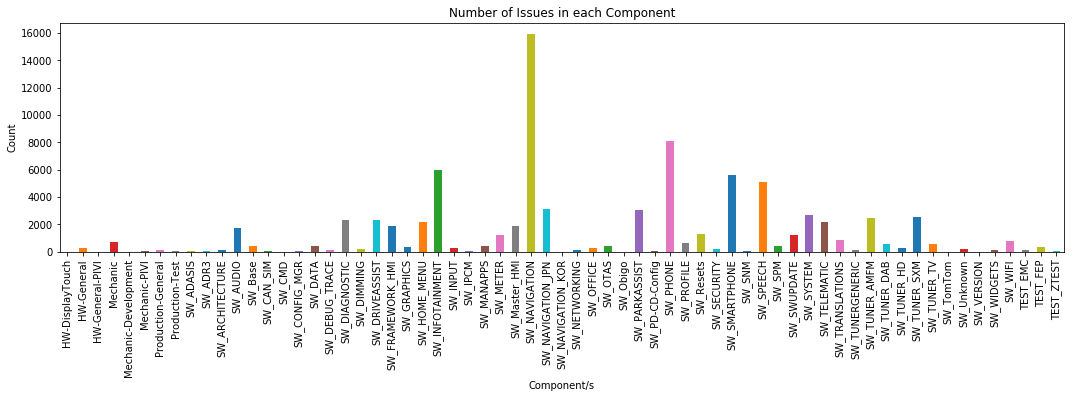

In [56]:
fig = plt.figure(figsize=(18,6))
data.groupby('Component/s').Summary.count().plot.bar(ylim=0)
plt.ylabel('Count')
plt.title('Number of Issues in each Component')
plt.gcf().subplots_adjust(bottom=0.35)
plt.savefig('Comp.png')
plt.show()

In [53]:
len(data)

82592

In [54]:
len(train)

66073

In [55]:
len(test)

16519